In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.9.1
Torchvision Version:  0.10.1


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   



class UNetSmall(nn.Module):

    def __init__(self, in_channels,out_channels,dropout=0.2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 32)
        self.dconv_down2 = double_conv(32, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512+256, 256)
        self.dconv_up3 = double_conv(256+128, 128)
        self.dconv_up2 = double_conv(128+64, 64)
        self.dconv_up1 = double_conv(64+32, 32)
        
        self.conv_last = nn.Conv2d(32, out_channels, 1)
#         self.fc1 = nn.Linear(25600 ,1024)
#         self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.bn2d = nn.BatchNorm2d(num_features=512, affine=False)
#         self.out = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
#         self.softmax = nn.Softmax(-1)
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
#         print('x Down1pre shape: ',x.shape)
        conv1 = self.dconv_down1(x)
        
        x = self.maxpool(conv1)
#         print('x Down1post shape: ',x.shape)
    
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
#         print('x Down2post shape: ',x.shape)
        
    
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
#         print('x Down3post shape: ',x.shape)

    
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
#         print('x Down4post shape: ',x.shape)
    
        x = self.dconv_down5(x)
        x = self.bn2d(x)
#         print('x Down5post shape: ',x.shape)
        

#         print('x shape: ',x.shape)
        #Classifier
#         flatten = x.view(x.size(0),-1)
# #         print('fc:',flatten.size())
#         y = self.fc1(flatten)
#         y = self.bn_fc1(y)
#         y = self.relu(y)
#         y = self.dropout1(y)

#         y = self.out(y)
# #         print('out:',x.size())
#         prediction = nn.functional.log_softmax(y,dim=1)
        
        x = self.upsample(x)
#         print('x up4pre shape: ',x.shape)
        x = torch.cat([x, conv4], dim=1)
#         print('x up4post shape: ',x.shape)
        x = self.dconv_up4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
#         print('x up3post shape: ',x.shape)
        
        x = self.dconv_up3(x)
        
        x = self.upsample(x)
                
        x = torch.cat([x, conv2], dim=1)  
#         print('x up2post shape: ',x.shape)

        x = self.dconv_up2(x)
        x = self.upsample(x)     
        
        x = torch.cat([x, conv1], dim=1)   
#         print('x up1post shape: ',x.shape)
        
        x = self.dconv_up1(x)
#         x = self.bn2d(x)
        out = self.conv_last(x)
#         print('output shape: ',out.shape)
#         out = self.relu(out)
#         out = self.softmax(out)
        
        return out

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.0001)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetSmall(1,3)
model.apply(init_weights)
model = model.to(device)
# model
summary(model, input_size=(1, 112, 80), dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       320
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       9,248
|    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       18,496
|    └─ReLU: 2-6                         --
|    └─Conv2d: 2-7                       36,928
|    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       73,856
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      147,584
|    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      295,168
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
├─Sequential: 1-5                       

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       320
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       9,248
|    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       18,496
|    └─ReLU: 2-6                         --
|    └─Conv2d: 2-7                       36,928
|    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       73,856
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      147,584
|    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      295,168
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
├─Sequential: 1-5                       

In [6]:
from collections import defaultdict
import torch.nn.functional as F

In [7]:
Datadir = "G:\\00TIGS2Testing\\CHOSorting2\\G1\\ImageRaw"

In [8]:
import os

def datapreparation(Datadir):
#     Datapath = []
    trainlabel = []
    fpath = []
    for dirpath, dirnames, filenames in os.walk(Datadir):
        for filename in [f for f in filenames if f.endswith(".mat")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    datalength = list(range(1,len(fpath)))
    print('dataset length: %d' %(len(datalength)))

    return fpath

In [9]:
X= datapreparation(Datadir)

dataset length: 11209


In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True,random_state=1)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]



Train Index:  [    0     1     2 ... 11206 11207 11209] 

Test Index:  [    4     6     7 ... 11202 11205 11208]
Train Index:  [    0     1     2 ... 11207 11208 11209] 

Test Index:  [   10    16    21 ... 11190 11203 11206]
Train Index:  [    0     1     2 ... 11206 11208 11209] 

Test Index:  [    3     5    11 ... 11199 11200 11207]
Train Index:  [    0     2     3 ... 11206 11207 11208] 

Test Index:  [    1     8     9 ... 11198 11201 11209]
Train Index:  [    1     3     4 ... 11207 11208 11209] 

Test Index:  [    0     2    15 ... 11191 11194 11204]


In [11]:
trainpath[0]

'G:\\00TIGS2Testing\\CHOSorting2\\G1\\ImageRaw\\1-40_Images.mat'

In [12]:
import scipy.io
from PIL import Image
import random

class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = scipy.io.loadmat(self.paths[index])
        x = np.array(data['ImgresizeTrans'])
#         x = x[:,4:-4]
#         x = np.concatenate((x,np.tile(x[-1,:],(3,1))),axis=0)
        if x.max() == 0:
            x = x
        else:
            x = (x-x.min())/(x.max()-x.min())
        y = np.transpose(np.array(data['RGBresize']),(2,0,1))
#         y = y[:,:,4:-4]
#         tempy = np.zeros((y.shape[0],3,y.shape[2]))
#         y = np.concatenate((y,tempy),axis=1)
#         y_rgb = np.array(data['RGB'])
#         y_rgb = y_rgb[:,10:250,:]
#         tempyrgb = np.zeros((3,y.shape[1],y.shape[2]))
#         y_rgb = np.concatenate((y_rgb,tempyrgb),axis=0)
        y = (y/255).astype(np.uint8)
        y[y<1] = 0
        y_new = np.zeros(y.shape).astype(np.uint8)
        y_new[0,:,:] = y[0,:,:]
        y_new[1,:,:] = y[1,:,:] + y[0,:,:]
        y_new[2,:,:] = y[2,:,:] + y[1,:,:] + y[0,:,:]
#         y_new = y_new[0:-1,:,:]
        p1 = random.uniform(0, 1)
        p2 = random.uniform(0, 1)
            
        x = torch.from_numpy(x)
        x = x.type(torch.FloatTensor)
        x = x.unsqueeze(dim = 0)
        y_new = torch.from_numpy(y_new)
        if p1 >=0.5:
            x = torch.flip(x, dims=[1])
            y_new = torch.flip(y_new, dims=[1])
            
        if p2 >=0.5:
            x = torch.flip(x, dims=[2])
            y_new = torch.flip(y_new, dims=[2])        
        return x, y_new,index
    
    def __len__(self):
        return len(self.paths)

In [13]:
img_datasets = MyDataset(trainpath[0:3000])
type(img_datasets.__getitem__(0)[0])

torch.Tensor

In [14]:
#actual prediction
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

training data volume:  8968
validation data volume:  2242


In [15]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [16]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable


def DisplayImage(img,LimMin,LimMax,Idx):  
#     if img.shape[2]>1:
#         for depth in range (0,10):
#             fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
#             plt.subplot(2,5,depth+1)
#             plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
#             # plt.colorbar()
#             plt.title('z = '+ str(depth))
#             if depth==9:
#                 plt.subplot(2,5,depth+1)
#                 plt.title('z = '+ str(depth))
#                 ax = plt.gca()
#                 fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(fig4, cax=cax)
#         plt.show()
#     else:
    fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
    plt.title('Transmission ' + str(Idx))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig4, cax=cax)
    plt.show()


image tensor shape:  torch.Size([1, 80, 112])
image tensor dtype:  torch.float32
image tensor index:  3
mask shape:  torch.Size([3, 80, 112])
image shape:  (80, 112)


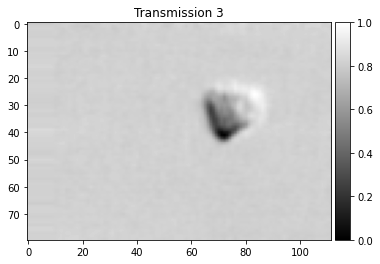

In [17]:
ImgIdx = 3
image_datasets['train'].__getitem__(ImgIdx)[0].shape
ImgTensor = 0
ImgMask = 0
[ImgTensor,ImgMask,ImgIdx] = image_datasets['train'].__getitem__(ImgIdx)
# image = np.transpose(ImgTensor.numpy(), (1,2,0))
# print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
print('image tensor index: ', ImgIdx)
print('mask shape: ', ImgMask.shape)
# image_datasets['train'].__getitem__(ImgIdx)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = 0
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)
DisplayImage(image,image.min(),image.max(),ImgIdx)

In [18]:
import matplotlib.colors as colors
cmap = colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

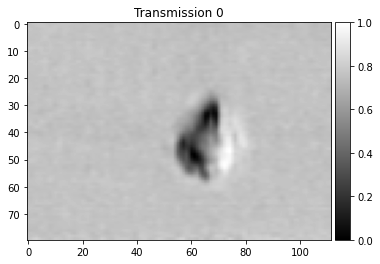

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


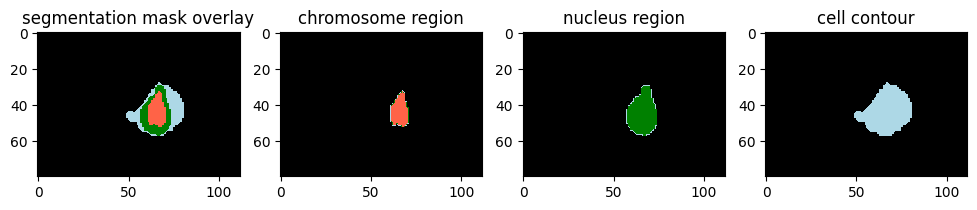

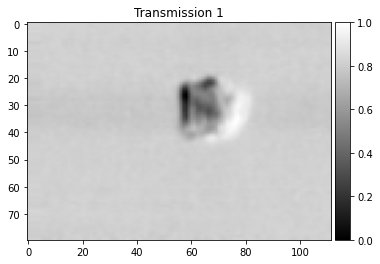

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


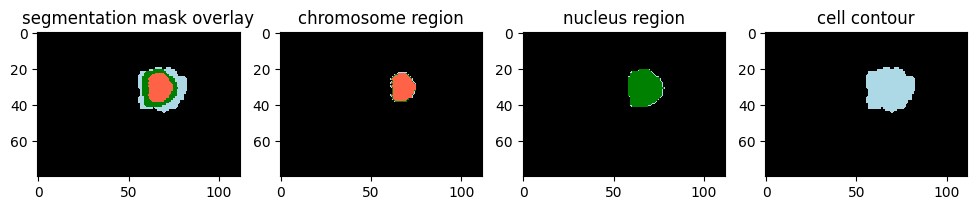

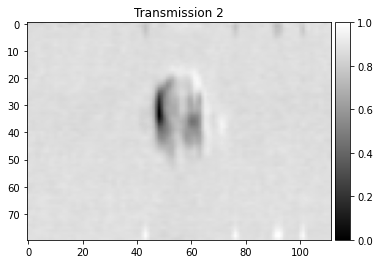

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


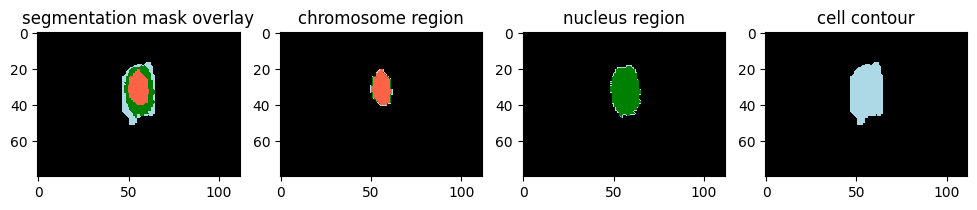

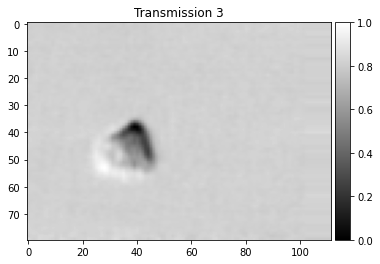

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


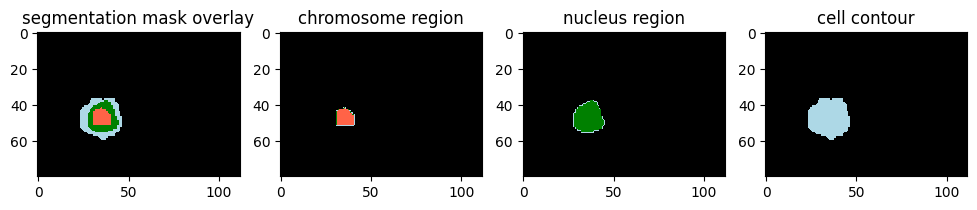

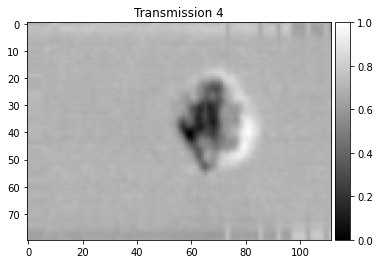

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


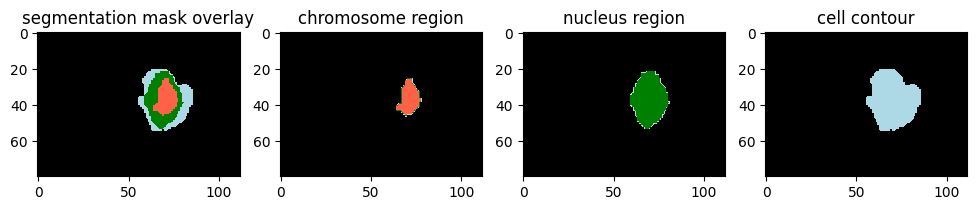

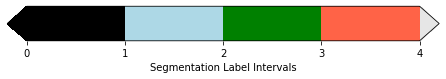

In [19]:
for ImgIdx in range(0,5):
    [ImgTensor,ImgMask,ImgIdx] = image_datasets['train'].__getitem__(ImgIdx)
    image = 0
    image = np.squeeze(ImgTensor.numpy())
    DisplayImage(image,image.min(),image.max(),ImgIdx)
    # image = np.squeeze(image)
    mask = np.zeros(ImgMask.numpy().shape)
    mask = ImgMask.numpy()
    print(mask.shape)
#     tempimage = image
#     tempimage[tempimage>0] = 1
#     mask2 = tempimage
    mask2 = mask[2]
    mask1 = mask[1]
    mask0 = mask[0]
    MaskOverlay = mask0 + mask1 + mask2
    print('MaskOverlay shape:', MaskOverlay.shape)
    # mask = np.transpose(ImgMask.numpy(), (1,2,0))
    # image = np.squeeze(image)
    # mask = ImgMask.numpy()
    # print(mask[:,0,0].sum())
    print(mask.shape)
    # Imgmask= np.transpose(mask,(1,2,0))
    fig = plt.figure(figsize=(12, 60), dpi=100)
    plt.subplot(1, 4, 1)
    plt.imshow(MaskOverlay,cmap=cmap,norm=norm)
    plt.title('segmentation mask overlay')
    plt.subplot(1, 4, 2)
    plt.imshow(mask0*3,cmap=cmap,norm=norm)
    # tempmask = mask[0]
    # tempmask[tempmask < 3] = 0
    # mask[0] = tempmask
    plt.title('chromosome region')
    plt.subplot(1, 4, 3)
    plt.imshow(mask1*2,cmap=cmap,norm=norm)
    plt.title('nucleus region')
    plt.subplot(1, 4, 4)
    plt.imshow(mask2,cmap=cmap,norm=norm)
    plt.title('cell contour')
    plt.show()


    
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(30, 1))
fig.subplots_adjust(bottom=0.4,left=0.7)

cmap = mpl.colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
cmap.set_over('0.9')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=[0] + bounds + [13],
                                extend='both',
                                ticks=bounds,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Segmentation Label Intervals')

    # fig = plt.figure()
    # plt.imshow(mask0)
    # plt.colorbar()
    # # tempmask = mask[0]
    # # tempmask[tempmask < 3] = 0
    # # mask[0] = tempmask
    # plt.title('chromosome region')
    # plt.show()

In [20]:
# dice loss
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [21]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))
def clac_iouscore (mask, maskpred):
    maskbool = mask.astype(dtype=bool)
    maskpredbool = maskpred.astype(dtype=bool)
    intersection = np.logical_and(maskbool, maskpredbool)
    union = np.logical_or(maskbool, maskpredbool)
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

In [22]:
import tqdm
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_bceloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    outer = tqdm.tqdm(total=num_epochs, desc='num_epochs', position=0)
    for epoch in range(num_epochs):
        print('\n')
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 10:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels,index in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 10:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     print('outputs type:', outputs.dtype)
#                     print('labels type:', labels.dtype)
                    labels = labels.type(torch.FloatTensor).to(device)
                    loss = calc_loss(outputs,labels, metrics,bce_weight = 0.1)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(outputs, dim = 1)
#                 print('preds size: ',preds.shape)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
#                 for t, p in zip(labels.view(-1), preds.view(-1)):
#                     confusion_matrix[t.long(), p.long()] += 1

#                 running_corrects += torch.sum(preds == labels.data)


#             confusionMat = np.asarray(confusion_matrix)
#             sumconfusion = np.sum(confusionMat,axis = 1).T

#             summat = np.tile(sumconfusion,(3,1)).T
            # print(test)
#             percentconfusion = np.divide(confusionMat,summat)
#             epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
#             epoch_acc = running_corrects.double() / epoch_samples
#             print('{} Acc: {:.4f}'.format(phase, epoch_acc))
#             print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
#                 best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
#                 val_acc_history.append(epoch_acc)
#                 val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_bceloss_history.append(metrics['bce']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                else:
#                 elif epoch > num_epochs * (1/3):
                    scheduler2.step(epoch_loss)
                

            if phase == 'train':
#                 train_acc_history.append(epoch_acc)
#                 train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
            

        if epoch > 3 and val_bceloss_history[-1] > 1.8e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        outer.update(1)
        if param_group['lr'] <= 2e-7:
            break
        
    print('Best val loss: {:4f}'.format(best_loss))
#     print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss_history,val_loss_history,lr_history

In [23]:
# Data augmentation and normalization for training
# Just normalization for validation

print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 256
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.713886, dice: 0.931589, loss: 0.909818


num_epochs:   1%|▍                                                                   | 1/150 [00:30<1:14:33, 30.02s/it]

val: bce: 0.713819, dice: 0.931592, loss: 0.909815
saving best model
Total time: 0:00:30.030620
Epoch time: 0m 30s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.713750, dice: 0.931590, loss: 0.909806


num_epochs:   1%|▉                                                                   | 2/150 [00:58<1:12:18, 29.31s/it]

val: bce: 0.713681, dice: 0.931593, loss: 0.909802
saving best model
Total time: 0:00:58.843750
Epoch time: 0m 29s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.713608, dice: 0.931590, loss: 0.909792


num_epochs:   2%|█▎                                                                  | 3/150 [01:27<1:11:05, 29.02s/it]

val: bce: 0.713535, dice: 0.931594, loss: 0.909788
saving best model
Total time: 0:01:27.511057
Epoch time: 0m 29s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.713458, dice: 0.931591, loss: 0.909778


num_epochs:   3%|█▊                                                                  | 4/150 [01:56<1:10:40, 29.04s/it]

val: bce: 0.713379, dice: 0.931595, loss: 0.909773
saving best model
Total time: 0:01:56.594508
Epoch time: 0m 29s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.713294, dice: 0.931592, loss: 0.909763


num_epochs:   3%|██▎                                                                 | 5/150 [02:26<1:10:42, 29.26s/it]

val: bce: 0.713205, dice: 0.931596, loss: 0.909757
saving best model
Total time: 0:02:26.237447
Epoch time: 0m 30s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.323588, dice: 0.838534, loss: 0.787039


num_epochs:   4%|██▋                                                                 | 6/150 [02:55<1:09:49, 29.10s/it]

val: bce: 0.156635, dice: 0.795929, loss: 0.732000
saving best model
Total time: 0:02:55.015857
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.141881, dice: 0.751092, loss: 0.690171


num_epochs:   5%|███▏                                                                | 7/150 [03:23<1:09:08, 29.01s/it]

val: bce: 0.139885, dice: 0.748234, loss: 0.687399
saving best model
Total time: 0:03:23.853789
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.145099, dice: 0.746737, loss: 0.686574


num_epochs:   5%|███▋                                                                | 8/150 [03:52<1:08:21, 28.88s/it]

val: bce: 0.171749, dice: 0.747397, loss: 0.689832
Total time: 0:03:52.465047
Epoch time: 0m 29s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.146148, dice: 0.746028, loss: 0.686040


num_epochs:   6%|████                                                                | 9/150 [04:21<1:07:55, 28.91s/it]

val: bce: 0.164348, dice: 0.780337, loss: 0.718738
Total time: 0:04:21.417058
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.159561, dice: 0.753392, loss: 0.694009


num_epochs:   7%|████▍                                                              | 10/150 [04:50<1:07:41, 29.01s/it]

val: bce: 0.168355, dice: 0.744125, loss: 0.686548
saving best model
Total time: 0:04:50.656748
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.145876, dice: 0.742906, loss: 0.683203


num_epochs:   7%|████▉                                                              | 11/150 [05:19<1:07:17, 29.04s/it]

val: bce: 0.179198, dice: 0.750488, loss: 0.693359
Total time: 0:05:19.778392
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.144076, dice: 0.740124, loss: 0.680519


num_epochs:   8%|█████▎                                                             | 12/150 [05:49<1:07:06, 29.18s/it]

val: bce: 0.143018, dice: 0.737072, loss: 0.677667
saving best model
Total time: 0:05:49.267075
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.132455, dice: 0.717149, loss: 0.658679


num_epochs:   9%|█████▊                                                             | 13/150 [06:18<1:06:32, 29.14s/it]

val: bce: 0.206804, dice: 0.580101, loss: 0.542771
saving best model
Total time: 0:06:18.324734
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.078266, dice: 0.519562, loss: 0.475432


num_epochs:   9%|██████▎                                                            | 14/150 [06:46<1:05:42, 28.99s/it]

val: bce: 0.111249, dice: 0.523151, loss: 0.481961
saving best model
Total time: 0:06:46.957816
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.065592, dice: 0.467936, loss: 0.427702


num_epochs:  10%|██████▋                                                            | 15/150 [07:15<1:04:55, 28.86s/it]

val: bce: 0.100542, dice: 0.461252, loss: 0.425181
saving best model
Total time: 0:07:15.516004
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.065298, dice: 0.444459, loss: 0.406543


num_epochs:  11%|███████▏                                                           | 16/150 [07:44<1:04:17, 28.79s/it]

val: bce: 0.059160, dice: 0.438307, loss: 0.400392
saving best model
Total time: 0:07:44.138670
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.069687, dice: 0.423616, loss: 0.388223


num_epochs:  11%|███████▌                                                           | 17/150 [08:12<1:03:39, 28.72s/it]

val: bce: 0.108546, dice: 0.420652, loss: 0.389441
saving best model
Total time: 0:08:12.689913
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.126258, dice: 0.380932, loss: 0.355464


num_epochs:  12%|████████                                                           | 18/150 [08:41<1:03:18, 28.78s/it]

val: bce: 0.158477, dice: 0.358279, loss: 0.338299
saving best model
Total time: 0:08:41.614148
Epoch time: 0m 29s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.143249, dice: 0.262953, loss: 0.250983


num_epochs:  13%|████████▍                                                          | 19/150 [09:10<1:02:44, 28.74s/it]

val: bce: 0.128184, dice: 0.242657, loss: 0.231209
saving best model
Total time: 0:09:10.264591
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.109321, dice: 0.210862, loss: 0.200708


num_epochs:  13%|████████▉                                                          | 20/150 [09:39<1:02:18, 28.76s/it]

val: bce: 0.120012, dice: 0.226752, loss: 0.216078
saving best model
Total time: 0:09:39.074746
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.100539, dice: 0.202111, loss: 0.191954


num_epochs:  14%|█████████▍                                                         | 21/150 [10:07<1:01:42, 28.70s/it]

val: bce: 0.105579, dice: 0.196619, loss: 0.187515
saving best model
Total time: 0:10:07.644836
Epoch time: 0m 29s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.096568, dice: 0.197347, loss: 0.187269


num_epochs:  15%|█████████▊                                                         | 22/150 [10:36<1:01:07, 28.65s/it]

val: bce: 0.097985, dice: 0.224839, loss: 0.212153
Total time: 0:10:36.180207
Epoch time: 0m 29s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.095270, dice: 0.196668, loss: 0.186528


num_epochs:  15%|██████████▎                                                        | 23/150 [11:04<1:00:35, 28.62s/it]

val: bce: 0.085173, dice: 0.190018, loss: 0.179534
saving best model
Total time: 0:11:04.732938
Epoch time: 0m 29s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.089766, dice: 0.188390, loss: 0.178528


num_epochs:  16%|██████████▋                                                        | 24/150 [11:33<1:00:02, 28.59s/it]

val: bce: 0.107795, dice: 0.198567, loss: 0.189490
Total time: 0:11:33.239542
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.088192, dice: 0.187952, loss: 0.177976


num_epochs:  17%|███████████▌                                                         | 25/150 [12:01<59:30, 28.56s/it]

val: bce: 0.106915, dice: 0.224903, loss: 0.213104
Total time: 0:12:01.735728
Epoch time: 0m 28s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.089672, dice: 0.190592, loss: 0.180500


num_epochs:  17%|███████████▉                                                         | 26/150 [12:30<58:57, 28.52s/it]

val: bce: 0.092106, dice: 0.204204, loss: 0.192995
Total time: 0:12:30.176363
Epoch time: 0m 28s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.086906, dice: 0.188821, loss: 0.178630


num_epochs:  18%|████████████▍                                                        | 27/150 [12:58<58:26, 28.51s/it]

val: bce: 0.087554, dice: 0.182606, loss: 0.173101
saving best model
Total time: 0:12:58.659654
Epoch time: 0m 28s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.080894, dice: 0.177321, loss: 0.167678


num_epochs:  19%|████████████▉                                                        | 28/150 [13:27<57:58, 28.51s/it]

val: bce: 0.123071, dice: 0.216002, loss: 0.206709
Total time: 0:13:27.168240
Epoch time: 0m 29s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.084620, dice: 0.183651, loss: 0.173748


num_epochs:  19%|█████████████▎                                                       | 29/150 [13:55<57:32, 28.53s/it]

val: bce: 0.081051, dice: 0.183112, loss: 0.172906
saving best model
Total time: 0:13:55.756684
Epoch time: 0m 29s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.078562, dice: 0.174519, loss: 0.164924


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:24<57:08, 28.57s/it]

val: bce: 0.105099, dice: 0.208773, loss: 0.198406
Total time: 0:14:24.413079
Epoch time: 0m 29s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.084700, dice: 0.183671, loss: 0.173773


num_epochs:  21%|██████████████▎                                                      | 31/150 [14:53<56:46, 28.63s/it]

val: bce: 0.093113, dice: 0.182959, loss: 0.173975
Total time: 0:14:53.168178
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.077336, dice: 0.173827, loss: 0.164178


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:21<56:18, 28.63s/it]

val: bce: 0.075708, dice: 0.172043, loss: 0.162409
saving best model
Total time: 0:15:21.802253
Epoch time: 0m 29s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.074410, dice: 0.169376, loss: 0.159880


num_epochs:  22%|███████████████▏                                                     | 33/150 [15:50<55:50, 28.63s/it]

val: bce: 0.085694, dice: 0.196334, loss: 0.185270
Total time: 0:15:50.444264
Epoch time: 0m 29s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.076277, dice: 0.175736, loss: 0.165790


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:18<55:18, 28.61s/it]

val: bce: 0.087087, dice: 0.178143, loss: 0.169037
Total time: 0:16:19.005923
Epoch time: 0m 29s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.073952, dice: 0.168691, loss: 0.159217


num_epochs:  23%|████████████████                                                     | 35/150 [16:47<54:52, 28.63s/it]

val: bce: 0.086240, dice: 0.186854, loss: 0.176793
Total time: 0:16:47.670749
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.071821, dice: 0.165740, loss: 0.156348


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:16<54:21, 28.61s/it]

val: bce: 0.082511, dice: 0.174514, loss: 0.165314
Total time: 0:17:16.244808
Epoch time: 0m 29s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.070627, dice: 0.165084, loss: 0.155638


num_epochs:  25%|█████████████████                                                    | 37/150 [17:44<53:52, 28.60s/it]

val: bce: 0.070506, dice: 0.172344, loss: 0.162160
saving best model
Total time: 0:17:44.827299
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.065712, dice: 0.157601, loss: 0.148412


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:13<53:22, 28.59s/it]

val: bce: 0.066755, dice: 0.154556, loss: 0.145776
saving best model
Total time: 0:18:13.388958
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.064679, dice: 0.153844, loss: 0.144928


num_epochs:  26%|█████████████████▉                                                   | 39/150 [18:41<52:52, 28.58s/it]

val: bce: 0.075603, dice: 0.172914, loss: 0.163183
Total time: 0:18:41.946649
Epoch time: 0m 29s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.067643, dice: 0.157883, loss: 0.148859


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:10<52:23, 28.58s/it]

val: bce: 0.074202, dice: 0.161940, loss: 0.153166
Total time: 0:19:10.528148
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.061552, dice: 0.149068, loss: 0.140316


num_epochs:  27%|██████████████████▊                                                  | 41/150 [19:39<51:56, 28.59s/it]

val: bce: 0.085325, dice: 0.168151, loss: 0.159868
Total time: 0:19:39.138415
Epoch time: 0m 29s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.062207, dice: 0.149513, loss: 0.140783


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:08<51:50, 28.80s/it]

val: bce: 0.068321, dice: 0.164979, loss: 0.155314
Total time: 0:20:08.440602
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.059408, dice: 0.145760, loss: 0.137125


num_epochs:  29%|███████████████████▊                                                 | 43/150 [20:37<51:39, 28.97s/it]

val: bce: 0.062116, dice: 0.156697, loss: 0.147239
Total time: 0:20:37.783460
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.058791, dice: 0.145098, loss: 0.136467


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:06<51:17, 29.03s/it]

val: bce: 0.062786, dice: 0.151241, loss: 0.142395
saving best model
Total time: 0:21:06.970079
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.057838, dice: 0.142205, loss: 0.133768


num_epochs:  30%|████████████████████▋                                                | 45/150 [21:35<50:44, 28.99s/it]

val: bce: 0.078018, dice: 0.168463, loss: 0.159418
Total time: 0:21:35.865546
Epoch time: 0m 29s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.057622, dice: 0.142177, loss: 0.133721


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:04<50:10, 28.94s/it]

val: bce: 0.063322, dice: 0.151587, loss: 0.142760
Total time: 0:22:04.701494
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.057788, dice: 0.141621, loss: 0.133238


num_epochs:  31%|█████████████████████▌                                               | 47/150 [22:33<49:37, 28.91s/it]

val: bce: 0.054860, dice: 0.138407, loss: 0.130052
saving best model
Total time: 0:22:33.515616
Epoch time: 0m 29s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.055061, dice: 0.136474, loss: 0.128332


num_epochs:  32%|██████████████████████                                               | 48/150 [23:02<49:07, 28.90s/it]

val: bce: 0.054372, dice: 0.143578, loss: 0.134657
Total time: 0:23:02.394715
Epoch time: 0m 29s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.055059, dice: 0.137181, loss: 0.128969


num_epochs:  33%|██████████████████████▌                                              | 49/150 [23:31<48:37, 28.89s/it]

val: bce: 0.088997, dice: 0.178059, loss: 0.169152
Total time: 0:23:31.257942
Epoch time: 0m 29s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.057343, dice: 0.140286, loss: 0.131992


num_epochs:  33%|███████████████████████                                              | 50/150 [24:00<48:06, 28.86s/it]

val: bce: 0.059314, dice: 0.140334, loss: 0.132232
Total time: 0:24:00.056689
Epoch time: 0m 29s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.055962, dice: 0.137050, loss: 0.128941


num_epochs:  34%|███████████████████████▍                                             | 51/150 [24:28<47:35, 28.85s/it]

val: bce: 0.062598, dice: 0.145252, loss: 0.136986
Total time: 0:24:28.867835
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.053636, dice: 0.134823, loss: 0.126705


num_epochs:  35%|███████████████████████▉                                             | 52/150 [24:57<47:09, 28.87s/it]

val: bce: 0.065059, dice: 0.153587, loss: 0.144735
Total time: 0:24:57.788102
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.054009, dice: 0.135326, loss: 0.127194


num_epochs:  35%|████████████████████████▍                                            | 53/150 [25:26<46:40, 28.87s/it]

val: bce: 0.073289, dice: 0.156664, loss: 0.148327
Total time: 0:25:26.662737
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.055942, dice: 0.137645, loss: 0.129474


num_epochs:  36%|████████████████████████▊                                            | 54/150 [25:55<46:09, 28.85s/it]

val: bce: 0.067459, dice: 0.149837, loss: 0.141599
Total time: 0:25:55.453052
Epoch time: 0m 29s


----------
Epoch 54/149
LR 0.0005
train: bce: 0.054527, dice: 0.135482, loss: 0.127386


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:24<45:41, 28.86s/it]

val: bce: 0.055427, dice: 0.136736, loss: 0.128605
saving best model
Total time: 0:26:24.331655
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.0005
train: bce: 0.053201, dice: 0.133071, loss: 0.125084


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [26:53<45:12, 28.86s/it]

val: bce: 0.069852, dice: 0.162113, loss: 0.152887
Total time: 0:26:53.194882
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.0005
train: bce: 0.053603, dice: 0.133670, loss: 0.125663


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:22<44:44, 28.86s/it]

val: bce: 0.054112, dice: 0.132065, loss: 0.124270
saving best model
Total time: 0:27:22.069021
Epoch time: 0m 29s


----------
Epoch 57/149
LR 0.0005
train: bce: 0.052346, dice: 0.131464, loss: 0.123552


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [27:51<44:17, 28.89s/it]

val: bce: 0.059061, dice: 0.137743, loss: 0.129875
Total time: 0:27:51.014584
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.0005
train: bce: 0.052545, dice: 0.132964, loss: 0.124922


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:19<43:47, 28.88s/it]

val: bce: 0.078455, dice: 0.160372, loss: 0.152181
Total time: 0:28:19.870866
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.0005
train: bce: 0.053306, dice: 0.132954, loss: 0.124989


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [28:48<43:20, 28.89s/it]

val: bce: 0.053806, dice: 0.136402, loss: 0.128143
Total time: 0:28:48.793613
Epoch time: 0m 29s


----------
Epoch 60/149
LR 0.0005
train: bce: 0.051047, dice: 0.129973, loss: 0.122080


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:17<42:49, 28.87s/it]

val: bce: 0.067043, dice: 0.157519, loss: 0.148471
Total time: 0:29:17.616663
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.0005
train: bce: 0.056981, dice: 0.138009, loss: 0.129907


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [29:46<42:21, 28.88s/it]

val: bce: 0.053242, dice: 0.133787, loss: 0.125733
Total time: 0:29:46.501219
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.0005
train: bce: 0.051020, dice: 0.129302, loss: 0.121474


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:15<41:52, 28.88s/it]

val: bce: 0.062258, dice: 0.139410, loss: 0.131695
Total time: 0:30:15.384286
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.0005
train: bce: 0.052336, dice: 0.130875, loss: 0.123021


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [30:44<41:24, 28.89s/it]

val: bce: 0.055663, dice: 0.141476, loss: 0.132895
Total time: 0:30:44.301577
Epoch time: 0m 29s


----------
Epoch 64/149
LR 0.0005
train: bce: 0.050968, dice: 0.129800, loss: 0.121917


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [31:13<40:55, 28.89s/it]

val: bce: 0.097040, dice: 0.169494, loss: 0.162249
Total time: 0:31:13.203491
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.0005
train: bce: 0.054598, dice: 0.135505, loss: 0.127415


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [31:42<40:28, 28.91s/it]

val: bce: 0.054699, dice: 0.134193, loss: 0.126243
Epoch    61: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:31:42.146078
Epoch time: 0m 29s


----------
Epoch 66/149
LR 0.00025
train: bce: 0.049613, dice: 0.128406, loss: 0.120527


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [32:11<39:59, 28.90s/it]

val: bce: 0.053465, dice: 0.131278, loss: 0.123497
saving best model
Total time: 0:32:11.043034
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.00025
train: bce: 0.049195, dice: 0.126471, loss: 0.118744


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [32:39<39:30, 28.91s/it]

val: bce: 0.048772, dice: 0.129392, loss: 0.121330
saving best model
Total time: 0:32:39.975700
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.00025
train: bce: 0.048696, dice: 0.126097, loss: 0.118357


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [33:08<38:58, 28.87s/it]

val: bce: 0.048641, dice: 0.128479, loss: 0.120495
saving best model
Total time: 0:33:08.737247
Epoch time: 0m 29s


----------
Epoch 69/149
LR 0.00025
train: bce: 0.048822, dice: 0.125740, loss: 0.118048


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [33:37<38:27, 28.85s/it]

val: bce: 0.047961, dice: 0.127522, loss: 0.119566
saving best model
Total time: 0:33:37.533019
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.00025
train: bce: 0.049163, dice: 0.125514, loss: 0.117879


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [34:06<38:00, 28.87s/it]

val: bce: 0.049740, dice: 0.129607, loss: 0.121621
Total time: 0:34:06.457253
Epoch time: 0m 29s


----------
Epoch 71/149
LR 0.00025
train: bce: 0.048824, dice: 0.125851, loss: 0.118148


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [34:35<37:31, 28.87s/it]

val: bce: 0.052993, dice: 0.132177, loss: 0.124259
Total time: 0:34:35.329904
Epoch time: 0m 29s


----------
Epoch 72/149
LR 0.00025
train: bce: 0.048463, dice: 0.125380, loss: 0.117689


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [35:04<37:01, 28.85s/it]

val: bce: 0.053438, dice: 0.128507, loss: 0.121000
Total time: 0:35:04.119227
Epoch time: 0m 29s


----------
Epoch 73/149
LR 0.00025
train: bce: 0.048524, dice: 0.125024, loss: 0.117374


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [35:32<36:31, 28.84s/it]

val: bce: 0.047786, dice: 0.126274, loss: 0.118425
saving best model
Total time: 0:35:32.928390
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.00025
train: bce: 0.048732, dice: 0.125521, loss: 0.117842


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [36:01<36:03, 28.84s/it]

val: bce: 0.060981, dice: 0.142942, loss: 0.134746
Total time: 0:36:01.790624
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.00025
train: bce: 0.048436, dice: 0.125795, loss: 0.118059


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [36:30<35:33, 28.83s/it]

val: bce: 0.053316, dice: 0.136625, loss: 0.128295
Total time: 0:36:30.598299
Epoch time: 0m 29s


----------
Epoch 76/149
LR 0.00025
train: bce: 0.049343, dice: 0.126071, loss: 0.118398


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [36:59<35:07, 28.87s/it]

val: bce: 0.046964, dice: 0.124820, loss: 0.117034
saving best model
Total time: 0:36:59.557254
Epoch time: 0m 29s


----------
Epoch 77/149
LR 0.00025
train: bce: 0.047726, dice: 0.123793, loss: 0.116186


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [37:28<34:37, 28.85s/it]

val: bce: 0.050119, dice: 0.129118, loss: 0.121218
Total time: 0:37:28.359473
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.00025
train: bce: 0.048761, dice: 0.125159, loss: 0.117519


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [37:57<34:08, 28.85s/it]

val: bce: 0.052737, dice: 0.130858, loss: 0.123046
Total time: 0:37:57.207324
Epoch time: 0m 29s


----------
Epoch 79/149
LR 0.00025
train: bce: 0.048043, dice: 0.124630, loss: 0.116971


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:26<33:38, 28.84s/it]

val: bce: 0.051164, dice: 0.132606, loss: 0.124462
Total time: 0:38:26.027399
Epoch time: 0m 29s


----------
Epoch 80/149
LR 0.00025
train: bce: 0.047892, dice: 0.124432, loss: 0.116778


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [38:54<33:08, 28.82s/it]

val: bce: 0.050036, dice: 0.129301, loss: 0.121375
Total time: 0:38:54.802338
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.00025
train: bce: 0.048484, dice: 0.124884, loss: 0.117244


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:23<32:39, 28.81s/it]

val: bce: 0.055029, dice: 0.135014, loss: 0.127016
Total time: 0:39:23.586700
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.00025
train: bce: 0.048781, dice: 0.124818, loss: 0.117214


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [39:52<32:11, 28.82s/it]

val: bce: 0.047841, dice: 0.125542, loss: 0.117772
Total time: 0:39:52.435544
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.00025
train: bce: 0.046906, dice: 0.122785, loss: 0.115197


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [40:21<31:43, 28.84s/it]

val: bce: 0.048041, dice: 0.124537, loss: 0.116887
saving best model
Total time: 0:40:21.304722
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.00025
train: bce: 0.047741, dice: 0.123156, loss: 0.115614


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [40:50<31:14, 28.84s/it]

val: bce: 0.048526, dice: 0.126645, loss: 0.118833
Total time: 0:40:50.164972
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.00025
train: bce: 0.047295, dice: 0.122397, loss: 0.114887


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [41:18<30:45, 28.84s/it]

val: bce: 0.052866, dice: 0.129776, loss: 0.122085
Total time: 0:41:18.988519
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.00025
train: bce: 0.047899, dice: 0.123165, loss: 0.115639


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [41:47<30:16, 28.83s/it]

val: bce: 0.052681, dice: 0.130155, loss: 0.122407
Total time: 0:41:47.807107
Epoch time: 0m 29s


----------
Epoch 87/149
LR 0.00025
train: bce: 0.047224, dice: 0.122964, loss: 0.115390


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [42:16<29:47, 28.83s/it]

val: bce: 0.052928, dice: 0.129700, loss: 0.122023
Total time: 0:42:16.649006
Epoch time: 0m 29s


----------
Epoch 88/149
LR 0.00025
train: bce: 0.047411, dice: 0.122841, loss: 0.115298


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [42:45<29:18, 28.83s/it]

val: bce: 0.055510, dice: 0.135589, loss: 0.127581
Total time: 0:42:45.453208
Epoch time: 0m 29s


----------
Epoch 89/149
LR 0.00025
train: bce: 0.048045, dice: 0.123724, loss: 0.116156


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [43:14<28:49, 28.82s/it]

val: bce: 0.046060, dice: 0.126871, loss: 0.118790
Total time: 0:43:14.258403
Epoch time: 0m 29s


----------
Epoch 90/149
LR 0.00025
train: bce: 0.046747, dice: 0.122423, loss: 0.114856


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [43:43<28:19, 28.80s/it]

val: bce: 0.048844, dice: 0.126532, loss: 0.118763
Total time: 0:43:43.017470
Epoch time: 0m 29s


----------
Epoch 91/149
LR 0.00025
train: bce: 0.047539, dice: 0.122509, loss: 0.115012


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [44:11<27:50, 28.81s/it]

val: bce: 0.048854, dice: 0.125878, loss: 0.118176
Total time: 0:44:11.844985
Epoch time: 0m 29s


----------
Epoch 92/149
LR 0.00025
train: bce: 0.047514, dice: 0.122788, loss: 0.115261


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [44:40<27:21, 28.80s/it]

val: bce: 0.050254, dice: 0.129248, loss: 0.121349
Epoch    88: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:44:40.632820
Epoch time: 0m 29s


----------
Epoch 93/149
LR 0.000125
train: bce: 0.047013, dice: 0.122323, loss: 0.114792


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [45:09<26:53, 28.82s/it]

val: bce: 0.046802, dice: 0.122052, loss: 0.114527
saving best model
Total time: 0:45:09.497535
Epoch time: 0m 29s


----------
Epoch 94/149
LR 0.000125
train: bce: 0.046150, dice: 0.120653, loss: 0.113203


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [45:38<26:25, 28.83s/it]

val: bce: 0.046826, dice: 0.122308, loss: 0.114760
Total time: 0:45:38.347369
Epoch time: 0m 29s


----------
Epoch 95/149
LR 0.000125
train: bce: 0.045857, dice: 0.120456, loss: 0.112996


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [46:07<25:56, 28.83s/it]

val: bce: 0.048955, dice: 0.123417, loss: 0.115971
Total time: 0:46:07.187285
Epoch time: 0m 29s


----------
Epoch 96/149
LR 0.000125
train: bce: 0.046007, dice: 0.120468, loss: 0.113022


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [46:35<25:26, 28.81s/it]

val: bce: 0.049825, dice: 0.124099, loss: 0.116671
Total time: 0:46:35.940400
Epoch time: 0m 29s


----------
Epoch 97/149
LR 0.000125
train: bce: 0.046362, dice: 0.120629, loss: 0.113202


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [47:04<24:58, 28.83s/it]

val: bce: 0.047392, dice: 0.124067, loss: 0.116399
Total time: 0:47:04.803627
Epoch time: 0m 29s


----------
Epoch 98/149
LR 0.000125
train: bce: 0.046352, dice: 0.121324, loss: 0.113827


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [47:33<24:30, 28.82s/it]

val: bce: 0.047782, dice: 0.122364, loss: 0.114906
Total time: 0:47:33.624198
Epoch time: 0m 29s


----------
Epoch 99/149
LR 0.000125
train: bce: 0.046307, dice: 0.120789, loss: 0.113341


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [48:02<24:03, 28.88s/it]

val: bce: 0.046799, dice: 0.121605, loss: 0.114124
saving best model
Total time: 0:48:02.622832
Epoch time: 0m 29s


----------
Epoch 100/149
LR 0.000125
train: bce: 0.045555, dice: 0.119917, loss: 0.112481


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [48:31<23:32, 28.83s/it]

val: bce: 0.049197, dice: 0.125202, loss: 0.117601
Total time: 0:48:31.359083
Epoch time: 0m 29s


----------
Epoch 101/149
LR 0.000125
train: bce: 0.046378, dice: 0.120248, loss: 0.112861


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [49:00<23:05, 28.87s/it]

val: bce: 0.047827, dice: 0.121963, loss: 0.114549
Total time: 0:49:00.310598
Epoch time: 0m 29s


----------
Epoch 102/149
LR 0.000125
train: bce: 0.046061, dice: 0.120145, loss: 0.112736


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [49:29<22:36, 28.86s/it]

val: bce: 0.047403, dice: 0.125447, loss: 0.117643
Total time: 0:49:29.164896
Epoch time: 0m 29s


----------
Epoch 103/149
LR 0.000125
train: bce: 0.046210, dice: 0.120604, loss: 0.113165


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [49:58<22:08, 28.88s/it]

val: bce: 0.044826, dice: 0.120792, loss: 0.113195
saving best model
Total time: 0:49:58.079213
Epoch time: 0m 29s


----------
Epoch 104/149
LR 0.000125
train: bce: 0.045234, dice: 0.119649, loss: 0.112208


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [50:26<21:38, 28.85s/it]

val: bce: 0.048268, dice: 0.125714, loss: 0.117969
Total time: 0:50:26.857622
Epoch time: 0m 29s


----------
Epoch 105/149
LR 0.000125
train: bce: 0.045997, dice: 0.120444, loss: 0.112999


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [50:55<21:08, 28.84s/it]

val: bce: 0.047403, dice: 0.121568, loss: 0.114152
Total time: 0:50:55.673233
Epoch time: 0m 29s


----------
Epoch 106/149
LR 0.000125
train: bce: 0.045930, dice: 0.120003, loss: 0.112596


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [51:24<20:39, 28.83s/it]

val: bce: 0.051903, dice: 0.126002, loss: 0.118592
Total time: 0:51:24.480908
Epoch time: 0m 29s


----------
Epoch 107/149
LR 0.000125
train: bce: 0.046003, dice: 0.120657, loss: 0.113192


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [51:53<20:10, 28.83s/it]

val: bce: 0.046498, dice: 0.121230, loss: 0.113757
Total time: 0:51:53.321425
Epoch time: 0m 29s


----------
Epoch 108/149
LR 0.000125
train: bce: 0.045313, dice: 0.119509, loss: 0.112089


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [52:22<19:42, 28.84s/it]

val: bce: 0.046968, dice: 0.121686, loss: 0.114214
Total time: 0:52:22.162331
Epoch time: 0m 29s


----------
Epoch 109/149
LR 0.000125
train: bce: 0.045384, dice: 0.119725, loss: 0.112291


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [52:50<19:13, 28.83s/it]

val: bce: 0.049555, dice: 0.123330, loss: 0.115952
Total time: 0:52:50.990342
Epoch time: 0m 29s


----------
Epoch 110/149
LR 0.000125
train: bce: 0.045749, dice: 0.120223, loss: 0.112776


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [53:19<18:44, 28.84s/it]

val: bce: 0.048776, dice: 0.122699, loss: 0.115307
Total time: 0:53:19.845137
Epoch time: 0m 29s


----------
Epoch 111/149
LR 0.000125
train: bce: 0.045414, dice: 0.119825, loss: 0.112384


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [53:48<18:16, 28.86s/it]

val: bce: 0.047700, dice: 0.121242, loss: 0.113888
Total time: 0:53:48.743084
Epoch time: 0m 29s


----------
Epoch 112/149
LR 0.000125
train: bce: 0.045376, dice: 0.119283, loss: 0.111892


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [54:17<17:48, 28.87s/it]

val: bce: 0.048194, dice: 0.122015, loss: 0.114633
Epoch   108: reducing learning rate of group 0 to 6.2500e-05.
Total time: 0:54:17.629622
Epoch time: 0m 29s


----------
Epoch 113/149
LR 6.25e-05
train: bce: 0.045855, dice: 0.119388, loss: 0.112034


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [54:46<17:18, 28.84s/it]

val: bce: 0.046346, dice: 0.121302, loss: 0.113807
Total time: 0:54:46.416465
Epoch time: 0m 29s


----------
Epoch 114/149
LR 6.25e-05
train: bce: 0.044966, dice: 0.118657, loss: 0.111288


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [55:15<16:48, 28.82s/it]

val: bce: 0.046378, dice: 0.121730, loss: 0.114195
Total time: 0:55:15.196861
Epoch time: 0m 29s


----------
Epoch 115/149
LR 6.25e-05
train: bce: 0.044972, dice: 0.118934, loss: 0.111538


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [55:43<16:19, 28.80s/it]

val: bce: 0.046651, dice: 0.121216, loss: 0.113760
Total time: 0:55:43.939064
Epoch time: 0m 29s


----------
Epoch 116/149
LR 6.25e-05
train: bce: 0.045206, dice: 0.118564, loss: 0.111228


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [56:12<15:49, 28.78s/it]

val: bce: 0.046412, dice: 0.121230, loss: 0.113749
Total time: 0:56:12.661922
Epoch time: 0m 29s


----------
Epoch 117/149
LR 6.25e-05
train: bce: 0.044649, dice: 0.118560, loss: 0.111169


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [56:41<15:21, 28.79s/it]

val: bce: 0.046785, dice: 0.121089, loss: 0.113659
Total time: 0:56:41.474061
Epoch time: 0m 29s


----------
Epoch 118/149
LR 6.25e-05
train: bce: 0.045394, dice: 0.118819, loss: 0.111476


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [57:10<14:52, 28.78s/it]

val: bce: 0.047366, dice: 0.122168, loss: 0.114688
Total time: 0:57:10.252472
Epoch time: 0m 29s


----------
Epoch 119/149
LR 6.25e-05
train: bce: 0.044791, dice: 0.118721, loss: 0.111328


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [57:39<14:23, 28.80s/it]

val: bce: 0.047715, dice: 0.122890, loss: 0.115372
Total time: 0:57:39.075027
Epoch time: 0m 29s


----------
Epoch 120/149
LR 6.25e-05
train: bce: 0.044853, dice: 0.118547, loss: 0.111177


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [58:07<13:55, 28.80s/it]

val: bce: 0.045501, dice: 0.120064, loss: 0.112608
saving best model
Total time: 0:58:07.876749
Epoch time: 0m 29s


----------
Epoch 121/149
LR 6.25e-05
train: bce: 0.044738, dice: 0.118375, loss: 0.111011


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [58:36<13:26, 28.82s/it]

val: bce: 0.046350, dice: 0.120394, loss: 0.112990
Total time: 0:58:36.733032
Epoch time: 0m 29s


----------
Epoch 122/149
LR 6.25e-05
train: bce: 0.045008, dice: 0.118373, loss: 0.111037


num_epochs:  82%|███████████████████████████████████████████████████████▊            | 123/150 [59:05<12:57, 28.81s/it]

val: bce: 0.047798, dice: 0.121241, loss: 0.113896
Total time: 0:59:05.546659
Epoch time: 0m 29s


----------
Epoch 123/149
LR 6.25e-05
train: bce: 0.045241, dice: 0.118784, loss: 0.111429


num_epochs:  83%|████████████████████████████████████████████████████████▏           | 124/150 [59:34<12:28, 28.79s/it]

val: bce: 0.045999, dice: 0.120451, loss: 0.113006
Total time: 0:59:34.287870
Epoch time: 0m 29s


----------
Epoch 124/149
LR 6.25e-05
train: bce: 0.044737, dice: 0.118335, loss: 0.110975


num_epochs:  83%|███████████████████████████████████████████████████████           | 125/150 [1:00:03<12:00, 28.83s/it]

val: bce: 0.045496, dice: 0.119842, loss: 0.112407
saving best model
Total time: 1:00:03.189785
Epoch time: 0m 29s


----------
Epoch 125/149
LR 6.25e-05
train: bce: 0.044639, dice: 0.118051, loss: 0.110709


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:00:32<11:31, 28.83s/it]

val: bce: 0.046128, dice: 0.119523, loss: 0.112184
saving best model
Total time: 1:00:32.028212
Epoch time: 0m 29s


----------
Epoch 126/149
LR 6.25e-05
train: bce: 0.045043, dice: 0.118099, loss: 0.110793


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:01:00<11:03, 28.85s/it]

val: bce: 0.046468, dice: 0.120266, loss: 0.112886
Total time: 1:01:00.922191
Epoch time: 0m 29s


----------
Epoch 127/149
LR 6.25e-05
train: bce: 0.044754, dice: 0.118104, loss: 0.110769


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:01:29<10:33, 28.81s/it]

val: bce: 0.047130, dice: 0.120881, loss: 0.113506
Total time: 1:01:29.643065
Epoch time: 0m 29s


----------
Epoch 128/149
LR 6.25e-05
train: bce: 0.044832, dice: 0.118207, loss: 0.110870


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:01:58<10:05, 28.83s/it]

val: bce: 0.045515, dice: 0.120056, loss: 0.112602
Total time: 1:01:58.514228
Epoch time: 0m 29s


----------
Epoch 129/149
LR 6.25e-05
train: bce: 0.044609, dice: 0.118082, loss: 0.110734


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:02:27<09:35, 28.78s/it]

val: bce: 0.047395, dice: 0.120118, loss: 0.112846
Total time: 1:02:27.194432
Epoch time: 0m 29s


----------
Epoch 130/149
LR 6.25e-05
train: bce: 0.044597, dice: 0.118168, loss: 0.110811


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:02:55<09:06, 28.78s/it]

val: bce: 0.046060, dice: 0.120403, loss: 0.112969
Total time: 1:02:55.951514
Epoch time: 0m 29s


----------
Epoch 131/149
LR 6.25e-05
train: bce: 0.044963, dice: 0.118040, loss: 0.110733


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:03:24<08:38, 28.79s/it]

val: bce: 0.045578, dice: 0.119423, loss: 0.112038
saving best model
Total time: 1:03:24.774069
Epoch time: 0m 29s


----------
Epoch 132/149
LR 6.25e-05
train: bce: 0.044747, dice: 0.117812, loss: 0.110506


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:03:53<08:09, 28.79s/it]

val: bce: 0.045406, dice: 0.120151, loss: 0.112676
Total time: 1:03:53.578768
Epoch time: 0m 29s


----------
Epoch 133/149
LR 6.25e-05
train: bce: 0.045218, dice: 0.118783, loss: 0.111427


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:04:22<07:40, 28.78s/it]

val: bce: 0.045873, dice: 0.120564, loss: 0.113095
Total time: 1:04:22.318987
Epoch time: 0m 29s


----------
Epoch 134/149
LR 6.25e-05
train: bce: 0.045221, dice: 0.118176, loss: 0.110881


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:04:51<07:12, 28.80s/it]

val: bce: 0.047094, dice: 0.120374, loss: 0.113046
Total time: 1:04:51.171302
Epoch time: 0m 29s


----------
Epoch 135/149
LR 6.25e-05
train: bce: 0.044854, dice: 0.118043, loss: 0.110724


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:05:19<06:43, 28.80s/it]

val: bce: 0.047454, dice: 0.120043, loss: 0.112784
Total time: 1:05:19.963105
Epoch time: 0m 29s


----------
Epoch 136/149
LR 6.25e-05
train: bce: 0.044560, dice: 0.117998, loss: 0.110654


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:05:48<06:14, 28.79s/it]

val: bce: 0.045989, dice: 0.119198, loss: 0.111877
saving best model
Total time: 1:05:48.749947
Epoch time: 0m 29s


----------
Epoch 137/149
LR 6.25e-05
train: bce: 0.044351, dice: 0.117635, loss: 0.110306


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:06:17<05:45, 28.79s/it]

val: bce: 0.046824, dice: 0.121195, loss: 0.113758
Total time: 1:06:17.545718
Epoch time: 0m 29s


----------
Epoch 138/149
LR 6.25e-05
train: bce: 0.045035, dice: 0.118322, loss: 0.110993


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:06:46<05:16, 28.78s/it]

val: bce: 0.045083, dice: 0.119627, loss: 0.112172
Total time: 1:06:46.284450
Epoch time: 0m 29s


----------
Epoch 139/149
LR 6.25e-05
train: bce: 0.044097, dice: 0.117445, loss: 0.110110


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:07:15<04:47, 28.77s/it]

val: bce: 0.046481, dice: 0.119321, loss: 0.112037
Total time: 1:07:15.048972
Epoch time: 0m 29s


----------
Epoch 140/149
LR 6.25e-05
train: bce: 0.044594, dice: 0.117307, loss: 0.110036


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:07:43<04:18, 28.77s/it]

val: bce: 0.045989, dice: 0.119480, loss: 0.112131
Total time: 1:07:43.819943
Epoch time: 0m 29s


----------
Epoch 141/149
LR 6.25e-05
train: bce: 0.044483, dice: 0.117675, loss: 0.110356


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:08:12<03:50, 28.76s/it]

val: bce: 0.043969, dice: 0.119386, loss: 0.111844
saving best model
Total time: 1:08:12.541314
Epoch time: 0m 29s


----------
Epoch 142/149
LR 6.25e-05
train: bce: 0.044698, dice: 0.117369, loss: 0.110102


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:08:41<03:21, 28.79s/it]

val: bce: 0.046545, dice: 0.120686, loss: 0.113272
Total time: 1:08:41.414461
Epoch time: 0m 29s


----------
Epoch 143/149
LR 6.25e-05
train: bce: 0.044389, dice: 0.117491, loss: 0.110181


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:09:10<02:52, 28.82s/it]

val: bce: 0.046681, dice: 0.120212, loss: 0.112859
Total time: 1:09:10.289592
Epoch time: 0m 29s


----------
Epoch 144/149
LR 6.25e-05
train: bce: 0.044668, dice: 0.117586, loss: 0.110294


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:09:39<02:24, 28.82s/it]

val: bce: 0.045064, dice: 0.118582, loss: 0.111230
saving best model
Total time: 1:09:39.108178
Epoch time: 0m 29s


----------
Epoch 145/149
LR 6.25e-05
train: bce: 0.044414, dice: 0.117175, loss: 0.109899


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:10:07<01:55, 28.82s/it]

val: bce: 0.045437, dice: 0.119061, loss: 0.111699
Total time: 1:10:07.928750
Epoch time: 0m 29s


----------
Epoch 146/149
LR 6.25e-05
train: bce: 0.044406, dice: 0.117251, loss: 0.109966


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:10:36<01:26, 28.79s/it]

val: bce: 0.047447, dice: 0.120767, loss: 0.113435
Total time: 1:10:36.646648
Epoch time: 0m 29s


----------
Epoch 147/149
LR 6.25e-05
train: bce: 0.044896, dice: 0.118134, loss: 0.110811


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:11:05<00:57, 28.78s/it]

val: bce: 0.045304, dice: 0.118892, loss: 0.111533
Total time: 1:11:05.399763
Epoch time: 0m 29s


----------
Epoch 148/149
LR 6.25e-05
train: bce: 0.044380, dice: 0.117058, loss: 0.109790


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:11:34<00:28, 28.79s/it]

val: bce: 0.046082, dice: 0.118869, loss: 0.111590
Total time: 1:11:34.220830
Epoch time: 0m 29s


----------
Epoch 149/149
LR 6.25e-05
train: bce: 0.044484, dice: 0.117340, loss: 0.110054


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:12:03<00:00, 28.82s/it]

val: bce: 0.046483, dice: 0.120203, loss: 0.112831
Total time: 1:12:03.043386
Epoch time: 0m 29s
Best val loss: 0.111230
model training finished, reinitializing training....



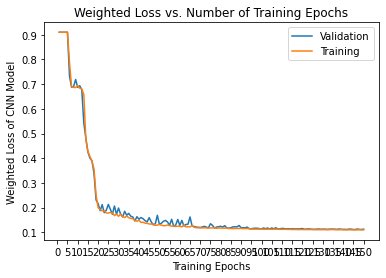




Fold- 1 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.638436, dice: 0.931909, loss: 0.902561


num_epochs:   1%|▍                                                                   | 1/150 [00:28<1:11:29, 28.79s/it]

val: bce: 0.638392, dice: 0.931660, loss: 0.902333
saving best model
Total time: 0:00:28.790368
Epoch time: 0m 29s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.638320, dice: 0.931910, loss: 0.902551


num_epochs:   1%|▉                                                                   | 2/150 [00:57<1:11:06, 28.82s/it]

val: bce: 0.638275, dice: 0.931661, loss: 0.902322
saving best model
Total time: 0:00:57.641194
Epoch time: 0m 29s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.638201, dice: 0.931910, loss: 0.902539


num_epochs:   2%|█▎                                                                  | 3/150 [01:26<1:10:31, 28.79s/it]

val: bce: 0.638153, dice: 0.931662, loss: 0.902311
saving best model
Total time: 0:01:26.387861
Epoch time: 0m 29s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.638076, dice: 0.931911, loss: 0.902528


num_epochs:   3%|█▊                                                                  | 4/150 [01:55<1:09:59, 28.76s/it]

val: bce: 0.638026, dice: 0.931663, loss: 0.902299
saving best model
Total time: 0:01:55.104768
Epoch time: 0m 29s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.637944, dice: 0.931912, loss: 0.902516


num_epochs:   3%|██▎                                                                 | 5/150 [02:23<1:09:30, 28.76s/it]

val: bce: 0.637888, dice: 0.931664, loss: 0.902286
saving best model
Total time: 0:02:23.865323
Epoch time: 0m 29s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.319377, dice: 0.850054, loss: 0.796987


num_epochs:   4%|██▋                                                                 | 6/150 [02:52<1:09:05, 28.79s/it]

val: bce: 0.183878, dice: 0.821347, loss: 0.757600
saving best model
Total time: 0:02:52.711686
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.137711, dice: 0.757539, loss: 0.695556


num_epochs:   5%|███▏                                                                | 7/150 [03:21<1:08:36, 28.78s/it]

val: bce: 0.142605, dice: 0.754859, loss: 0.693634
saving best model
Total time: 0:03:21.485137
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.144911, dice: 0.753636, loss: 0.692764


num_epochs:   5%|███▋                                                                | 8/150 [03:50<1:08:07, 28.79s/it]

val: bce: 0.137843, dice: 0.751533, loss: 0.690164
saving best model
Total time: 0:03:50.281900
Epoch time: 0m 29s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.142508, dice: 0.750481, loss: 0.689684


num_epochs:   6%|████                                                                | 9/150 [04:19<1:07:40, 28.80s/it]

val: bce: 0.147423, dice: 0.746556, loss: 0.686643
saving best model
Total time: 0:04:19.104951
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.142856, dice: 0.747522, loss: 0.687055


num_epochs:   7%|████▍                                                              | 10/150 [04:47<1:07:14, 28.82s/it]

val: bce: 0.139437, dice: 0.754346, loss: 0.692855
Total time: 0:04:47.966193
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.143475, dice: 0.747545, loss: 0.687138


num_epochs:   7%|████▉                                                              | 11/150 [05:16<1:06:43, 28.80s/it]

val: bce: 0.146904, dice: 0.743700, loss: 0.684020
saving best model
Total time: 0:05:16.732204
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.105360, dice: 0.617136, loss: 0.565958


num_epochs:   8%|█████▎                                                             | 12/150 [05:45<1:06:14, 28.80s/it]

val: bce: 0.300857, dice: 0.549080, loss: 0.524258
saving best model
Total time: 0:05:45.532440
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.079933, dice: 0.517071, loss: 0.473357


num_epochs:   9%|█████▊                                                             | 13/150 [06:14<1:05:41, 28.77s/it]

val: bce: 0.077661, dice: 0.500404, loss: 0.458130
saving best model
Total time: 0:06:14.237442
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.068153, dice: 0.484967, loss: 0.443285


num_epochs:   9%|██████▎                                                            | 14/150 [06:43<1:05:14, 28.78s/it]

val: bce: 0.090619, dice: 0.478746, loss: 0.439934
saving best model
Total time: 0:06:43.036685
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.076773, dice: 0.474086, loss: 0.434355


num_epochs:  10%|██████▋                                                            | 15/150 [07:11<1:04:45, 28.78s/it]

val: bce: 0.066741, dice: 0.467954, loss: 0.427833
saving best model
Total time: 0:07:11.817576
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.085758, dice: 0.457730, loss: 0.420533


num_epochs:  11%|███████▏                                                           | 16/150 [07:40<1:04:18, 28.79s/it]

val: bce: 0.083191, dice: 0.462605, loss: 0.424664
saving best model
Total time: 0:07:40.636163
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.102274, dice: 0.425528, loss: 0.393203


num_epochs:  11%|███████▌                                                           | 17/150 [08:09<1:03:52, 28.81s/it]

val: bce: 0.102125, dice: 0.465192, loss: 0.428885
Total time: 0:08:09.502366
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.123798, dice: 0.403999, loss: 0.375979


num_epochs:  12%|████████                                                           | 18/150 [08:38<1:03:22, 28.81s/it]

val: bce: 0.101054, dice: 0.387657, loss: 0.358996
saving best model
Total time: 0:08:38.303593
Epoch time: 0m 29s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.168795, dice: 0.362024, loss: 0.342701


num_epochs:  13%|████████▍                                                          | 19/150 [09:07<1:02:57, 28.84s/it]

val: bce: 0.369054, dice: 0.295244, loss: 0.302625
saving best model
Total time: 0:09:07.205011
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.168008, dice: 0.215698, loss: 0.210929


num_epochs:  13%|████████▉                                                          | 20/150 [09:36<1:02:27, 28.83s/it]

val: bce: 0.085345, dice: 0.192323, loss: 0.181625
saving best model
Total time: 0:09:36.014670
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.081694, dice: 0.182850, loss: 0.172735


num_epochs:  14%|█████████▍                                                         | 21/150 [10:04<1:01:55, 28.80s/it]

val: bce: 0.079385, dice: 0.176058, loss: 0.166391
saving best model
Total time: 0:10:04.756873
Epoch time: 0m 29s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.076322, dice: 0.174443, loss: 0.164631


num_epochs:  15%|█████████▊                                                         | 22/150 [10:33<1:01:27, 28.81s/it]

val: bce: 0.074041, dice: 0.173283, loss: 0.163358
saving best model
Total time: 0:10:33.566532
Epoch time: 0m 29s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.073577, dice: 0.172837, loss: 0.162911


num_epochs:  15%|██████████▎                                                        | 23/150 [11:02<1:00:58, 28.81s/it]

val: bce: 0.088801, dice: 0.190598, loss: 0.180419
Total time: 0:11:02.383134
Epoch time: 0m 29s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.075255, dice: 0.177348, loss: 0.167139


num_epochs:  16%|██████████▋                                                        | 24/150 [11:31<1:00:31, 28.82s/it]

val: bce: 0.086256, dice: 0.181815, loss: 0.172260
Total time: 0:11:31.223050
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.068221, dice: 0.167612, loss: 0.157673


num_epochs:  17%|███████████▏                                                       | 25/150 [12:00<1:00:02, 28.82s/it]

val: bce: 0.087856, dice: 0.188144, loss: 0.178115
Total time: 0:12:00.036183
Epoch time: 0m 29s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.069664, dice: 0.167805, loss: 0.157991


num_epochs:  17%|███████████▉                                                         | 26/150 [12:28<59:31, 28.80s/it]

val: bce: 0.108681, dice: 0.208555, loss: 0.198568
Total time: 0:12:28.805168
Epoch time: 0m 29s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.069166, dice: 0.167378, loss: 0.157557


num_epochs:  18%|████████████▍                                                        | 27/150 [12:57<59:03, 28.81s/it]

val: bce: 0.066582, dice: 0.160285, loss: 0.150915
saving best model
Total time: 0:12:57.625243
Epoch time: 0m 29s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.064181, dice: 0.158741, loss: 0.149285


num_epochs:  19%|████████████▉                                                        | 28/150 [13:26<58:31, 28.79s/it]

val: bce: 0.068146, dice: 0.164435, loss: 0.154806
Total time: 0:13:26.360005
Epoch time: 0m 29s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.065125, dice: 0.160193, loss: 0.150686


num_epochs:  19%|█████████████▎                                                       | 29/150 [13:55<58:00, 28.77s/it]

val: bce: 0.068988, dice: 0.163996, loss: 0.154495
Total time: 0:13:55.079889
Epoch time: 0m 29s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.062827, dice: 0.155518, loss: 0.146249


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:23<57:33, 28.78s/it]

val: bce: 0.065377, dice: 0.156973, loss: 0.147813
saving best model
Total time: 0:14:23.881611
Epoch time: 0m 29s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.061349, dice: 0.153998, loss: 0.144733


num_epochs:  21%|██████████████▎                                                      | 31/150 [14:52<57:06, 28.80s/it]

val: bce: 0.073271, dice: 0.170478, loss: 0.160757
Total time: 0:14:52.721526
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.061741, dice: 0.155288, loss: 0.145934


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:21<56:37, 28.79s/it]

val: bce: 0.068728, dice: 0.163684, loss: 0.154188
Total time: 0:15:21.501425
Epoch time: 0m 29s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.061709, dice: 0.155180, loss: 0.145833


num_epochs:  22%|███████████████▏                                                     | 33/150 [15:50<56:04, 28.76s/it]

val: bce: 0.063087, dice: 0.156038, loss: 0.146743
saving best model
Total time: 0:15:50.185596
Epoch time: 0m 29s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.058652, dice: 0.149293, loss: 0.140228


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:18<55:34, 28.75s/it]

val: bce: 0.090842, dice: 0.186820, loss: 0.177222
Total time: 0:16:18.913911
Epoch time: 0m 29s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.057261, dice: 0.147308, loss: 0.138304


num_epochs:  23%|████████████████                                                     | 35/150 [16:47<55:08, 28.77s/it]

val: bce: 0.067527, dice: 0.163897, loss: 0.154260
Total time: 0:16:47.720098
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.056746, dice: 0.145825, loss: 0.136917


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:16<54:39, 28.77s/it]

val: bce: 0.078865, dice: 0.164438, loss: 0.155881
Total time: 0:17:16.492060
Epoch time: 0m 29s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.054620, dice: 0.141738, loss: 0.133027


num_epochs:  25%|█████████████████                                                    | 37/150 [17:45<54:08, 28.75s/it]

val: bce: 0.074066, dice: 0.163632, loss: 0.154676
Total time: 0:17:45.192599
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.052248, dice: 0.138647, loss: 0.130007


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:14<53:43, 28.78s/it]

val: bce: 0.092573, dice: 0.183885, loss: 0.174754
Total time: 0:18:14.041046
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.054702, dice: 0.141297, loss: 0.132637


num_epochs:  26%|█████████████████▉                                                   | 39/150 [18:42<53:14, 28.78s/it]

val: bce: 0.056219, dice: 0.154684, loss: 0.144837
saving best model
Total time: 0:18:42.820451
Epoch time: 0m 29s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.052154, dice: 0.136520, loss: 0.128083


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:11<52:47, 28.80s/it]

val: bce: 0.054391, dice: 0.140215, loss: 0.131633
saving best model
Total time: 0:19:11.654412
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.051478, dice: 0.135359, loss: 0.126971


num_epochs:  27%|██████████████████▊                                                  | 41/150 [19:40<52:19, 28.80s/it]

val: bce: 0.054485, dice: 0.139133, loss: 0.130668
saving best model
Total time: 0:19:40.463079
Epoch time: 0m 29s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.050991, dice: 0.133234, loss: 0.125010


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:09<51:51, 28.81s/it]

val: bce: 0.062150, dice: 0.145391, loss: 0.137067
Total time: 0:20:09.313410
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.050624, dice: 0.133601, loss: 0.125303


num_epochs:  29%|███████████████████▊                                                 | 43/150 [20:38<51:23, 28.82s/it]

val: bce: 0.073129, dice: 0.167086, loss: 0.157690
Total time: 0:20:38.143900
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.050563, dice: 0.134062, loss: 0.125712


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:06<50:51, 28.79s/it]

val: bce: 0.057455, dice: 0.147868, loss: 0.138826
Total time: 0:21:06.869239
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.048630, dice: 0.130045, loss: 0.121903


num_epochs:  30%|████████████████████▋                                                | 45/150 [21:35<50:21, 28.78s/it]

val: bce: 0.050333, dice: 0.130733, loss: 0.122693
saving best model
Total time: 0:21:35.625826
Epoch time: 0m 29s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.048346, dice: 0.128343, loss: 0.120343


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:04<49:53, 28.78s/it]

val: bce: 0.063309, dice: 0.150801, loss: 0.142052
Total time: 0:22:04.415645
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.049092, dice: 0.130521, loss: 0.122378


num_epochs:  31%|█████████████████████▌                                               | 47/150 [22:33<49:22, 28.76s/it]

val: bce: 0.057339, dice: 0.137596, loss: 0.129570
Total time: 0:22:33.131561
Epoch time: 0m 29s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.049083, dice: 0.130238, loss: 0.122122


num_epochs:  32%|██████████████████████                                               | 48/150 [23:01<48:53, 28.76s/it]

val: bce: 0.058163, dice: 0.138515, loss: 0.130480
Total time: 0:23:01.891619
Epoch time: 0m 29s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.049187, dice: 0.129379, loss: 0.121360


num_epochs:  33%|██████████████████████▌                                              | 49/150 [23:30<48:24, 28.76s/it]

val: bce: 0.048900, dice: 0.132284, loss: 0.123946
Total time: 0:23:30.641262
Epoch time: 0m 29s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.047170, dice: 0.127031, loss: 0.119045


num_epochs:  33%|███████████████████████                                              | 50/150 [23:59<47:56, 28.76s/it]

val: bce: 0.060797, dice: 0.141263, loss: 0.133217
Total time: 0:23:59.415209
Epoch time: 0m 29s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.048860, dice: 0.129698, loss: 0.121614


num_epochs:  34%|███████████████████████▍                                             | 51/150 [24:28<47:28, 28.77s/it]

val: bce: 0.051845, dice: 0.130772, loss: 0.122880
Total time: 0:24:28.211476
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.047793, dice: 0.126853, loss: 0.118947


num_epochs:  35%|███████████████████████▉                                             | 52/150 [24:57<47:00, 28.78s/it]

val: bce: 0.053207, dice: 0.132383, loss: 0.124465
Total time: 0:24:57.020639
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.047149, dice: 0.126898, loss: 0.118923


num_epochs:  35%|████████████████████████▍                                            | 53/150 [25:25<46:32, 28.79s/it]

val: bce: 0.070193, dice: 0.155301, loss: 0.146791
Total time: 0:25:25.833274
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.050695, dice: 0.132818, loss: 0.124606


num_epochs:  36%|████████████████████████▊                                            | 54/150 [25:54<46:05, 28.81s/it]

val: bce: 0.072359, dice: 0.156748, loss: 0.148309
Epoch    49: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:25:54.679636
Epoch time: 0m 29s


----------
Epoch 54/149
LR 0.00025
train: bce: 0.046131, dice: 0.124795, loss: 0.116928


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:23<45:35, 28.79s/it]

val: bce: 0.047404, dice: 0.126075, loss: 0.118208
saving best model
Total time: 0:26:23.442176
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.00025
train: bce: 0.045953, dice: 0.123956, loss: 0.116155


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [26:52<45:08, 28.81s/it]

val: bce: 0.046406, dice: 0.124639, loss: 0.116816
saving best model
Total time: 0:26:52.290026
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.00025
train: bce: 0.045308, dice: 0.122671, loss: 0.114935


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:21<44:40, 28.82s/it]

val: bce: 0.045420, dice: 0.122533, loss: 0.114822
saving best model
Total time: 0:27:21.142341
Epoch time: 0m 29s


----------
Epoch 57/149
LR 0.00025
train: bce: 0.045136, dice: 0.122323, loss: 0.114605


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [27:49<44:11, 28.83s/it]

val: bce: 0.047719, dice: 0.126001, loss: 0.118172
Total time: 0:27:49.974320
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.00025
train: bce: 0.044982, dice: 0.122786, loss: 0.115006


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:18<43:42, 28.81s/it]

val: bce: 0.045680, dice: 0.122189, loss: 0.114538
saving best model
Total time: 0:28:18.758683
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.00025
train: bce: 0.045147, dice: 0.122181, loss: 0.114477


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [28:47<43:13, 28.82s/it]

val: bce: 0.046797, dice: 0.123124, loss: 0.115491
Total time: 0:28:47.595126
Epoch time: 0m 29s


----------
Epoch 60/149
LR 0.00025
train: bce: 0.044448, dice: 0.121638, loss: 0.113919


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:16<42:43, 28.81s/it]

val: bce: 0.050541, dice: 0.131663, loss: 0.123551
Total time: 0:29:16.373040
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.00025
train: bce: 0.045497, dice: 0.123367, loss: 0.115580


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [29:45<42:13, 28.79s/it]

val: bce: 0.046473, dice: 0.123513, loss: 0.115809
Total time: 0:29:45.120204
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.00025
train: bce: 0.044794, dice: 0.121898, loss: 0.114188


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:13<41:44, 28.79s/it]

val: bce: 0.048917, dice: 0.126446, loss: 0.118694
Total time: 0:30:13.901094
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.00025
train: bce: 0.044234, dice: 0.121250, loss: 0.113549


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [30:42<41:14, 28.77s/it]

val: bce: 0.052028, dice: 0.132568, loss: 0.124514
Total time: 0:30:42.633377
Epoch time: 0m 29s


----------
Epoch 64/149
LR 0.00025
train: bce: 0.045612, dice: 0.122812, loss: 0.115092


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [31:11<40:45, 28.78s/it]

val: bce: 0.050654, dice: 0.128051, loss: 0.120311
Total time: 0:31:11.421709
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.00025
train: bce: 0.045080, dice: 0.122070, loss: 0.114371


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [31:40<40:16, 28.77s/it]

val: bce: 0.044905, dice: 0.120714, loss: 0.113133
saving best model
Total time: 0:31:40.179783
Epoch time: 0m 29s


----------
Epoch 66/149
LR 0.00025
train: bce: 0.044305, dice: 0.121414, loss: 0.113703


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [32:08<39:48, 28.77s/it]

val: bce: 0.047515, dice: 0.123638, loss: 0.116026
Total time: 0:32:08.954226
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.00025
train: bce: 0.044725, dice: 0.121359, loss: 0.113695


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [32:37<39:16, 28.73s/it]

val: bce: 0.055201, dice: 0.138858, loss: 0.130492
Total time: 0:32:37.601197
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.00025
train: bce: 0.045657, dice: 0.123246, loss: 0.115487


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [33:06<38:52, 28.80s/it]

val: bce: 0.048058, dice: 0.123558, loss: 0.116008
Total time: 0:33:06.546264
Epoch time: 0m 29s


----------
Epoch 69/149
LR 0.00025
train: bce: 0.043867, dice: 0.120262, loss: 0.112622


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [33:35<38:22, 28.78s/it]

val: bce: 0.043384, dice: 0.119903, loss: 0.112251
saving best model
Total time: 0:33:35.293922
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.00025
train: bce: 0.044305, dice: 0.120266, loss: 0.112670


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [34:04<37:54, 28.79s/it]

val: bce: 0.045762, dice: 0.125986, loss: 0.117964
Total time: 0:34:04.099117
Epoch time: 0m 29s


----------
Epoch 71/149
LR 0.00025
train: bce: 0.043993, dice: 0.119995, loss: 0.112395


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [34:32<37:24, 28.78s/it]

val: bce: 0.044578, dice: 0.119594, loss: 0.112093
saving best model
Total time: 0:34:32.842312
Epoch time: 0m 29s


----------
Epoch 72/149
LR 0.00025
train: bce: 0.043311, dice: 0.119689, loss: 0.112051


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [35:01<36:56, 28.79s/it]

val: bce: 0.047198, dice: 0.124896, loss: 0.117126
Total time: 0:35:01.672803
Epoch time: 0m 29s


----------
Epoch 73/149
LR 0.00025
train: bce: 0.043941, dice: 0.119698, loss: 0.112123


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [35:30<36:28, 28.79s/it]

val: bce: 0.043580, dice: 0.119609, loss: 0.112006
saving best model
Total time: 0:35:30.463118
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.00025
train: bce: 0.043654, dice: 0.119158, loss: 0.111607


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [35:59<35:59, 28.79s/it]

val: bce: 0.053095, dice: 0.129480, loss: 0.121841
Total time: 0:35:59.238553
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.00025
train: bce: 0.044132, dice: 0.120192, loss: 0.112586


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [36:27<35:27, 28.76s/it]

val: bce: 0.048385, dice: 0.124441, loss: 0.116835
Total time: 0:36:27.920244
Epoch time: 0m 29s


----------
Epoch 76/149
LR 0.00025
train: bce: 0.043642, dice: 0.119810, loss: 0.112193


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [36:56<34:58, 28.75s/it]

val: bce: 0.050334, dice: 0.129343, loss: 0.121442
Total time: 0:36:56.668398
Epoch time: 0m 29s


----------
Epoch 77/149
LR 0.00025
train: bce: 0.044363, dice: 0.120673, loss: 0.113042


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [37:25<34:32, 28.79s/it]

val: bce: 0.043226, dice: 0.118451, loss: 0.110928
saving best model
Total time: 0:37:25.547497
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.00025
train: bce: 0.043095, dice: 0.118210, loss: 0.110699


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [37:54<34:06, 28.82s/it]

val: bce: 0.045571, dice: 0.120111, loss: 0.112657
Total time: 0:37:54.446436
Epoch time: 0m 29s


----------
Epoch 79/149
LR 0.00025
train: bce: 0.042688, dice: 0.118311, loss: 0.110749


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:23<33:33, 28.77s/it]

val: bce: 0.056960, dice: 0.133157, loss: 0.125537
Total time: 0:38:23.084479
Epoch time: 0m 29s


----------
Epoch 80/149
LR 0.00025
train: bce: 0.043787, dice: 0.119556, loss: 0.111979


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [38:51<33:04, 28.76s/it]

val: bce: 0.049030, dice: 0.123924, loss: 0.116435
Total time: 0:38:51.832138
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.00025
train: bce: 0.043787, dice: 0.119506, loss: 0.111934


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:20<32:34, 28.75s/it]

val: bce: 0.046592, dice: 0.123841, loss: 0.116116
Total time: 0:39:20.538629
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.00025
train: bce: 0.042793, dice: 0.117886, loss: 0.110376


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [39:49<32:07, 28.76s/it]

val: bce: 0.044644, dice: 0.119268, loss: 0.111806
Total time: 0:39:49.342336
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.00025
train: bce: 0.043005, dice: 0.117489, loss: 0.110040


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [40:18<31:39, 28.78s/it]

val: bce: 0.045481, dice: 0.122645, loss: 0.114929
Total time: 0:40:18.163403
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.00025
train: bce: 0.042996, dice: 0.118499, loss: 0.110949


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [40:46<31:11, 28.79s/it]

val: bce: 0.043874, dice: 0.118056, loss: 0.110638
saving best model
Total time: 0:40:46.960166
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.00025
train: bce: 0.042624, dice: 0.117136, loss: 0.109685


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [41:15<30:42, 28.80s/it]

val: bce: 0.046340, dice: 0.129034, loss: 0.120764
Total time: 0:41:15.780736
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.00025
train: bce: 0.043620, dice: 0.118920, loss: 0.111390


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [41:44<30:13, 28.78s/it]

val: bce: 0.059294, dice: 0.139625, loss: 0.131592
Total time: 0:41:44.534843
Epoch time: 0m 29s


----------
Epoch 87/149
LR 0.00025
train: bce: 0.044090, dice: 0.119397, loss: 0.111866


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [42:13<29:44, 28.79s/it]

val: bce: 0.050038, dice: 0.130550, loss: 0.122499
Total time: 0:42:13.331110
Epoch time: 0m 29s


----------
Epoch 88/149
LR 0.00025
train: bce: 0.042865, dice: 0.117623, loss: 0.110147


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [42:42<29:14, 28.77s/it]

val: bce: 0.048443, dice: 0.124637, loss: 0.117018
Total time: 0:42:42.057937
Epoch time: 0m 29s


----------
Epoch 89/149
LR 0.00025
train: bce: 0.042284, dice: 0.117344, loss: 0.109838


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [43:10<28:46, 28.78s/it]

val: bce: 0.049088, dice: 0.126107, loss: 0.118405
Total time: 0:43:10.852716
Epoch time: 0m 29s


----------
Epoch 90/149
LR 0.00025
train: bce: 0.043212, dice: 0.118213, loss: 0.110713


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [43:39<28:18, 28.78s/it]

val: bce: 0.042597, dice: 0.119188, loss: 0.111529
Total time: 0:43:39.648983
Epoch time: 0m 29s


----------
Epoch 91/149
LR 0.00025
train: bce: 0.042096, dice: 0.116680, loss: 0.109222


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [44:08<27:50, 28.81s/it]

val: bce: 0.047551, dice: 0.129948, loss: 0.121708
Total time: 0:44:08.509730
Epoch time: 0m 29s


----------
Epoch 92/149
LR 0.00025
train: bce: 0.042739, dice: 0.117251, loss: 0.109800


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [44:37<27:21, 28.79s/it]

val: bce: 0.047241, dice: 0.122263, loss: 0.114761
Total time: 0:44:37.263837
Epoch time: 0m 29s


----------
Epoch 93/149
LR 0.00025
train: bce: 0.042427, dice: 0.117378, loss: 0.109883


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [45:06<26:53, 28.81s/it]

val: bce: 0.050294, dice: 0.126603, loss: 0.118972
Epoch    89: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:45:06.130536
Epoch time: 0m 29s


----------
Epoch 94/149
LR 0.000125
train: bce: 0.041883, dice: 0.115778, loss: 0.108389


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [45:34<26:23, 28.79s/it]

val: bce: 0.043142, dice: 0.117144, loss: 0.109744
saving best model
Total time: 0:45:34.857859
Epoch time: 0m 29s


----------
Epoch 95/149
LR 0.000125
train: bce: 0.041166, dice: 0.115185, loss: 0.107783


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [46:03<25:54, 28.78s/it]

val: bce: 0.041778, dice: 0.114634, loss: 0.107348
saving best model
Total time: 0:46:03.621389
Epoch time: 0m 29s


----------
Epoch 96/149
LR 0.000125
train: bce: 0.041290, dice: 0.114601, loss: 0.107270


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [46:32<25:24, 28.77s/it]

val: bce: 0.041753, dice: 0.114753, loss: 0.107453
Total time: 0:46:32.374505
Epoch time: 0m 29s


----------
Epoch 97/149
LR 0.000125
train: bce: 0.041666, dice: 0.115018, loss: 0.107683


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [47:01<24:56, 28.79s/it]

val: bce: 0.043094, dice: 0.116213, loss: 0.108901
Total time: 0:47:01.194579
Epoch time: 0m 29s


----------
Epoch 98/149
LR 0.000125
train: bce: 0.041420, dice: 0.114960, loss: 0.107606


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [47:29<24:25, 28.74s/it]

val: bce: 0.044208, dice: 0.120026, loss: 0.112444
Total time: 0:47:29.828158
Epoch time: 0m 29s


----------
Epoch 99/149
LR 0.000125
train: bce: 0.041820, dice: 0.115366, loss: 0.108011


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [47:58<23:58, 28.76s/it]

val: bce: 0.043224, dice: 0.116437, loss: 0.109115
Total time: 0:47:58.646745
Epoch time: 0m 29s


----------
Epoch 100/149
LR 0.000125
train: bce: 0.041069, dice: 0.114656, loss: 0.107298


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [48:27<23:29, 28.76s/it]

val: bce: 0.042284, dice: 0.115465, loss: 0.108146
Total time: 0:48:27.389940
Epoch time: 0m 29s


----------
Epoch 101/149
LR 0.000125
train: bce: 0.041416, dice: 0.114349, loss: 0.107056


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [48:56<23:00, 28.76s/it]

val: bce: 0.045121, dice: 0.121766, loss: 0.114101
Total time: 0:48:56.165871
Epoch time: 0m 29s


----------
Epoch 102/149
LR 0.000125
train: bce: 0.041668, dice: 0.115337, loss: 0.107970


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [49:24<22:31, 28.75s/it]

val: bce: 0.042415, dice: 0.116731, loss: 0.109300
Total time: 0:49:24.873353
Epoch time: 0m 29s


----------
Epoch 103/149
LR 0.000125
train: bce: 0.041053, dice: 0.114243, loss: 0.106924


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [49:53<22:02, 28.75s/it]

val: bce: 0.043910, dice: 0.118222, loss: 0.110791
Total time: 0:49:53.617046
Epoch time: 0m 29s


----------
Epoch 104/149
LR 0.000125
train: bce: 0.041331, dice: 0.114368, loss: 0.107065


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [50:22<21:32, 28.73s/it]

val: bce: 0.042642, dice: 0.114816, loss: 0.107598
Epoch   100: reducing learning rate of group 0 to 6.2500e-05.
Total time: 0:50:22.295264
Epoch time: 0m 29s


----------
Epoch 105/149
LR 6.25e-05
train: bce: 0.040825, dice: 0.114112, loss: 0.106783


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [50:51<21:04, 28.73s/it]

val: bce: 0.042446, dice: 0.114143, loss: 0.106973
saving best model
Total time: 0:50:51.033994
Epoch time: 0m 29s


----------
Epoch 106/149
LR 6.25e-05
train: bce: 0.040876, dice: 0.113460, loss: 0.106202


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [51:19<20:36, 28.75s/it]

val: bce: 0.042255, dice: 0.114068, loss: 0.106887
saving best model
Total time: 0:51:19.815877
Epoch time: 0m 29s


----------
Epoch 107/149
LR 6.25e-05
train: bce: 0.040667, dice: 0.113381, loss: 0.106109


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [51:48<20:07, 28.75s/it]

val: bce: 0.042484, dice: 0.114908, loss: 0.107666
Total time: 0:51:48.574944
Epoch time: 0m 29s


----------
Epoch 108/149
LR 6.25e-05
train: bce: 0.040885, dice: 0.114262, loss: 0.106925


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [52:17<19:39, 28.77s/it]

val: bce: 0.046301, dice: 0.121917, loss: 0.114356
Total time: 0:52:17.390059
Epoch time: 0m 29s


----------
Epoch 109/149
LR 6.25e-05
train: bce: 0.041543, dice: 0.114824, loss: 0.107496


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [52:46<19:11, 28.79s/it]

val: bce: 0.043899, dice: 0.116244, loss: 0.109009
Total time: 0:52:46.213110
Epoch time: 0m 29s


----------
Epoch 110/149
LR 6.25e-05
train: bce: 0.040454, dice: 0.113434, loss: 0.106136


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [53:14<18:42, 28.78s/it]

val: bce: 0.041517, dice: 0.113830, loss: 0.106599
saving best model
Total time: 0:53:14.985073
Epoch time: 0m 29s


----------
Epoch 111/149
LR 6.25e-05
train: bce: 0.040678, dice: 0.113440, loss: 0.106164


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [53:43<18:13, 28.79s/it]

val: bce: 0.042035, dice: 0.115041, loss: 0.107740
Total time: 0:53:43.790763
Epoch time: 0m 29s


----------
Epoch 112/149
LR 6.25e-05
train: bce: 0.040624, dice: 0.113464, loss: 0.106180


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [54:12<17:45, 28.79s/it]

val: bce: 0.042005, dice: 0.113975, loss: 0.106778
Total time: 0:54:12.580086
Epoch time: 0m 29s


----------
Epoch 113/149
LR 6.25e-05
train: bce: 0.040778, dice: 0.113344, loss: 0.106087


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [54:41<17:15, 28.78s/it]

val: bce: 0.041758, dice: 0.114026, loss: 0.106800
Total time: 0:54:41.330225
Epoch time: 0m 29s


----------
Epoch 114/149
LR 6.25e-05
train: bce: 0.040604, dice: 0.113473, loss: 0.106186


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [55:10<16:46, 28.77s/it]

val: bce: 0.041388, dice: 0.113348, loss: 0.106152
saving best model
Total time: 0:55:10.078381
Epoch time: 0m 29s


----------
Epoch 115/149
LR 6.25e-05
train: bce: 0.040560, dice: 0.113068, loss: 0.105817


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [55:38<16:17, 28.76s/it]

val: bce: 0.041419, dice: 0.113196, loss: 0.106019
saving best model
Total time: 0:55:38.818103
Epoch time: 0m 29s


----------
Epoch 116/149
LR 6.25e-05
train: bce: 0.040707, dice: 0.112916, loss: 0.105695


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [56:07<15:48, 28.75s/it]

val: bce: 0.041373, dice: 0.113397, loss: 0.106194
Total time: 0:56:07.550386
Epoch time: 0m 29s


----------
Epoch 117/149
LR 6.25e-05
train: bce: 0.040506, dice: 0.113308, loss: 0.106028


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [56:36<15:20, 28.76s/it]

val: bce: 0.041057, dice: 0.113161, loss: 0.105950
saving best model
Total time: 0:56:36.343181
Epoch time: 0m 29s


----------
Epoch 118/149
LR 6.25e-05
train: bce: 0.040414, dice: 0.113033, loss: 0.105771


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [57:05<14:51, 28.76s/it]

val: bce: 0.042125, dice: 0.114181, loss: 0.106976
Total time: 0:57:05.089848
Epoch time: 0m 29s


----------
Epoch 119/149
LR 6.25e-05
train: bce: 0.040409, dice: 0.112729, loss: 0.105497


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [57:33<14:22, 28.76s/it]

val: bce: 0.041198, dice: 0.113787, loss: 0.106528
Total time: 0:57:33.863299
Epoch time: 0m 29s


----------
Epoch 120/149
LR 6.25e-05
train: bce: 0.040152, dice: 0.112801, loss: 0.105536


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [58:02<13:54, 28.78s/it]

val: bce: 0.041793, dice: 0.113844, loss: 0.106639
Total time: 0:58:02.686845
Epoch time: 0m 29s


----------
Epoch 121/149
LR 6.25e-05
train: bce: 0.040393, dice: 0.112764, loss: 0.105527


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [58:31<13:26, 28.81s/it]

val: bce: 0.041469, dice: 0.113230, loss: 0.106054
Total time: 0:58:31.557016
Epoch time: 0m 29s


----------
Epoch 122/149
LR 6.25e-05
train: bce: 0.040444, dice: 0.112700, loss: 0.105474


num_epochs:  82%|███████████████████████████████████████████████████████▊            | 123/150 [59:00<12:57, 28.80s/it]

val: bce: 0.041454, dice: 0.112855, loss: 0.105715
saving best model
Total time: 0:59:00.351299
Epoch time: 0m 29s


----------
Epoch 123/149
LR 6.25e-05
train: bce: 0.040438, dice: 0.112871, loss: 0.105628


num_epochs:  83%|████████████████████████████████████████████████████████▏           | 124/150 [59:29<12:28, 28.80s/it]

val: bce: 0.041585, dice: 0.114094, loss: 0.106843
Total time: 0:59:29.136159
Epoch time: 0m 29s


----------
Epoch 124/149
LR 6.25e-05
train: bce: 0.040631, dice: 0.112722, loss: 0.105513


num_epochs:  83%|████████████████████████████████████████████████████████▋           | 125/150 [59:57<11:59, 28.80s/it]

val: bce: 0.041096, dice: 0.113177, loss: 0.105969
Total time: 0:59:57.939865
Epoch time: 0m 29s


----------
Epoch 125/149
LR 6.25e-05
train: bce: 0.040267, dice: 0.112749, loss: 0.105500


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:00:26<11:30, 28.78s/it]

val: bce: 0.041446, dice: 0.113913, loss: 0.106666
Total time: 1:00:26.673140
Epoch time: 0m 29s


----------
Epoch 126/149
LR 6.25e-05
train: bce: 0.040521, dice: 0.112804, loss: 0.105576


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:00:55<11:01, 28.77s/it]

val: bce: 0.042438, dice: 0.116252, loss: 0.108871
Total time: 1:00:55.403936
Epoch time: 0m 29s


----------
Epoch 127/149
LR 6.25e-05
train: bce: 0.040693, dice: 0.113239, loss: 0.105985


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:01:24<10:32, 28.77s/it]

val: bce: 0.041567, dice: 0.113015, loss: 0.105870
Total time: 1:01:24.170938
Epoch time: 0m 29s


----------
Epoch 128/149
LR 6.25e-05
train: bce: 0.040430, dice: 0.112665, loss: 0.105441


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:01:52<10:04, 28.77s/it]

val: bce: 0.042443, dice: 0.114752, loss: 0.107521
Total time: 1:01:52.944388
Epoch time: 0m 29s


----------
Epoch 129/149
LR 6.25e-05
train: bce: 0.040093, dice: 0.112454, loss: 0.105218


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:02:21<09:35, 28.76s/it]

val: bce: 0.041646, dice: 0.112709, loss: 0.105602
saving best model
Total time: 1:02:21.675183
Epoch time: 0m 29s


----------
Epoch 130/149
LR 6.25e-05
train: bce: 0.040539, dice: 0.112611, loss: 0.105403


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:02:50<09:06, 28.75s/it]

val: bce: 0.042916, dice: 0.114392, loss: 0.107244
Total time: 1:02:50.403002
Epoch time: 0m 29s


----------
Epoch 131/149
LR 6.25e-05
train: bce: 0.040653, dice: 0.113153, loss: 0.105903


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:03:19<08:37, 28.75s/it]

val: bce: 0.041713, dice: 0.113477, loss: 0.106301
Total time: 1:03:19.149669
Epoch time: 0m 29s


----------
Epoch 132/149
LR 6.25e-05
train: bce: 0.040573, dice: 0.112733, loss: 0.105517


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:03:47<08:08, 28.75s/it]

val: bce: 0.044954, dice: 0.116833, loss: 0.109645
Total time: 1:03:47.901296
Epoch time: 0m 29s


----------
Epoch 133/149
LR 6.25e-05
train: bce: 0.040505, dice: 0.112995, loss: 0.105746


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:04:16<07:40, 28.75s/it]

val: bce: 0.041169, dice: 0.112830, loss: 0.105664
Total time: 1:04:16.662843
Epoch time: 0m 29s


----------
Epoch 134/149
LR 6.25e-05
train: bce: 0.040047, dice: 0.112256, loss: 0.105035


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:04:45<07:11, 28.76s/it]

val: bce: 0.041284, dice: 0.112595, loss: 0.105464
saving best model
Total time: 1:04:45.424390
Epoch time: 0m 29s


----------
Epoch 135/149
LR 6.25e-05
train: bce: 0.040310, dice: 0.112300, loss: 0.105101


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:05:14<06:42, 28.73s/it]

val: bce: 0.040731, dice: 0.112694, loss: 0.105497
Total time: 1:05:14.104097
Epoch time: 0m 29s


----------
Epoch 136/149
LR 6.25e-05
train: bce: 0.040305, dice: 0.112398, loss: 0.105189


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:05:42<06:13, 28.72s/it]

val: bce: 0.041214, dice: 0.113704, loss: 0.106455
Total time: 1:05:42.786781
Epoch time: 0m 29s


----------
Epoch 137/149
LR 6.25e-05
train: bce: 0.040315, dice: 0.112482, loss: 0.105266


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:06:11<05:44, 28.73s/it]

val: bce: 0.041276, dice: 0.112594, loss: 0.105462
saving best model
Total time: 1:06:11.559239
Epoch time: 0m 29s


----------
Epoch 138/149
LR 6.25e-05
train: bce: 0.040142, dice: 0.112513, loss: 0.105276


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:06:40<05:16, 28.73s/it]

val: bce: 0.041365, dice: 0.112552, loss: 0.105433
saving best model
Total time: 1:06:40.284577
Epoch time: 0m 29s


----------
Epoch 139/149
LR 6.25e-05
train: bce: 0.040322, dice: 0.112222, loss: 0.105032


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:07:08<04:47, 28.72s/it]

val: bce: 0.041255, dice: 0.113020, loss: 0.105843
Total time: 1:07:08.966764
Epoch time: 0m 29s


----------
Epoch 140/149
LR 6.25e-05
train: bce: 0.040004, dice: 0.111919, loss: 0.104727


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:07:37<04:18, 28.72s/it]

val: bce: 0.044624, dice: 0.116001, loss: 0.108864
Total time: 1:07:37.689623
Epoch time: 0m 29s


----------
Epoch 141/149
LR 6.25e-05
train: bce: 0.040681, dice: 0.112698, loss: 0.105496


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:08:06<03:49, 28.71s/it]

val: bce: 0.041453, dice: 0.113133, loss: 0.105965
Total time: 1:08:06.367347
Epoch time: 0m 29s


----------
Epoch 142/149
LR 6.25e-05
train: bce: 0.040084, dice: 0.112106, loss: 0.104904


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:08:35<03:21, 28.72s/it]

val: bce: 0.042042, dice: 0.114278, loss: 0.107054
Total time: 1:08:35.133853
Epoch time: 0m 29s


----------
Epoch 143/149
LR 6.25e-05
train: bce: 0.040510, dice: 0.112285, loss: 0.105107


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:09:03<02:52, 28.74s/it]

val: bce: 0.041114, dice: 0.112443, loss: 0.105311
saving best model
Total time: 1:09:03.901848
Epoch time: 0m 29s


----------
Epoch 144/149
LR 6.25e-05
train: bce: 0.040069, dice: 0.112109, loss: 0.104905


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:09:32<02:23, 28.73s/it]

val: bce: 0.040962, dice: 0.113343, loss: 0.106105
Total time: 1:09:32.628675
Epoch time: 0m 29s


----------
Epoch 145/149
LR 6.25e-05
train: bce: 0.040139, dice: 0.112169, loss: 0.104966


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:10:01<01:54, 28.75s/it]

val: bce: 0.042289, dice: 0.113947, loss: 0.106781
Total time: 1:10:01.402622
Epoch time: 0m 29s


----------
Epoch 146/149
LR 6.25e-05
train: bce: 0.040119, dice: 0.111933, loss: 0.104752


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:10:30<01:26, 28.75s/it]

val: bce: 0.041636, dice: 0.112708, loss: 0.105600
Total time: 1:10:30.148297
Epoch time: 0m 29s


----------
Epoch 147/149
LR 6.25e-05
train: bce: 0.039924, dice: 0.111733, loss: 0.104552


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:10:58<00:57, 28.73s/it]

val: bce: 0.040931, dice: 0.112185, loss: 0.105060
saving best model
Total time: 1:10:58.827507
Epoch time: 0m 29s


----------
Epoch 148/149
LR 6.25e-05
train: bce: 0.039994, dice: 0.111605, loss: 0.104443


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:11:27<00:28, 28.74s/it]

val: bce: 0.040908, dice: 0.113358, loss: 0.106113
Total time: 1:11:27.608894
Epoch time: 0m 29s


----------
Epoch 149/149
LR 6.25e-05
train: bce: 0.040009, dice: 0.111729, loss: 0.104557


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:11:56<00:00, 28.78s/it]

val: bce: 0.041471, dice: 0.113182, loss: 0.106011
Total time: 1:11:56.396730
Epoch time: 0m 29s
Best val loss: 0.105060
model training finished, reinitializing training....



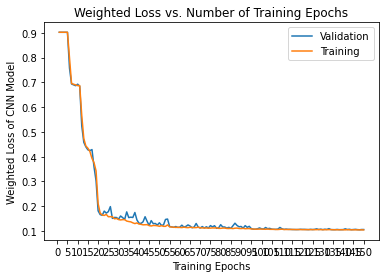




Fold- 2 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.689597, dice: 0.931343, loss: 0.907169


num_epochs:   1%|▍                                                                   | 1/150 [00:28<1:11:31, 28.80s/it]

val: bce: 0.689534, dice: 0.931488, loss: 0.907293
saving best model
Total time: 0:00:28.805194
Epoch time: 0m 29s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.689475, dice: 0.931344, loss: 0.907157


num_epochs:   1%|▉                                                                   | 2/150 [00:57<1:10:57, 28.77s/it]

val: bce: 0.689410, dice: 0.931489, loss: 0.907281
saving best model
Total time: 0:00:57.551861
Epoch time: 0m 29s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.689350, dice: 0.931345, loss: 0.907145


num_epochs:   2%|█▎                                                                  | 3/150 [01:26<1:10:28, 28.77s/it]

val: bce: 0.689283, dice: 0.931490, loss: 0.907269
saving best model
Total time: 0:01:26.316880
Epoch time: 0m 29s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.689221, dice: 0.931346, loss: 0.907133


num_epochs:   3%|█▊                                                                  | 4/150 [01:55<1:09:59, 28.76s/it]

val: bce: 0.689150, dice: 0.931490, loss: 0.907256
saving best model
Total time: 0:01:55.068507
Epoch time: 0m 29s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.689083, dice: 0.931347, loss: 0.907120


num_epochs:   3%|██▎                                                                 | 5/150 [02:23<1:09:26, 28.74s/it]

val: bce: 0.689006, dice: 0.931491, loss: 0.907243
saving best model
Total time: 0:02:23.765078
Epoch time: 0m 29s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.341685, dice: 0.846297, loss: 0.795836


num_epochs:   4%|██▋                                                                 | 6/150 [02:52<1:09:01, 28.76s/it]

val: bce: 0.198771, dice: 0.820720, loss: 0.758525
saving best model
Total time: 0:02:52.561840
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.144013, dice: 0.748606, loss: 0.688146


num_epochs:   5%|███▏                                                                | 7/150 [03:21<1:08:33, 28.76s/it]

val: bce: 0.145809, dice: 0.747054, loss: 0.686930
saving best model
Total time: 0:03:21.338764
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.147827, dice: 0.744918, loss: 0.685209


num_epochs:   5%|███▋                                                                | 8/150 [03:50<1:08:05, 28.77s/it]

val: bce: 0.218156, dice: 0.766109, loss: 0.711313
Total time: 0:03:50.132055
Epoch time: 0m 29s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.146082, dice: 0.743059, loss: 0.683361


num_epochs:   6%|████                                                                | 9/150 [04:18<1:07:35, 28.76s/it]

val: bce: 0.150943, dice: 0.744204, loss: 0.684878
saving best model
Total time: 0:04:18.870786
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.142841, dice: 0.740894, loss: 0.681088


num_epochs:   7%|████▍                                                              | 10/150 [04:47<1:07:10, 28.79s/it]

val: bce: 0.148163, dice: 0.739449, loss: 0.680320
saving best model
Total time: 0:04:47.713676
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.144006, dice: 0.738907, loss: 0.679417


num_epochs:   7%|████▉                                                              | 11/150 [05:16<1:06:41, 28.79s/it]

val: bce: 0.134914, dice: 0.747587, loss: 0.686320
Total time: 0:05:16.502007
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.138550, dice: 0.727383, loss: 0.668500


num_epochs:   8%|█████▎                                                             | 12/150 [05:45<1:06:13, 28.79s/it]

val: bce: 0.165020, dice: 0.762298, loss: 0.702571
Total time: 0:05:45.301250
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.089889, dice: 0.522924, loss: 0.479621


num_epochs:   9%|█████▊                                                             | 13/150 [06:14<1:05:41, 28.77s/it]

val: bce: 0.128831, dice: 0.515424, loss: 0.476765
saving best model
Total time: 0:06:14.020637
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.078508, dice: 0.498434, loss: 0.456441


num_epochs:   9%|██████▎                                                            | 14/150 [06:42<1:05:11, 28.76s/it]

val: bce: 0.064221, dice: 0.485010, loss: 0.442931
saving best model
Total time: 0:06:42.768791
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.059947, dice: 0.475886, loss: 0.434292


num_epochs:  10%|██████▋                                                            | 15/150 [07:11<1:04:43, 28.77s/it]

val: bce: 0.068597, dice: 0.469334, loss: 0.429260
saving best model
Total time: 0:07:11.542738
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.063772, dice: 0.457742, loss: 0.418345


num_epochs:  11%|███████▏                                                           | 16/150 [07:40<1:04:10, 28.74s/it]

val: bce: 0.062526, dice: 0.449335, loss: 0.410654
saving best model
Total time: 0:07:40.207070
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.081431, dice: 0.440902, loss: 0.404954


num_epochs:  11%|███████▌                                                           | 17/150 [08:08<1:03:42, 28.74s/it]

val: bce: 0.146048, dice: 0.447863, loss: 0.417681
Total time: 0:08:08.964152
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.097705, dice: 0.441961, loss: 0.407536


num_epochs:  12%|████████                                                           | 18/150 [08:37<1:03:16, 28.76s/it]

val: bce: 0.129515, dice: 0.429010, loss: 0.399061
saving best model
Total time: 0:08:37.759427
Epoch time: 0m 29s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.121395, dice: 0.452142, loss: 0.419068


num_epochs:  13%|████████▍                                                          | 19/150 [09:06<1:02:45, 28.75s/it]

val: bce: 0.081523, dice: 0.457780, loss: 0.420154
Total time: 0:09:06.478814
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.060196, dice: 0.442093, loss: 0.403904


num_epochs:  13%|████████▉                                                          | 20/150 [09:35<1:02:22, 28.79s/it]

val: bce: 0.072766, dice: 0.435365, loss: 0.399105
Total time: 0:09:35.366842
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.079945, dice: 0.409336, loss: 0.376397


num_epochs:  14%|█████████▍                                                         | 21/150 [10:04<1:01:50, 28.76s/it]

val: bce: 0.104156, dice: 0.368449, loss: 0.342019
saving best model
Total time: 0:10:04.075316
Epoch time: 0m 29s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.137179, dice: 0.339876, loss: 0.319606


num_epochs:  15%|█████████▊                                                         | 22/150 [10:32<1:01:20, 28.75s/it]

val: bce: 0.125385, dice: 0.248652, loss: 0.236326
saving best model
Total time: 0:10:32.796687
Epoch time: 0m 29s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.135054, dice: 0.234757, loss: 0.224787


num_epochs:  15%|██████████▎                                                        | 23/150 [11:01<1:00:55, 28.78s/it]

val: bce: 0.093027, dice: 0.216029, loss: 0.203729
saving best model
Total time: 0:11:01.654458
Epoch time: 0m 29s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.093770, dice: 0.219660, loss: 0.207071


num_epochs:  16%|██████████▋                                                        | 24/150 [11:30<1:00:26, 28.78s/it]

val: bce: 0.111293, dice: 0.240509, loss: 0.227588
Total time: 0:11:30.435845
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.088728, dice: 0.219888, loss: 0.206772


num_epochs:  17%|███████████▌                                                         | 25/150 [11:59<59:58, 28.79s/it]

val: bce: 0.086091, dice: 0.212398, loss: 0.199767
saving best model
Total time: 0:11:59.245503
Epoch time: 0m 29s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.084226, dice: 0.214375, loss: 0.201360


num_epochs:  17%|███████████▉                                                         | 26/150 [12:28<59:31, 28.80s/it]

val: bce: 0.096115, dice: 0.218843, loss: 0.206570
Total time: 0:12:28.063099
Epoch time: 0m 29s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.085337, dice: 0.210324, loss: 0.197825


num_epochs:  18%|████████████▍                                                        | 27/150 [12:56<58:58, 28.77s/it]

val: bce: 0.072076, dice: 0.212115, loss: 0.198111
saving best model
Total time: 0:12:56.771077
Epoch time: 0m 29s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.083757, dice: 0.210419, loss: 0.197753


num_epochs:  19%|████████████▉                                                        | 28/150 [13:25<58:30, 28.77s/it]

val: bce: 0.083348, dice: 0.232752, loss: 0.217812
Total time: 0:13:25.539568
Epoch time: 0m 29s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.082324, dice: 0.213691, loss: 0.200555


num_epochs:  19%|█████████████▎                                                       | 29/150 [13:54<58:02, 28.78s/it]

val: bce: 0.080594, dice: 0.211790, loss: 0.198671
Total time: 0:13:54.354187
Epoch time: 0m 29s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.083423, dice: 0.210264, loss: 0.197580


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:23<57:33, 28.78s/it]

val: bce: 0.093574, dice: 0.236750, loss: 0.222432
Total time: 0:14:23.118214
Epoch time: 0m 29s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.086358, dice: 0.219762, loss: 0.206422


num_epochs:  21%|██████████████▎                                                      | 31/150 [14:51<57:03, 28.77s/it]

val: bce: 0.087730, dice: 0.223848, loss: 0.210236
Total time: 0:14:51.854465
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.081130, dice: 0.208627, loss: 0.195877


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:20<56:35, 28.78s/it]

val: bce: 0.083255, dice: 0.210114, loss: 0.197428
saving best model
Total time: 0:15:20.660652
Epoch time: 0m 29s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.081939, dice: 0.205446, loss: 0.193096


num_epochs:  22%|███████████████▏                                                     | 33/150 [15:49<56:07, 28.79s/it]

val: bce: 0.080671, dice: 0.209799, loss: 0.196887
saving best model
Total time: 0:15:49.463863
Epoch time: 0m 29s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.079032, dice: 0.201268, loss: 0.189044


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:18<55:37, 28.77s/it]

val: bce: 0.077783, dice: 0.201022, loss: 0.188698
saving best model
Total time: 0:16:18.199618
Epoch time: 0m 29s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.077877, dice: 0.201490, loss: 0.189129


num_epochs:  23%|████████████████                                                     | 35/150 [16:46<55:08, 28.77s/it]

val: bce: 0.105149, dice: 0.289600, loss: 0.271155
Total time: 0:16:46.962652
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.082563, dice: 0.214849, loss: 0.201620


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:15<54:37, 28.75s/it]

val: bce: 0.087272, dice: 0.204022, loss: 0.192347
Total time: 0:17:15.681544
Epoch time: 0m 29s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.078373, dice: 0.202222, loss: 0.189837


num_epochs:  25%|█████████████████                                                    | 37/150 [17:44<54:09, 28.76s/it]

val: bce: 0.085102, dice: 0.209141, loss: 0.196737
Total time: 0:17:44.455490
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.077793, dice: 0.198356, loss: 0.186300


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:13<53:39, 28.75s/it]

val: bce: 0.077660, dice: 0.201555, loss: 0.189166
Total time: 0:18:13.170414
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.074031, dice: 0.193134, loss: 0.181224


num_epochs:  26%|█████████████████▉                                                   | 39/150 [18:41<53:12, 28.76s/it]

val: bce: 0.073820, dice: 0.194627, loss: 0.182546
saving best model
Total time: 0:18:41.962216
Epoch time: 0m 29s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.074126, dice: 0.195014, loss: 0.182926


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:10<52:40, 28.73s/it]

val: bce: 0.086569, dice: 0.217984, loss: 0.204842
Total time: 0:19:10.632995
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.077455, dice: 0.195815, loss: 0.183979


num_epochs:  27%|██████████████████▊                                                  | 41/150 [19:39<52:12, 28.74s/it]

val: bce: 0.075865, dice: 0.200789, loss: 0.188297
Total time: 0:19:39.399006
Epoch time: 0m 29s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.075227, dice: 0.194516, loss: 0.182587


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:08<51:47, 28.77s/it]

val: bce: 0.114273, dice: 0.262360, loss: 0.247552
Total time: 0:20:08.242392
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.079008, dice: 0.199292, loss: 0.187264


num_epochs:  29%|███████████████████▊                                                 | 43/150 [20:36<51:14, 28.74s/it]

val: bce: 0.066070, dice: 0.194210, loss: 0.181396
saving best model
Total time: 0:20:36.890851
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.077944, dice: 0.208524, loss: 0.195466


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:05<50:46, 28.74s/it]

val: bce: 0.084861, dice: 0.201330, loss: 0.189683
Total time: 0:21:05.653390
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.076556, dice: 0.190274, loss: 0.178902


num_epochs:  30%|████████████████████▋                                                | 45/150 [21:34<50:18, 28.75s/it]

val: bce: 0.081650, dice: 0.194298, loss: 0.183034
Total time: 0:21:34.412457
Epoch time: 0m 29s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.068670, dice: 0.176737, loss: 0.165931


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:03<49:54, 28.79s/it]

val: bce: 0.082695, dice: 0.202696, loss: 0.190696
Total time: 0:22:03.299988
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.065363, dice: 0.166363, loss: 0.156263


num_epochs:  31%|█████████████████████▌                                               | 47/150 [22:32<49:24, 28.78s/it]

val: bce: 0.074266, dice: 0.177035, loss: 0.166758
saving best model
Total time: 0:22:32.070959
Epoch time: 0m 29s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.062531, dice: 0.162169, loss: 0.152205


num_epochs:  32%|██████████████████████                                               | 48/150 [23:00<48:56, 28.79s/it]

val: bce: 0.066236, dice: 0.173926, loss: 0.163157
saving best model
Total time: 0:23:00.860282
Epoch time: 0m 29s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.061014, dice: 0.156893, loss: 0.147305


num_epochs:  33%|██████████████████████▌                                              | 49/150 [23:29<48:29, 28.80s/it]

val: bce: 0.074528, dice: 0.175318, loss: 0.165239
Total time: 0:23:29.708133
Epoch time: 0m 29s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.058054, dice: 0.152209, loss: 0.142794


num_epochs:  33%|███████████████████████                                              | 50/150 [23:58<48:00, 28.80s/it]

val: bce: 0.058851, dice: 0.154479, loss: 0.144916
saving best model
Total time: 0:23:58.501919
Epoch time: 0m 29s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.057151, dice: 0.150214, loss: 0.140908


num_epochs:  34%|███████████████████████▍                                             | 51/150 [24:27<47:27, 28.77s/it]

val: bce: 0.069046, dice: 0.170548, loss: 0.160398
Total time: 0:24:27.182122
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.055298, dice: 0.146016, loss: 0.136944


num_epochs:  35%|███████████████████████▉                                             | 52/150 [24:55<46:58, 28.76s/it]

val: bce: 0.065621, dice: 0.156166, loss: 0.147112
Total time: 0:24:55.941685
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.054903, dice: 0.144641, loss: 0.135668


num_epochs:  35%|████████████████████████▍                                            | 53/150 [25:24<46:29, 28.76s/it]

val: bce: 0.062371, dice: 0.158446, loss: 0.148838
Total time: 0:25:24.700256
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.053197, dice: 0.142526, loss: 0.133593


num_epochs:  36%|████████████████████████▊                                            | 54/150 [25:53<45:58, 28.74s/it]

val: bce: 0.053914, dice: 0.145156, loss: 0.136031
saving best model
Total time: 0:25:53.386907
Epoch time: 0m 29s


----------
Epoch 54/149
LR 0.0005
train: bce: 0.053029, dice: 0.141675, loss: 0.132810


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:22<45:32, 28.76s/it]

val: bce: 0.056921, dice: 0.148581, loss: 0.139415
Total time: 0:26:22.200038
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.0005
train: bce: 0.052339, dice: 0.141492, loss: 0.132577


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [26:50<45:04, 28.77s/it]

val: bce: 0.093426, dice: 0.194110, loss: 0.184041
Total time: 0:26:50.985393
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.0005
train: bce: 0.052493, dice: 0.141707, loss: 0.132786


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:19<44:34, 28.75s/it]

val: bce: 0.056474, dice: 0.142552, loss: 0.133944
saving best model
Total time: 0:27:19.702796
Epoch time: 0m 29s


----------
Epoch 57/149
LR 0.0005
train: bce: 0.051927, dice: 0.140392, loss: 0.131546


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [27:48<44:03, 28.73s/it]

val: bce: 0.051917, dice: 0.137972, loss: 0.129367
saving best model
Total time: 0:27:48.374071
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.0005
train: bce: 0.050280, dice: 0.136068, loss: 0.127489


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:17<43:36, 28.75s/it]

val: bce: 0.050040, dice: 0.137677, loss: 0.128914
saving best model
Total time: 0:28:17.173809
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.0005
train: bce: 0.049472, dice: 0.135084, loss: 0.126523


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [28:45<43:07, 28.75s/it]

val: bce: 0.053625, dice: 0.143642, loss: 0.134640
Total time: 0:28:45.923948
Epoch time: 0m 29s


----------
Epoch 60/149
LR 0.0005
train: bce: 0.049378, dice: 0.135398, loss: 0.126796


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:14<42:39, 28.76s/it]

val: bce: 0.056848, dice: 0.145700, loss: 0.136815
Total time: 0:29:14.695415
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.0005
train: bce: 0.049190, dice: 0.135381, loss: 0.126762


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [29:43<42:08, 28.74s/it]

val: bce: 0.055920, dice: 0.141333, loss: 0.132791
Total time: 0:29:43.388018
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.0005
train: bce: 0.048928, dice: 0.134098, loss: 0.125581


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:12<41:41, 28.75s/it]

val: bce: 0.062590, dice: 0.158517, loss: 0.148924
Total time: 0:30:12.171389
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.0005
train: bce: 0.049344, dice: 0.135450, loss: 0.126840


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [30:40<41:11, 28.74s/it]

val: bce: 0.054652, dice: 0.145643, loss: 0.136544
Total time: 0:30:40.877384
Epoch time: 0m 29s


----------
Epoch 64/149
LR 0.0005
train: bce: 0.047671, dice: 0.132119, loss: 0.123675


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [31:09<40:43, 28.75s/it]

val: bce: 0.049835, dice: 0.137115, loss: 0.128387
saving best model
Total time: 0:31:09.640419
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.0005
train: bce: 0.047544, dice: 0.131883, loss: 0.123449


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [31:38<40:17, 28.78s/it]

val: bce: 0.045110, dice: 0.131390, loss: 0.122762
saving best model
Total time: 0:31:38.488271
Epoch time: 0m 29s


----------
Epoch 66/149
LR 0.0005
train: bce: 0.046752, dice: 0.130185, loss: 0.121841


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [32:07<39:47, 28.76s/it]

val: bce: 0.056650, dice: 0.147035, loss: 0.137996
Total time: 0:32:07.218569
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.0005
train: bce: 0.047815, dice: 0.133083, loss: 0.124556


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [32:35<39:18, 28.76s/it]

val: bce: 0.048298, dice: 0.136195, loss: 0.127405
Total time: 0:32:35.972675
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.0005
train: bce: 0.046447, dice: 0.129642, loss: 0.121322


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [33:04<38:48, 28.75s/it]

val: bce: 0.078082, dice: 0.185634, loss: 0.174879
Total time: 0:33:04.702479
Epoch time: 0m 29s


----------
Epoch 69/149
LR 0.0005
train: bce: 0.048029, dice: 0.132835, loss: 0.124355


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [33:33<38:23, 28.80s/it]

val: bce: 0.047490, dice: 0.129061, loss: 0.120904
saving best model
Total time: 0:33:33.604890
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.0005
train: bce: 0.046338, dice: 0.128945, loss: 0.120684


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [34:02<37:55, 28.80s/it]

val: bce: 0.058116, dice: 0.151846, loss: 0.142473
Total time: 0:34:02.414548
Epoch time: 0m 29s


----------
Epoch 71/149
LR 0.0005
train: bce: 0.047395, dice: 0.131785, loss: 0.123346


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [34:31<37:25, 28.79s/it]

val: bce: 0.053126, dice: 0.136785, loss: 0.128419
Total time: 0:34:31.179071
Epoch time: 0m 29s


----------
Epoch 72/149
LR 0.0005
train: bce: 0.046684, dice: 0.129911, loss: 0.121589


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [34:59<36:56, 28.78s/it]

val: bce: 0.058966, dice: 0.150437, loss: 0.141290
Total time: 0:34:59.934666
Epoch time: 0m 29s


----------
Epoch 73/149
LR 0.0005
train: bce: 0.046639, dice: 0.130471, loss: 0.122088


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [35:28<36:26, 28.76s/it]

val: bce: 0.050833, dice: 0.131853, loss: 0.123751
Total time: 0:35:28.661493
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.0005
train: bce: 0.045150, dice: 0.126475, loss: 0.118342


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [35:57<35:58, 28.79s/it]

val: bce: 0.049650, dice: 0.137369, loss: 0.128597
Total time: 0:35:57.500416
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.0005
train: bce: 0.046101, dice: 0.128332, loss: 0.120109


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [36:26<35:28, 28.76s/it]

val: bce: 0.051455, dice: 0.139582, loss: 0.130769
Total time: 0:36:26.196987
Epoch time: 0m 29s


----------
Epoch 76/149
LR 0.0005
train: bce: 0.045571, dice: 0.127653, loss: 0.119444


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [36:54<35:00, 28.77s/it]

val: bce: 0.047261, dice: 0.127978, loss: 0.119906
saving best model
Total time: 0:36:54.984326
Epoch time: 0m 29s


----------
Epoch 77/149
LR 0.0005
train: bce: 0.044846, dice: 0.126061, loss: 0.117940


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [37:23<34:30, 28.76s/it]

val: bce: 0.055759, dice: 0.147457, loss: 0.138287
Total time: 0:37:23.719585
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.0005
train: bce: 0.045226, dice: 0.127127, loss: 0.118937


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [37:52<34:00, 28.74s/it]

val: bce: 0.046626, dice: 0.132252, loss: 0.123689
Total time: 0:37:52.431532
Epoch time: 0m 29s


----------
Epoch 79/149
LR 0.0005
train: bce: 0.044671, dice: 0.125794, loss: 0.117682


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:21<33:32, 28.75s/it]

val: bce: 0.045295, dice: 0.128192, loss: 0.119902
saving best model
Total time: 0:38:21.186630
Epoch time: 0m 29s


----------
Epoch 80/149
LR 0.0005
train: bce: 0.045071, dice: 0.125861, loss: 0.117782


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [38:49<33:02, 28.73s/it]

val: bce: 0.046719, dice: 0.131402, loss: 0.122933
Total time: 0:38:49.881217
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.0005
train: bce: 0.044945, dice: 0.126513, loss: 0.118356


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:18<32:33, 28.73s/it]

val: bce: 0.048366, dice: 0.129765, loss: 0.121625
Total time: 0:39:18.591676
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.0005
train: bce: 0.044249, dice: 0.124632, loss: 0.116594


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [39:47<32:05, 28.75s/it]

val: bce: 0.051627, dice: 0.134469, loss: 0.126185
Total time: 0:39:47.383479
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.0005
train: bce: 0.044594, dice: 0.124815, loss: 0.116793


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [40:16<31:37, 28.75s/it]

val: bce: 0.049770, dice: 0.134998, loss: 0.126476
Total time: 0:40:16.143042
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.0005
train: bce: 0.044217, dice: 0.124871, loss: 0.116805


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [40:44<31:09, 28.75s/it]

val: bce: 0.048442, dice: 0.132181, loss: 0.123807
Total time: 0:40:44.910540
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.0005
train: bce: 0.043568, dice: 0.123101, loss: 0.115148


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [41:13<30:41, 28.77s/it]

val: bce: 0.044935, dice: 0.125512, loss: 0.117454
saving best model
Total time: 0:41:13.715239
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.0005
train: bce: 0.043778, dice: 0.123429, loss: 0.115464


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [41:42<30:12, 28.77s/it]

val: bce: 0.044611, dice: 0.126745, loss: 0.118532
Total time: 0:41:42.489186
Epoch time: 0m 29s


----------
Epoch 87/149
LR 0.0005
train: bce: 0.043919, dice: 0.123381, loss: 0.115435


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [42:11<29:42, 28.75s/it]

val: bce: 0.046363, dice: 0.129622, loss: 0.121296
Total time: 0:42:11.178318
Epoch time: 0m 29s


----------
Epoch 88/149
LR 0.0005
train: bce: 0.043755, dice: 0.123656, loss: 0.115666


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [42:39<29:12, 28.74s/it]

val: bce: 0.047106, dice: 0.129432, loss: 0.121200
Total time: 0:42:39.891256
Epoch time: 0m 29s


----------
Epoch 89/149
LR 0.0005
train: bce: 0.043299, dice: 0.122721, loss: 0.114778


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [43:08<28:44, 28.74s/it]

val: bce: 0.047862, dice: 0.125894, loss: 0.118091
Total time: 0:43:08.648339
Epoch time: 0m 29s


----------
Epoch 90/149
LR 0.0005
train: bce: 0.043199, dice: 0.121506, loss: 0.113676


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [43:37<28:16, 28.76s/it]

val: bce: 0.045530, dice: 0.124438, loss: 0.116547
saving best model
Total time: 0:43:37.443118
Epoch time: 0m 29s


----------
Epoch 91/149
LR 0.0005
train: bce: 0.043174, dice: 0.122303, loss: 0.114390


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [44:06<27:48, 28.76s/it]

val: bce: 0.050731, dice: 0.135708, loss: 0.127210
Total time: 0:44:06.217065
Epoch time: 0m 29s


----------
Epoch 92/149
LR 0.0005
train: bce: 0.043693, dice: 0.123157, loss: 0.115211


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [44:34<27:19, 28.75s/it]

val: bce: 0.070427, dice: 0.166342, loss: 0.156751
Total time: 0:44:34.951828
Epoch time: 0m 29s


----------
Epoch 93/149
LR 0.0005
train: bce: 0.043721, dice: 0.123263, loss: 0.115309


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [45:03<26:50, 28.76s/it]

val: bce: 0.044576, dice: 0.125554, loss: 0.117456
Total time: 0:45:03.737678
Epoch time: 0m 29s


----------
Epoch 94/149
LR 0.0005
train: bce: 0.042526, dice: 0.121073, loss: 0.113218


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [45:32<26:23, 28.79s/it]

val: bce: 0.043903, dice: 0.124918, loss: 0.116816
Total time: 0:45:32.572138
Epoch time: 0m 29s


----------
Epoch 95/149
LR 0.0005
train: bce: 0.042845, dice: 0.121247, loss: 0.113407


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [46:01<25:54, 28.79s/it]

val: bce: 0.043958, dice: 0.123139, loss: 0.115221
saving best model
Total time: 0:46:01.367908
Epoch time: 0m 29s


----------
Epoch 96/149
LR 0.0005
train: bce: 0.043115, dice: 0.121148, loss: 0.113345


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [46:30<25:25, 28.79s/it]

val: bce: 0.045380, dice: 0.130719, loss: 0.122185
Total time: 0:46:30.148303
Epoch time: 0m 29s


----------
Epoch 97/149
LR 0.0005
train: bce: 0.042347, dice: 0.121374, loss: 0.113471


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [46:58<24:55, 28.77s/it]

val: bce: 0.047530, dice: 0.126483, loss: 0.118588
Total time: 0:46:58.869674
Epoch time: 0m 29s


----------
Epoch 98/149
LR 0.0005
train: bce: 0.042078, dice: 0.119238, loss: 0.111522


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [47:27<24:27, 28.77s/it]

val: bce: 0.042915, dice: 0.123199, loss: 0.115170
saving best model
Total time: 0:47:27.642133
Epoch time: 0m 29s


----------
Epoch 99/149
LR 0.0005
train: bce: 0.042712, dice: 0.120835, loss: 0.113023


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [47:56<23:58, 28.78s/it]

val: bce: 0.046763, dice: 0.128484, loss: 0.120312
Total time: 0:47:56.439888
Epoch time: 0m 29s


----------
Epoch 100/149
LR 0.0005
train: bce: 0.042360, dice: 0.120132, loss: 0.112354


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [48:25<23:29, 28.76s/it]

val: bce: 0.043770, dice: 0.126337, loss: 0.118080
Total time: 0:48:25.166219
Epoch time: 0m 29s


----------
Epoch 101/149
LR 0.0005
train: bce: 0.042072, dice: 0.120003, loss: 0.112210


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [48:53<22:59, 28.74s/it]

val: bce: 0.042458, dice: 0.123368, loss: 0.115277
Total time: 0:48:53.866261
Epoch time: 0m 29s


----------
Epoch 102/149
LR 0.0005
train: bce: 0.042734, dice: 0.120730, loss: 0.112930


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [49:22<22:30, 28.73s/it]

val: bce: 0.041115, dice: 0.121278, loss: 0.113262
saving best model
Total time: 0:49:22.565312
Epoch time: 0m 29s


----------
Epoch 103/149
LR 0.0005
train: bce: 0.041679, dice: 0.118756, loss: 0.111048


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [49:51<22:02, 28.75s/it]

val: bce: 0.045084, dice: 0.126947, loss: 0.118761
Total time: 0:49:51.352155
Epoch time: 0m 29s


----------
Epoch 104/149
LR 0.0005
train: bce: 0.042473, dice: 0.120330, loss: 0.112544


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [50:20<21:33, 28.75s/it]

val: bce: 0.044295, dice: 0.123411, loss: 0.115500
Total time: 0:50:20.116678
Epoch time: 0m 29s


----------
Epoch 105/149
LR 0.0005
train: bce: 0.041630, dice: 0.118486, loss: 0.110800


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [50:48<21:05, 28.77s/it]

val: bce: 0.043550, dice: 0.123311, loss: 0.115335
Total time: 0:50:48.924353
Epoch time: 0m 29s


----------
Epoch 106/149
LR 0.0005
train: bce: 0.041444, dice: 0.117977, loss: 0.110324


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [51:17<20:36, 28.75s/it]

val: bce: 0.044522, dice: 0.122695, loss: 0.114878
Total time: 0:51:17.629356
Epoch time: 0m 29s


----------
Epoch 107/149
LR 0.0005
train: bce: 0.041680, dice: 0.118051, loss: 0.110414


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [51:46<20:07, 28.75s/it]

val: bce: 0.044973, dice: 0.123854, loss: 0.115966
Total time: 0:51:46.388423
Epoch time: 0m 29s


----------
Epoch 108/149
LR 0.0005
train: bce: 0.041795, dice: 0.118741, loss: 0.111047


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [52:15<19:40, 28.79s/it]

val: bce: 0.043710, dice: 0.124775, loss: 0.116669
Total time: 0:52:15.278434
Epoch time: 0m 29s


----------
Epoch 109/149
LR 0.0005
train: bce: 0.041503, dice: 0.118299, loss: 0.110619


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [52:44<19:18, 28.95s/it]

val: bce: 0.051720, dice: 0.135938, loss: 0.127516
Total time: 0:52:44.606412
Epoch time: 0m 29s


----------
Epoch 110/149
LR 0.0005
train: bce: 0.041975, dice: 0.119139, loss: 0.111423


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [53:14<18:55, 29.11s/it]

val: bce: 0.043888, dice: 0.124596, loss: 0.116525
Total time: 0:53:14.075255
Epoch time: 0m 29s


----------
Epoch 111/149
LR 0.0005
train: bce: 0.041335, dice: 0.118041, loss: 0.110370


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [53:42<18:22, 29.01s/it]

val: bce: 0.049033, dice: 0.129414, loss: 0.121375
Epoch   107: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:53:42.860114
Epoch time: 0m 29s


----------
Epoch 112/149
LR 0.00025
train: bce: 0.041491, dice: 0.117952, loss: 0.110306


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [54:11<17:52, 29.00s/it]

val: bce: 0.039879, dice: 0.117700, loss: 0.109918
saving best model
Total time: 0:54:11.821549
Epoch time: 0m 29s


----------
Epoch 113/149
LR 0.00025
train: bce: 0.039914, dice: 0.115310, loss: 0.107770


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [54:40<17:22, 28.95s/it]

val: bce: 0.041579, dice: 0.117936, loss: 0.110301
Total time: 0:54:40.677336
Epoch time: 0m 29s


----------
Epoch 114/149
LR 0.00025
train: bce: 0.040138, dice: 0.115400, loss: 0.107873


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [55:09<16:50, 28.87s/it]

val: bce: 0.040950, dice: 0.117458, loss: 0.109807
saving best model
Total time: 0:55:09.335219
Epoch time: 0m 29s


----------
Epoch 115/149
LR 0.00025
train: bce: 0.040129, dice: 0.115352, loss: 0.107830


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [55:38<16:20, 28.83s/it]

val: bce: 0.041958, dice: 0.117881, loss: 0.110289
Total time: 0:55:38.086846
Epoch time: 0m 29s


----------
Epoch 116/149
LR 0.00025
train: bce: 0.040293, dice: 0.115562, loss: 0.108035


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [56:07<15:53, 28.90s/it]

val: bce: 0.041167, dice: 0.118219, loss: 0.110513
Total time: 0:56:07.138057
Epoch time: 0m 29s


----------
Epoch 117/149
LR 0.00025
train: bce: 0.040177, dice: 0.115116, loss: 0.107622


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [56:36<15:24, 28.90s/it]

val: bce: 0.042662, dice: 0.120211, loss: 0.112456
Total time: 0:56:36.040963
Epoch time: 0m 29s


----------
Epoch 118/149
LR 0.00025
train: bce: 0.040432, dice: 0.115859, loss: 0.108317


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [57:05<14:57, 28.97s/it]

val: bce: 0.043594, dice: 0.120070, loss: 0.112422
Total time: 0:57:05.164590
Epoch time: 0m 29s


----------
Epoch 119/149
LR 0.00025
train: bce: 0.040813, dice: 0.116324, loss: 0.108773


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [57:35<14:39, 29.33s/it]

val: bce: 0.045490, dice: 0.122573, loss: 0.114865
Total time: 0:57:35.339242
Epoch time: 0m 30s


----------
Epoch 120/149
LR 0.00025
train: bce: 0.040862, dice: 0.115982, loss: 0.108470


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [58:04<14:12, 29.39s/it]

val: bce: 0.040631, dice: 0.117203, loss: 0.109546
saving best model
Total time: 0:58:04.879012
Epoch time: 0m 30s


----------
Epoch 121/149
LR 0.00025
train: bce: 0.040061, dice: 0.115206, loss: 0.107692


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [58:34<13:41, 29.33s/it]

val: bce: 0.042731, dice: 0.120090, loss: 0.112354
Total time: 0:58:34.080510
Epoch time: 0m 29s


----------
Epoch 122/149
LR 0.00025
train: bce: 0.040075, dice: 0.114658, loss: 0.107200


num_epochs:  82%|███████████████████████████████████████████████████████▊            | 123/150 [59:09<13:57, 31.04s/it]

val: bce: 0.041451, dice: 0.116700, loss: 0.109175
saving best model
Total time: 0:59:09.083720
Epoch time: 0m 35s


----------
Epoch 123/149
LR 0.00025
train: bce: 0.040223, dice: 0.115117, loss: 0.107627


num_epochs:  83%|████████████████████████████████████████████████████████▏           | 124/150 [59:47<14:26, 33.32s/it]

val: bce: 0.046450, dice: 0.124741, loss: 0.116912
Total time: 0:59:47.723601
Epoch time: 0m 39s


----------
Epoch 124/149
LR 0.00025
train: bce: 0.040899, dice: 0.116882, loss: 0.109284


num_epochs:  83%|███████████████████████████████████████████████████████           | 125/150 [1:00:24<14:18, 34.33s/it]

val: bce: 0.040350, dice: 0.117157, loss: 0.109476
Total time: 1:00:24.427100
Epoch time: 0m 37s


----------
Epoch 125/149
LR 0.00025
train: bce: 0.040124, dice: 0.114848, loss: 0.107376


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:00:54<13:13, 33.06s/it]

val: bce: 0.049394, dice: 0.128770, loss: 0.120832
Total time: 1:00:54.529333
Epoch time: 0m 30s


----------
Epoch 126/149
LR 0.00025
train: bce: 0.040559, dice: 0.115576, loss: 0.108074


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:01:25<12:24, 32.37s/it]

val: bce: 0.045994, dice: 0.123313, loss: 0.115581
Total time: 1:01:25.297200
Epoch time: 0m 31s


----------
Epoch 127/149
LR 0.00025
train: bce: 0.040189, dice: 0.114705, loss: 0.107253


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:01:57<11:52, 32.40s/it]

val: bce: 0.040348, dice: 0.117059, loss: 0.109388
Total time: 1:01:57.758907
Epoch time: 0m 32s


----------
Epoch 128/149
LR 0.00025
train: bce: 0.039576, dice: 0.113698, loss: 0.106286


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:02:31<11:31, 32.94s/it]

val: bce: 0.041079, dice: 0.117668, loss: 0.110009
Total time: 1:02:31.955125
Epoch time: 0m 34s


----------
Epoch 129/149
LR 0.00025
train: bce: 0.039910, dice: 0.114354, loss: 0.106910


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:03:07<11:16, 33.84s/it]

val: bce: 0.041563, dice: 0.119687, loss: 0.111875
Total time: 1:03:07.887838
Epoch time: 0m 36s


----------
Epoch 130/149
LR 0.00025
train: bce: 0.039848, dice: 0.114614, loss: 0.107138


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:03:40<10:35, 33.47s/it]

val: bce: 0.042971, dice: 0.120340, loss: 0.112603
Total time: 1:03:40.500825
Epoch time: 0m 33s


----------
Epoch 131/149
LR 0.00025
train: bce: 0.040246, dice: 0.114940, loss: 0.107471


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:04:10<09:45, 32.50s/it]

val: bce: 0.042696, dice: 0.120164, loss: 0.112417
Epoch   127: reducing learning rate of group 0 to 1.2500e-04.
Total time: 1:04:10.742931
Epoch time: 0m 30s


----------
Epoch 132/149
LR 0.000125
train: bce: 0.039588, dice: 0.113937, loss: 0.106502


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:04:42<09:09, 32.31s/it]

val: bce: 0.039956, dice: 0.115168, loss: 0.107646
saving best model
Total time: 1:04:42.596045
Epoch time: 0m 32s


----------
Epoch 133/149
LR 0.000125
train: bce: 0.039333, dice: 0.112891, loss: 0.105535


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:05:16<08:43, 32.71s/it]

val: bce: 0.039738, dice: 0.114670, loss: 0.107176
saving best model
Total time: 1:05:16.247159
Epoch time: 0m 34s


----------
Epoch 134/149
LR 0.000125
train: bce: 0.039135, dice: 0.112626, loss: 0.105277


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:05:51<08:21, 33.45s/it]

val: bce: 0.040236, dice: 0.115517, loss: 0.107989
Total time: 1:05:51.436865
Epoch time: 0m 35s


----------
Epoch 135/149
LR 0.000125
train: bce: 0.039237, dice: 0.112762, loss: 0.105410


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:06:26<07:55, 33.97s/it]

val: bce: 0.039961, dice: 0.114951, loss: 0.107452
Total time: 1:06:26.625082
Epoch time: 0m 35s


----------
Epoch 136/149
LR 0.000125
train: bce: 0.039122, dice: 0.112724, loss: 0.105364


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:06:56<07:05, 32.72s/it]

val: bce: 0.039629, dice: 0.114726, loss: 0.107216
Total time: 1:06:56.418805
Epoch time: 0m 30s


----------
Epoch 137/149
LR 0.000125
train: bce: 0.038964, dice: 0.112704, loss: 0.105330


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:07:27<06:27, 32.27s/it]

val: bce: 0.040251, dice: 0.114694, loss: 0.107250
Total time: 1:07:27.636047
Epoch time: 0m 31s


----------
Epoch 138/149
LR 0.000125
train: bce: 0.039067, dice: 0.112277, loss: 0.104956


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:08:00<05:57, 32.47s/it]

val: bce: 0.040471, dice: 0.115484, loss: 0.107982
Total time: 1:08:00.566474
Epoch time: 0m 33s


----------
Epoch 139/149
LR 0.000125
train: bce: 0.039141, dice: 0.112591, loss: 0.105246


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:08:35<05:31, 33.15s/it]

val: bce: 0.040275, dice: 0.114874, loss: 0.107414
Total time: 1:08:35.301843
Epoch time: 0m 35s


----------
Epoch 140/149
LR 0.000125
train: bce: 0.039334, dice: 0.112803, loss: 0.105456


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:09:09<05:01, 33.45s/it]

val: bce: 0.039810, dice: 0.115457, loss: 0.107892
Total time: 1:09:09.448957
Epoch time: 0m 34s


----------
Epoch 141/149
LR 0.000125
train: bce: 0.039146, dice: 0.112507, loss: 0.105171


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:09:39<04:19, 32.38s/it]

val: bce: 0.040701, dice: 0.116648, loss: 0.109053
Total time: 1:09:39.351800
Epoch time: 0m 30s


----------
Epoch 142/149
LR 0.000125
train: bce: 0.039210, dice: 0.113031, loss: 0.105649


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:10:10<03:45, 32.16s/it]

val: bce: 0.039928, dice: 0.114785, loss: 0.107300
Epoch   138: reducing learning rate of group 0 to 6.2500e-05.
Total time: 1:10:10.988163
Epoch time: 0m 32s


----------
Epoch 143/149
LR 6.25e-05
train: bce: 0.038813, dice: 0.111994, loss: 0.104676


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:10:44<03:15, 32.55s/it]

val: bce: 0.039847, dice: 0.115137, loss: 0.107608
Total time: 1:10:44.450796
Epoch time: 0m 33s


----------
Epoch 144/149
LR 6.25e-05
train: bce: 0.038794, dice: 0.112041, loss: 0.104716


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:11:19<02:46, 33.37s/it]

val: bce: 0.039760, dice: 0.114223, loss: 0.106777
saving best model
Total time: 1:11:19.721846
Epoch time: 0m 35s


----------
Epoch 145/149
LR 6.25e-05
train: bce: 0.038846, dice: 0.111849, loss: 0.104549


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:11:56<02:17, 34.45s/it]

val: bce: 0.039905, dice: 0.114331, loss: 0.106888
Total time: 1:11:56.696160
Epoch time: 0m 37s


----------
Epoch 146/149
LR 6.25e-05
train: bce: 0.038893, dice: 0.111786, loss: 0.104497


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:12:35<01:47, 35.72s/it]

val: bce: 0.039890, dice: 0.114255, loss: 0.106818
Total time: 1:12:35.369769
Epoch time: 0m 39s


----------
Epoch 147/149
LR 6.25e-05
train: bce: 0.038973, dice: 0.111793, loss: 0.104511


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:13:15<01:14, 37.09s/it]

val: bce: 0.039728, dice: 0.114636, loss: 0.107145
Total time: 1:13:15.664802
Epoch time: 0m 40s


----------
Epoch 148/149
LR 6.25e-05
train: bce: 0.039059, dice: 0.111780, loss: 0.104508


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:13:57<00:38, 38.46s/it]

val: bce: 0.039790, dice: 0.114079, loss: 0.106650
saving best model
Total time: 1:13:57.315403
Epoch time: 0m 42s


----------
Epoch 149/149
LR 6.25e-05
train: bce: 0.038756, dice: 0.111599, loss: 0.104315


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:14:40<00:00, 29.87s/it]

val: bce: 0.040169, dice: 0.114422, loss: 0.106997
Total time: 1:14:40.574034
Epoch time: 0m 43s
Best val loss: 0.106650
model training finished, reinitializing training....



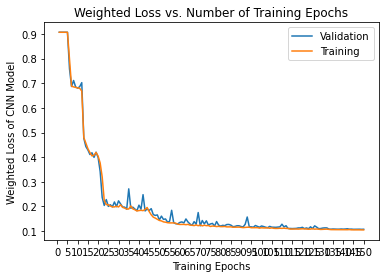




Fold- 3 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.683149, dice: 0.931626, loss: 0.906778


num_epochs:   1%|▍                                                                   | 1/150 [00:44<1:50:51, 44.64s/it]

val: bce: 0.683067, dice: 0.932126, loss: 0.907220
saving best model
Total time: 0:00:44.641432
Epoch time: 0m 45s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.683021, dice: 0.931627, loss: 0.906766


num_epochs:   1%|▉                                                                   | 2/150 [01:30<1:52:15, 45.51s/it]

val: bce: 0.682936, dice: 0.932127, loss: 0.907208
saving best model
Total time: 0:01:30.757024
Epoch time: 0m 46s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.682887, dice: 0.931628, loss: 0.906754


num_epochs:   2%|█▎                                                                  | 3/150 [02:18<1:54:17, 46.65s/it]

val: bce: 0.682798, dice: 0.932128, loss: 0.907195
saving best model
Total time: 0:02:18.758408
Epoch time: 0m 48s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.682744, dice: 0.931629, loss: 0.906740


num_epochs:   3%|█▊                                                                  | 4/150 [03:03<1:51:44, 45.92s/it]

val: bce: 0.682648, dice: 0.932129, loss: 0.907181
saving best model
Total time: 0:03:03.571008
Epoch time: 0m 45s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.682585, dice: 0.931630, loss: 0.906725


num_epochs:   3%|██▎                                                                 | 5/150 [03:33<1:36:54, 40.10s/it]

val: bce: 0.682477, dice: 0.932130, loss: 0.907165
saving best model
Total time: 0:03:33.346379
Epoch time: 0m 30s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.314499, dice: 0.841605, loss: 0.788895


num_epochs:   4%|██▋                                                                 | 6/150 [04:04<1:29:03, 37.11s/it]

val: bce: 0.154908, dice: 0.796267, loss: 0.732131
saving best model
Total time: 0:04:04.652405
Epoch time: 0m 31s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.139897, dice: 0.754038, loss: 0.692624


num_epochs:   5%|███▏                                                                | 7/150 [04:39<1:26:31, 36.30s/it]

val: bce: 0.147064, dice: 0.751720, loss: 0.691254
saving best model
Total time: 0:04:39.297999
Epoch time: 0m 35s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.145078, dice: 0.749082, loss: 0.688681


num_epochs:   5%|███▋                                                                | 8/150 [05:16<1:26:25, 36.52s/it]

val: bce: 0.148111, dice: 0.749294, loss: 0.689176
saving best model
Total time: 0:05:16.268840
Epoch time: 0m 37s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.143697, dice: 0.747890, loss: 0.687471


num_epochs:   6%|████                                                                | 9/150 [05:55<1:27:28, 37.23s/it]

val: bce: 0.156146, dice: 0.751850, loss: 0.692280
Total time: 0:05:55.056529
Epoch time: 0m 39s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.144310, dice: 0.745869, loss: 0.685713


num_epochs:   7%|████▍                                                              | 10/150 [06:35<1:29:26, 38.33s/it]

val: bce: 0.135903, dice: 0.749685, loss: 0.688307
saving best model
Total time: 0:06:35.870874
Epoch time: 0m 41s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.143034, dice: 0.742684, loss: 0.682719


num_epochs:   7%|████▉                                                              | 11/150 [07:18<1:32:03, 39.74s/it]

val: bce: 0.145511, dice: 0.739789, loss: 0.680362
saving best model
Total time: 0:07:18.800162
Epoch time: 0m 43s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.129654, dice: 0.724576, loss: 0.665084


num_epochs:   8%|█████▎                                                             | 12/150 [08:02<1:34:11, 40.95s/it]

val: bce: 0.104041, dice: 0.654444, loss: 0.599404
saving best model
Total time: 0:08:02.524043
Epoch time: 0m 44s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.096028, dice: 0.606277, loss: 0.555252


num_epochs:   9%|█████▊                                                             | 13/150 [08:47<1:36:09, 42.11s/it]

val: bce: 0.120618, dice: 0.592229, loss: 0.545068
saving best model
Total time: 0:08:47.296963
Epoch time: 0m 45s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.085950, dice: 0.544310, loss: 0.498474


num_epochs:   9%|██████▎                                                            | 14/150 [09:17<1:27:30, 38.61s/it]

val: bce: 0.061814, dice: 0.516875, loss: 0.471369
saving best model
Total time: 0:09:17.815341
Epoch time: 0m 31s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.066648, dice: 0.491214, loss: 0.448758


num_epochs:  10%|██████▋                                                            | 15/150 [09:48<1:21:49, 36.36s/it]

val: bce: 0.065953, dice: 0.479638, loss: 0.438269
saving best model
Total time: 0:09:48.980504
Epoch time: 0m 31s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.069217, dice: 0.457396, loss: 0.418578


num_epochs:  11%|███████▏                                                           | 16/150 [10:21<1:18:19, 35.07s/it]

val: bce: 0.256267, dice: 0.518062, loss: 0.491882
Total time: 0:10:21.053346
Epoch time: 0m 32s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.120401, dice: 0.417942, loss: 0.388188


num_epochs:  11%|███████▌                                                           | 17/150 [10:50<1:14:07, 33.44s/it]

val: bce: 0.288125, dice: 0.427870, loss: 0.413895
saving best model
Total time: 0:10:50.689837
Epoch time: 0m 30s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.150139, dice: 0.341991, loss: 0.322806


num_epochs:  12%|████████                                                           | 18/150 [11:21<1:11:35, 32.54s/it]

val: bce: 0.152129, dice: 0.302795, loss: 0.287728
saving best model
Total time: 0:11:21.148200
Epoch time: 0m 30s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.147749, dice: 0.250527, loss: 0.240250


num_epochs:  13%|████████▍                                                          | 19/150 [11:52<1:10:33, 32.32s/it]

val: bce: 0.199292, dice: 0.247851, loss: 0.242995
saving best model
Total time: 0:11:52.941298
Epoch time: 0m 32s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.126011, dice: 0.216784, loss: 0.207707


num_epochs:  13%|████████▉                                                          | 20/150 [12:24<1:09:25, 32.04s/it]

val: bce: 0.125579, dice: 0.216452, loss: 0.207365
saving best model
Total time: 0:12:24.330156
Epoch time: 0m 31s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.110203, dice: 0.202492, loss: 0.193263


num_epochs:  14%|█████████▍                                                         | 21/150 [12:54<1:07:39, 31.47s/it]

val: bce: 0.109783, dice: 0.207396, loss: 0.197635
saving best model
Total time: 0:12:54.479016
Epoch time: 0m 30s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.098934, dice: 0.196447, loss: 0.186696


num_epochs:  15%|█████████▊                                                         | 22/150 [13:24<1:06:13, 31.04s/it]

val: bce: 0.096510, dice: 0.201940, loss: 0.191397
saving best model
Total time: 0:13:24.528673
Epoch time: 0m 30s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.092326, dice: 0.189227, loss: 0.179537


num_epochs:  15%|██████████▎                                                        | 23/150 [13:55<1:05:34, 30.98s/it]

val: bce: 0.100794, dice: 0.219515, loss: 0.207643
Total time: 0:13:55.365484
Epoch time: 0m 31s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.088280, dice: 0.188313, loss: 0.178310


num_epochs:  16%|██████████▋                                                        | 24/150 [14:27<1:05:57, 31.41s/it]

val: bce: 0.099993, dice: 0.192313, loss: 0.183081
saving best model
Total time: 0:14:27.768663
Epoch time: 0m 32s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.085887, dice: 0.185154, loss: 0.175228


num_epochs:  17%|███████████▏                                                       | 25/150 [14:58<1:05:13, 31.31s/it]

val: bce: 0.108925, dice: 0.207200, loss: 0.197372
Total time: 0:14:58.832145
Epoch time: 0m 31s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.083965, dice: 0.183287, loss: 0.173355


num_epochs:  17%|███████████▌                                                       | 26/150 [15:30<1:04:54, 31.41s/it]

val: bce: 0.103615, dice: 0.192396, loss: 0.183518
Total time: 0:15:30.482892
Epoch time: 0m 32s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.078548, dice: 0.180594, loss: 0.170390


num_epochs:  18%|████████████                                                       | 27/150 [16:04<1:06:04, 32.23s/it]

val: bce: 0.078498, dice: 0.179425, loss: 0.169332
saving best model
Total time: 0:16:04.630005
Epoch time: 0m 34s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.076631, dice: 0.175140, loss: 0.165289


num_epochs:  19%|████████████▌                                                      | 28/150 [16:40<1:07:41, 33.29s/it]

val: bce: 0.090364, dice: 0.185247, loss: 0.175758
Total time: 0:16:40.396063
Epoch time: 0m 36s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.075739, dice: 0.174748, loss: 0.164847


num_epochs:  19%|████████████▉                                                      | 29/150 [17:18<1:09:49, 34.62s/it]

val: bce: 0.087000, dice: 0.194914, loss: 0.184122
Total time: 0:17:18.128266
Epoch time: 0m 38s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.075033, dice: 0.175428, loss: 0.165389


num_epochs:  20%|█████████████▍                                                     | 30/150 [17:57<1:12:17, 36.15s/it]

val: bce: 0.179382, dice: 0.254002, loss: 0.246540
Total time: 0:17:57.837025
Epoch time: 0m 40s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.076675, dice: 0.175634, loss: 0.165738


num_epochs:  21%|█████████████▊                                                     | 31/150 [18:39<1:14:54, 37.77s/it]

val: bce: 0.082978, dice: 0.180152, loss: 0.170435
Total time: 0:18:39.382474
Epoch time: 0m 42s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.070826, dice: 0.167137, loss: 0.157506


num_epochs:  21%|██████████████▎                                                    | 32/150 [19:22<1:17:40, 39.50s/it]

val: bce: 0.088902, dice: 0.185940, loss: 0.176237
Total time: 0:19:22.921842
Epoch time: 0m 44s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.068128, dice: 0.165534, loss: 0.155794


num_epochs:  22%|██████████████▋                                                    | 33/150 [20:08<1:20:30, 41.28s/it]

val: bce: 0.068797, dice: 0.171918, loss: 0.161606
saving best model
Total time: 0:20:08.369322
Epoch time: 0m 45s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.065081, dice: 0.160286, loss: 0.150765


num_epochs:  23%|███████████████▏                                                   | 34/150 [20:38<1:13:11, 37.86s/it]

val: bce: 0.080945, dice: 0.174256, loss: 0.164925
Total time: 0:20:38.232980
Epoch time: 0m 30s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.064450, dice: 0.158981, loss: 0.149528


num_epochs:  23%|███████████████▋                                                   | 35/150 [21:08<1:08:17, 35.63s/it]

val: bce: 0.094513, dice: 0.200106, loss: 0.189547
Total time: 0:21:08.664063
Epoch time: 0m 30s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.069049, dice: 0.166576, loss: 0.156823


num_epochs:  24%|████████████████                                                   | 36/150 [21:40<1:05:45, 34.61s/it]

val: bce: 0.088829, dice: 0.189974, loss: 0.179859
Total time: 0:21:40.879257
Epoch time: 0m 32s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.064037, dice: 0.160378, loss: 0.150744


num_epochs:  25%|████████████████▌                                                  | 37/150 [22:14<1:04:52, 34.44s/it]

val: bce: 0.102375, dice: 0.202714, loss: 0.192680
Total time: 0:22:14.946515
Epoch time: 0m 34s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.063499, dice: 0.156626, loss: 0.147313


num_epochs:  25%|████████████████▉                                                  | 38/150 [22:50<1:04:56, 34.79s/it]

val: bce: 0.068829, dice: 0.157957, loss: 0.149044
saving best model
Total time: 0:22:50.547405
Epoch time: 0m 36s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.061693, dice: 0.153469, loss: 0.144291


num_epochs:  26%|█████████████████▍                                                 | 39/150 [23:27<1:05:50, 35.59s/it]

val: bce: 0.059382, dice: 0.154369, loss: 0.144871
saving best model
Total time: 0:23:27.994902
Epoch time: 0m 37s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.058237, dice: 0.148767, loss: 0.139714


num_epochs:  27%|█████████████████▊                                                 | 40/150 [23:58<1:02:42, 34.20s/it]

val: bce: 0.078508, dice: 0.165328, loss: 0.156646
Total time: 0:23:58.968113
Epoch time: 0m 31s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.058009, dice: 0.148927, loss: 0.139836


num_epochs:  27%|██████████████████▎                                                | 41/150 [24:29<1:00:11, 33.14s/it]

val: bce: 0.093570, dice: 0.178801, loss: 0.170278
Total time: 0:24:29.612476
Epoch time: 0m 31s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.059705, dice: 0.151622, loss: 0.142431


num_epochs:  28%|███████████████████▎                                                 | 42/150 [25:01<59:14, 32.91s/it]

val: bce: 0.056377, dice: 0.152254, loss: 0.142666
saving best model
Total time: 0:25:01.992838
Epoch time: 0m 32s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.057551, dice: 0.147591, loss: 0.138587


num_epochs:  29%|███████████████████▊                                                 | 43/150 [25:36<59:18, 33.25s/it]

val: bce: 0.068682, dice: 0.172040, loss: 0.161704
Total time: 0:25:36.047200
Epoch time: 0m 34s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.056685, dice: 0.146701, loss: 0.137699


num_epochs:  29%|███████████████████▋                                               | 44/150 [26:11<1:00:04, 34.01s/it]

val: bce: 0.060575, dice: 0.148368, loss: 0.139588
saving best model
Total time: 0:26:11.813257
Epoch time: 0m 36s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.055783, dice: 0.143506, loss: 0.134733


num_epochs:  30%|████████████████████▋                                                | 45/150 [26:45<59:18, 33.89s/it]

val: bce: 0.057185, dice: 0.146480, loss: 0.137551
saving best model
Total time: 0:26:45.419236
Epoch time: 0m 34s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.055726, dice: 0.143693, loss: 0.134897


num_epochs:  31%|█████████████████████▏                                               | 46/150 [27:15<56:29, 32.60s/it]

val: bce: 0.071511, dice: 0.166260, loss: 0.156785
Total time: 0:27:15.003646
Epoch time: 0m 30s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.056782, dice: 0.146435, loss: 0.137470


num_epochs:  31%|█████████████████████▌                                               | 47/150 [27:46<55:09, 32.13s/it]

val: bce: 0.057259, dice: 0.146281, loss: 0.137379
saving best model
Total time: 0:27:46.053736
Epoch time: 0m 31s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.053927, dice: 0.140723, loss: 0.132044


num_epochs:  32%|██████████████████████                                               | 48/150 [28:18<55:01, 32.37s/it]

val: bce: 0.066363, dice: 0.156427, loss: 0.147421
Total time: 0:28:18.978706
Epoch time: 0m 33s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.054174, dice: 0.141934, loss: 0.133158


num_epochs:  33%|██████████████████████▌                                              | 49/150 [28:53<55:36, 33.03s/it]

val: bce: 0.097225, dice: 0.184363, loss: 0.175649
Total time: 0:28:53.559324
Epoch time: 0m 35s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.053538, dice: 0.140292, loss: 0.131616


num_epochs:  33%|███████████████████████                                              | 50/150 [29:28<56:06, 33.66s/it]

val: bce: 0.055317, dice: 0.141319, loss: 0.132719
saving best model
Total time: 0:29:28.684550
Epoch time: 0m 35s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.052357, dice: 0.138076, loss: 0.129504


num_epochs:  34%|███████████████████████▍                                             | 51/150 [29:58<53:23, 32.36s/it]

val: bce: 0.058227, dice: 0.144909, loss: 0.136241
Total time: 0:29:58.020465
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.052253, dice: 0.136495, loss: 0.128071


num_epochs:  35%|███████████████████████▉                                             | 52/150 [30:28<51:58, 31.82s/it]

val: bce: 0.090380, dice: 0.171218, loss: 0.163134
Total time: 0:30:28.578027
Epoch time: 0m 31s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.053693, dice: 0.139151, loss: 0.130605


num_epochs:  35%|████████████████████████▍                                            | 53/150 [31:00<51:41, 31.98s/it]

val: bce: 0.055698, dice: 0.140273, loss: 0.131815
saving best model
Total time: 0:31:00.912262
Epoch time: 0m 32s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.051139, dice: 0.135469, loss: 0.127036


num_epochs:  36%|████████████████████████▊                                            | 54/150 [31:34<52:07, 32.58s/it]

val: bce: 0.091683, dice: 0.176155, loss: 0.167708
Total time: 0:31:34.909584
Epoch time: 0m 34s


----------
Epoch 54/149
LR 0.0005
train: bce: 0.053585, dice: 0.138272, loss: 0.129804


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [32:10<53:05, 33.53s/it]

val: bce: 0.052842, dice: 0.140064, loss: 0.131342
saving best model
Total time: 0:32:10.666217
Epoch time: 0m 36s


----------
Epoch 55/149
LR 0.0005
train: bce: 0.051062, dice: 0.134583, loss: 0.126231


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [32:47<54:16, 34.64s/it]

val: bce: 0.068566, dice: 0.162237, loss: 0.152870
Total time: 0:32:47.892003
Epoch time: 0m 37s


----------
Epoch 56/149
LR 0.0005
train: bce: 0.051359, dice: 0.135438, loss: 0.127030


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [33:18<52:00, 33.55s/it]

val: bce: 0.059145, dice: 0.141974, loss: 0.133691
Total time: 0:33:18.907374
Epoch time: 0m 31s


----------
Epoch 57/149
LR 0.0005
train: bce: 0.050286, dice: 0.133413, loss: 0.125100


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [33:48<49:50, 32.51s/it]

val: bce: 0.063399, dice: 0.144759, loss: 0.136623
Total time: 0:33:48.970920
Epoch time: 0m 30s


----------
Epoch 58/149
LR 0.0005
train: bce: 0.050437, dice: 0.133384, loss: 0.125089


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [34:20<48:56, 32.27s/it]

val: bce: 0.051304, dice: 0.140281, loss: 0.131383
Total time: 0:34:20.682674
Epoch time: 0m 32s


----------
Epoch 59/149
LR 0.0005
train: bce: 0.050156, dice: 0.132822, loss: 0.124556


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [34:54<48:58, 32.65s/it]

val: bce: 0.050703, dice: 0.135882, loss: 0.127364
saving best model
Total time: 0:34:54.218716
Epoch time: 0m 34s


----------
Epoch 60/149
LR 0.0005
train: bce: 0.050010, dice: 0.132403, loss: 0.124163


num_epochs:  41%|████████████████████████████                                         | 61/150 [35:27<48:39, 32.81s/it]

val: bce: 0.083854, dice: 0.167552, loss: 0.159182
Total time: 0:35:27.396150
Epoch time: 0m 33s


----------
Epoch 61/149
LR 0.0005
train: bce: 0.052071, dice: 0.135496, loss: 0.127153


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [35:56<46:39, 31.81s/it]

val: bce: 0.057452, dice: 0.144038, loss: 0.135379
Total time: 0:35:56.894753
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.0005
train: bce: 0.050545, dice: 0.134136, loss: 0.125777


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [36:27<45:42, 31.52s/it]

val: bce: 0.060624, dice: 0.143914, loss: 0.135585
Total time: 0:36:27.733547
Epoch time: 0m 31s


----------
Epoch 63/149
LR 0.0005
train: bce: 0.048966, dice: 0.131530, loss: 0.123273


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [37:00<45:39, 31.86s/it]

val: bce: 0.048830, dice: 0.131919, loss: 0.123610
saving best model
Total time: 0:37:00.378774
Epoch time: 0m 33s


----------
Epoch 64/149
LR 0.0005
train: bce: 0.049330, dice: 0.131210, loss: 0.123022


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [37:34<46:10, 32.59s/it]

val: bce: 0.070345, dice: 0.154008, loss: 0.145641
Total time: 0:37:34.685104
Epoch time: 0m 34s


----------
Epoch 65/149
LR 0.0005
train: bce: 0.050057, dice: 0.133533, loss: 0.125185


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [38:09<46:34, 33.27s/it]

val: bce: 0.053113, dice: 0.140977, loss: 0.132190
Total time: 0:38:09.523641
Epoch time: 0m 35s


----------
Epoch 66/149
LR 0.0005
train: bce: 0.049411, dice: 0.131729, loss: 0.123497


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [38:38<44:23, 32.08s/it]

val: bce: 0.047995, dice: 0.130816, loss: 0.122534
saving best model
Total time: 0:38:38.849636
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.0005
train: bce: 0.048068, dice: 0.128976, loss: 0.120885


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [39:09<43:12, 31.62s/it]

val: bce: 0.055228, dice: 0.138132, loss: 0.129841
Total time: 0:39:09.381903
Epoch time: 0m 31s


----------
Epoch 68/149
LR 0.0005
train: bce: 0.048460, dice: 0.130357, loss: 0.122167


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [39:41<42:57, 31.83s/it]

val: bce: 0.053376, dice: 0.140140, loss: 0.131464
Total time: 0:39:41.694809
Epoch time: 0m 32s


----------
Epoch 69/149
LR 0.0005
train: bce: 0.048263, dice: 0.129421, loss: 0.121306


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [40:15<43:20, 32.51s/it]

val: bce: 0.053454, dice: 0.140729, loss: 0.132001
Total time: 0:40:15.789843
Epoch time: 0m 34s


----------
Epoch 70/149
LR 0.0005
train: bce: 0.049814, dice: 0.133232, loss: 0.124890


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [40:51<44:01, 33.44s/it]

val: bce: 0.048452, dice: 0.133101, loss: 0.124636
Total time: 0:40:51.400157
Epoch time: 0m 36s


----------
Epoch 71/149
LR 0.0005
train: bce: 0.048831, dice: 0.131045, loss: 0.122823


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [41:22<42:27, 32.66s/it]

val: bce: 0.049926, dice: 0.132525, loss: 0.124265
Total time: 0:41:22.235479
Epoch time: 0m 31s


----------
Epoch 72/149
LR 0.0005
train: bce: 0.047915, dice: 0.128756, loss: 0.120672


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [41:52<40:52, 31.85s/it]

val: bce: 0.062941, dice: 0.141272, loss: 0.133439
Total time: 0:41:52.211234
Epoch time: 0m 30s


----------
Epoch 73/149
LR 0.0005
train: bce: 0.048203, dice: 0.128922, loss: 0.120850


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [42:23<40:14, 31.77s/it]

val: bce: 0.049793, dice: 0.129447, loss: 0.121482
saving best model
Total time: 0:42:23.801965
Epoch time: 0m 32s


----------
Epoch 74/149
LR 0.0005
train: bce: 0.047799, dice: 0.127797, loss: 0.119798


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [42:57<40:18, 32.25s/it]

val: bce: 0.046370, dice: 0.128065, loss: 0.119896
saving best model
Total time: 0:42:57.160440
Epoch time: 0m 33s


----------
Epoch 75/149
LR 0.0005
train: bce: 0.047851, dice: 0.128213, loss: 0.120177


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [43:32<40:49, 33.10s/it]

val: bce: 0.049320, dice: 0.129709, loss: 0.121670
Total time: 0:43:32.249952
Epoch time: 0m 35s


----------
Epoch 76/149
LR 0.0005
train: bce: 0.047613, dice: 0.127658, loss: 0.119653


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [44:09<41:37, 34.22s/it]

val: bce: 0.050367, dice: 0.131862, loss: 0.123713
Total time: 0:44:09.076954
Epoch time: 0m 37s


----------
Epoch 77/149
LR 0.0005
train: bce: 0.047659, dice: 0.128932, loss: 0.120804


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [44:42<40:48, 34.01s/it]

val: bce: 0.051854, dice: 0.133588, loss: 0.125415
Total time: 0:44:42.595636
Epoch time: 0m 34s


----------
Epoch 78/149
LR 0.0005
train: bce: 0.047384, dice: 0.128284, loss: 0.120194


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [45:12<38:41, 32.69s/it]

val: bce: 0.047573, dice: 0.128174, loss: 0.120114
Total time: 0:45:12.219727
Epoch time: 0m 30s


----------
Epoch 79/149
LR 0.0005
train: bce: 0.047463, dice: 0.127150, loss: 0.119181


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [45:43<37:36, 32.24s/it]

val: bce: 0.050713, dice: 0.130376, loss: 0.122409
Total time: 0:45:43.386873
Epoch time: 0m 31s


----------
Epoch 80/149
LR 0.0005
train: bce: 0.046723, dice: 0.125694, loss: 0.117797


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [46:16<37:16, 32.42s/it]

val: bce: 0.051021, dice: 0.134235, loss: 0.125914
Total time: 0:46:16.228019
Epoch time: 0m 33s


----------
Epoch 81/149
LR 0.0005
train: bce: 0.046829, dice: 0.126157, loss: 0.118224


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [46:50<37:18, 32.92s/it]

val: bce: 0.054124, dice: 0.139703, loss: 0.131145
Total time: 0:46:50.332477
Epoch time: 0m 34s


----------
Epoch 82/149
LR 0.0005
train: bce: 0.047408, dice: 0.127476, loss: 0.119469


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [47:19<35:27, 31.75s/it]

val: bce: 0.058991, dice: 0.146826, loss: 0.138043
Total time: 0:47:19.336568
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.0005
train: bce: 0.047252, dice: 0.127333, loss: 0.119325


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [47:48<34:09, 31.06s/it]

val: bce: 0.046686, dice: 0.125492, loss: 0.117611
saving best model
Total time: 0:47:48.789539
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.0005
train: bce: 0.046544, dice: 0.124949, loss: 0.117108


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [48:19<33:24, 30.84s/it]

val: bce: 0.061002, dice: 0.140076, loss: 0.132169
Total time: 0:48:19.131341
Epoch time: 0m 30s


----------
Epoch 85/149
LR 0.0005
train: bce: 0.046885, dice: 0.126268, loss: 0.118330


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [48:50<33:06, 31.03s/it]

val: bce: 0.055243, dice: 0.144212, loss: 0.135315
Total time: 0:48:50.609479
Epoch time: 0m 31s


----------
Epoch 86/149
LR 0.0005
train: bce: 0.046815, dice: 0.126581, loss: 0.118604


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [49:23<33:06, 31.53s/it]

val: bce: 0.056669, dice: 0.143170, loss: 0.134520
Total time: 0:49:23.291410
Epoch time: 0m 33s


----------
Epoch 87/149
LR 0.0005
train: bce: 0.046937, dice: 0.126307, loss: 0.118370


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [49:57<33:19, 32.24s/it]

val: bce: 0.047520, dice: 0.127502, loss: 0.119503
Total time: 0:49:57.197468
Epoch time: 0m 34s


----------
Epoch 88/149
LR 0.0005
train: bce: 0.046261, dice: 0.124197, loss: 0.116403


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [50:32<33:37, 33.07s/it]

val: bce: 0.047946, dice: 0.129172, loss: 0.121049
Total time: 0:50:32.209109
Epoch time: 0m 35s


----------
Epoch 89/149
LR 0.0005
train: bce: 0.046043, dice: 0.123927, loss: 0.116138


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [51:08<33:59, 33.99s/it]

val: bce: 0.054432, dice: 0.138361, loss: 0.129968
Total time: 0:51:08.341711
Epoch time: 0m 36s


----------
Epoch 90/149
LR 0.0005
train: bce: 0.045914, dice: 0.124466, loss: 0.116610


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [51:45<34:23, 34.97s/it]

val: bce: 0.062698, dice: 0.142299, loss: 0.134338
Total time: 0:51:45.594280
Epoch time: 0m 37s


----------
Epoch 91/149
LR 0.0005
train: bce: 0.046871, dice: 0.124775, loss: 0.116985


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [52:16<32:38, 33.77s/it]

val: bce: 0.050485, dice: 0.130347, loss: 0.122361
Total time: 0:52:16.572451
Epoch time: 0m 31s


----------
Epoch 92/149
LR 0.0005
train: bce: 0.046177, dice: 0.124448, loss: 0.116621


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [52:47<31:15, 32.90s/it]

val: bce: 0.050013, dice: 0.128260, loss: 0.120435
Epoch    88: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:52:47.437533
Epoch time: 0m 31s


----------
Epoch 93/149
LR 0.00025
train: bce: 0.045969, dice: 0.123005, loss: 0.115302


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [53:20<30:49, 33.03s/it]

val: bce: 0.045021, dice: 0.122987, loss: 0.115190
saving best model
Total time: 0:53:20.779144
Epoch time: 0m 33s


----------
Epoch 94/149
LR 0.00025
train: bce: 0.044431, dice: 0.121314, loss: 0.113626


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [53:55<30:50, 33.64s/it]

val: bce: 0.047237, dice: 0.127283, loss: 0.119278
Total time: 0:53:55.842369
Epoch time: 0m 35s


----------
Epoch 95/149
LR 0.00025
train: bce: 0.044651, dice: 0.122092, loss: 0.114348


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [54:33<31:28, 34.98s/it]

val: bce: 0.050519, dice: 0.126710, loss: 0.119091
Total time: 0:54:33.929210
Epoch time: 0m 38s


----------
Epoch 96/149
LR 0.00025
train: bce: 0.045200, dice: 0.121736, loss: 0.114083


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [55:12<31:58, 36.20s/it]

val: bce: 0.050410, dice: 0.127742, loss: 0.120008
Total time: 0:55:12.978291
Epoch time: 0m 39s


----------
Epoch 97/149
LR 0.00025
train: bce: 0.044933, dice: 0.122289, loss: 0.114553


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [55:48<31:16, 36.09s/it]

val: bce: 0.046541, dice: 0.125115, loss: 0.117258
Total time: 0:55:48.818253
Epoch time: 0m 36s


----------
Epoch 98/149
LR 0.00025
train: bce: 0.044686, dice: 0.121758, loss: 0.114051


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [56:20<29:28, 34.67s/it]

val: bce: 0.046531, dice: 0.123166, loss: 0.115502
Total time: 0:56:20.178344
Epoch time: 0m 31s


----------
Epoch 99/149
LR 0.00025
train: bce: 0.044686, dice: 0.120808, loss: 0.113195


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [56:54<28:49, 34.60s/it]

val: bce: 0.043396, dice: 0.122528, loss: 0.114615
saving best model
Total time: 0:56:54.611153
Epoch time: 0m 34s


----------
Epoch 100/149
LR 0.00025
train: bce: 0.043906, dice: 0.120813, loss: 0.113123


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [57:32<28:59, 35.50s/it]

val: bce: 0.046547, dice: 0.124390, loss: 0.116605
Total time: 0:57:32.201995
Epoch time: 0m 38s


----------
Epoch 101/149
LR 0.00025
train: bce: 0.044905, dice: 0.121303, loss: 0.113663


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [58:11<29:21, 36.69s/it]

val: bce: 0.045835, dice: 0.127101, loss: 0.118975
Total time: 0:58:11.684580
Epoch time: 0m 39s


----------
Epoch 102/149
LR 0.00025
train: bce: 0.045071, dice: 0.121524, loss: 0.113879


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [58:54<30:15, 38.62s/it]

val: bce: 0.044676, dice: 0.125240, loss: 0.117184
Total time: 0:58:54.814252
Epoch time: 0m 43s


----------
Epoch 103/149
LR 0.00025
train: bce: 0.044439, dice: 0.121214, loss: 0.113537


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [59:37<30:27, 39.73s/it]

val: bce: 0.045949, dice: 0.123564, loss: 0.115803
Total time: 0:59:37.129492
Epoch time: 0m 42s


----------
Epoch 104/149
LR 0.00025
train: bce: 0.044801, dice: 0.121410, loss: 0.113749


num_epochs:  70%|██████████████████████████████████████████████▏                   | 105/150 [1:00:21<30:49, 41.09s/it]

val: bce: 0.045505, dice: 0.121339, loss: 0.113756
saving best model
Total time: 1:00:21.399469
Epoch time: 0m 44s


----------
Epoch 105/149
LR 0.00025
train: bce: 0.044701, dice: 0.120357, loss: 0.112791


num_epochs:  71%|██████████████████████████████████████████████▋                   | 106/150 [1:01:07<31:14, 42.60s/it]

val: bce: 0.044840, dice: 0.122269, loss: 0.114526
Total time: 1:01:07.513573
Epoch time: 0m 46s


----------
Epoch 106/149
LR 0.00025
train: bce: 0.043987, dice: 0.119673, loss: 0.112105


num_epochs:  71%|███████████████████████████████████████████████                   | 107/150 [1:01:55<31:41, 44.23s/it]

val: bce: 0.046271, dice: 0.121469, loss: 0.113950
Total time: 1:01:55.544220
Epoch time: 0m 48s


----------
Epoch 107/149
LR 0.00025
train: bce: 0.044193, dice: 0.119797, loss: 0.112237


num_epochs:  72%|███████████████████████████████████████████████▌                  | 108/150 [1:02:45<32:03, 45.81s/it]

val: bce: 0.044774, dice: 0.121426, loss: 0.113761
Total time: 1:02:45.039059
Epoch time: 0m 49s


----------
Epoch 108/149
LR 0.00025
train: bce: 0.044057, dice: 0.119862, loss: 0.112281


num_epochs:  73%|███████████████████████████████████████████████▉                  | 109/150 [1:03:36<32:29, 47.55s/it]

val: bce: 0.048192, dice: 0.123512, loss: 0.115980
Total time: 1:03:36.659754
Epoch time: 0m 52s


----------
Epoch 109/149
LR 0.00025
train: bce: 0.044074, dice: 0.119750, loss: 0.112183


num_epochs:  73%|████████████████████████████████████████████████▍                 | 110/150 [1:04:29<32:49, 49.23s/it]

val: bce: 0.048071, dice: 0.129303, loss: 0.121180
Total time: 1:04:29.789280
Epoch time: 0m 53s


----------
Epoch 110/149
LR 0.00025
train: bce: 0.044134, dice: 0.120587, loss: 0.112941


num_epochs:  74%|████████████████████████████████████████████████▊                 | 111/150 [1:05:24<33:03, 50.85s/it]

val: bce: 0.046386, dice: 0.121891, loss: 0.114340
Total time: 1:05:24.438551
Epoch time: 0m 55s


----------
Epoch 111/149
LR 0.00025
train: bce: 0.043865, dice: 0.119077, loss: 0.111556


num_epochs:  75%|█████████████████████████████████████████████████▎                | 112/150 [1:06:20<33:15, 52.50s/it]

val: bce: 0.046318, dice: 0.123773, loss: 0.116027
Total time: 1:06:20.785133
Epoch time: 0m 56s


----------
Epoch 112/149
LR 0.00025
train: bce: 0.044022, dice: 0.119704, loss: 0.112136


num_epochs:  75%|█████████████████████████████████████████████████▋                | 113/150 [1:07:18<33:25, 54.21s/it]

val: bce: 0.043688, dice: 0.120412, loss: 0.112740
saving best model
Total time: 1:07:18.998163
Epoch time: 0m 58s


----------
Epoch 113/149
LR 0.00025
train: bce: 0.043800, dice: 0.119463, loss: 0.111896


num_epochs:  76%|██████████████████████████████████████████████████▏               | 114/150 [1:08:18<33:29, 55.83s/it]

val: bce: 0.044343, dice: 0.121782, loss: 0.114038
Total time: 1:08:18.599992
Epoch time: 0m 60s


----------
Epoch 114/149
LR 0.00025
train: bce: 0.043684, dice: 0.119149, loss: 0.111603


num_epochs:  77%|██████████████████████████████████████████████████▌               | 115/150 [1:09:19<33:31, 57.47s/it]

val: bce: 0.046935, dice: 0.123902, loss: 0.116205
Total time: 1:09:19.886733
Epoch time: 1m 1s


----------
Epoch 115/149
LR 0.00025
train: bce: 0.044463, dice: 0.119642, loss: 0.112124


num_epochs:  77%|███████████████████████████████████████████████████               | 116/150 [1:10:22<33:30, 59.12s/it]

val: bce: 0.049843, dice: 0.130266, loss: 0.122224
Total time: 1:10:22.871778
Epoch time: 1m 3s


----------
Epoch 116/149
LR 0.00025
train: bce: 0.044660, dice: 0.120833, loss: 0.113216


num_epochs:  78%|███████████████████████████████████████████████████▍              | 117/150 [1:11:27<33:25, 60.76s/it]

val: bce: 0.045069, dice: 0.122731, loss: 0.114965
Total time: 1:11:27.444519
Epoch time: 1m 5s


----------
Epoch 117/149
LR 0.00025
train: bce: 0.043512, dice: 0.119008, loss: 0.111458


num_epochs:  79%|███████████████████████████████████████████████████▉              | 118/150 [1:12:33<33:16, 62.40s/it]

val: bce: 0.052348, dice: 0.127120, loss: 0.119643
Total time: 1:12:33.687786
Epoch time: 1m 6s


----------
Epoch 118/149
LR 0.00025
train: bce: 0.043714, dice: 0.119167, loss: 0.111621


num_epochs:  79%|████████████████████████████████████████████████████▎             | 119/150 [1:13:41<33:04, 64.00s/it]

val: bce: 0.044996, dice: 0.120701, loss: 0.113131
Total time: 1:13:41.414094
Epoch time: 1m 8s


----------
Epoch 119/149
LR 0.00025
train: bce: 0.043301, dice: 0.118197, loss: 0.110707


num_epochs:  80%|████████████████████████████████████████████████████▊             | 120/150 [1:14:50<32:46, 65.56s/it]

val: bce: 0.043996, dice: 0.120569, loss: 0.112912
Total time: 1:14:50.619971
Epoch time: 1m 9s


----------
Epoch 120/149
LR 0.00025
train: bce: 0.044015, dice: 0.118786, loss: 0.111309


num_epochs:  81%|█████████████████████████████████████████████████████▏            | 121/150 [1:15:20<26:28, 54.78s/it]

val: bce: 0.043838, dice: 0.123678, loss: 0.115694
Total time: 1:15:20.243070
Epoch time: 0m 30s


----------
Epoch 121/149
LR 0.00025
train: bce: 0.043307, dice: 0.118164, loss: 0.110678


num_epochs:  81%|█████████████████████████████████████████████████████▋            | 122/150 [1:15:48<21:53, 46.89s/it]

val: bce: 0.051675, dice: 0.127695, loss: 0.120093
Epoch   117: reducing learning rate of group 0 to 1.2500e-04.
Total time: 1:15:48.732312
Epoch time: 0m 28s


----------
Epoch 122/149
LR 0.000125
train: bce: 0.042718, dice: 0.117670, loss: 0.110175


num_epochs:  82%|██████████████████████████████████████████████████████            | 123/150 [1:16:17<18:37, 41.39s/it]

val: bce: 0.042973, dice: 0.118786, loss: 0.111205
saving best model
Total time: 1:16:17.269667
Epoch time: 0m 29s


----------
Epoch 123/149
LR 0.000125
train: bce: 0.042840, dice: 0.117548, loss: 0.110077


num_epochs:  83%|██████████████████████████████████████████████████████▌           | 124/150 [1:16:45<16:15, 37.53s/it]

val: bce: 0.045418, dice: 0.122660, loss: 0.114936
Total time: 1:16:45.804541
Epoch time: 0m 29s


----------
Epoch 124/149
LR 0.000125
train: bce: 0.043443, dice: 0.117910, loss: 0.110463


num_epochs:  83%|███████████████████████████████████████████████████████           | 125/150 [1:17:14<14:30, 34.81s/it]

val: bce: 0.043621, dice: 0.119589, loss: 0.111992
Total time: 1:17:14.271961
Epoch time: 0m 28s


----------
Epoch 125/149
LR 0.000125
train: bce: 0.042664, dice: 0.117323, loss: 0.109857


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:17:42<13:09, 32.91s/it]

val: bce: 0.043601, dice: 0.119183, loss: 0.111625
Total time: 1:17:42.755251
Epoch time: 0m 28s


----------
Epoch 126/149
LR 0.000125
train: bce: 0.042947, dice: 0.117056, loss: 0.109645


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:18:11<12:07, 31.64s/it]

val: bce: 0.044948, dice: 0.119752, loss: 0.112271
Total time: 1:18:11.410158
Epoch time: 0m 29s


----------
Epoch 127/149
LR 0.000125
train: bce: 0.042969, dice: 0.117365, loss: 0.109925


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:18:39<11:15, 30.70s/it]

val: bce: 0.043854, dice: 0.119073, loss: 0.111551
Total time: 1:18:39.919241
Epoch time: 0m 29s


----------
Epoch 128/149
LR 0.000125
train: bce: 0.042991, dice: 0.117090, loss: 0.109680


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:19:08<10:30, 30.03s/it]

val: bce: 0.044069, dice: 0.119789, loss: 0.112217
Total time: 1:19:08.399060
Epoch time: 0m 28s


----------
Epoch 129/149
LR 0.000125
train: bce: 0.043419, dice: 0.117552, loss: 0.110139


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:19:36<09:51, 29.59s/it]

val: bce: 0.045348, dice: 0.119830, loss: 0.112382
Total time: 1:19:36.947327
Epoch time: 0m 29s


----------
Epoch 130/149
LR 0.000125
train: bce: 0.043019, dice: 0.117380, loss: 0.109944


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:20:05<09:15, 29.26s/it]

val: bce: 0.044252, dice: 0.121082, loss: 0.113399
Total time: 1:20:05.432602
Epoch time: 0m 28s


----------
Epoch 131/149
LR 0.000125
train: bce: 0.042442, dice: 0.116897, loss: 0.109451


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:20:33<08:42, 29.04s/it]

val: bce: 0.043380, dice: 0.119114, loss: 0.111540
Total time: 1:20:33.963510
Epoch time: 0m 29s


----------
Epoch 132/149
LR 0.000125
train: bce: 0.042635, dice: 0.117007, loss: 0.109569


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:21:02<08:11, 28.88s/it]

val: bce: 0.042335, dice: 0.118457, loss: 0.110844
saving best model
Total time: 1:21:02.488960
Epoch time: 0m 29s


----------
Epoch 133/149
LR 0.000125
train: bce: 0.042547, dice: 0.116621, loss: 0.109213


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:21:30<07:40, 28.76s/it]

val: bce: 0.043198, dice: 0.119320, loss: 0.111708
Total time: 1:21:30.951419
Epoch time: 0m 28s


----------
Epoch 134/149
LR 0.000125
train: bce: 0.042724, dice: 0.116775, loss: 0.109370


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:21:59<07:10, 28.69s/it]

val: bce: 0.044255, dice: 0.120745, loss: 0.113096
Total time: 1:21:59.485798
Epoch time: 0m 29s


----------
Epoch 135/149
LR 0.000125
train: bce: 0.043017, dice: 0.117195, loss: 0.109777


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:22:28<06:40, 28.64s/it]

val: bce: 0.046228, dice: 0.119686, loss: 0.112340
Total time: 1:22:28.004801
Epoch time: 0m 29s


----------
Epoch 136/149
LR 0.000125
train: bce: 0.042992, dice: 0.116639, loss: 0.109274


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:22:56<06:12, 28.63s/it]

val: bce: 0.043672, dice: 0.118859, loss: 0.111340
Total time: 1:22:56.600684
Epoch time: 0m 29s


----------
Epoch 137/149
LR 0.000125
train: bce: 0.042918, dice: 0.116723, loss: 0.109343


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:23:25<05:43, 28.59s/it]

val: bce: 0.043561, dice: 0.118374, loss: 0.110893
Total time: 1:23:25.108774
Epoch time: 0m 29s


----------
Epoch 138/149
LR 0.000125
train: bce: 0.042448, dice: 0.116242, loss: 0.108863


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:23:53<05:14, 28.58s/it]

val: bce: 0.045323, dice: 0.118867, loss: 0.111512
Total time: 1:23:53.662002
Epoch time: 0m 29s


----------
Epoch 139/149
LR 0.000125
train: bce: 0.042413, dice: 0.116057, loss: 0.108693


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:24:22<04:45, 28.55s/it]

val: bce: 0.043471, dice: 0.119771, loss: 0.112141
Total time: 1:24:22.140332
Epoch time: 0m 28s


----------
Epoch 140/149
LR 0.000125
train: bce: 0.042911, dice: 0.116527, loss: 0.109166


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:24:50<04:16, 28.53s/it]

val: bce: 0.041823, dice: 0.118107, loss: 0.110479
saving best model
Total time: 1:24:50.624615
Epoch time: 0m 28s


----------
Epoch 141/149
LR 0.000125
train: bce: 0.042916, dice: 0.116339, loss: 0.108997


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:25:19<03:48, 28.53s/it]

val: bce: 0.042347, dice: 0.117986, loss: 0.110423
saving best model
Total time: 1:25:19.165939
Epoch time: 0m 29s


----------
Epoch 142/149
LR 0.000125
train: bce: 0.042433, dice: 0.116606, loss: 0.109189


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:25:47<03:19, 28.53s/it]

val: bce: 0.043591, dice: 0.118281, loss: 0.110812
Total time: 1:25:47.696846
Epoch time: 0m 29s


----------
Epoch 143/149
LR 0.000125
train: bce: 0.042639, dice: 0.116330, loss: 0.108961


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:26:16<02:51, 28.53s/it]

val: bce: 0.043946, dice: 0.117691, loss: 0.110317
saving best model
Total time: 1:26:16.234696
Epoch time: 0m 29s


----------
Epoch 144/149
LR 0.000125
train: bce: 0.042485, dice: 0.115894, loss: 0.108553


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:26:44<02:22, 28.53s/it]

val: bce: 0.044801, dice: 0.122168, loss: 0.114431
Total time: 1:26:44.763619
Epoch time: 0m 29s


----------
Epoch 145/149
LR 0.000125
train: bce: 0.042692, dice: 0.116361, loss: 0.108994


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:27:13<01:54, 28.52s/it]

val: bce: 0.044415, dice: 0.119734, loss: 0.112202
Total time: 1:27:13.247902
Epoch time: 0m 28s


----------
Epoch 146/149
LR 0.000125
train: bce: 0.042363, dice: 0.116367, loss: 0.108967


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:27:41<01:25, 28.53s/it]

val: bce: 0.044237, dice: 0.118577, loss: 0.111143
Total time: 1:27:41.800137
Epoch time: 0m 29s


----------
Epoch 147/149
LR 0.000125
train: bce: 0.042155, dice: 0.116146, loss: 0.108747


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:28:10<00:57, 28.54s/it]

val: bce: 0.042532, dice: 0.119129, loss: 0.111469
Total time: 1:28:10.382134
Epoch time: 0m 29s


----------
Epoch 148/149
LR 0.000125
train: bce: 0.042451, dice: 0.116056, loss: 0.108695


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:28:39<00:28, 28.58s/it]

val: bce: 0.043783, dice: 0.119355, loss: 0.111797
Total time: 1:28:39.048943
Epoch time: 0m 29s


----------
Epoch 149/149
LR 0.000125
train: bce: 0.042788, dice: 0.116018, loss: 0.108695


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:29:07<00:00, 35.65s/it]

val: bce: 0.044485, dice: 0.119569, loss: 0.112061
Total time: 1:29:07.566460
Epoch time: 0m 29s
Best val loss: 0.110317
model training finished, reinitializing training....



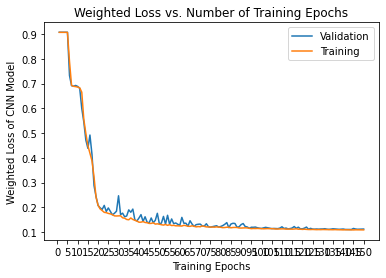




Fold- 4 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.657278, dice: 0.932087, loss: 0.904606


num_epochs:   1%|▍                                                                   | 1/150 [00:28<1:10:47, 28.51s/it]

val: bce: 0.657249, dice: 0.931694, loss: 0.904250
saving best model
Total time: 0:00:28.511521
Epoch time: 0m 29s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.657169, dice: 0.932088, loss: 0.904596


num_epochs:   1%|▉                                                                   | 2/150 [00:57<1:10:23, 28.53s/it]

val: bce: 0.657139, dice: 0.931695, loss: 0.904239
saving best model
Total time: 0:00:57.063261
Epoch time: 0m 29s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.657057, dice: 0.932088, loss: 0.904585


num_epochs:   2%|█▎                                                                  | 3/150 [01:25<1:09:47, 28.49s/it]

val: bce: 0.657025, dice: 0.931696, loss: 0.904229
saving best model
Total time: 0:01:25.490999
Epoch time: 0m 28s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.656941, dice: 0.932089, loss: 0.904574


num_epochs:   3%|█▊                                                                  | 4/150 [01:53<1:09:19, 28.49s/it]

val: bce: 0.656907, dice: 0.931697, loss: 0.904218
saving best model
Total time: 0:01:53.989666
Epoch time: 0m 28s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.656819, dice: 0.932090, loss: 0.904563


num_epochs:   3%|██▎                                                                 | 5/150 [02:22<1:08:51, 28.49s/it]

val: bce: 0.656781, dice: 0.931698, loss: 0.904206
saving best model
Total time: 0:02:22.487837
Epoch time: 0m 28s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.335357, dice: 0.853940, loss: 0.802081


num_epochs:   4%|██▋                                                                 | 6/150 [02:50<1:08:23, 28.50s/it]

val: bce: 0.172402, dice: 0.817736, loss: 0.753203
saving best model
Total time: 0:02:50.999401
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.129317, dice: 0.759577, loss: 0.696551


num_epochs:   5%|███▏                                                                | 7/150 [03:20<1:08:27, 28.72s/it]

val: bce: 0.177796, dice: 0.755800, loss: 0.698000
saving best model
Total time: 0:03:20.185027
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.144882, dice: 0.752763, loss: 0.691975


num_epochs:   5%|███▋                                                                | 8/150 [03:53<1:11:03, 30.03s/it]

val: bce: 0.178049, dice: 0.759360, loss: 0.701229
Total time: 0:03:53.003853
Epoch time: 0m 33s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.140159, dice: 0.749965, loss: 0.688984


num_epochs:   6%|████                                                                | 9/150 [04:21<1:09:33, 29.60s/it]

val: bce: 0.134296, dice: 0.754819, loss: 0.692767
saving best model
Total time: 0:04:21.650824
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.142744, dice: 0.751140, loss: 0.690301


num_epochs:   7%|████▍                                                              | 10/150 [04:50<1:08:22, 29.31s/it]

val: bce: 0.268454, dice: 0.772814, loss: 0.722378
Total time: 0:04:50.306227
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.142047, dice: 0.747452, loss: 0.686912


num_epochs:   7%|████▉                                                              | 11/150 [05:18<1:07:21, 29.08s/it]

val: bce: 0.149776, dice: 0.769763, loss: 0.707765
Total time: 0:05:18.871358
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.136531, dice: 0.732924, loss: 0.673285


num_epochs:   8%|█████▎                                                             | 12/150 [05:47<1:06:29, 28.91s/it]

val: bce: 2.503179, dice: 0.995137, loss: 1.145941
Total time: 0:05:47.394329
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.078977, dice: 0.537630, loss: 0.491765


num_epochs:   9%|█████▊                                                             | 13/150 [06:15<1:05:46, 28.81s/it]

val: bce: 0.066767, dice: 0.543060, loss: 0.495431
saving best model
Total time: 0:06:15.969380
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.075209, dice: 0.503590, loss: 0.460752


num_epochs:   9%|██████▎                                                            | 14/150 [06:44<1:05:04, 28.71s/it]

val: bce: 0.230124, dice: 0.599096, loss: 0.562199
Total time: 0:06:44.457631
Epoch time: 0m 28s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.071552, dice: 0.478464, loss: 0.437773


num_epochs:  10%|██████▋                                                            | 15/150 [07:12<1:04:27, 28.65s/it]

val: bce: 0.128686, dice: 0.498811, loss: 0.461799
saving best model
Total time: 0:07:12.962746
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.069806, dice: 0.466577, loss: 0.426900


num_epochs:  11%|███████▏                                                           | 16/150 [07:41<1:03:53, 28.61s/it]

val: bce: 0.074592, dice: 0.463836, loss: 0.424911
saving best model
Total time: 0:07:41.469845
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.064463, dice: 0.453245, loss: 0.414367


num_epochs:  11%|███████▌                                                           | 17/150 [08:09<1:03:19, 28.57s/it]

val: bce: 0.078366, dice: 0.448152, loss: 0.411174
saving best model
Total time: 0:08:09.955119
Epoch time: 0m 28s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.059250, dice: 0.437769, loss: 0.399917


num_epochs:  12%|████████                                                           | 18/150 [08:38<1:02:44, 28.52s/it]

val: bce: 0.131721, dice: 0.484870, loss: 0.449555
Total time: 0:08:38.363515
Epoch time: 0m 28s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.053707, dice: 0.425603, loss: 0.388413


num_epochs:  13%|████████▍                                                          | 19/150 [09:07<1:02:22, 28.56s/it]

val: bce: 0.092675, dice: 0.440913, loss: 0.406090
saving best model
Total time: 0:09:07.029830
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.058319, dice: 0.422269, loss: 0.385874


num_epochs:  13%|████████▉                                                          | 20/150 [09:35<1:01:49, 28.53s/it]

val: bce: 0.065513, dice: 0.432248, loss: 0.395574
saving best model
Total time: 0:09:35.489808
Epoch time: 0m 28s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.046996, dice: 0.403961, loss: 0.368264


num_epochs:  14%|█████████▍                                                         | 21/150 [10:03<1:01:18, 28.52s/it]

val: bce: 0.051502, dice: 0.395831, loss: 0.361398
saving best model
Total time: 0:10:03.968139
Epoch time: 0m 28s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.099986, dice: 0.430149, loss: 0.397133


num_epochs:  15%|█████████▊                                                         | 22/150 [10:32<1:00:47, 28.49s/it]

val: bce: 0.047966, dice: 0.421660, loss: 0.384290
Total time: 0:10:32.404807
Epoch time: 0m 28s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.041400, dice: 0.412280, loss: 0.375192


num_epochs:  15%|██████████▎                                                        | 23/150 [11:00<1:00:18, 28.49s/it]

val: bce: 0.043161, dice: 0.403984, loss: 0.367902
Total time: 0:11:00.892066
Epoch time: 0m 28s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.042631, dice: 0.377296, loss: 0.343829


num_epochs:  16%|███████████                                                          | 24/150 [11:29<59:49, 28.49s/it]

val: bce: 0.146931, dice: 0.357233, loss: 0.336203
saving best model
Total time: 0:11:29.368908
Epoch time: 0m 28s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.169439, dice: 0.360016, loss: 0.340958


num_epochs:  17%|███████████▌                                                         | 25/150 [11:57<59:20, 28.48s/it]

val: bce: 0.071478, dice: 0.399327, loss: 0.366542
Total time: 0:11:57.838807
Epoch time: 0m 28s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.112493, dice: 0.290188, loss: 0.272419


num_epochs:  17%|███████████▉                                                         | 26/150 [12:26<58:52, 28.49s/it]

val: bce: 0.251240, dice: 0.226682, loss: 0.229137
saving best model
Total time: 0:12:26.336978
Epoch time: 0m 28s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.281832, dice: 0.247746, loss: 0.251155


num_epochs:  18%|████████████▍                                                        | 27/150 [12:54<58:24, 28.49s/it]

val: bce: 0.256063, dice: 0.190847, loss: 0.197368
saving best model
Total time: 0:12:54.842589
Epoch time: 0m 29s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.136249, dice: 0.168451, loss: 0.165231


num_epochs:  19%|████████████▉                                                        | 28/150 [13:23<57:54, 28.48s/it]

val: bce: 0.103083, dice: 0.160442, loss: 0.154706
saving best model
Total time: 0:13:23.284216
Epoch time: 0m 28s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.095996, dice: 0.154307, loss: 0.148476


num_epochs:  19%|█████████████▎                                                       | 29/150 [13:51<57:22, 28.45s/it]

val: bce: 0.093289, dice: 0.162446, loss: 0.155530
Total time: 0:13:51.670786
Epoch time: 0m 28s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.084098, dice: 0.148035, loss: 0.141642


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:20<56:55, 28.46s/it]

val: bce: 0.088374, dice: 0.155042, loss: 0.148375
saving best model
Total time: 0:14:20.154078
Epoch time: 0m 28s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.080156, dice: 0.147577, loss: 0.140835


num_epochs:  21%|██████████████▎                                                      | 31/150 [14:48<56:28, 28.48s/it]

val: bce: 0.098989, dice: 0.157098, loss: 0.151287
Total time: 0:14:48.669113
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.077928, dice: 0.144448, loss: 0.137796


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:17<56:00, 28.48s/it]

val: bce: 0.083036, dice: 0.160096, loss: 0.152390
Total time: 0:15:17.157860
Epoch time: 0m 28s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.074235, dice: 0.145026, loss: 0.137947


num_epochs:  22%|███████████████▏                                                     | 33/150 [15:45<55:31, 28.48s/it]

val: bce: 0.070753, dice: 0.142954, loss: 0.135734
saving best model
Total time: 0:15:45.631727
Epoch time: 0m 28s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.069084, dice: 0.139167, loss: 0.132159


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:14<55:03, 28.48s/it]

val: bce: 0.074834, dice: 0.161408, loss: 0.152751
Total time: 0:16:14.116010
Epoch time: 0m 28s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.065833, dice: 0.140459, loss: 0.132996


num_epochs:  23%|████████████████                                                     | 35/150 [16:42<54:34, 28.48s/it]

val: bce: 0.101775, dice: 0.170633, loss: 0.163747
Total time: 0:16:42.588389
Epoch time: 0m 28s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.066327, dice: 0.140102, loss: 0.132724


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:11<54:05, 28.47s/it]

val: bce: 0.132806, dice: 0.203097, loss: 0.196068
Total time: 0:17:11.039439
Epoch time: 0m 28s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.067261, dice: 0.142575, loss: 0.135043


num_epochs:  25%|█████████████████                                                    | 37/150 [17:39<53:39, 28.49s/it]

val: bce: 0.080785, dice: 0.146903, loss: 0.140291
Total time: 0:17:39.586219
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.062789, dice: 0.135949, loss: 0.128633


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:08<53:13, 28.51s/it]

val: bce: 0.065829, dice: 0.134216, loss: 0.127377
saving best model
Total time: 0:18:08.149365
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.059200, dice: 0.134320, loss: 0.126808


num_epochs:  26%|█████████████████▉                                                   | 39/150 [18:36<52:42, 28.50s/it]

val: bce: 0.059370, dice: 0.137163, loss: 0.129384
Total time: 0:18:36.601904
Epoch time: 0m 28s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.058240, dice: 0.134449, loss: 0.126828


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:05<52:15, 28.51s/it]

val: bce: 0.089171, dice: 0.146674, loss: 0.140924
Total time: 0:19:05.137276
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.058154, dice: 0.133822, loss: 0.126255


num_epochs:  27%|██████████████████▊                                                  | 41/150 [19:33<51:44, 28.48s/it]

val: bce: 0.055630, dice: 0.132987, loss: 0.125251
saving best model
Total time: 0:19:33.566006
Epoch time: 0m 28s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.056825, dice: 0.133062, loss: 0.125438


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:02<51:14, 28.47s/it]

val: bce: 0.070425, dice: 0.146552, loss: 0.138939
Total time: 0:20:02.003169
Epoch time: 0m 28s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.057821, dice: 0.135417, loss: 0.127658


num_epochs:  29%|███████████████████▊                                                 | 43/150 [20:30<50:45, 28.46s/it]

val: bce: 0.064184, dice: 0.142715, loss: 0.134862
Total time: 0:20:30.436364
Epoch time: 0m 28s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.054371, dice: 0.131580, loss: 0.123859


num_epochs:  29%|████████████████████▏                                                | 44/150 [20:58<50:17, 28.47s/it]

val: bce: 0.075456, dice: 0.208762, loss: 0.195431
Total time: 0:20:58.930071
Epoch time: 0m 28s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.100993, dice: 0.192003, loss: 0.182902


num_epochs:  30%|████████████████████▋                                                | 45/150 [21:27<49:48, 28.46s/it]

val: bce: 0.105383, dice: 0.169582, loss: 0.163162
Total time: 0:21:27.372690
Epoch time: 0m 28s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.064023, dice: 0.147801, loss: 0.139423


num_epochs:  31%|█████████████████████▏                                               | 46/150 [21:55<49:18, 28.45s/it]

val: bce: 0.254772, dice: 0.325988, loss: 0.318866
Total time: 0:21:55.796461
Epoch time: 0m 28s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.066294, dice: 0.152963, loss: 0.144296


num_epochs:  31%|█████████████████████▌                                               | 47/150 [22:24<48:49, 28.45s/it]

val: bce: 0.056610, dice: 0.152350, loss: 0.142776
Total time: 0:22:24.233128
Epoch time: 0m 28s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.057536, dice: 0.139691, loss: 0.131475


num_epochs:  32%|██████████████████████                                               | 48/150 [22:52<48:22, 28.45s/it]

val: bce: 0.065441, dice: 0.144657, loss: 0.136736
Total time: 0:22:52.704019
Epoch time: 0m 28s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.054604, dice: 0.135611, loss: 0.127510


num_epochs:  33%|██████████████████████▌                                              | 49/150 [23:21<47:53, 28.45s/it]

val: bce: 0.165567, dice: 0.197784, loss: 0.194562
Total time: 0:23:21.155070
Epoch time: 0m 28s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.056467, dice: 0.136675, loss: 0.128654


num_epochs:  33%|███████████████████████                                              | 50/150 [23:49<47:24, 28.45s/it]

val: bce: 0.056047, dice: 0.146651, loss: 0.137591
Epoch    45: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:23:49.583801
Epoch time: 0m 28s


----------
Epoch 50/149
LR 0.00025
train: bce: 0.054007, dice: 0.135384, loss: 0.127246


num_epochs:  34%|███████████████████████▍                                             | 51/150 [24:18<46:59, 28.48s/it]

val: bce: 0.048441, dice: 0.132336, loss: 0.123947
saving best model
Total time: 0:24:18.127604
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.00025
train: bce: 0.050858, dice: 0.131049, loss: 0.123029


num_epochs:  35%|███████████████████████▉                                             | 52/150 [24:46<46:31, 28.49s/it]

val: bce: 0.054219, dice: 0.130729, loss: 0.123078
saving best model
Total time: 0:24:46.642639
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.00025
train: bce: 0.051335, dice: 0.130421, loss: 0.122512


num_epochs:  35%|████████████████████████▍                                            | 53/150 [25:15<46:03, 28.49s/it]

val: bce: 0.049833, dice: 0.132095, loss: 0.123869
Total time: 0:25:15.149738
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.00025
train: bce: 0.050975, dice: 0.129695, loss: 0.121823


num_epochs:  36%|████████████████████████▊                                            | 54/150 [25:43<45:34, 28.49s/it]

val: bce: 0.053256, dice: 0.131968, loss: 0.124097
Total time: 0:25:43.618149
Epoch time: 0m 28s


----------
Epoch 54/149
LR 0.00025
train: bce: 0.050774, dice: 0.129895, loss: 0.121983


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:12<45:07, 28.50s/it]

val: bce: 0.049371, dice: 0.133424, loss: 0.125019
Total time: 0:26:12.146080
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.00025
train: bce: 0.051506, dice: 0.130092, loss: 0.122233


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [26:40<44:39, 28.50s/it]

val: bce: 0.066332, dice: 0.139109, loss: 0.131831
Total time: 0:26:40.658138
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.00025
train: bce: 0.050431, dice: 0.128854, loss: 0.121012


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:09<44:09, 28.49s/it]

val: bce: 0.073381, dice: 0.145453, loss: 0.138246
Total time: 0:27:09.115636
Epoch time: 0m 28s


----------
Epoch 57/149
LR 0.00025
train: bce: 0.051161, dice: 0.129856, loss: 0.121987


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [27:37<43:41, 28.50s/it]

val: bce: 0.051890, dice: 0.136861, loss: 0.128364
Total time: 0:27:37.633648
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.00025
train: bce: 0.050973, dice: 0.130203, loss: 0.122280


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:06<43:13, 28.51s/it]

val: bce: 0.056152, dice: 0.131716, loss: 0.124159
Total time: 0:28:06.157115
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.00025
train: bce: 0.049091, dice: 0.127730, loss: 0.119866


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [28:34<42:43, 28.49s/it]

val: bce: 0.050044, dice: 0.127458, loss: 0.119716
saving best model
Total time: 0:28:34.594774
Epoch time: 0m 28s


----------
Epoch 60/149
LR 0.00025
train: bce: 0.049540, dice: 0.127707, loss: 0.119890


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:03<42:15, 28.49s/it]

val: bce: 0.062280, dice: 0.140478, loss: 0.132658
Total time: 0:29:03.103361
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.00025
train: bce: 0.050759, dice: 0.128889, loss: 0.121076


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [29:31<41:45, 28.48s/it]

val: bce: 0.054536, dice: 0.132677, loss: 0.124863
Total time: 0:29:31.538540
Epoch time: 0m 28s


----------
Epoch 62/149
LR 0.00025
train: bce: 0.049687, dice: 0.128220, loss: 0.120366


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:00<41:18, 28.49s/it]

val: bce: 0.052617, dice: 0.130070, loss: 0.122325
Total time: 0:30:00.052583
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.00025
train: bce: 0.047599, dice: 0.126282, loss: 0.118414


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [30:28<40:49, 28.49s/it]

val: bce: 0.052184, dice: 0.131594, loss: 0.123653
Total time: 0:30:28.539841
Epoch time: 0m 28s


----------
Epoch 64/149
LR 0.00025
train: bce: 0.048597, dice: 0.127311, loss: 0.119439


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [30:57<40:22, 28.50s/it]

val: bce: 0.049949, dice: 0.131198, loss: 0.123073
Total time: 0:30:57.064797
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.00025
train: bce: 0.047571, dice: 0.126017, loss: 0.118172


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [31:25<39:52, 28.48s/it]

val: bce: 0.066040, dice: 0.146723, loss: 0.138655
Total time: 0:31:25.490056
Epoch time: 0m 28s


----------
Epoch 66/149
LR 0.00025
train: bce: 0.048321, dice: 0.127537, loss: 0.119616


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [31:53<39:24, 28.48s/it]

val: bce: 0.049976, dice: 0.127809, loss: 0.120025
Total time: 0:31:53.994179
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.00025
train: bce: 0.047659, dice: 0.125480, loss: 0.117698


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [32:22<38:56, 28.50s/it]

val: bce: 0.046897, dice: 0.127259, loss: 0.119222
saving best model
Total time: 0:32:22.517185
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.00025
train: bce: 0.046987, dice: 0.124809, loss: 0.117026


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [32:50<38:27, 28.49s/it]

val: bce: 0.050100, dice: 0.126431, loss: 0.118798
saving best model
Total time: 0:32:50.989529
Epoch time: 0m 28s


----------
Epoch 69/149
LR 0.00025
train: bce: 0.047276, dice: 0.124975, loss: 0.117206


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [33:19<37:59, 28.49s/it]

val: bce: 0.051242, dice: 0.126812, loss: 0.119255
Total time: 0:33:19.475796
Epoch time: 0m 28s


----------
Epoch 70/149
LR 0.00025
train: bce: 0.046925, dice: 0.124729, loss: 0.116949


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [33:47<37:28, 28.47s/it]

val: bce: 0.052910, dice: 0.130387, loss: 0.122639
Total time: 0:33:47.896590
Epoch time: 0m 28s


----------
Epoch 71/149
LR 0.00025
train: bce: 0.048114, dice: 0.125914, loss: 0.118134


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [34:16<37:00, 28.47s/it]

val: bce: 0.047905, dice: 0.127533, loss: 0.119570
Total time: 0:34:16.371945
Epoch time: 0m 28s


----------
Epoch 72/149
LR 0.00025
train: bce: 0.047161, dice: 0.125282, loss: 0.117470


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [34:44<36:31, 28.46s/it]

val: bce: 0.048179, dice: 0.129132, loss: 0.121037
Total time: 0:34:44.822996
Epoch time: 0m 28s


----------
Epoch 73/149
LR 0.00025
train: bce: 0.047397, dice: 0.125421, loss: 0.117619


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [35:13<36:04, 28.48s/it]

val: bce: 0.045986, dice: 0.128306, loss: 0.120074
Total time: 0:35:13.342495
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.00025
train: bce: 0.046560, dice: 0.124490, loss: 0.116697


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [35:41<35:36, 28.49s/it]

val: bce: 0.048031, dice: 0.123923, loss: 0.116334
saving best model
Total time: 0:35:41.856042
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.00025
train: bce: 0.045951, dice: 0.124063, loss: 0.116252


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [36:10<35:07, 28.48s/it]

val: bce: 0.049019, dice: 0.126688, loss: 0.118921
Total time: 0:36:10.296677
Epoch time: 0m 28s


----------
Epoch 76/149
LR 0.00025
train: bce: 0.045662, dice: 0.123008, loss: 0.115273


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [36:38<34:38, 28.48s/it]

val: bce: 0.050147, dice: 0.125494, loss: 0.117959
Total time: 0:36:38.781952
Epoch time: 0m 28s


----------
Epoch 77/149
LR 0.00025
train: bce: 0.045997, dice: 0.123281, loss: 0.115552


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [37:07<34:12, 28.50s/it]

val: bce: 0.045657, dice: 0.127582, loss: 0.119389
Total time: 0:37:07.333691
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.00025
train: bce: 0.045326, dice: 0.122858, loss: 0.115105


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [37:35<33:42, 28.49s/it]

val: bce: 0.059556, dice: 0.147763, loss: 0.138942
Total time: 0:37:35.807062
Epoch time: 0m 28s


----------
Epoch 79/149
LR 0.00025
train: bce: 0.046119, dice: 0.124547, loss: 0.116705


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:04<33:14, 28.49s/it]

val: bce: 0.070610, dice: 0.153790, loss: 0.145472
Total time: 0:38:04.304241
Epoch time: 0m 28s


----------
Epoch 80/149
LR 0.00025
train: bce: 0.047466, dice: 0.125937, loss: 0.118090


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [38:32<32:46, 28.50s/it]

val: bce: 0.049704, dice: 0.126417, loss: 0.118746
Total time: 0:38:32.830187
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.00025
train: bce: 0.045643, dice: 0.122321, loss: 0.114654


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:01<32:19, 28.52s/it]

val: bce: 0.052232, dice: 0.137685, loss: 0.129140
Total time: 0:39:01.396311
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.00025
train: bce: 0.044912, dice: 0.122423, loss: 0.114671


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [39:29<31:49, 28.50s/it]

val: bce: 0.050033, dice: 0.134602, loss: 0.126145
Total time: 0:39:29.855794
Epoch time: 0m 28s


----------
Epoch 83/149
LR 0.00025
train: bce: 0.045688, dice: 0.122785, loss: 0.115075


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [39:58<31:20, 28.49s/it]

val: bce: 0.047574, dice: 0.130379, loss: 0.122099
Epoch    79: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:39:58.319740
Epoch time: 0m 28s


----------
Epoch 84/149
LR 0.000125
train: bce: 0.043783, dice: 0.121079, loss: 0.113349


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [40:26<30:51, 28.49s/it]

val: bce: 0.044238, dice: 0.120444, loss: 0.112823
saving best model
Total time: 0:40:26.803528
Epoch time: 0m 28s


----------
Epoch 85/149
LR 0.000125
train: bce: 0.044070, dice: 0.120658, loss: 0.112999


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [40:55<30:23, 28.49s/it]

val: bce: 0.044074, dice: 0.122530, loss: 0.114684
Total time: 0:40:55.307155
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.000125
train: bce: 0.044370, dice: 0.120824, loss: 0.113179


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [41:23<29:54, 28.49s/it]

val: bce: 0.044788, dice: 0.121302, loss: 0.113651
Total time: 0:41:23.783502
Epoch time: 0m 28s


----------
Epoch 87/149
LR 0.000125
train: bce: 0.043698, dice: 0.120417, loss: 0.112745


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [41:52<29:26, 28.50s/it]

val: bce: 0.047915, dice: 0.127629, loss: 0.119657
Total time: 0:41:52.294568
Epoch time: 0m 29s


----------
Epoch 88/149
LR 0.000125
train: bce: 0.044033, dice: 0.120899, loss: 0.113212


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [42:20<28:58, 28.50s/it]

val: bce: 0.046208, dice: 0.122923, loss: 0.115252
Total time: 0:42:20.793235
Epoch time: 0m 28s


----------
Epoch 89/149
LR 0.000125
train: bce: 0.043659, dice: 0.120257, loss: 0.112597


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [42:49<28:29, 28.50s/it]

val: bce: 0.045160, dice: 0.123425, loss: 0.115599
Total time: 0:42:49.299342
Epoch time: 0m 29s


----------
Epoch 90/149
LR 0.000125
train: bce: 0.043603, dice: 0.120367, loss: 0.112690


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [43:17<28:00, 28.48s/it]

val: bce: 0.044513, dice: 0.120897, loss: 0.113259
Total time: 0:43:17.738489
Epoch time: 0m 28s


----------
Epoch 91/149
LR 0.000125
train: bce: 0.043827, dice: 0.120261, loss: 0.112618


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [43:46<27:30, 28.46s/it]

val: bce: 0.042954, dice: 0.120432, loss: 0.112684
saving best model
Total time: 0:43:46.163252
Epoch time: 0m 28s


----------
Epoch 92/149
LR 0.000125
train: bce: 0.043224, dice: 0.119983, loss: 0.112307


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [44:14<27:02, 28.47s/it]

val: bce: 0.043809, dice: 0.120722, loss: 0.113030
Total time: 0:44:14.643567
Epoch time: 0m 28s


----------
Epoch 93/149
LR 0.000125
train: bce: 0.043709, dice: 0.120085, loss: 0.112447


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [44:43<26:33, 28.45s/it]

val: bce: 0.048016, dice: 0.122585, loss: 0.115128
Total time: 0:44:43.054938
Epoch time: 0m 28s


----------
Epoch 94/149
LR 0.000125
train: bce: 0.043848, dice: 0.120672, loss: 0.112989


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [45:11<26:06, 28.49s/it]

val: bce: 0.043070, dice: 0.120850, loss: 0.113072
Total time: 0:45:11.628997
Epoch time: 0m 29s


----------
Epoch 95/149
LR 0.000125
train: bce: 0.042984, dice: 0.119415, loss: 0.111772


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [45:40<25:38, 28.48s/it]

val: bce: 0.051480, dice: 0.135977, loss: 0.127527
Total time: 0:45:40.098400
Epoch time: 0m 28s


----------
Epoch 96/149
LR 0.000125
train: bce: 0.043450, dice: 0.120477, loss: 0.112774


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [46:08<25:09, 28.47s/it]

val: bce: 0.046406, dice: 0.122007, loss: 0.114447
Total time: 0:46:08.551435
Epoch time: 0m 28s


----------
Epoch 97/149
LR 0.000125
train: bce: 0.043089, dice: 0.119211, loss: 0.111599


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [46:37<24:41, 28.48s/it]

val: bce: 0.044315, dice: 0.123387, loss: 0.115480
Total time: 0:46:37.058037
Epoch time: 0m 29s


----------
Epoch 98/149
LR 0.000125
train: bce: 0.043602, dice: 0.120228, loss: 0.112565


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [47:05<24:12, 28.48s/it]

val: bce: 0.044131, dice: 0.119621, loss: 0.112072
saving best model
Total time: 0:47:05.543808
Epoch time: 0m 28s


----------
Epoch 99/149
LR 0.000125
train: bce: 0.043749, dice: 0.120277, loss: 0.112624


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [47:34<23:43, 28.48s/it]

val: bce: 0.046455, dice: 0.122482, loss: 0.114880
Total time: 0:47:34.007260
Epoch time: 0m 28s


----------
Epoch 100/149
LR 0.000125
train: bce: 0.043124, dice: 0.119309, loss: 0.111691


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [48:02<23:14, 28.46s/it]

val: bce: 0.045051, dice: 0.125229, loss: 0.117212
Total time: 0:48:02.430039
Epoch time: 0m 28s


----------
Epoch 101/149
LR 0.000125
train: bce: 0.043436, dice: 0.119651, loss: 0.112029


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [48:30<22:45, 28.45s/it]

val: bce: 0.043091, dice: 0.119251, loss: 0.111635
saving best model
Total time: 0:48:30.867697
Epoch time: 0m 28s


----------
Epoch 102/149
LR 0.000125
train: bce: 0.042832, dice: 0.118853, loss: 0.111251


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [48:59<22:18, 28.47s/it]

val: bce: 0.043094, dice: 0.120966, loss: 0.113179
Total time: 0:48:59.378764
Epoch time: 0m 29s


----------
Epoch 103/149
LR 0.000125
train: bce: 0.042910, dice: 0.119482, loss: 0.111825


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [49:28<21:52, 28.52s/it]

val: bce: 0.046961, dice: 0.124689, loss: 0.116917
Total time: 0:49:28.027223
Epoch time: 0m 29s


----------
Epoch 104/149
LR 0.000125
train: bce: 0.044390, dice: 0.120667, loss: 0.113039


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [49:56<21:23, 28.52s/it]

val: bce: 0.043597, dice: 0.121834, loss: 0.114010
Total time: 0:49:56.525890
Epoch time: 0m 28s


----------
Epoch 105/149
LR 0.000125
train: bce: 0.042903, dice: 0.119509, loss: 0.111848


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [50:24<20:53, 28.49s/it]

val: bce: 0.042578, dice: 0.121544, loss: 0.113648
Total time: 0:50:24.968509
Epoch time: 0m 28s


----------
Epoch 106/149
LR 0.000125
train: bce: 0.043246, dice: 0.119084, loss: 0.111501


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [50:53<20:25, 28.50s/it]

val: bce: 0.042947, dice: 0.118501, loss: 0.110945
saving best model
Total time: 0:50:53.494456
Epoch time: 0m 29s


----------
Epoch 107/149
LR 0.000125
train: bce: 0.042522, dice: 0.118448, loss: 0.110855


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [51:21<19:55, 28.47s/it]

val: bce: 0.043942, dice: 0.120547, loss: 0.112887
Total time: 0:51:21.898387
Epoch time: 0m 28s


----------
Epoch 108/149
LR 0.000125
train: bce: 0.043010, dice: 0.118547, loss: 0.110993


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [51:50<19:28, 28.49s/it]

val: bce: 0.045635, dice: 0.119863, loss: 0.112441
Total time: 0:51:50.435246
Epoch time: 0m 29s


----------
Epoch 109/149
LR 0.000125
train: bce: 0.042827, dice: 0.118537, loss: 0.110966


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [52:18<18:58, 28.47s/it]

val: bce: 0.054695, dice: 0.133319, loss: 0.125457
Total time: 0:52:18.836697
Epoch time: 0m 28s


----------
Epoch 110/149
LR 0.000125
train: bce: 0.043640, dice: 0.120152, loss: 0.112501


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [52:47<18:30, 28.48s/it]

val: bce: 0.042796, dice: 0.118520, loss: 0.110947
Total time: 0:52:47.349748
Epoch time: 0m 29s


----------
Epoch 111/149
LR 0.000125
train: bce: 0.043177, dice: 0.119295, loss: 0.111684


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [53:15<18:02, 28.49s/it]

val: bce: 0.042956, dice: 0.118966, loss: 0.111365
Total time: 0:53:15.858334
Epoch time: 0m 29s


----------
Epoch 112/149
LR 0.000125
train: bce: 0.042658, dice: 0.118328, loss: 0.110761


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [53:44<17:33, 28.47s/it]

val: bce: 0.042734, dice: 0.118871, loss: 0.111257
Total time: 0:53:44.295498
Epoch time: 0m 28s


----------
Epoch 113/149
LR 0.000125
train: bce: 0.042593, dice: 0.118186, loss: 0.110626


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [54:12<17:04, 28.46s/it]

val: bce: 0.042206, dice: 0.118702, loss: 0.111053
Total time: 0:54:12.739108
Epoch time: 0m 28s


----------
Epoch 114/149
LR 0.000125
train: bce: 0.042367, dice: 0.118181, loss: 0.110600


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [54:41<16:37, 28.50s/it]

val: bce: 0.045890, dice: 0.121829, loss: 0.114235
Total time: 0:54:41.313167
Epoch time: 0m 29s


----------
Epoch 115/149
LR 0.000125
train: bce: 0.043041, dice: 0.118758, loss: 0.111186


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [55:09<16:08, 28.48s/it]

val: bce: 0.042713, dice: 0.118920, loss: 0.111299
Epoch   111: reducing learning rate of group 0 to 6.2500e-05.
Total time: 0:55:09.768682
Epoch time: 0m 28s


----------
Epoch 116/149
LR 6.25e-05
train: bce: 0.042024, dice: 0.117452, loss: 0.109909


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [55:38<15:39, 28.46s/it]

val: bce: 0.041233, dice: 0.117118, loss: 0.109530
saving best model
Total time: 0:55:38.169142
Epoch time: 0m 28s


----------
Epoch 117/149
LR 6.25e-05
train: bce: 0.042087, dice: 0.117276, loss: 0.109757


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [56:06<15:10, 28.46s/it]

val: bce: 0.042566, dice: 0.118012, loss: 0.110467
Total time: 0:56:06.641024
Epoch time: 0m 28s


----------
Epoch 118/149
LR 6.25e-05
train: bce: 0.041823, dice: 0.117254, loss: 0.109711


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [56:35<14:42, 28.47s/it]

val: bce: 0.044356, dice: 0.119387, loss: 0.111884
Total time: 0:56:35.120347
Epoch time: 0m 28s


----------
Epoch 119/149
LR 6.25e-05
train: bce: 0.041671, dice: 0.117071, loss: 0.109531


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [57:03<14:14, 28.48s/it]

val: bce: 0.041557, dice: 0.117193, loss: 0.109629
Total time: 0:57:03.615046
Epoch time: 0m 28s


----------
Epoch 120/149
LR 6.25e-05
train: bce: 0.042083, dice: 0.117182, loss: 0.109672


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [57:32<13:45, 28.46s/it]

val: bce: 0.041660, dice: 0.117107, loss: 0.109563
Total time: 0:57:32.041296
Epoch time: 0m 28s


----------
Epoch 121/149
LR 6.25e-05
train: bce: 0.041609, dice: 0.116948, loss: 0.109414


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [58:00<13:17, 28.47s/it]

val: bce: 0.043172, dice: 0.117836, loss: 0.110370
Total time: 0:58:00.534012
Epoch time: 0m 28s


----------
Epoch 122/149
LR 6.25e-05
train: bce: 0.041587, dice: 0.116797, loss: 0.109276


num_epochs:  82%|███████████████████████████████████████████████████████▊            | 123/150 [58:28<12:48, 28.46s/it]

val: bce: 0.042857, dice: 0.118622, loss: 0.111045
Total time: 0:58:28.974647
Epoch time: 0m 28s


----------
Epoch 123/149
LR 6.25e-05
train: bce: 0.042177, dice: 0.117074, loss: 0.109584


num_epochs:  83%|████████████████████████████████████████████████████████▏           | 124/150 [58:57<12:20, 28.48s/it]

val: bce: 0.045956, dice: 0.118835, loss: 0.111547
Total time: 0:58:57.485714
Epoch time: 0m 29s


----------
Epoch 124/149
LR 6.25e-05
train: bce: 0.041985, dice: 0.117084, loss: 0.109574


num_epochs:  83%|████████████████████████████████████████████████████████▋           | 125/150 [59:25<11:51, 28.48s/it]

val: bce: 0.043235, dice: 0.117657, loss: 0.110215
Total time: 0:59:25.971981
Epoch time: 0m 28s


----------
Epoch 125/149
LR 6.25e-05
train: bce: 0.042016, dice: 0.117007, loss: 0.109508


num_epochs:  84%|█████████████████████████████████████████████████████████           | 126/150 [59:54<11:23, 28.47s/it]

val: bce: 0.041874, dice: 0.117426, loss: 0.109871
Total time: 0:59:54.413112
Epoch time: 0m 28s


----------
Epoch 126/149
LR 6.25e-05
train: bce: 0.041803, dice: 0.116902, loss: 0.109392


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:00:22<10:54, 28.48s/it]

val: bce: 0.041829, dice: 0.116788, loss: 0.109292
saving best model
Total time: 1:00:22.906323
Epoch time: 0m 28s


----------
Epoch 127/149
LR 6.25e-05
train: bce: 0.041766, dice: 0.116630, loss: 0.109144


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:00:51<10:26, 28.47s/it]

val: bce: 0.043512, dice: 0.117784, loss: 0.110357
Total time: 1:00:51.350430
Epoch time: 0m 28s


----------
Epoch 128/149
LR 6.25e-05
train: bce: 0.041586, dice: 0.116763, loss: 0.109245


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:01:19<09:57, 28.46s/it]

val: bce: 0.042617, dice: 0.117301, loss: 0.109832
Total time: 1:01:19.808921
Epoch time: 0m 28s


----------
Epoch 129/149
LR 6.25e-05
train: bce: 0.041946, dice: 0.116843, loss: 0.109353


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:01:48<09:28, 28.44s/it]

val: bce: 0.043255, dice: 0.119660, loss: 0.112020
Total time: 1:01:48.191028
Epoch time: 0m 28s


----------
Epoch 130/149
LR 6.25e-05
train: bce: 0.042203, dice: 0.117704, loss: 0.110154


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:02:16<09:00, 28.45s/it]

val: bce: 0.041718, dice: 0.117149, loss: 0.109606
Total time: 1:02:16.650014
Epoch time: 0m 28s


----------
Epoch 131/149
LR 6.25e-05
train: bce: 0.041773, dice: 0.116785, loss: 0.109284


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:02:45<08:32, 28.46s/it]

val: bce: 0.041773, dice: 0.117174, loss: 0.109634
Total time: 1:02:45.148682
Epoch time: 0m 28s


----------
Epoch 132/149
LR 6.25e-05
train: bce: 0.041718, dice: 0.116665, loss: 0.109170


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:03:13<08:03, 28.47s/it]

val: bce: 0.041945, dice: 0.117515, loss: 0.109958
Total time: 1:03:13.636436
Epoch time: 0m 28s


----------
Epoch 133/149
LR 6.25e-05
train: bce: 0.041301, dice: 0.116406, loss: 0.108895


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:03:42<07:35, 28.48s/it]

val: bce: 0.040830, dice: 0.117382, loss: 0.109727
Total time: 1:03:42.127663
Epoch time: 0m 28s


----------
Epoch 134/149
LR 6.25e-05
train: bce: 0.041308, dice: 0.116265, loss: 0.108770


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:04:10<07:07, 28.48s/it]

val: bce: 0.042363, dice: 0.116525, loss: 0.109108
saving best model
Total time: 1:04:10.617402
Epoch time: 0m 28s


----------
Epoch 135/149
LR 6.25e-05
train: bce: 0.041598, dice: 0.116339, loss: 0.108865


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:04:39<06:38, 28.50s/it]

val: bce: 0.041171, dice: 0.116426, loss: 0.108901
saving best model
Total time: 1:04:39.156741
Epoch time: 0m 29s


----------
Epoch 136/149
LR 6.25e-05
train: bce: 0.041689, dice: 0.116303, loss: 0.108842


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:05:07<06:10, 28.48s/it]

val: bce: 0.042425, dice: 0.117970, loss: 0.110416
Total time: 1:05:07.601840
Epoch time: 0m 28s


----------
Epoch 137/149
LR 6.25e-05
train: bce: 0.041590, dice: 0.116411, loss: 0.108929


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:05:36<05:41, 28.48s/it]

val: bce: 0.042414, dice: 0.117926, loss: 0.110375
Total time: 1:05:36.085131
Epoch time: 0m 28s


----------
Epoch 138/149
LR 6.25e-05
train: bce: 0.041741, dice: 0.116621, loss: 0.109133


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:06:04<05:13, 28.48s/it]

val: bce: 0.043615, dice: 0.118359, loss: 0.110885
Total time: 1:06:04.544118
Epoch time: 0m 28s


----------
Epoch 139/149
LR 6.25e-05
train: bce: 0.041319, dice: 0.116474, loss: 0.108958


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:06:33<04:44, 28.49s/it]

val: bce: 0.043043, dice: 0.118398, loss: 0.110862
Total time: 1:06:33.072546
Epoch time: 0m 29s


----------
Epoch 140/149
LR 6.25e-05
train: bce: 0.042172, dice: 0.116769, loss: 0.109310


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:07:01<04:16, 28.52s/it]

val: bce: 0.043201, dice: 0.118489, loss: 0.110960
Total time: 1:07:01.644620
Epoch time: 0m 29s


----------
Epoch 141/149
LR 6.25e-05
train: bce: 0.041712, dice: 0.116254, loss: 0.108799


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:07:30<03:48, 28.51s/it]

val: bce: 0.041515, dice: 0.116259, loss: 0.108785
saving best model
Total time: 1:07:30.154695
Epoch time: 0m 29s


----------
Epoch 142/149
LR 6.25e-05
train: bce: 0.041617, dice: 0.116254, loss: 0.108790


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:07:58<03:19, 28.50s/it]

val: bce: 0.041998, dice: 0.115885, loss: 0.108496
saving best model
Total time: 1:07:58.614177
Epoch time: 0m 28s


----------
Epoch 143/149
LR 6.25e-05
train: bce: 0.041269, dice: 0.115982, loss: 0.108511


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:08:27<02:50, 28.49s/it]

val: bce: 0.041032, dice: 0.117011, loss: 0.109413
Total time: 1:08:27.080605
Epoch time: 0m 28s


----------
Epoch 144/149
LR 6.25e-05
train: bce: 0.041465, dice: 0.116138, loss: 0.108671


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:08:55<02:22, 28.49s/it]

val: bce: 0.041251, dice: 0.116930, loss: 0.109362
Total time: 1:08:55.569847
Epoch time: 0m 28s


----------
Epoch 145/149
LR 6.25e-05
train: bce: 0.041521, dice: 0.116172, loss: 0.108707


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:09:24<01:53, 28.48s/it]

val: bce: 0.043313, dice: 0.117165, loss: 0.109780
Total time: 1:09:24.037763
Epoch time: 0m 28s


----------
Epoch 146/149
LR 6.25e-05
train: bce: 0.041391, dice: 0.116055, loss: 0.108588


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:09:52<01:25, 28.48s/it]

val: bce: 0.044973, dice: 0.118477, loss: 0.111127
Total time: 1:09:52.502206
Epoch time: 0m 28s


----------
Epoch 147/149
LR 6.25e-05
train: bce: 0.041671, dice: 0.116298, loss: 0.108836


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:10:20<00:56, 28.48s/it]

val: bce: 0.040904, dice: 0.116334, loss: 0.108791
Total time: 1:10:20.977065
Epoch time: 0m 28s


----------
Epoch 148/149
LR 6.25e-05
train: bce: 0.041380, dice: 0.115752, loss: 0.108315


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:10:49<00:28, 28.48s/it]

val: bce: 0.040657, dice: 0.116039, loss: 0.108501
Total time: 1:10:49.466804
Epoch time: 0m 28s


----------
Epoch 149/149
LR 6.25e-05
train: bce: 0.041027, dice: 0.115639, loss: 0.108178


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:11:18<00:00, 28.52s/it]

val: bce: 0.043259, dice: 0.117825, loss: 0.110369
Total time: 1:11:18.078558
Epoch time: 0m 29s
Best val loss: 0.108496
model training finished, reinitializing training....



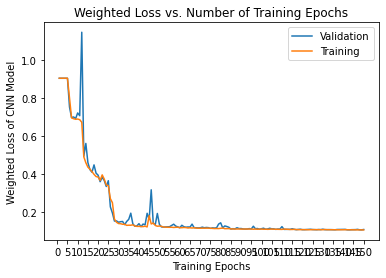

In [24]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
#     image_datasets['train'] = MyDataset(trainpath[0:3000])
#     image_datasets['val'] = MyDataset(testpath[0:600])
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    out_channel = 3
    in_channel = 1
    num_epochs = 150
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNetSmall(in_channel,out_channel)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=5e-6,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=5e-4,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=8, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=2e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=8, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=2e-7, eps=1e-08)       
        model, loss_hist_train, loss_hist_val,lr_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        print('model training finished, reinitializing training....\n')
#         print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []
    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Weighted Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Weighted Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()
    fname6 = 'cellSegmentationmodel-UNetSmall_rech_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [25]:
def SegmentationVisualGT(mask,image,ImgIdx):
    cmap = colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
    boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
#     print(mask.shape)
#     tempimage = np.squeeze(image)
#     tempimage[tempimage>0] = 1
#     mask2 = tempimage
    mask2 = mask[2] 
    mask1 = mask[1]
    mask0 = mask[0]
    MaskOverlay = mask0 + mask1 + mask2
#     print('MaskOverlay shape:', MaskOverlay.shape)
    # mask = np.transpose(ImgMask.numpy(), (1,2,0))
    # image = np.squeeze(image)
    # mask = ImgMask.numpy()
    # print(mask[:,0,0].sum())
#     print(mask.shape)
    # Imgmask= np.transpose(mask,(1,2,0))
    fig = plt.figure(figsize=(12, 60), dpi=100)
    plt.subplot(1, 4, 1)
    plt.imshow(MaskOverlay,cmap=cmap,norm=norm)
    plt.title('GT segmentation overlay ' + str(ImgIdx),fontsize=8)
    plt.subplot(1, 4, 2)
    plt.imshow(mask0*3,cmap=cmap,norm=norm)
    # tempmask = mask[0]
    # tempmask[tempmask < 3] = 0
    # mask[0] = tempmask
    plt.title('GT chromosome region ' + str(ImgIdx),fontsize=8)
    plt.subplot(1, 4, 3)
    plt.imshow(mask1*2,cmap=cmap,norm=norm)
    plt.title('GT nucleus region ' + str(ImgIdx),fontsize=8)
    plt.subplot(1, 4, 4)
    plt.imshow(mask2,cmap=cmap,norm=norm)
    plt.title('GT cell contour ' + str(ImgIdx),fontsize=8)
    plt.show()

#     import matplotlib as mpl
# #     fig = plt.figure(figsize=(30, 1), dpi=100)
#     fig, ax = plt.subplots(figsize=(30, 1))
#     fig.subplots_adjust(bottom=0.4,left=0.7)

#     cmap = mpl.colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
#     cmap.set_over('0.9')
#     cmap.set_under('0.75')

#     bounds = [0, 1, 2, 3, 4]
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                     norm=norm,
#                                     boundaries=[0] + bounds + [13],
#                                     extend='both',
#                                     ticks=bounds,
#                                     spacing='proportional',
#                                     orientation='horizontal')
#     cb2.set_label('Segmentation Label Intervals')
#     plt.show()

In [26]:
def SegmentationVisualPred(maskpred,imagepred,ImgIdx):
    cmap = colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
    boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

#     print(mask.shape)
#     tempimage = np.squeeze(imagepred)
#     tempimage[tempimage>0] = 1
#     mask2 = tempimage
    mask2 = maskpred[2] 
    mask1 = maskpred[1]
    mask0 = maskpred[0]
    MaskOverlay = mask0 + mask1 + mask2
#     print('MaskOverlay shape:', MaskOverlay.shape)
    # mask = np.transpose(ImgMask.numpy(), (1,2,0))
    # image = np.squeeze(image)
    # mask = ImgMask.numpy()
    # print(mask[:,0,0].sum())
#     print(mask.shape)
    # Imgmask= np.transpose(mask,(1,2,0))
    fig = plt.figure(figsize=(12, 60), dpi=100)
    plt.subplot(1, 4, 1)
    plt.imshow(MaskOverlay,cmap=cmap,norm=norm)
    plt.title('Pred segmentation overlay ' + str(ImgIdx),fontsize=10)
    plt.subplot(1, 4, 2)
    plt.imshow(mask0*3,cmap=cmap,norm=norm)
    # tempmask = mask[0]
    # tempmask[tempmask < 3] = 0
    # mask[0] = tempmask
    plt.title('Pred chromosome region ' + str(ImgIdx),fontsize=10)
    plt.subplot(1, 4, 3)
    plt.imshow(mask1*2,cmap=cmap,norm=norm)
    plt.title('Pred nucleus region ' + str(ImgIdx),fontsize=10)
    plt.subplot(1, 4, 4)
    plt.imshow(mask2,cmap=cmap,norm=norm)
    plt.title('Pred cell contour ' + str(ImgIdx),fontsize=10)
    plt.show()

    import matplotlib as mpl
#     fig = plt.figure(figsize=(30, 1), dpi=100)
    fig, ax = plt.subplots(figsize=(30, 1))
    fig.subplots_adjust(bottom=0.4,left=0.7)

    cmap = mpl.colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
    cmap.set_over('0.9')
    cmap.set_under('0.75')

    bounds = [0, 1, 2, 3, 4]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    boundaries=[0] + bounds + [13],
                                    extend='both',
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='horizontal')
    cb2.set_label('Segmentation Label Intervals')
    plt.show()

In [27]:
def clac_F1 (mask, maskpred): 
    maskbool = mask.astype(dtype=bool)
    maskpredbool = maskpred.astype(dtype=bool)
    intersection = np.zeros((maskbool.shape[0],))
    Precision = np.zeros((maskbool.shape[0],))
    Recall = np.zeros((maskbool.shape[0],))
    F1score = np.zeros((maskbool.shape[0],))
    for i in range (0,maskpredbool.shape[0]):
        intersection[i] = np.sum(np.logical_and(maskbool[i,:,:], maskpredbool[i,:,:]))
        Precision[i] = np.sum(intersection[i]) / np.sum(maskpredbool[i])
        if np.sum(maskbool[i]) == 0:
            Recall[i] = 0
        else:
            Recall[i] = np.sum(intersection[i]) / np.sum(maskbool[i])
        if (Precision[i] + Recall[i]) == 0:
            F1score[i] = 0
        else:
            F1score[i] = ((Precision[i] * Recall[i]) / (Precision[i] + Recall[i]))*2
    
    return Precision, Recall, F1score

In [28]:
import pandas as pd

df = pd.read_csv (r'training_loss_0.csv',header=None)
TrainLoss0 = df.to_numpy()
df = pd.read_csv (r'training_loss_1.csv',header=None)
TrainLoss1 = df.to_numpy()
df = pd.read_csv (r'training_loss_2.csv',header=None)
TrainLoss2 = df.to_numpy()
df = pd.read_csv (r'training_loss_3.csv',header=None)
TrainLoss3 = df.to_numpy()
df = pd.read_csv (r'./training_loss_4.csv',header=None)
TrainLoss4 = df.to_numpy()

df = pd.read_csv (r'validation_loss_0.csv',header=None)
ValLoss0 = df.to_numpy()
df = pd.read_csv (r'validation_loss_1.csv',header=None)
ValLoss1 = df.to_numpy()
df = pd.read_csv (r'validation_loss_2.csv',header=None)
ValLoss2 = df.to_numpy()
df = pd.read_csv (r'validation_loss_3.csv',header=None)
ValLoss3 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_4.csv',header=None)
ValLoss4 = df.to_numpy()

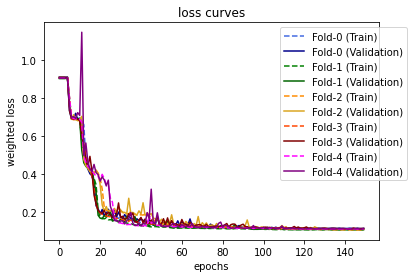

In [29]:
plt.figure()
plt.plot(TrainLoss0,label = 'Fold-0 (Train)', color='royalblue', linestyle = '--')
plt.plot(ValLoss0,label = 'Fold-0 (Validation)', color='darkblue', linestyle = '-')
plt.plot(TrainLoss1,label = 'Fold-1 (Train)', color='green', linestyle = '--')
plt.plot(ValLoss1,label = 'Fold-1 (Validation)', color='darkgreen', linestyle = '-')
plt.plot(TrainLoss2,label = 'Fold-2 (Train)', color='darkorange', linestyle = '--')
plt.plot(ValLoss2,label = 'Fold-2 (Validation)', color='goldenrod', linestyle = '-')
plt.plot(TrainLoss3,label = 'Fold-3 (Train)', color='orangered', linestyle = '--')
plt.plot(ValLoss3,label = 'Fold-3 (Validation)', color='maroon', linestyle = '-')
plt.plot(TrainLoss4,label = 'Fold-4 (Train)', color='magenta', linestyle = '--')
plt.plot(ValLoss4,label = 'Fold-4 (Validation)', color='purple', linestyle = '-')
plt.title('loss curves')
plt.xlabel('epochs')
plt.ylabel('weighted loss')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [30]:
df = pd.read_csv (r'./learning_rate_0.csv',header=None)
LearnRate0 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_1.csv',header=None)
LearnRate1 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_2.csv',header=None)
LearnRate2 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_3.csv',header=None)
LearnRate3 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_4.csv',header=None)
LearnRate4 = df.to_numpy()

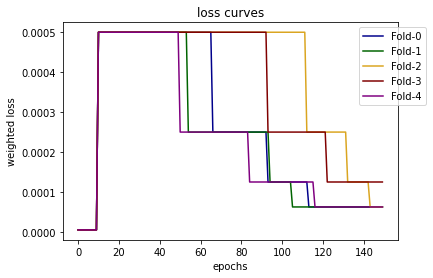

In [31]:
plt.figure()
plt.plot(LearnRate0,label = 'Fold-0', color='darkblue', linestyle = '-')
plt.plot(LearnRate1,label = 'Fold-1', color='darkgreen', linestyle = '-')
plt.plot(LearnRate2,label = 'Fold-2', color='goldenrod', linestyle = '-')
plt.plot(LearnRate3,label = 'Fold-3', color='maroon', linestyle = '-')
plt.plot(LearnRate4,label = 'Fold-4', color='purple', linestyle = '-')
plt.title('loss curves')
plt.xlabel('epochs')
plt.ylabel('weighted loss')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

Initializing Datasets and Dataloaders...


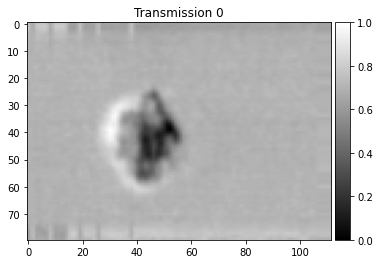

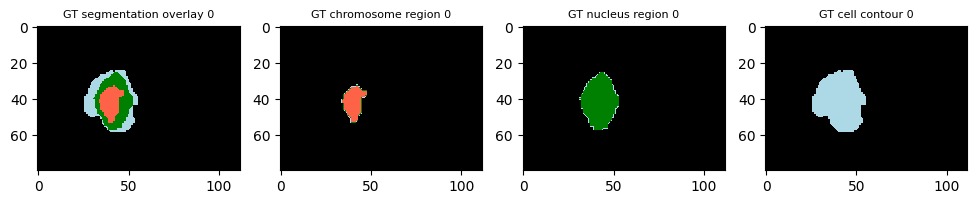

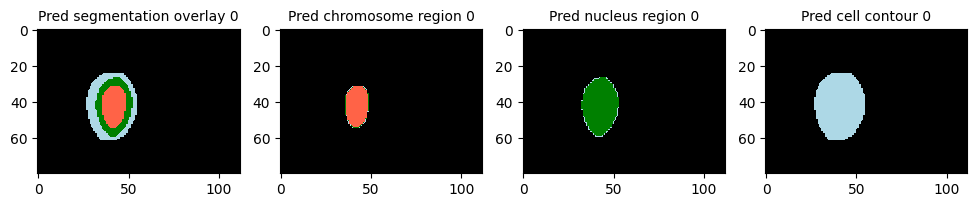

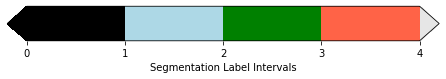

IoU score: 0.810, Chromesome F1score: 0.771, Nucleus F1score: 0.946, Cell F1score: 0.896, Chromesome precision: 0.656, Nucleus precision: 0.913, Cell precision: 0.839, Chromesome recall: 0.936, Nucleus recall: 0.981, Cell recall: 0.962


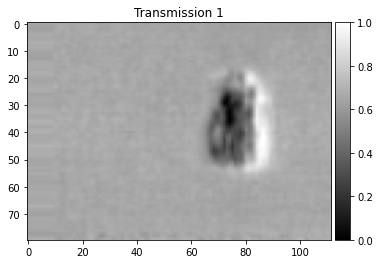

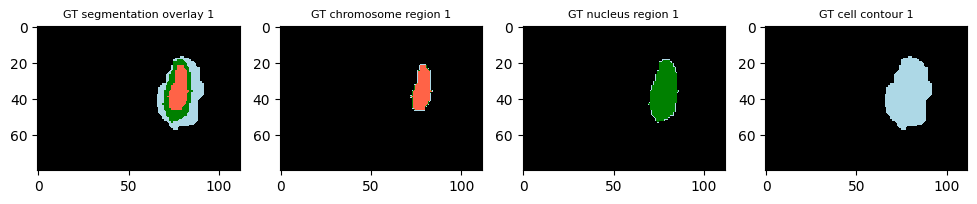

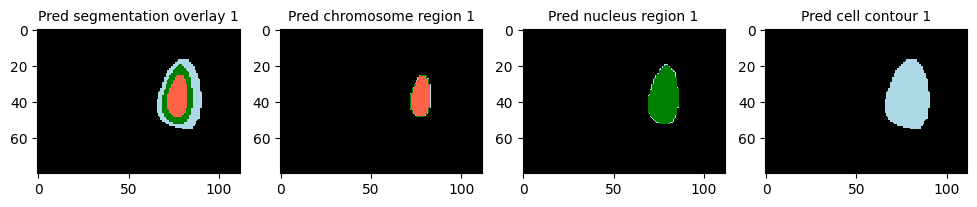

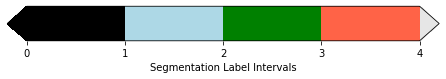

IoU score: 0.854, Chromesome F1score: 0.839, Nucleus F1score: 0.923, Cell F1score: 0.942, Chromesome precision: 0.824, Nucleus precision: 0.897, Cell precision: 0.949, Chromesome recall: 0.854, Nucleus recall: 0.950, Cell recall: 0.936


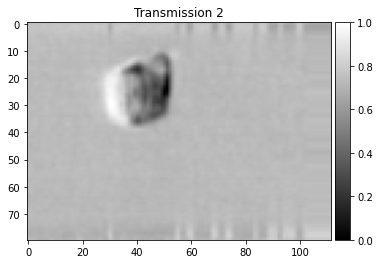

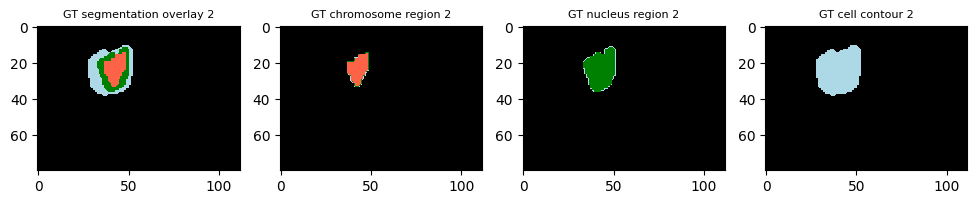

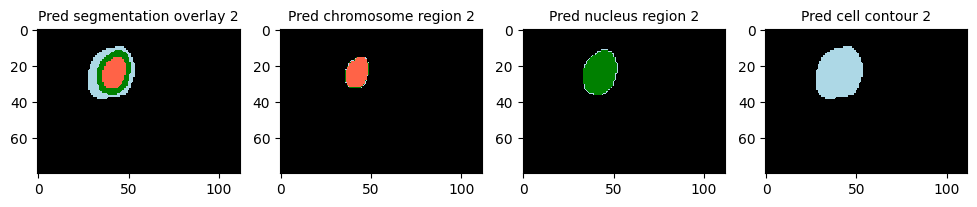

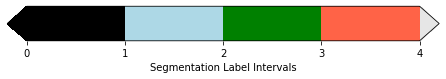

IoU score: 0.839, Chromesome F1score: 0.858, Nucleus F1score: 0.906, Cell F1score: 0.932, Chromesome precision: 0.793, Nucleus precision: 0.850, Cell precision: 0.896, Chromesome recall: 0.934, Nucleus recall: 0.969, Cell recall: 0.971


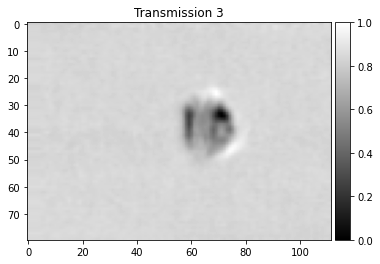

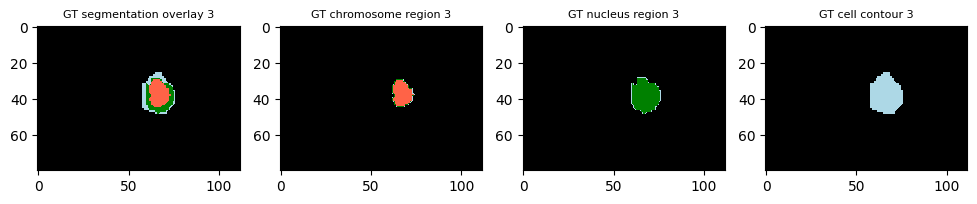

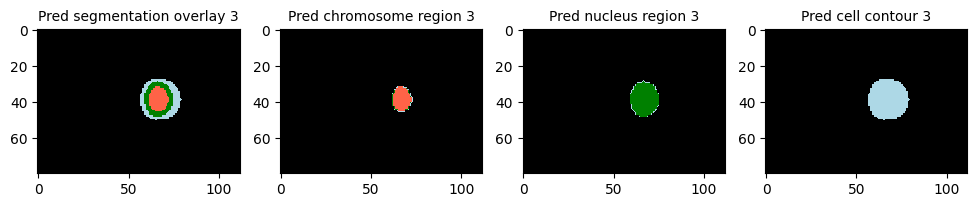

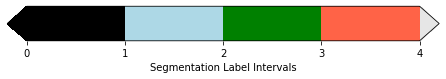

IoU score: 0.782, Chromesome F1score: 0.861, Nucleus F1score: 0.924, Cell F1score: 0.853, Chromesome precision: 0.915, Nucleus precision: 0.918, Cell precision: 0.763, Chromesome recall: 0.812, Nucleus recall: 0.930, Cell recall: 0.966


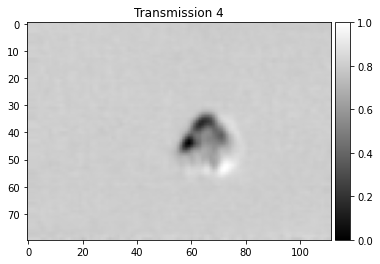

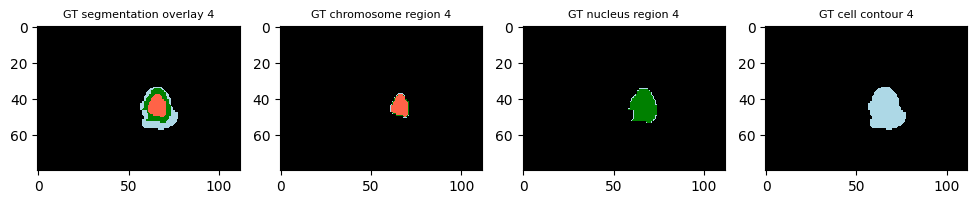

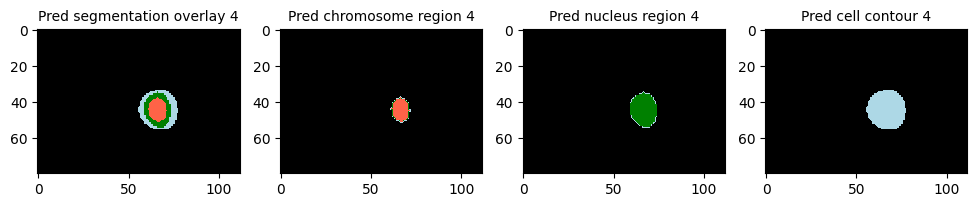

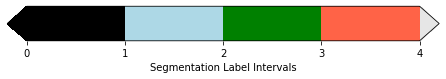

IoU score: 0.806, Chromesome F1score: 0.920, Nucleus F1score: 0.930, Cell F1score: 0.863, Chromesome precision: 0.893, Nucleus precision: 0.912, Cell precision: 0.847, Chromesome recall: 0.948, Nucleus recall: 0.949, Cell recall: 0.879


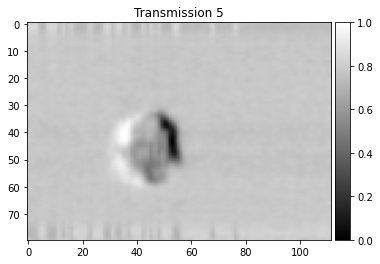

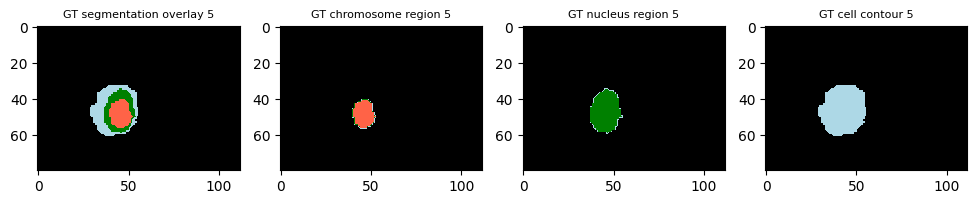

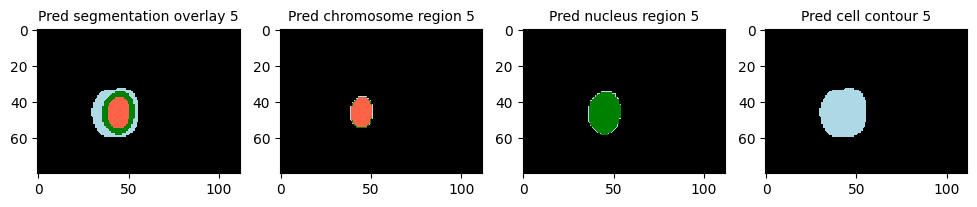

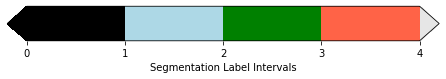

IoU score: 0.852, Chromesome F1score: 0.782, Nucleus F1score: 0.924, Cell F1score: 0.957, Chromesome precision: 0.743, Nucleus precision: 0.892, Cell precision: 0.956, Chromesome recall: 0.825, Nucleus recall: 0.959, Cell recall: 0.957


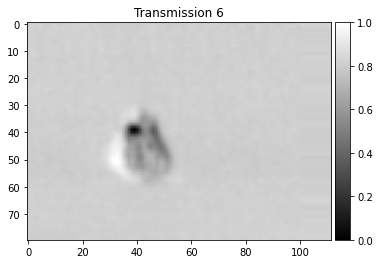

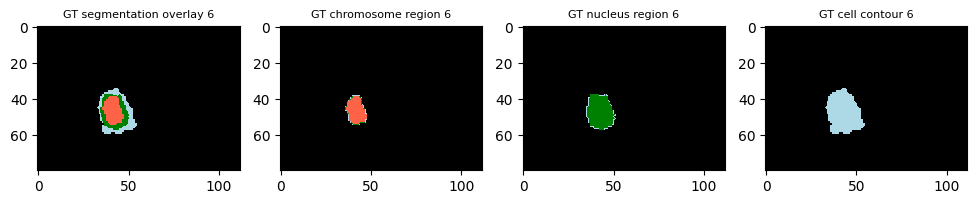

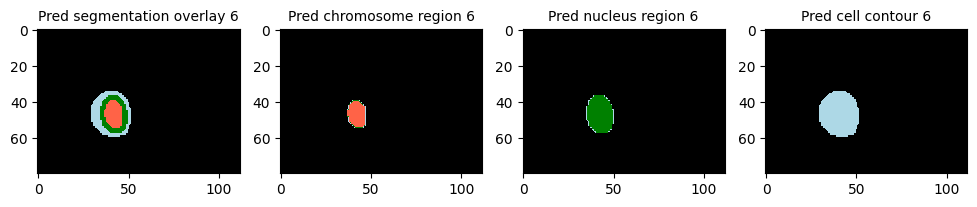

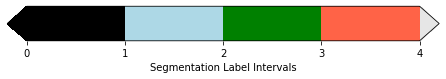

IoU score: 0.793, Chromesome F1score: 0.903, Nucleus F1score: 0.944, Cell F1score: 0.843, Chromesome precision: 0.943, Nucleus precision: 0.915, Cell precision: 0.775, Chromesome recall: 0.866, Nucleus recall: 0.975, Cell recall: 0.924


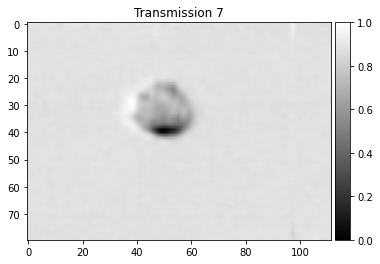

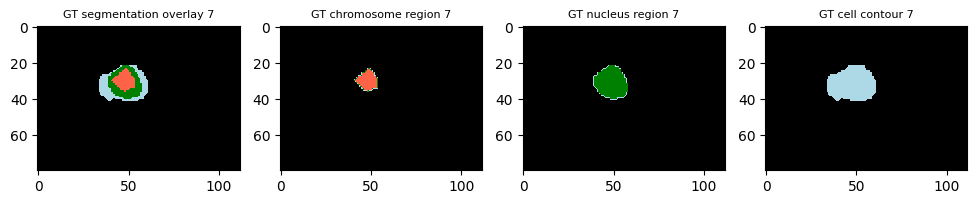

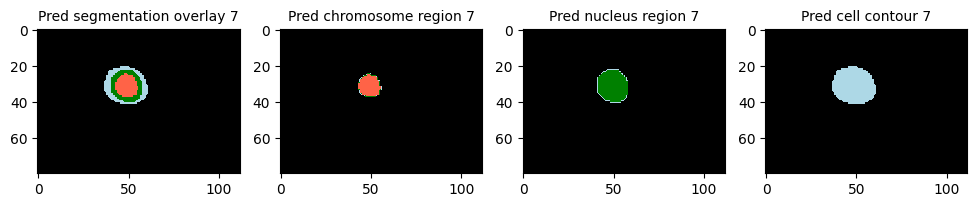

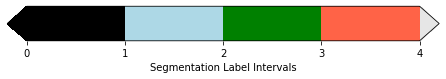

IoU score: 0.819, Chromesome F1score: 0.800, Nucleus F1score: 0.942, Cell F1score: 0.902, Chromesome precision: 0.724, Nucleus precision: 0.965, Cell precision: 0.933, Chromesome recall: 0.893, Nucleus recall: 0.921, Cell recall: 0.873


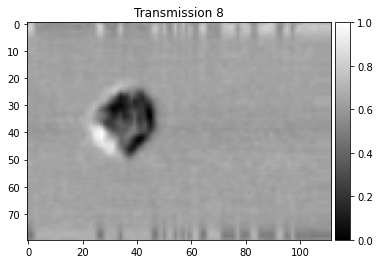

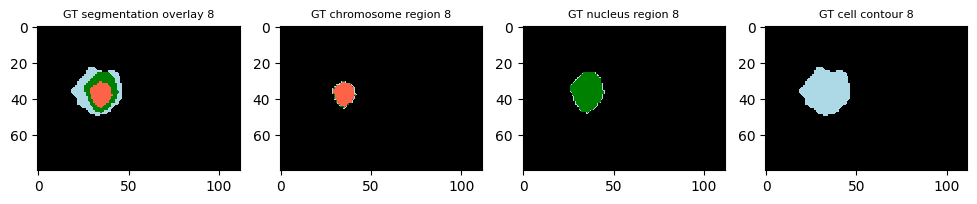

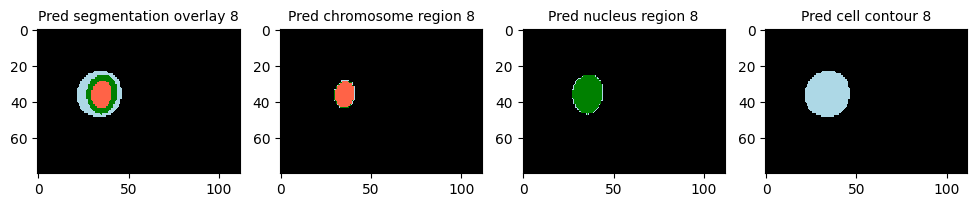

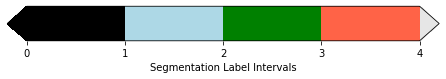

IoU score: 0.887, Chromesome F1score: 0.863, Nucleus F1score: 0.966, Cell F1score: 0.945, Chromesome precision: 0.837, Nucleus precision: 0.986, Cell precision: 0.974, Chromesome recall: 0.890, Nucleus recall: 0.947, Cell recall: 0.918


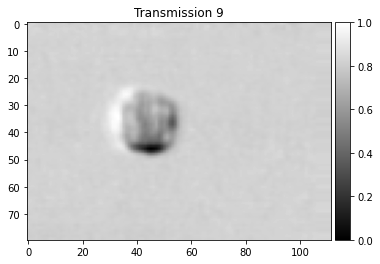

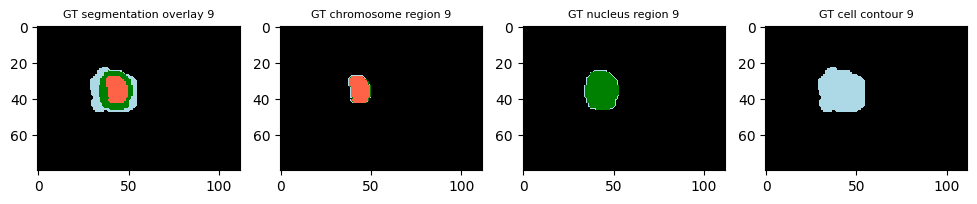

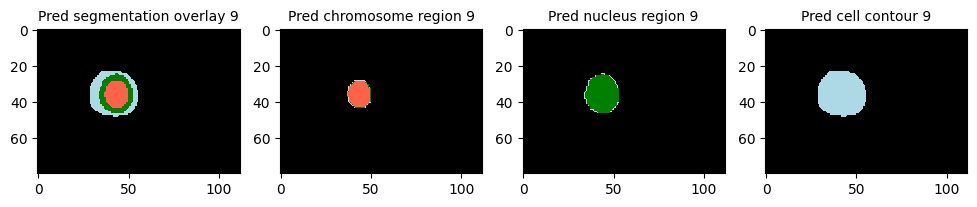

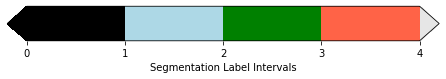

IoU score: 0.893, Chromesome F1score: 0.900, Nucleus F1score: 0.956, Cell F1score: 0.948, Chromesome precision: 0.886, Nucleus precision: 0.988, Cell precision: 0.939, Chromesome recall: 0.915, Nucleus recall: 0.927, Cell recall: 0.958


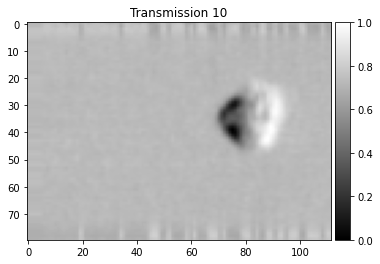

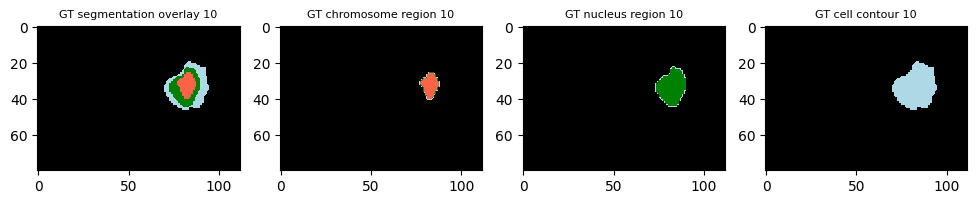

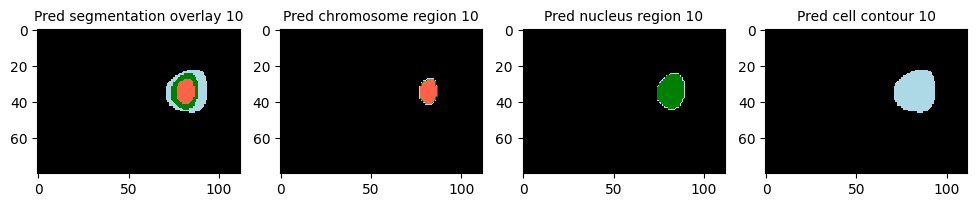

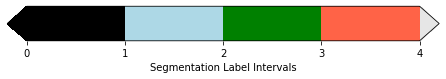

IoU score: 0.832, Chromesome F1score: 0.802, Nucleus F1score: 0.919, Cell F1score: 0.929, Chromesome precision: 0.763, Nucleus precision: 0.946, Cell precision: 0.941, Chromesome recall: 0.845, Nucleus recall: 0.894, Cell recall: 0.916


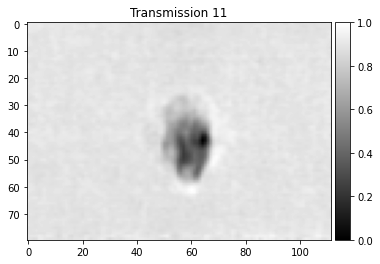

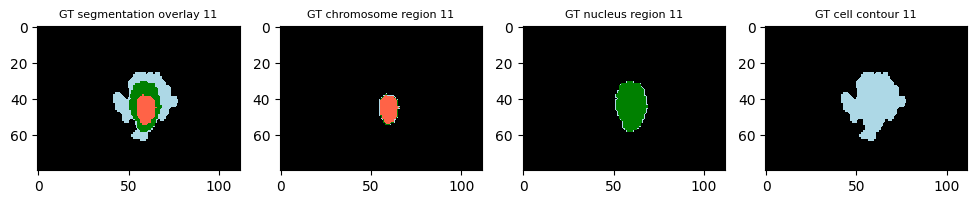

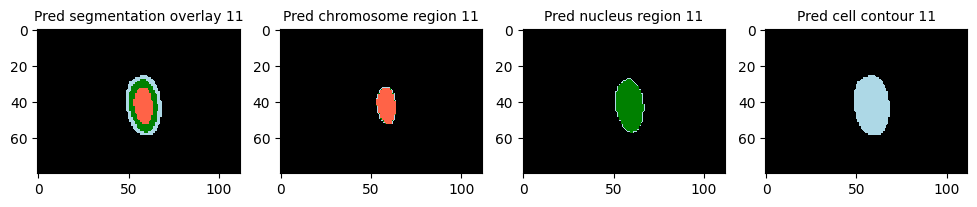

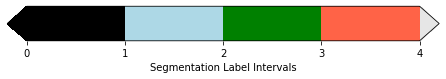

IoU score: 0.658, Chromesome F1score: 0.714, Nucleus F1score: 0.889, Cell F1score: 0.759, Chromesome precision: 0.647, Nucleus precision: 0.911, Cell precision: 0.940, Chromesome recall: 0.797, Nucleus recall: 0.869, Cell recall: 0.637


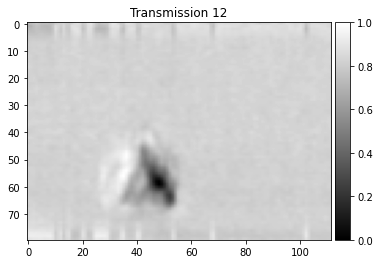

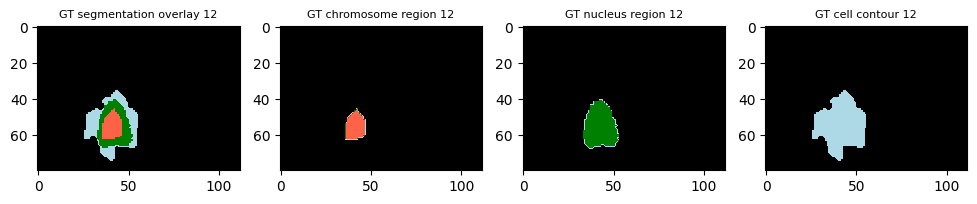

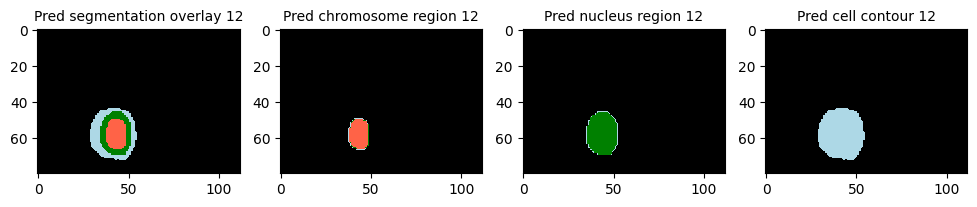

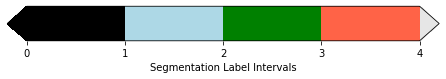

IoU score: 0.662, Chromesome F1score: 0.664, Nucleus F1score: 0.833, Cell F1score: 0.807, Chromesome precision: 0.626, Nucleus precision: 0.887, Cell precision: 0.874, Chromesome recall: 0.708, Nucleus recall: 0.786, Cell recall: 0.749


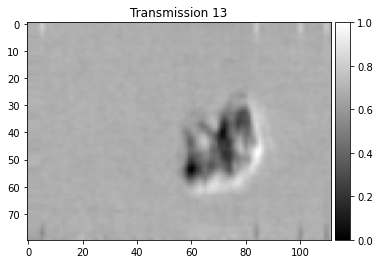

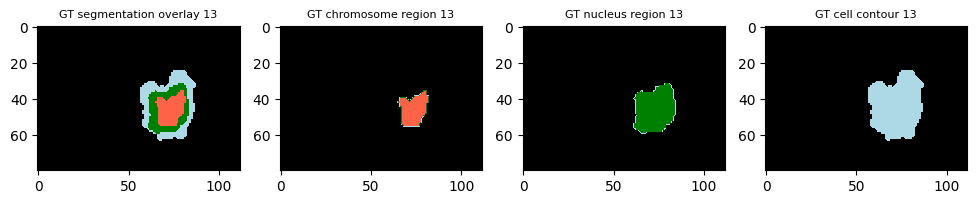

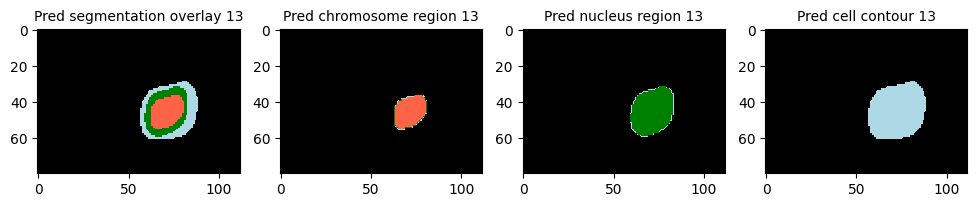

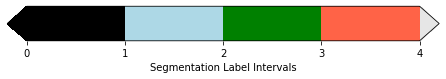

IoU score: 0.769, Chromesome F1score: 0.786, Nucleus F1score: 0.907, Cell F1score: 0.871, Chromesome precision: 0.726, Nucleus precision: 0.887, Cell precision: 0.901, Chromesome recall: 0.858, Nucleus recall: 0.927, Cell recall: 0.844


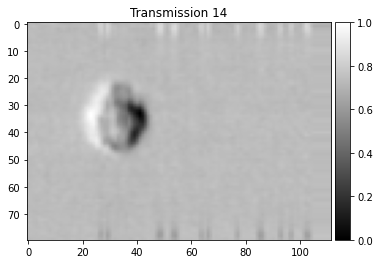

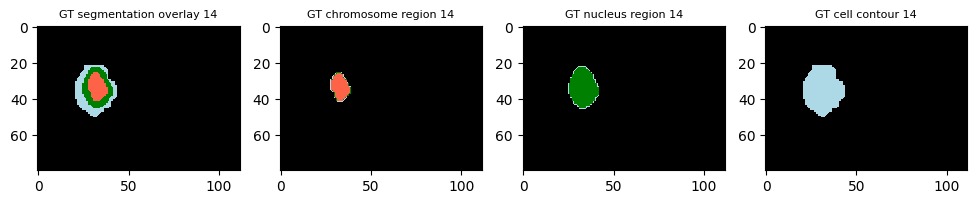

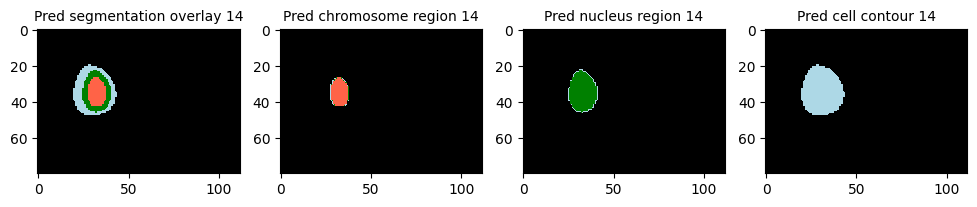

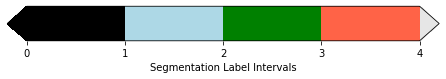

IoU score: 0.867, Chromesome F1score: 0.876, Nucleus F1score: 0.953, Cell F1score: 0.929, Chromesome precision: 0.843, Nucleus precision: 0.951, Cell precision: 0.906, Chromesome recall: 0.911, Nucleus recall: 0.954, Cell recall: 0.953


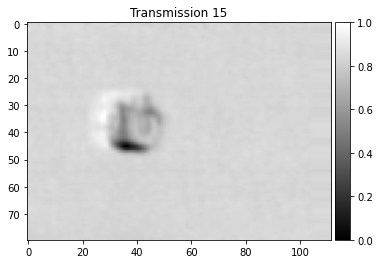

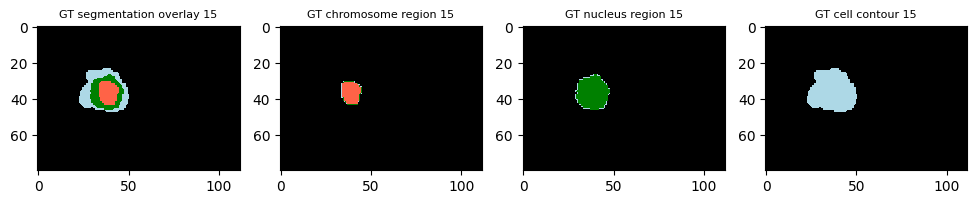

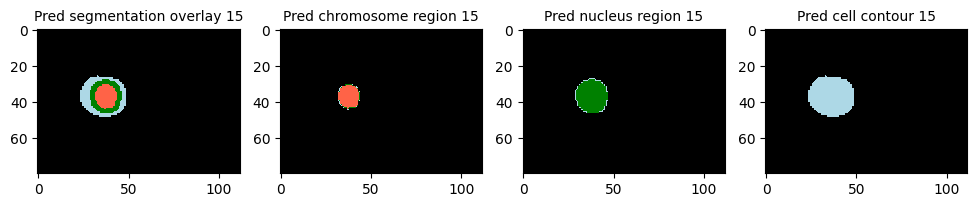

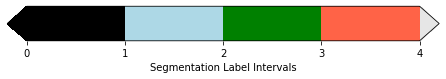

IoU score: 0.836, Chromesome F1score: 0.867, Nucleus F1score: 0.960, Cell F1score: 0.893, Chromesome precision: 0.837, Nucleus precision: 0.978, Cell precision: 0.939, Chromesome recall: 0.900, Nucleus recall: 0.943, Cell recall: 0.851


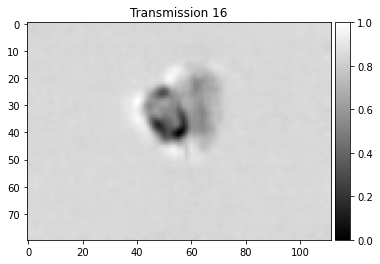

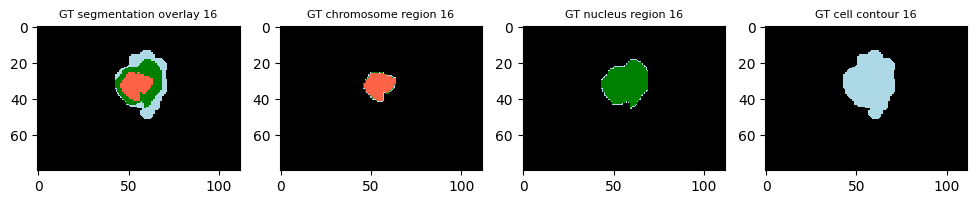

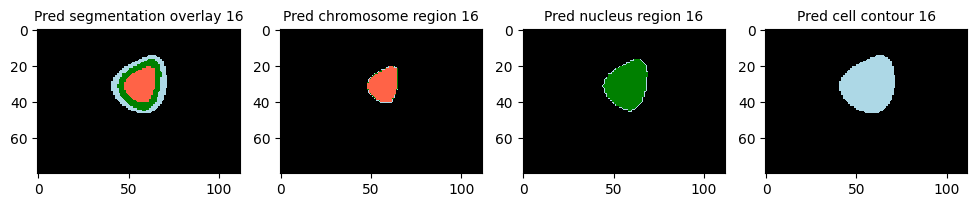

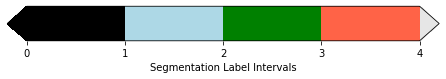

IoU score: 0.783, Chromesome F1score: 0.718, Nucleus F1score: 0.910, Cell F1score: 0.906, Chromesome precision: 0.635, Nucleus precision: 0.900, Cell precision: 0.915, Chromesome recall: 0.827, Nucleus recall: 0.920, Cell recall: 0.898


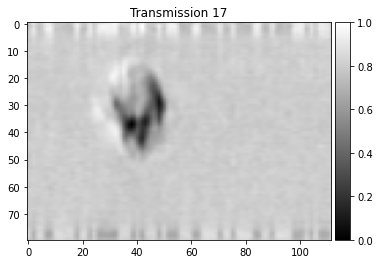

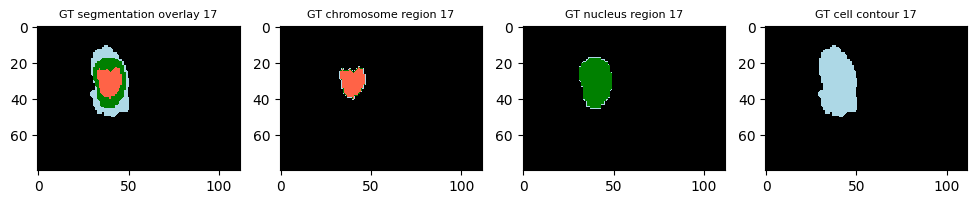

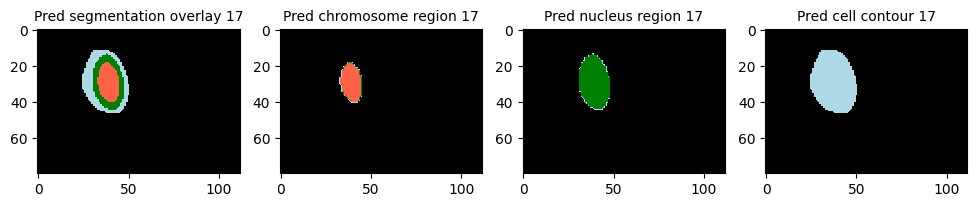

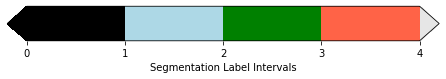

IoU score: 0.759, Chromesome F1score: 0.811, Nucleus F1score: 0.902, Cell F1score: 0.855, Chromesome precision: 0.762, Nucleus precision: 0.898, Cell precision: 0.827, Chromesome recall: 0.865, Nucleus recall: 0.906, Cell recall: 0.884


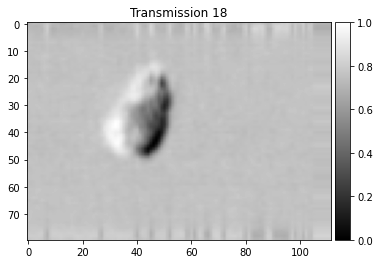

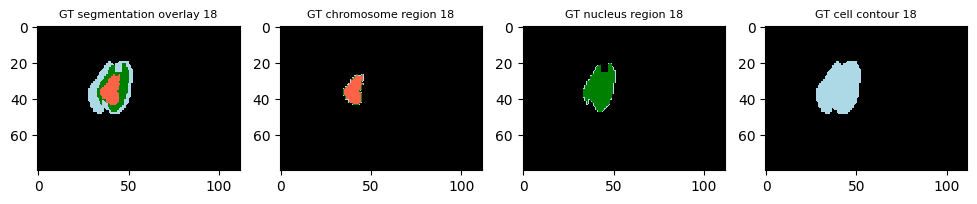

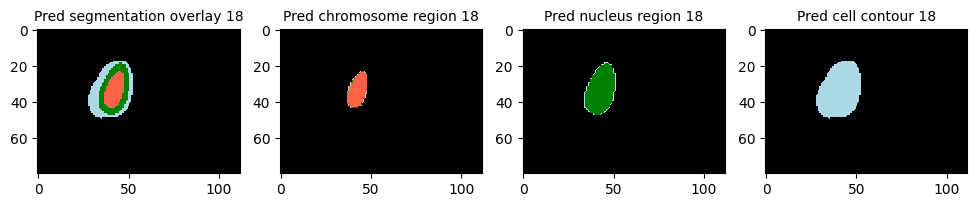

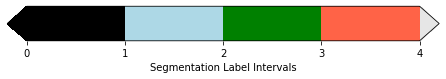

IoU score: 0.838, Chromesome F1score: 0.775, Nucleus F1score: 0.900, Cell F1score: 0.952, Chromesome precision: 0.687, Nucleus precision: 0.839, Cell precision: 0.916, Chromesome recall: 0.889, Nucleus recall: 0.971, Cell recall: 0.991


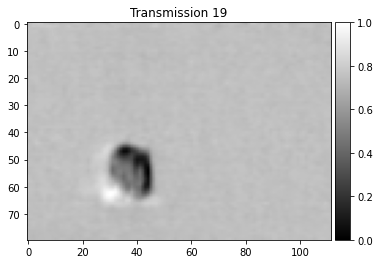

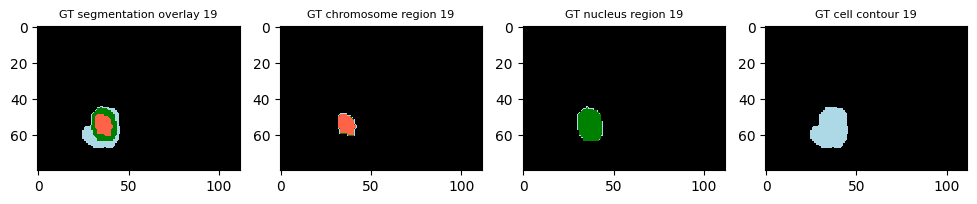

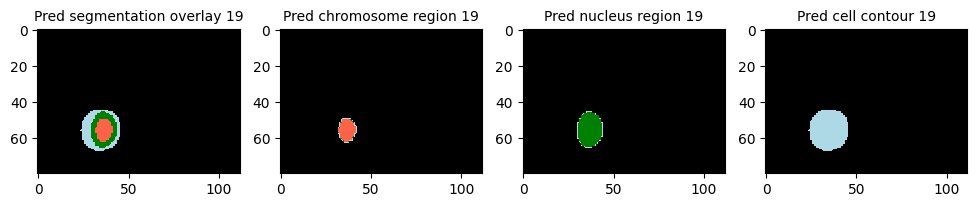

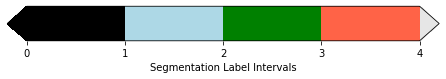

IoU score: 0.826, Chromesome F1score: 0.854, Nucleus F1score: 0.921, Cell F1score: 0.909, Chromesome precision: 0.837, Nucleus precision: 0.910, Cell precision: 0.868, Chromesome recall: 0.872, Nucleus recall: 0.931, Cell recall: 0.953
mean iou_score:  0.8219540871542831
mean precision chromesome:  0.778723932576678
mean precision nucleus:  0.915634458208076
mean precision cell:  0.905774664887783
mean recall chromesome:  0.8745762745154442
mean recall nucleus:  0.929809603478864
mean recall cell:  0.9220677083089839
mean F1score chromesome:  0.817463634611504
mean F1score nucleus:  0.9209617065448297
mean F1score cell:  0.9117937394078384
Initializing Datasets and Dataloaders...


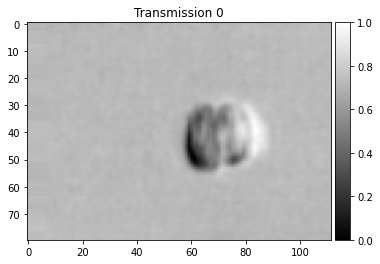

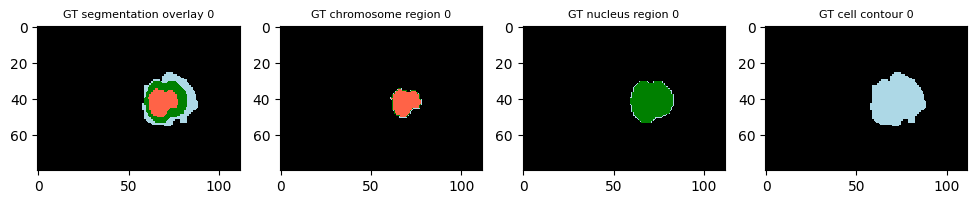

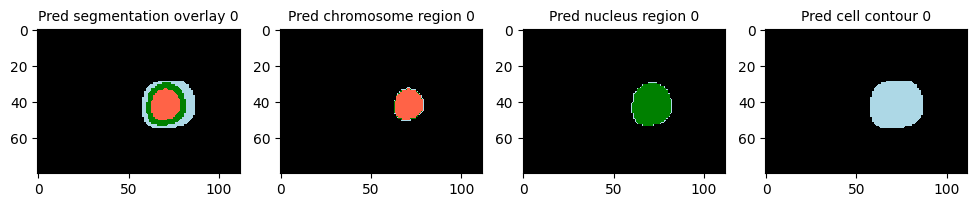

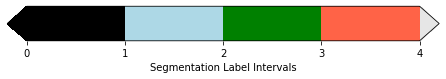

IoU score: 0.856, Chromesome F1score: 0.816, Nucleus F1score: 0.938, Cell F1score: 0.946, Chromesome precision: 0.748, Nucleus precision: 0.946, Cell precision: 0.956, Chromesome recall: 0.899, Nucleus recall: 0.930, Cell recall: 0.935


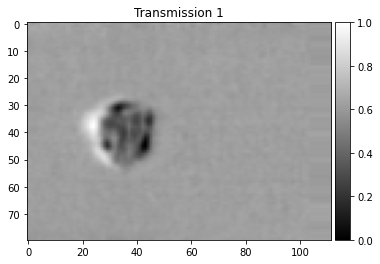

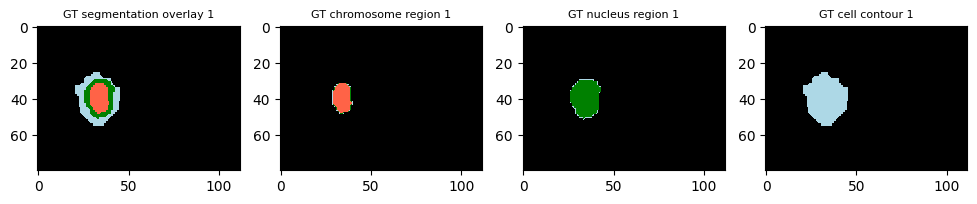

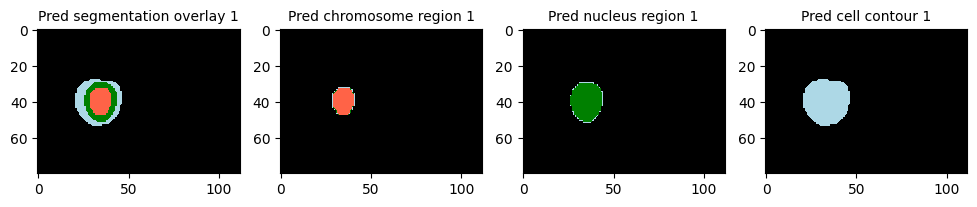

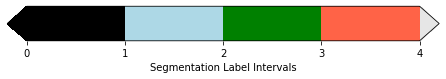

IoU score: 0.869, Chromesome F1score: 0.913, Nucleus F1score: 0.950, Cell F1score: 0.923, Chromesome precision: 0.889, Nucleus precision: 0.908, Cell precision: 0.904, Chromesome recall: 0.938, Nucleus recall: 0.997, Cell recall: 0.942


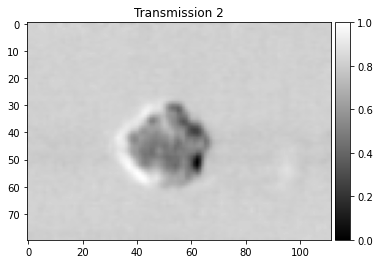

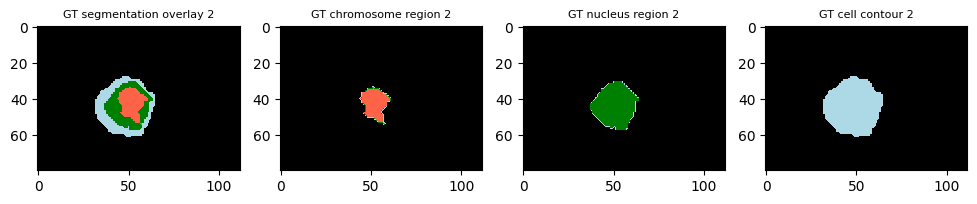

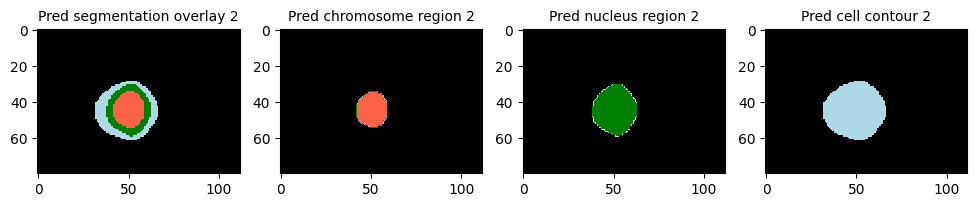

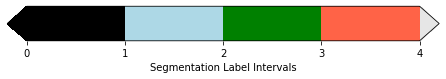

IoU score: 0.859, Chromesome F1score: 0.793, Nucleus F1score: 0.941, Cell F1score: 0.951, Chromesome precision: 0.691, Nucleus precision: 0.907, Cell precision: 0.925, Chromesome recall: 0.931, Nucleus recall: 0.978, Cell recall: 0.979


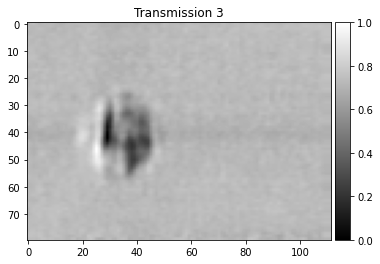

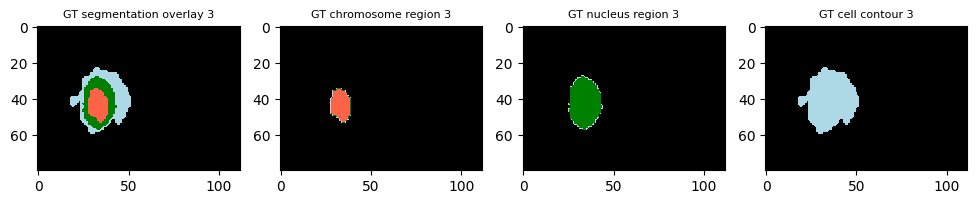

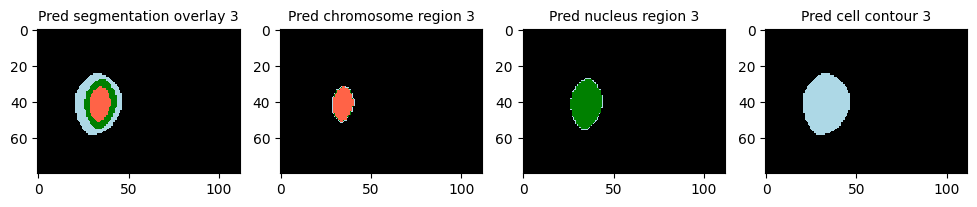

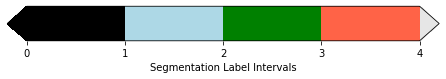

IoU score: 0.751, Chromesome F1score: 0.789, Nucleus F1score: 0.891, Cell F1score: 0.855, Chromesome precision: 0.760, Nucleus precision: 0.935, Cell precision: 0.923, Chromesome recall: 0.821, Nucleus recall: 0.850, Cell recall: 0.797


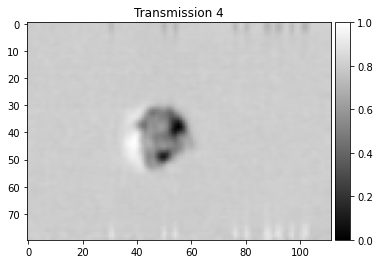

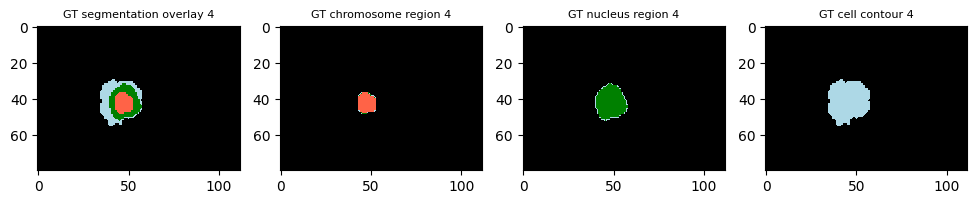

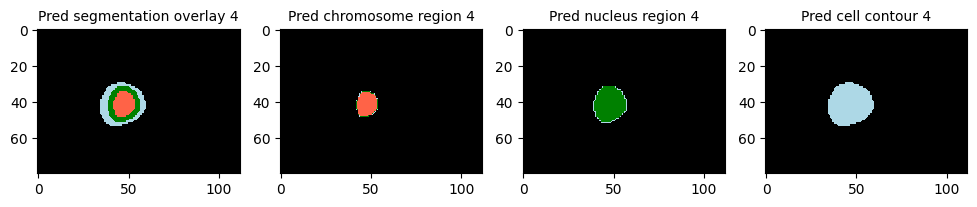

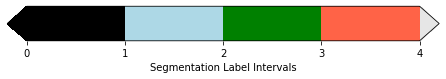

IoU score: 0.840, Chromesome F1score: 0.834, Nucleus F1score: 0.920, Cell F1score: 0.929, Chromesome precision: 0.726, Nucleus precision: 0.884, Cell precision: 0.915, Chromesome recall: 0.980, Nucleus recall: 0.958, Cell recall: 0.943


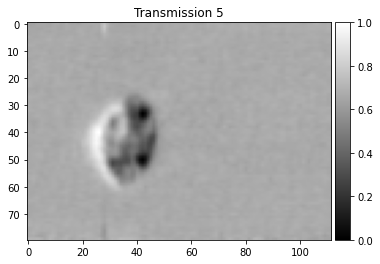

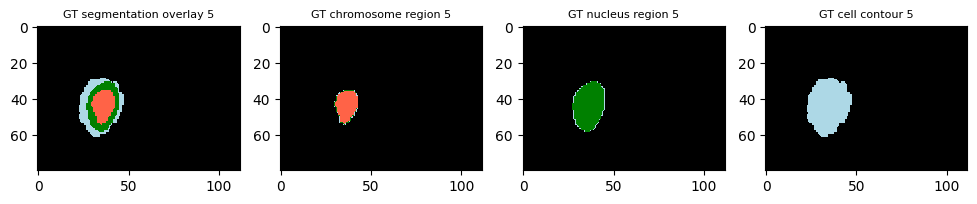

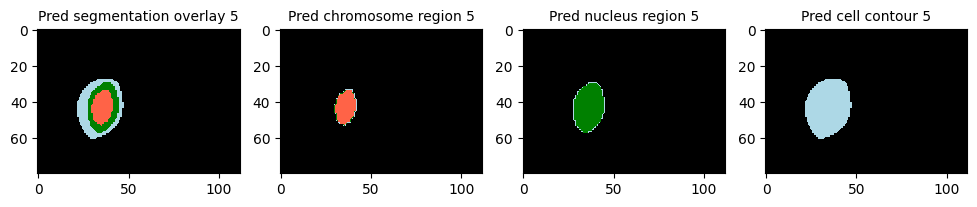

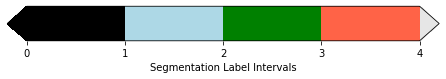

IoU score: 0.874, Chromesome F1score: 0.890, Nucleus F1score: 0.952, Cell F1score: 0.933, Chromesome precision: 0.892, Nucleus precision: 0.965, Cell precision: 0.892, Chromesome recall: 0.887, Nucleus recall: 0.939, Cell recall: 0.978


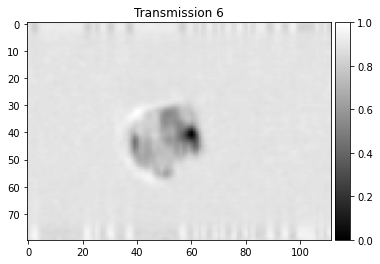

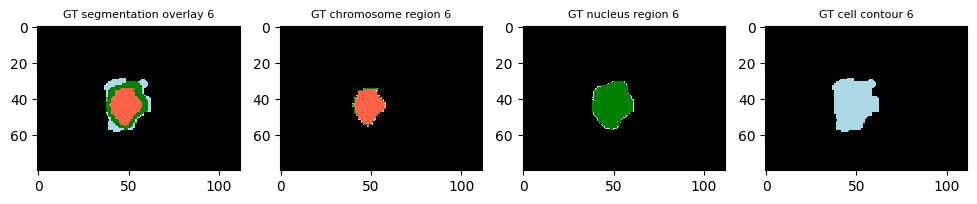

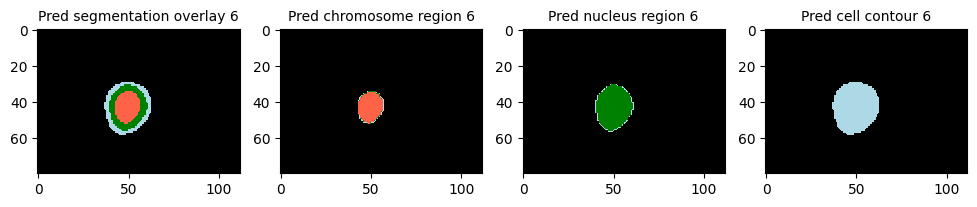

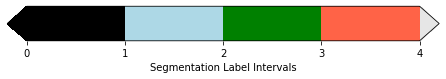

IoU score: 0.816, Chromesome F1score: 0.841, Nucleus F1score: 0.913, Cell F1score: 0.910, Chromesome precision: 0.959, Nucleus precision: 0.970, Cell precision: 0.910, Chromesome recall: 0.749, Nucleus recall: 0.863, Cell recall: 0.911


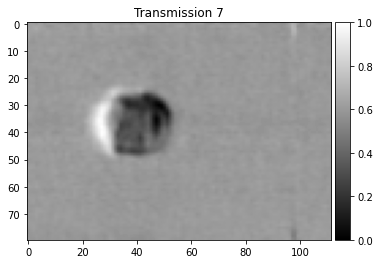

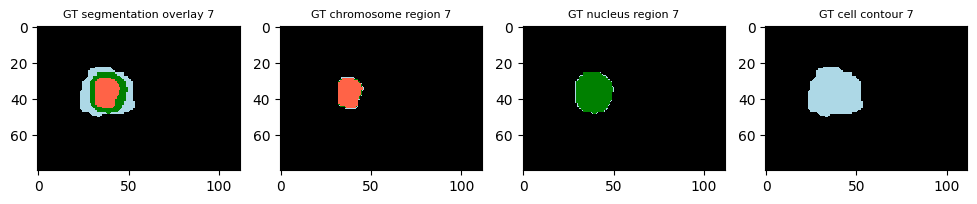

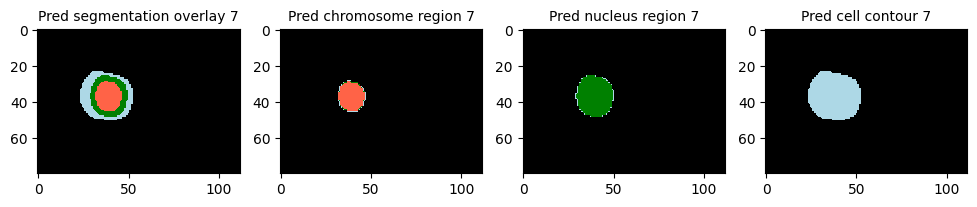

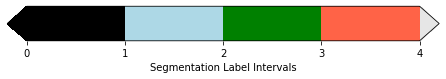

IoU score: 0.882, Chromesome F1score: 0.891, Nucleus F1score: 0.953, Cell F1score: 0.942, Chromesome precision: 0.884, Nucleus precision: 0.966, Cell precision: 0.958, Chromesome recall: 0.897, Nucleus recall: 0.941, Cell recall: 0.926


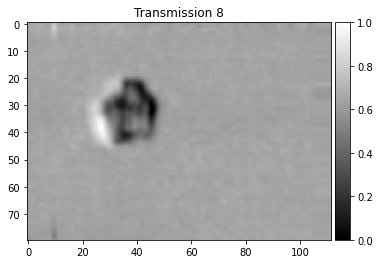

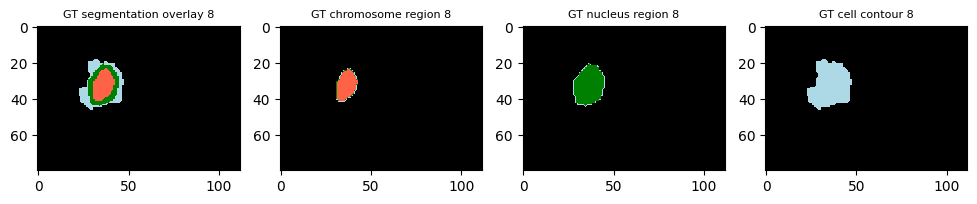

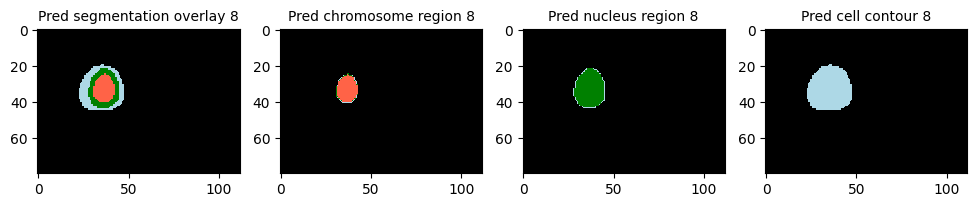

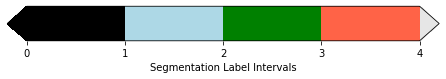

IoU score: 0.852, Chromesome F1score: 0.884, Nucleus F1score: 0.948, Cell F1score: 0.914, Chromesome precision: 0.905, Nucleus precision: 0.956, Cell precision: 0.894, Chromesome recall: 0.864, Nucleus recall: 0.940, Cell recall: 0.933


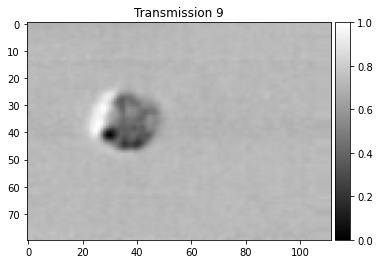

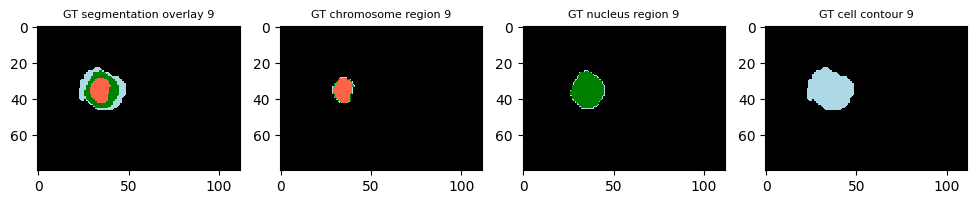

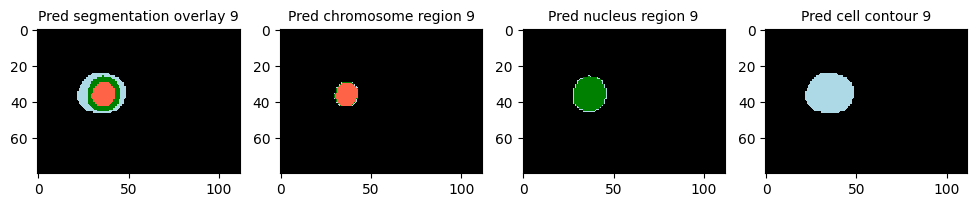

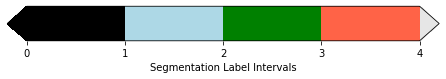

IoU score: 0.835, Chromesome F1score: 0.808, Nucleus F1score: 0.913, Cell F1score: 0.937, Chromesome precision: 0.766, Nucleus precision: 0.916, Cell precision: 0.907, Chromesome recall: 0.854, Nucleus recall: 0.910, Cell recall: 0.969


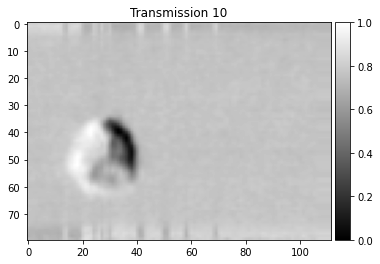

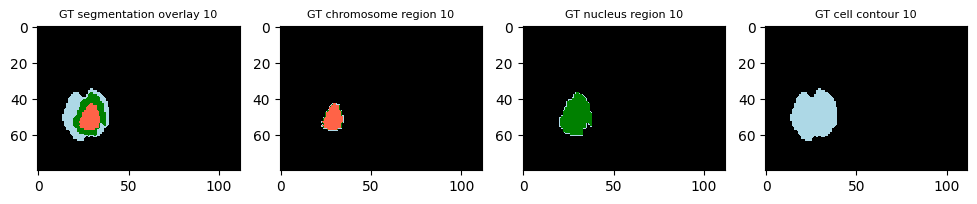

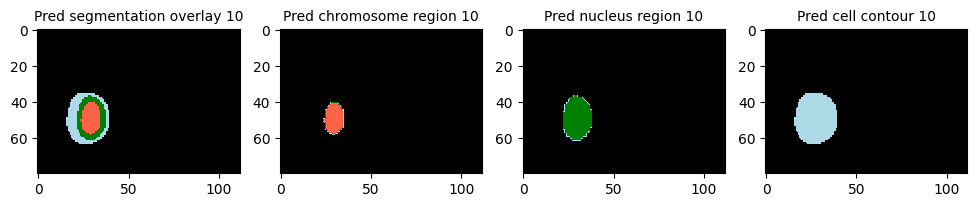

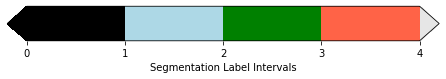

IoU score: 0.837, Chromesome F1score: 0.841, Nucleus F1score: 0.913, Cell F1score: 0.928, Chromesome precision: 0.773, Nucleus precision: 0.890, Cell precision: 0.931, Chromesome recall: 0.921, Nucleus recall: 0.937, Cell recall: 0.926


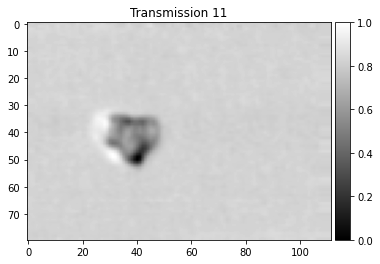

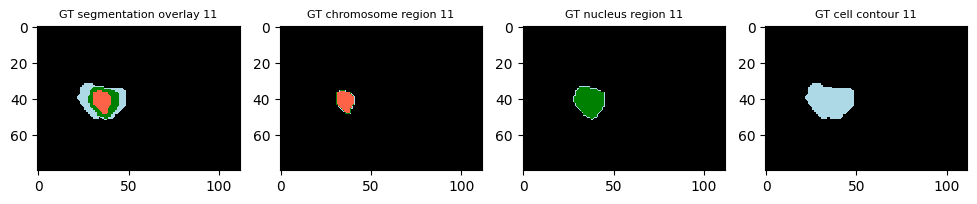

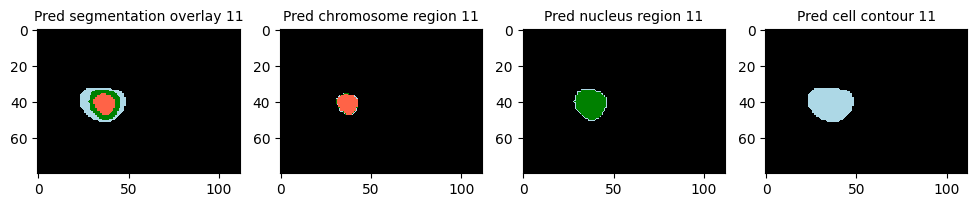

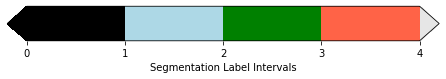

IoU score: 0.860, Chromesome F1score: 0.824, Nucleus F1score: 0.943, Cell F1score: 0.940, Chromesome precision: 0.785, Nucleus precision: 0.931, Cell precision: 0.948, Chromesome recall: 0.866, Nucleus recall: 0.956, Cell recall: 0.931


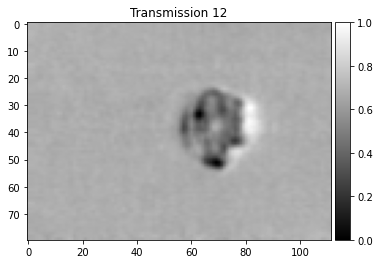

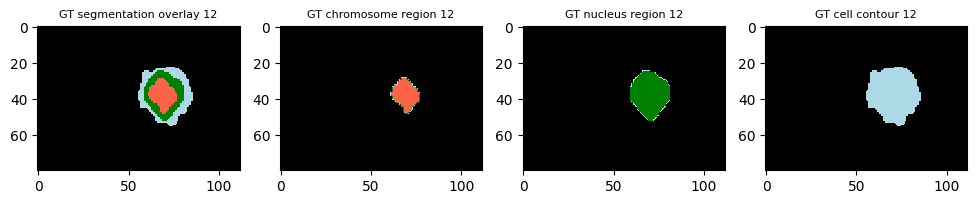

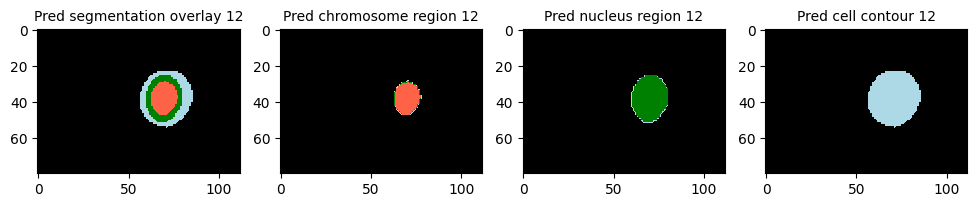

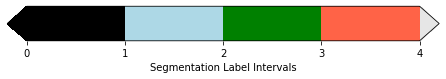

IoU score: 0.865, Chromesome F1score: 0.873, Nucleus F1score: 0.930, Cell F1score: 0.942, Chromesome precision: 0.842, Nucleus precision: 0.952, Cell precision: 0.950, Chromesome recall: 0.907, Nucleus recall: 0.910, Cell recall: 0.933


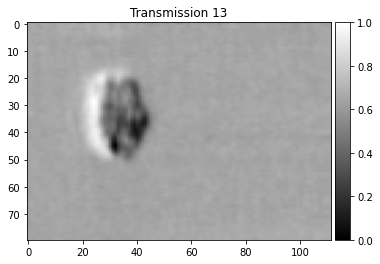

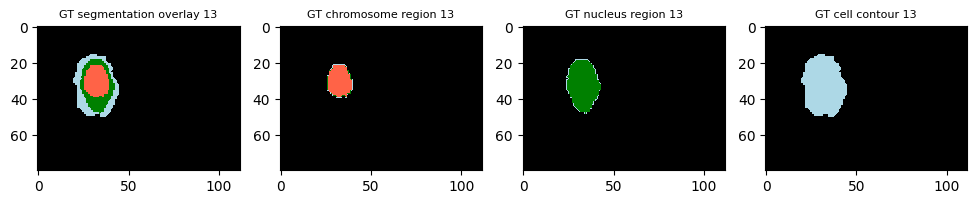

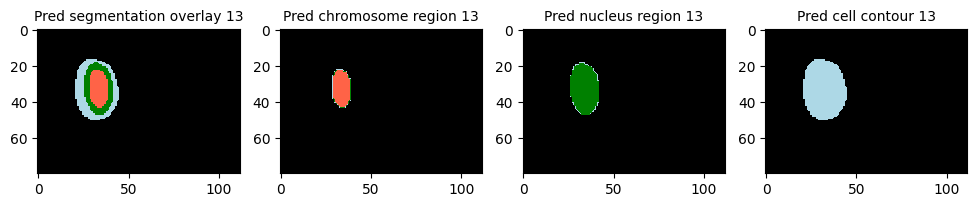

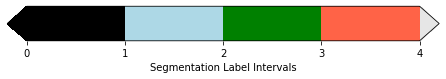

IoU score: 0.848, Chromesome F1score: 0.777, Nucleus F1score: 0.923, Cell F1score: 0.956, Chromesome precision: 0.831, Nucleus precision: 0.965, Cell precision: 0.959, Chromesome recall: 0.729, Nucleus recall: 0.885, Cell recall: 0.953


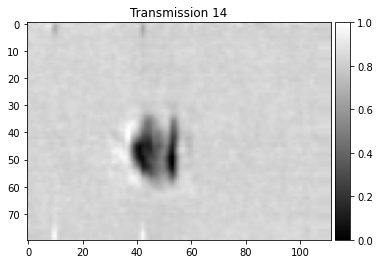

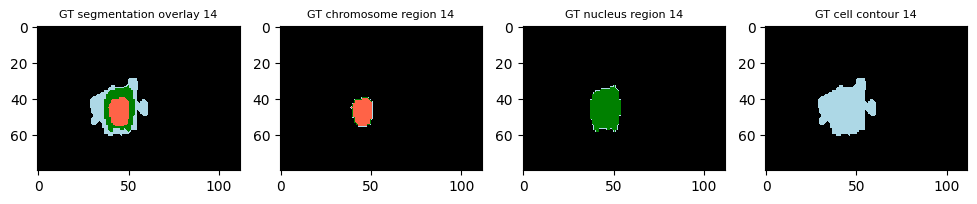

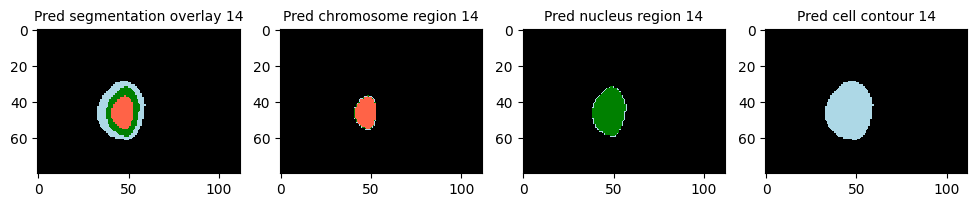

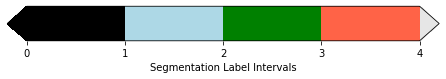

IoU score: 0.714, Chromesome F1score: 0.773, Nucleus F1score: 0.839, Cell F1score: 0.845, Chromesome precision: 0.728, Nucleus precision: 0.808, Cell precision: 0.842, Chromesome recall: 0.824, Nucleus recall: 0.872, Cell recall: 0.848


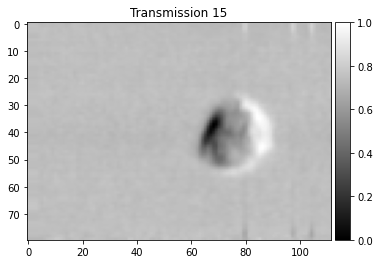

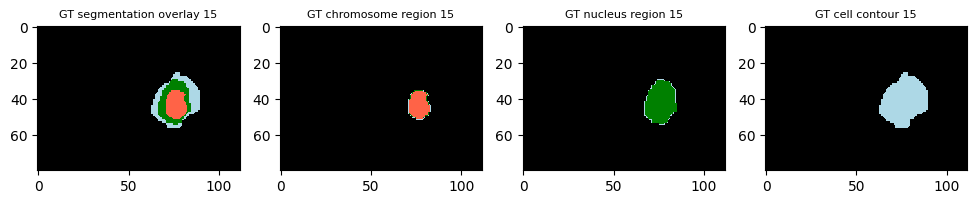

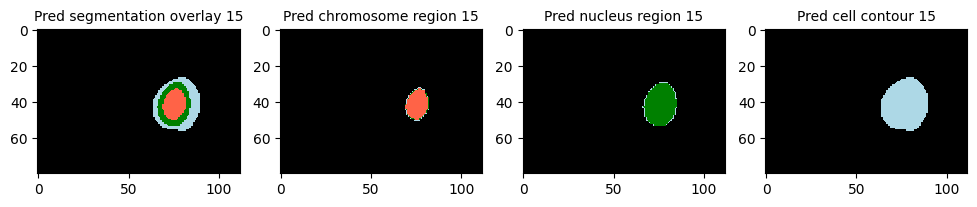

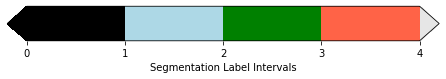

IoU score: 0.851, Chromesome F1score: 0.807, Nucleus F1score: 0.956, Cell F1score: 0.930, Chromesome precision: 0.769, Nucleus precision: 0.945, Cell precision: 0.895, Chromesome recall: 0.850, Nucleus recall: 0.967, Cell recall: 0.968


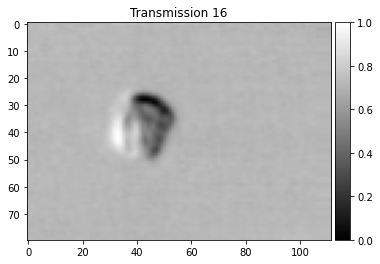

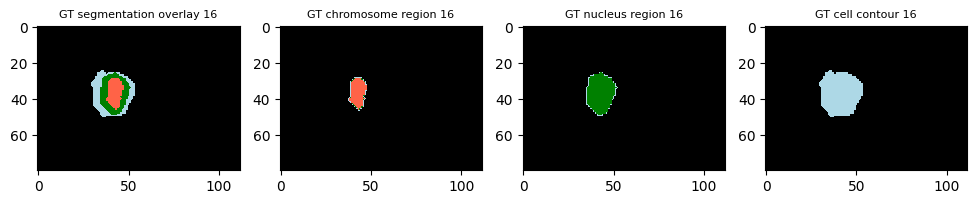

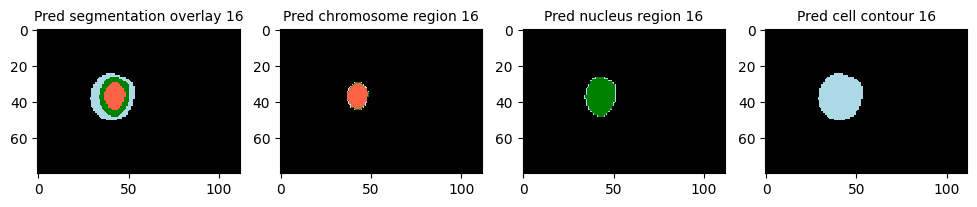

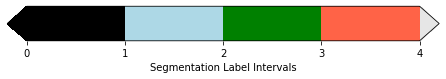

IoU score: 0.883, Chromesome F1score: 0.856, Nucleus F1score: 0.958, Cell F1score: 0.947, Chromesome precision: 0.821, Nucleus precision: 0.965, Cell precision: 0.922, Chromesome recall: 0.894, Nucleus recall: 0.952, Cell recall: 0.973


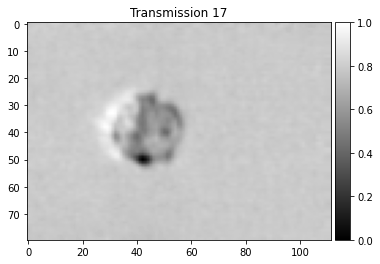

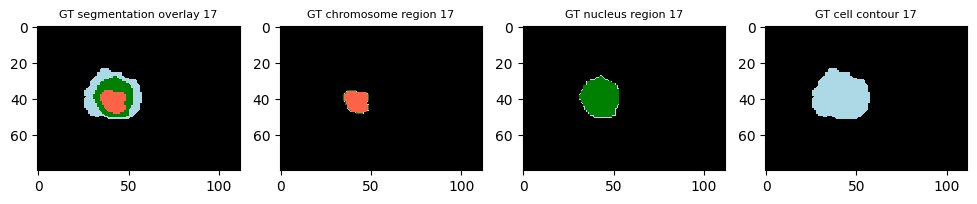

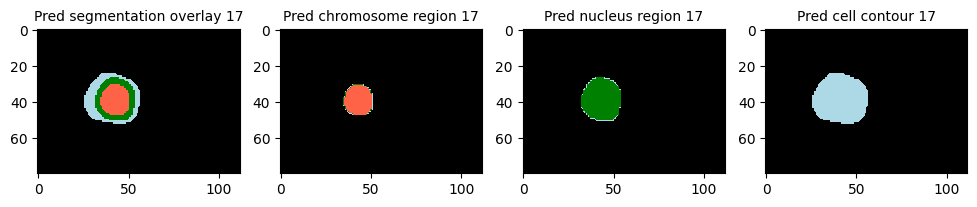

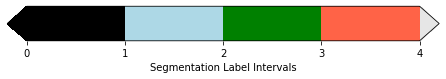

IoU score: 0.855, Chromesome F1score: 0.757, Nucleus F1score: 0.928, Cell F1score: 0.963, Chromesome precision: 0.622, Nucleus precision: 0.877, Cell precision: 0.961, Chromesome recall: 0.966, Nucleus recall: 0.984, Cell recall: 0.964


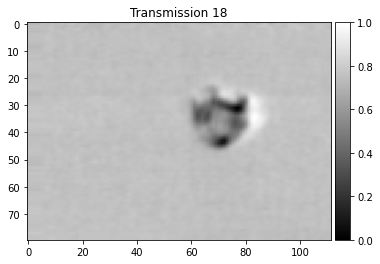

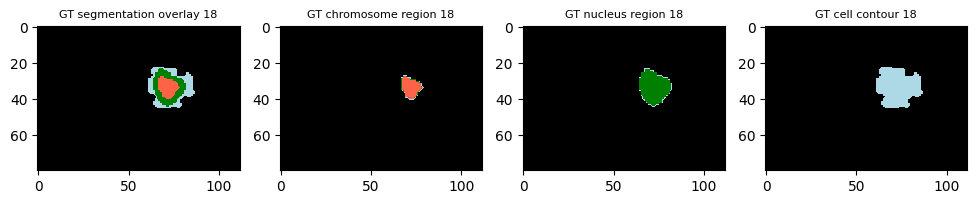

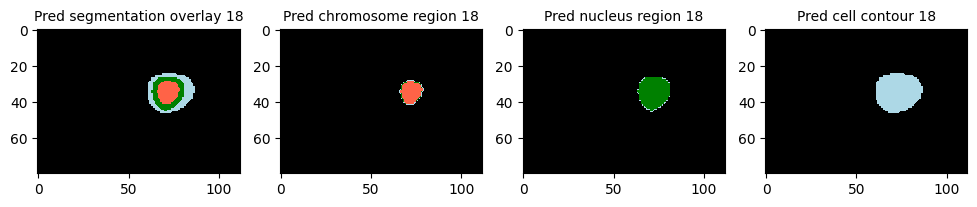

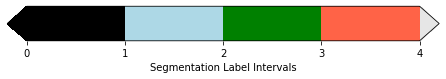

IoU score: 0.801, Chromesome F1score: 0.850, Nucleus F1score: 0.897, Cell F1score: 0.896, Chromesome precision: 0.774, Nucleus precision: 0.890, Cell precision: 0.879, Chromesome recall: 0.941, Nucleus recall: 0.903, Cell recall: 0.913


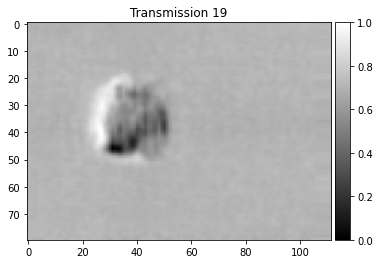

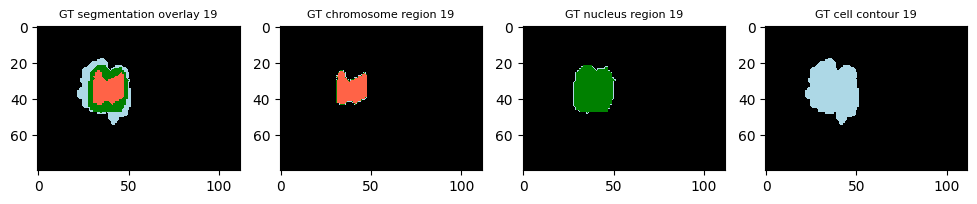

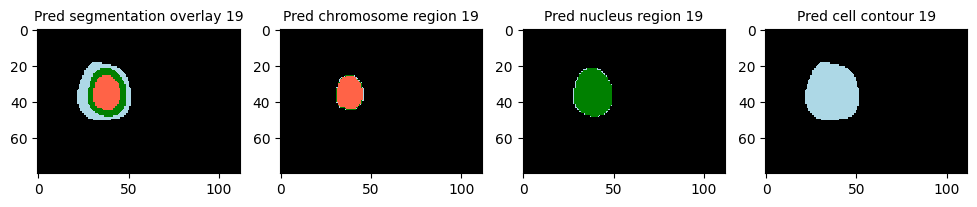

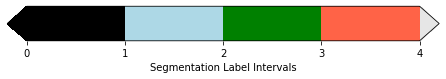

IoU score: 0.822, Chromesome F1score: 0.807, Nucleus F1score: 0.926, Cell F1score: 0.917, Chromesome precision: 0.833, Nucleus precision: 0.972, Cell precision: 0.901, Chromesome recall: 0.782, Nucleus recall: 0.884, Cell recall: 0.934
mean iou_score:  0.8305120417903983
mean precision chromesome:  0.7883552940016517
mean precision nucleus:  0.9118494343686531
mean precision cell:  0.9020403581990097
mean recall chromesome:  0.8803120164324919
mean recall nucleus:  0.94328058823793
mean recall cell:  0.9348593188935718
mean F1score chromesome:  0.8258407600602672
mean F1score nucleus:  0.9258295249405802
mean F1score cell:  0.9163569379555493
Initializing Datasets and Dataloaders...


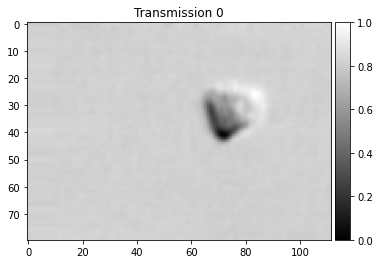

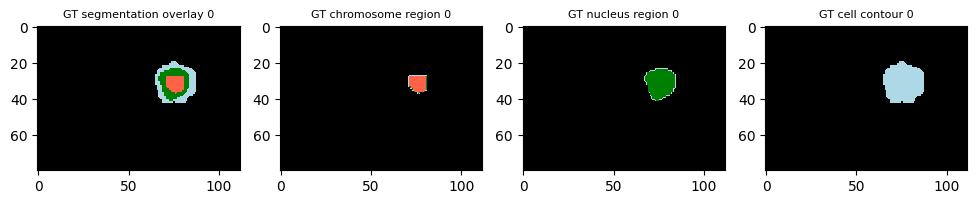

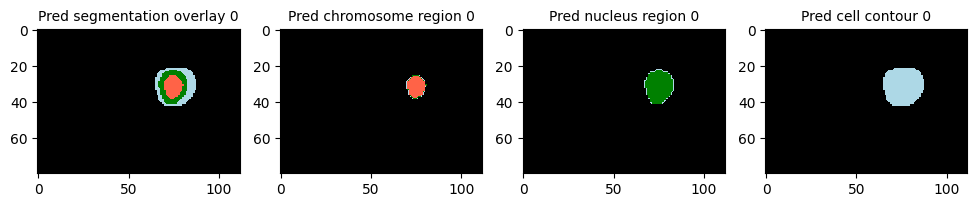

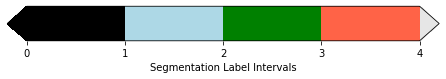

IoU score: 0.862, Chromesome F1score: 0.791, Nucleus F1score: 0.914, Cell F1score: 0.964, Chromesome precision: 0.718, Nucleus precision: 0.903, Cell precision: 0.983, Chromesome recall: 0.881, Nucleus recall: 0.926, Cell recall: 0.945


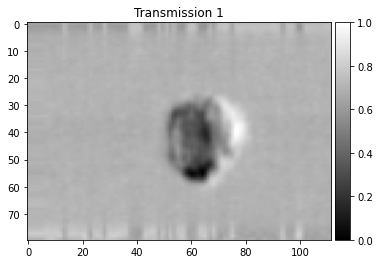

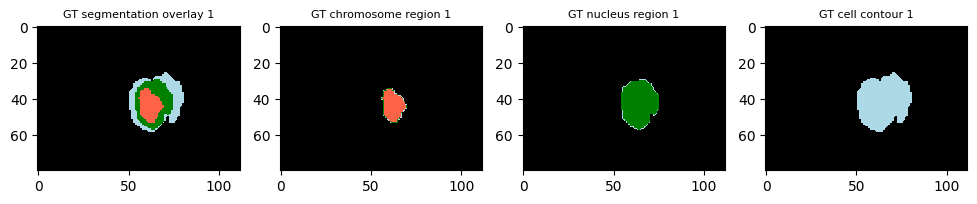

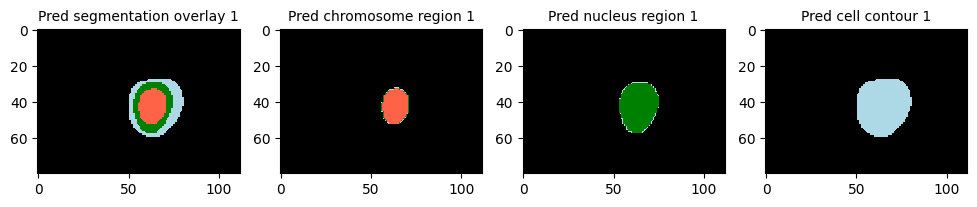

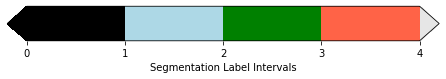

IoU score: 0.859, Chromesome F1score: 0.812, Nucleus F1score: 0.942, Cell F1score: 0.945, Chromesome precision: 0.700, Nucleus precision: 0.901, Cell precision: 0.910, Chromesome recall: 0.966, Nucleus recall: 0.986, Cell recall: 0.982


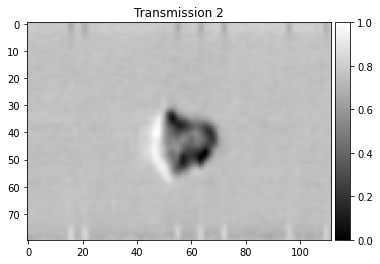

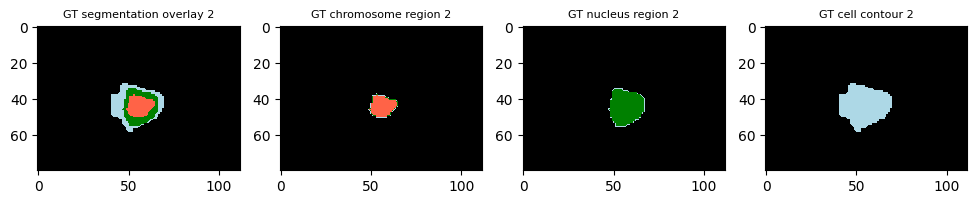

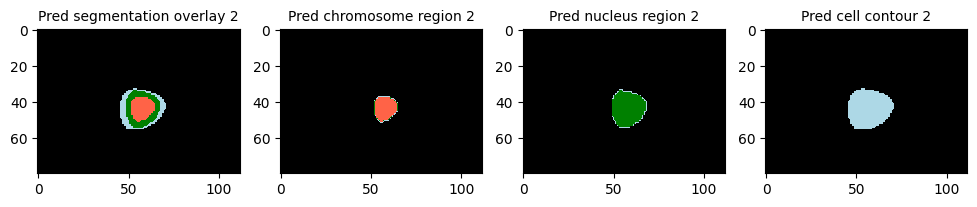

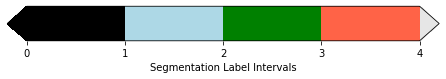

IoU score: 0.781, Chromesome F1score: 0.834, Nucleus F1score: 0.911, Cell F1score: 0.868, Chromesome precision: 0.831, Nucleus precision: 0.925, Cell precision: 0.953, Chromesome recall: 0.837, Nucleus recall: 0.896, Cell recall: 0.797


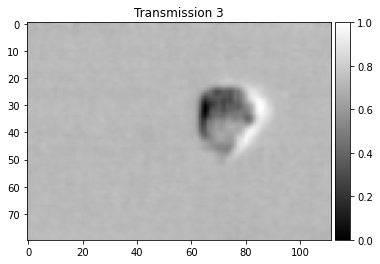

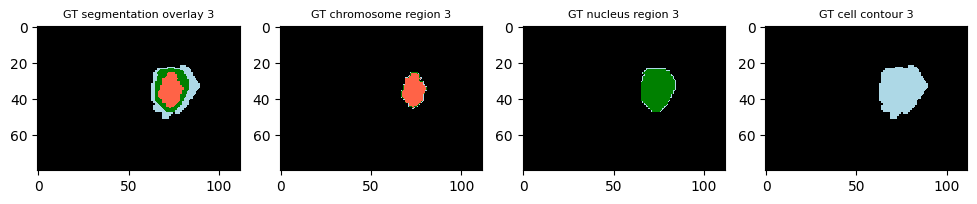

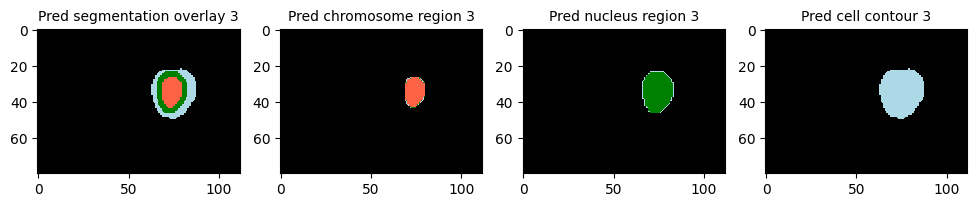

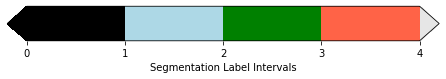

IoU score: 0.865, Chromesome F1score: 0.866, Nucleus F1score: 0.932, Cell F1score: 0.943, Chromesome precision: 0.948, Nucleus precision: 1.000, Cell precision: 0.967, Chromesome recall: 0.797, Nucleus recall: 0.873, Cell recall: 0.921


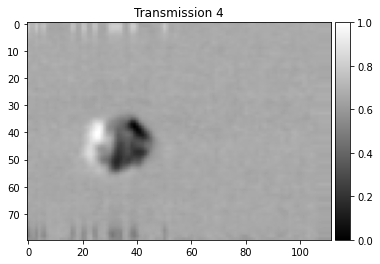

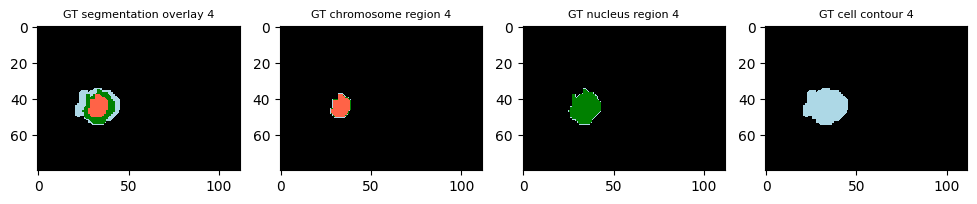

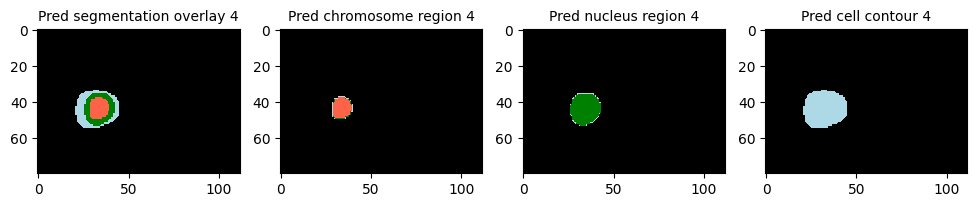

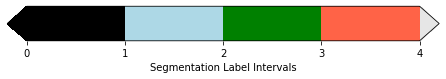

IoU score: 0.857, Chromesome F1score: 0.890, Nucleus F1score: 0.916, Cell F1score: 0.936, Chromesome precision: 0.882, Nucleus precision: 0.914, Cell precision: 0.905, Chromesome recall: 0.898, Nucleus recall: 0.918, Cell recall: 0.969


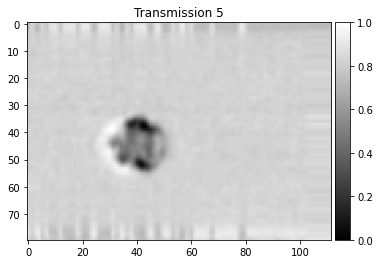

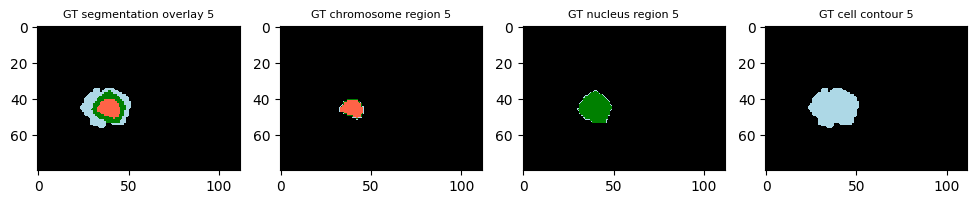

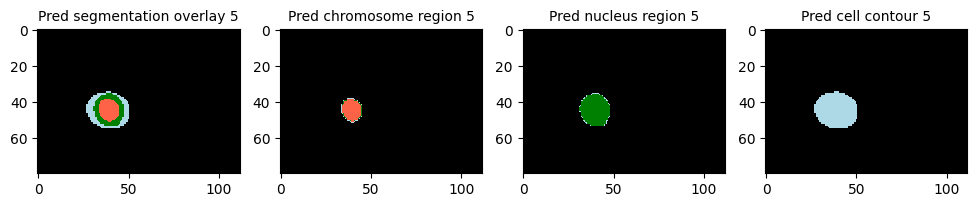

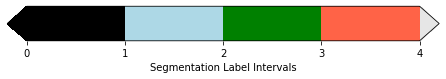

IoU score: 0.827, Chromesome F1score: 0.830, Nucleus F1score: 0.941, Cell F1score: 0.903, Chromesome precision: 0.786, Nucleus precision: 0.929, Cell precision: 0.987, Chromesome recall: 0.880, Nucleus recall: 0.953, Cell recall: 0.833


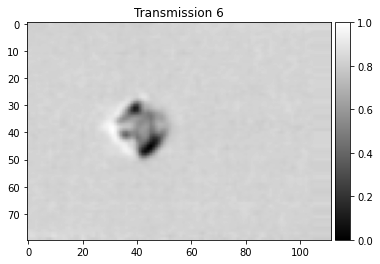

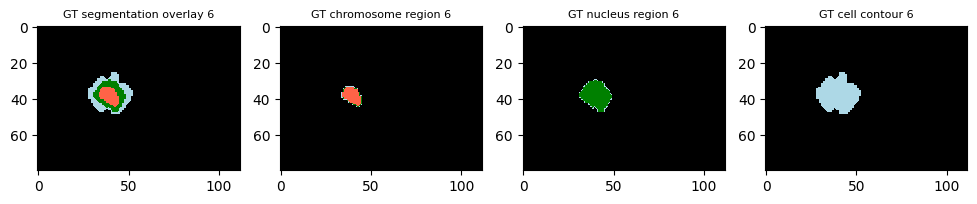

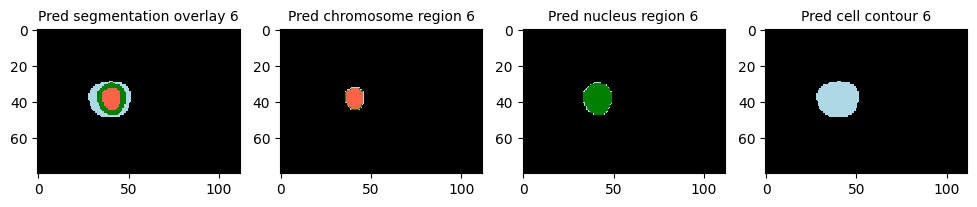

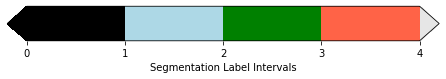

IoU score: 0.812, Chromesome F1score: 0.796, Nucleus F1score: 0.899, Cell F1score: 0.919, Chromesome precision: 0.725, Nucleus precision: 0.863, Cell precision: 0.919, Chromesome recall: 0.881, Nucleus recall: 0.938, Cell recall: 0.919


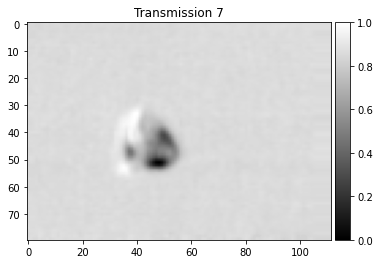

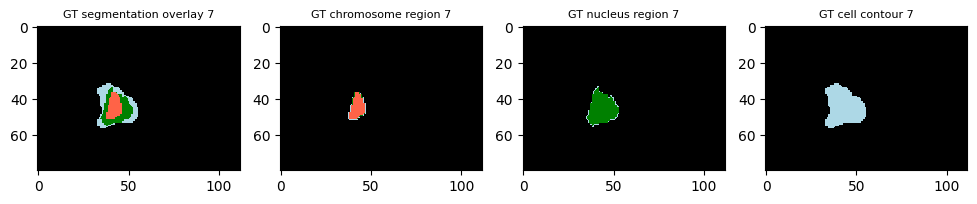

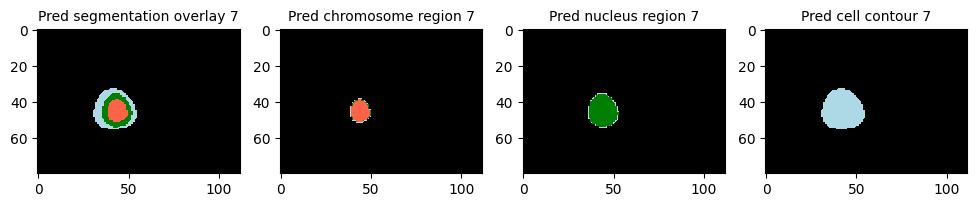

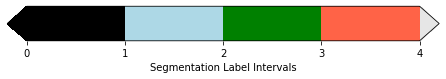

IoU score: 0.751, Chromesome F1score: 0.748, Nucleus F1score: 0.892, Cell F1score: 0.866, Chromesome precision: 0.700, Nucleus precision: 0.888, Cell precision: 0.836, Chromesome recall: 0.802, Nucleus recall: 0.896, Cell recall: 0.898


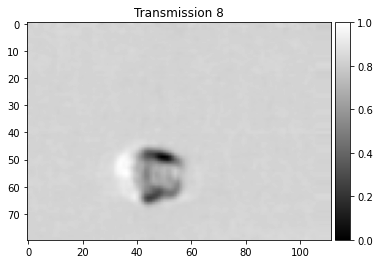

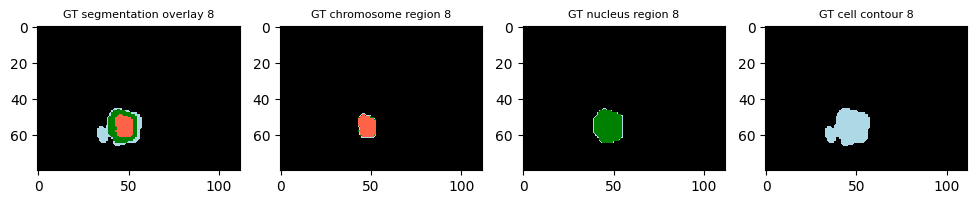

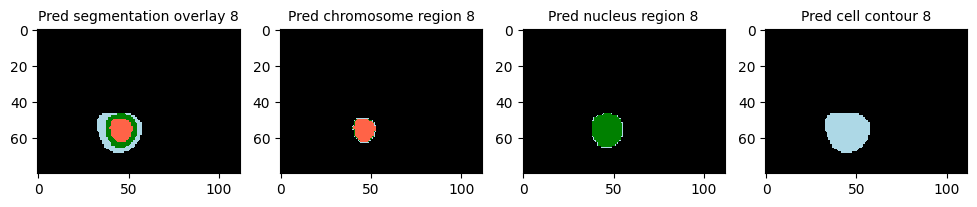

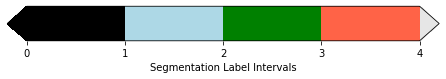

IoU score: 0.760, Chromesome F1score: 0.805, Nucleus F1score: 0.927, Cell F1score: 0.841, Chromesome precision: 0.740, Nucleus precision: 0.899, Cell precision: 0.768, Chromesome recall: 0.882, Nucleus recall: 0.956, Cell recall: 0.930


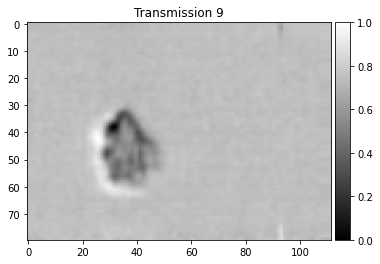

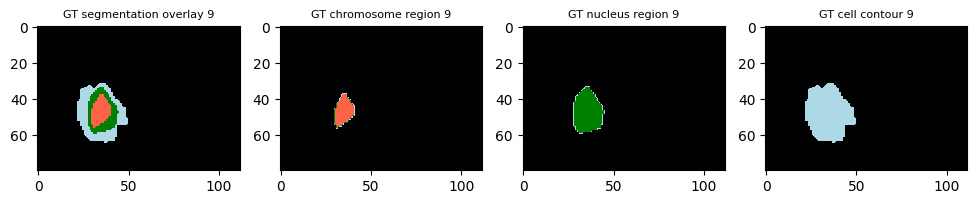

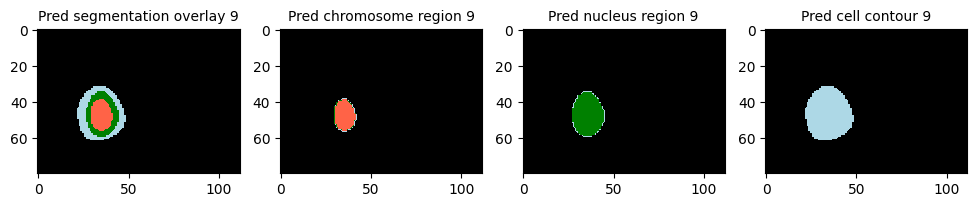

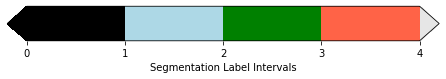

IoU score: 0.844, Chromesome F1score: 0.864, Nucleus F1score: 0.936, Cell F1score: 0.917, Chromesome precision: 0.792, Nucleus precision: 0.905, Cell precision: 0.948, Chromesome recall: 0.950, Nucleus recall: 0.969, Cell recall: 0.888


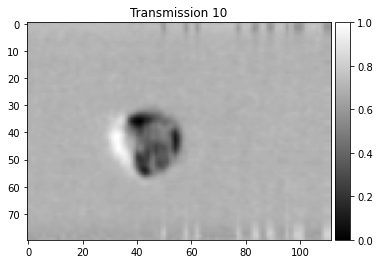

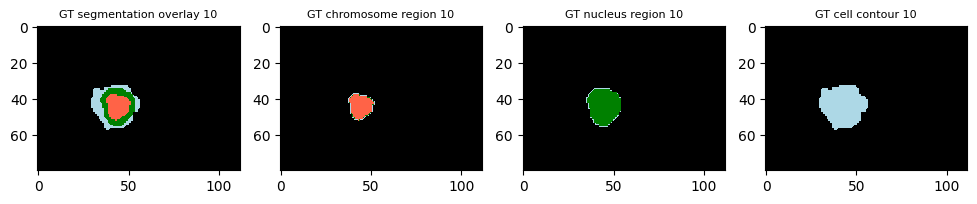

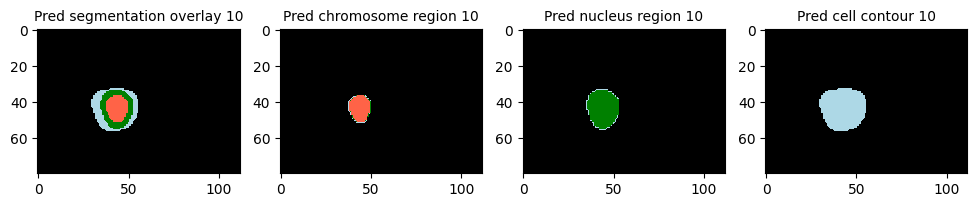

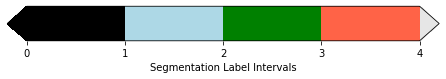

IoU score: 0.892, Chromesome F1score: 0.893, Nucleus F1score: 0.951, Cell F1score: 0.952, Chromesome precision: 0.897, Nucleus precision: 0.948, Cell precision: 0.942, Chromesome recall: 0.890, Nucleus recall: 0.955, Cell recall: 0.961


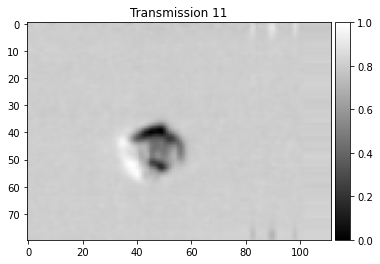

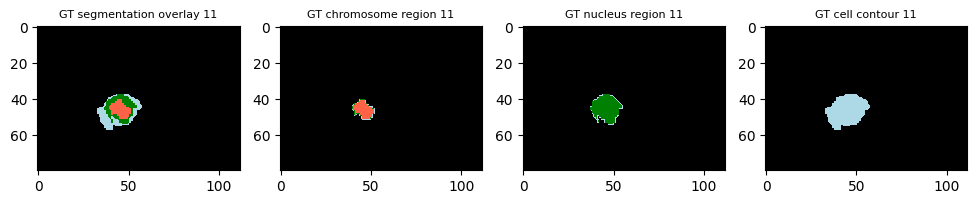

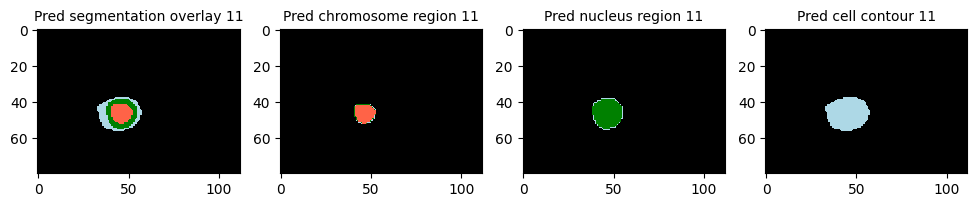

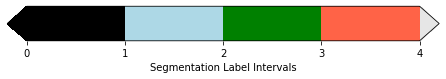

IoU score: 0.791, Chromesome F1score: 0.833, Nucleus F1score: 0.884, Cell F1score: 0.897, Chromesome precision: 0.762, Nucleus precision: 0.823, Cell precision: 0.856, Chromesome recall: 0.920, Nucleus recall: 0.955, Cell recall: 0.942


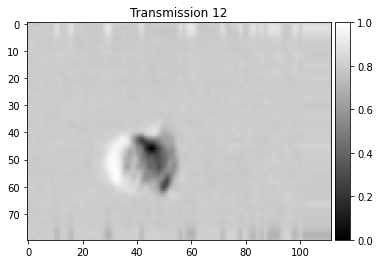

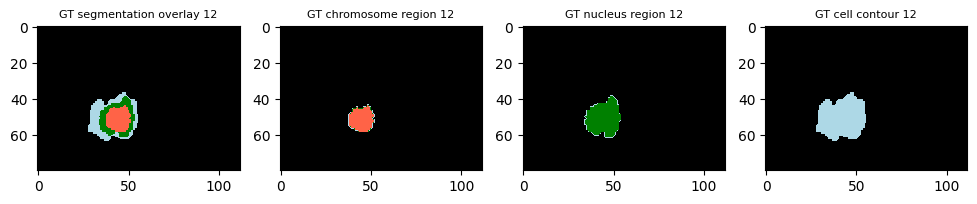

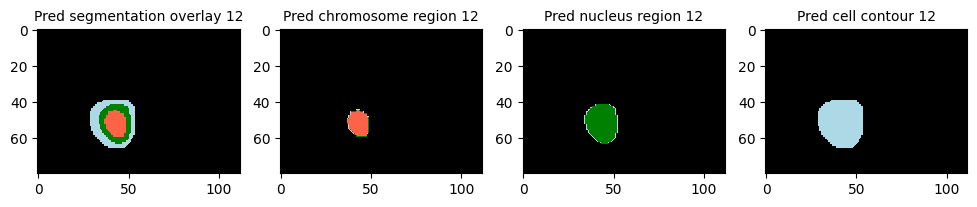

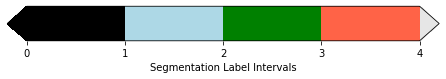

IoU score: 0.786, Chromesome F1score: 0.824, Nucleus F1score: 0.868, Cell F1score: 0.903, Chromesome precision: 0.886, Nucleus precision: 0.876, Cell precision: 0.892, Chromesome recall: 0.770, Nucleus recall: 0.860, Cell recall: 0.914


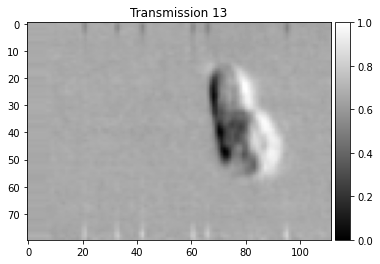

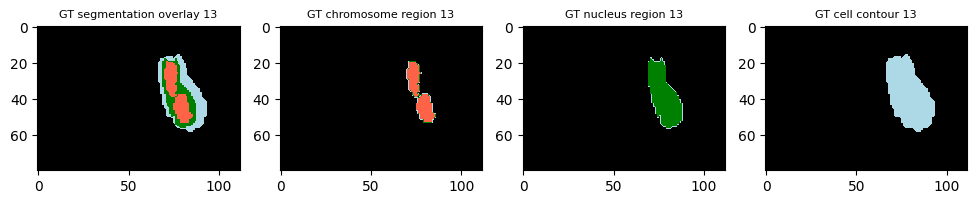

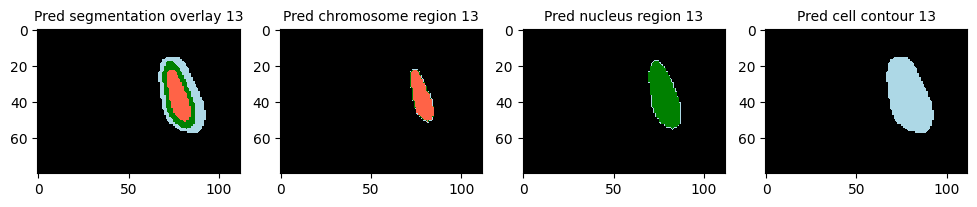

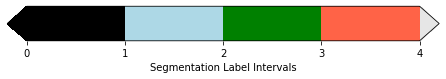

IoU score: 0.820, Chromesome F1score: 0.726, Nucleus F1score: 0.904, Cell F1score: 0.953, Chromesome precision: 0.730, Nucleus precision: 0.903, Cell precision: 0.942, Chromesome recall: 0.721, Nucleus recall: 0.905, Cell recall: 0.963


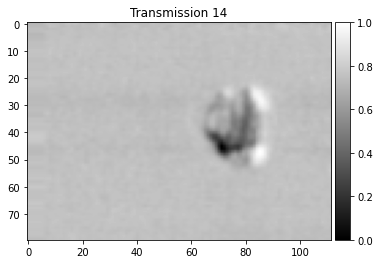

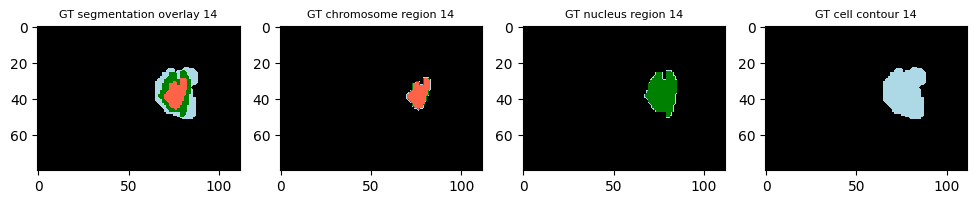

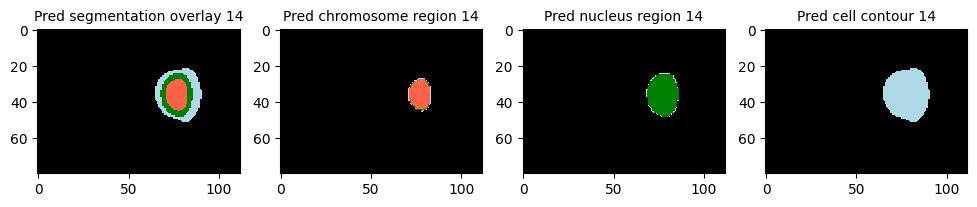

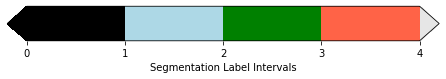

IoU score: 0.830, Chromesome F1score: 0.803, Nucleus F1score: 0.923, Cell F1score: 0.927, Chromesome precision: 0.737, Nucleus precision: 0.893, Cell precision: 0.884, Chromesome recall: 0.881, Nucleus recall: 0.956, Cell recall: 0.974


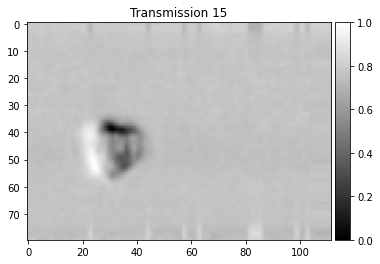

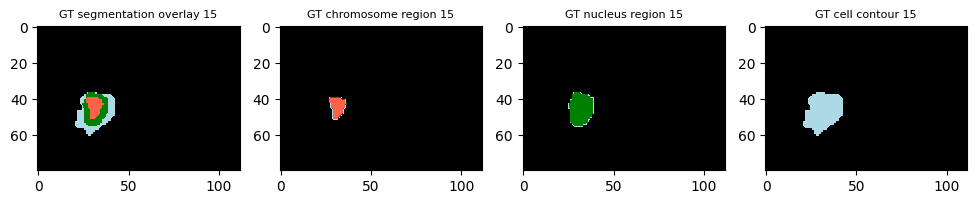

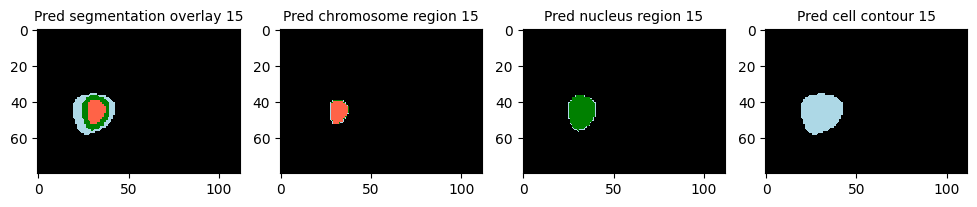

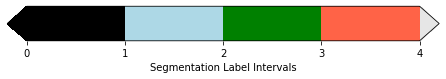

IoU score: 0.811, Chromesome F1score: 0.817, Nucleus F1score: 0.937, Cell F1score: 0.891, Chromesome precision: 0.717, Nucleus precision: 0.889, Cell precision: 0.847, Chromesome recall: 0.950, Nucleus recall: 0.990, Cell recall: 0.941


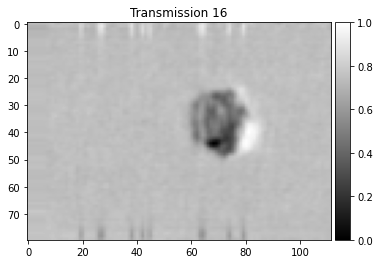

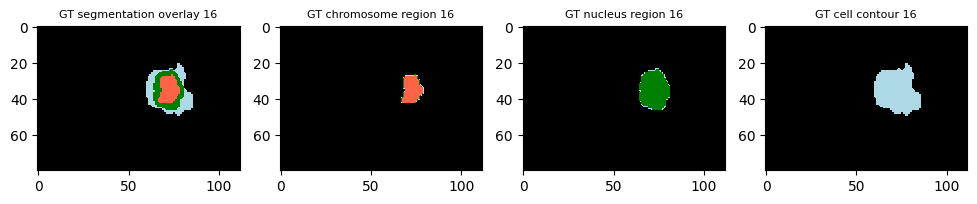

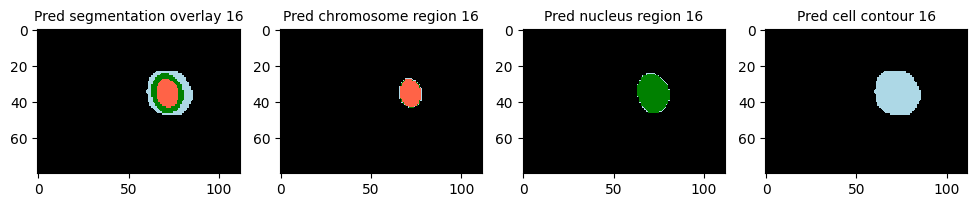

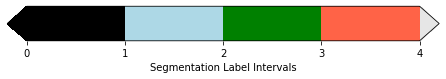

IoU score: 0.838, Chromesome F1score: 0.871, Nucleus F1score: 0.940, Cell F1score: 0.907, Chromesome precision: 0.837, Nucleus precision: 0.941, Cell precision: 0.919, Chromesome recall: 0.908, Nucleus recall: 0.938, Cell recall: 0.894


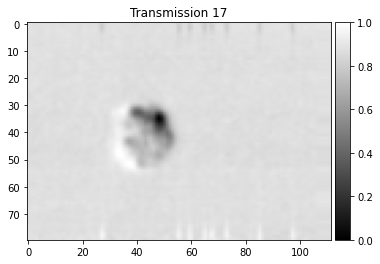

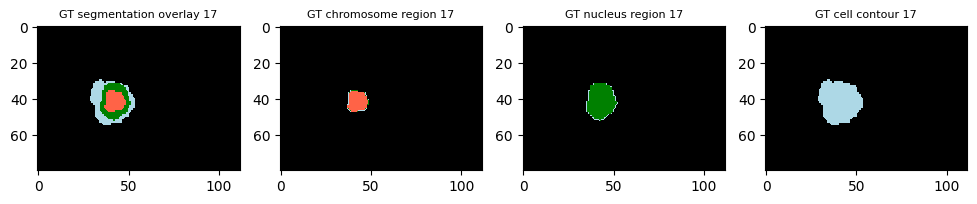

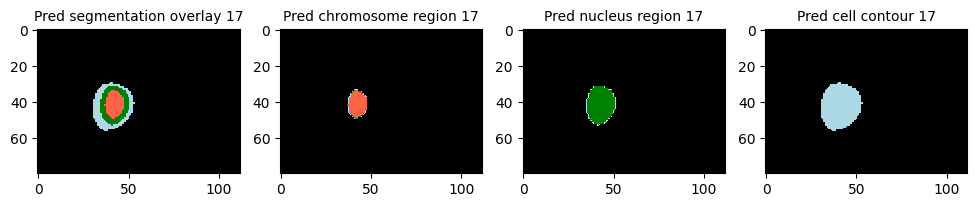

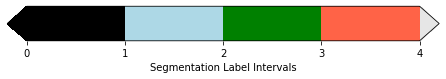

IoU score: 0.861, Chromesome F1score: 0.877, Nucleus F1score: 0.955, Cell F1score: 0.920, Chromesome precision: 0.824, Nucleus precision: 0.941, Cell precision: 0.920, Chromesome recall: 0.936, Nucleus recall: 0.970, Cell recall: 0.920


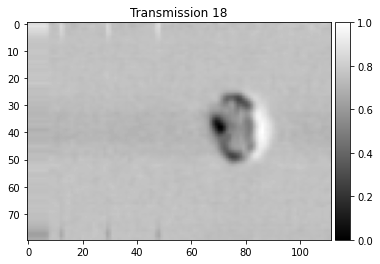

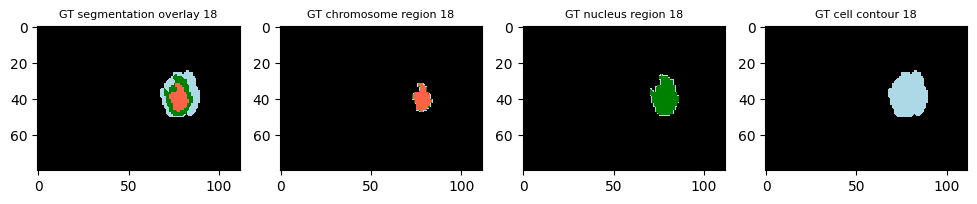

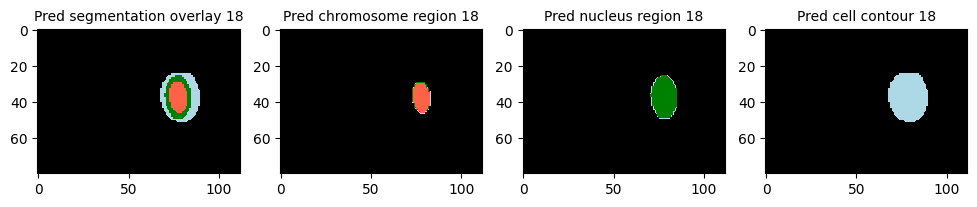

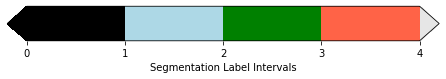

IoU score: 0.826, Chromesome F1score: 0.789, Nucleus F1score: 0.894, Cell F1score: 0.942, Chromesome precision: 0.703, Nucleus precision: 0.838, Cell precision: 0.895, Chromesome recall: 0.898, Nucleus recall: 0.959, Cell recall: 0.993


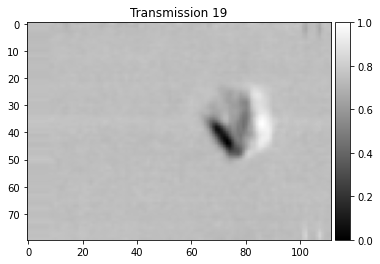

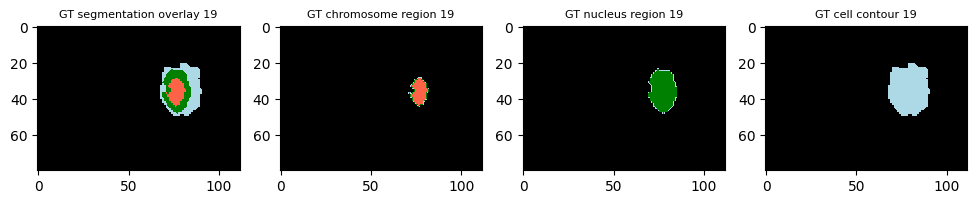

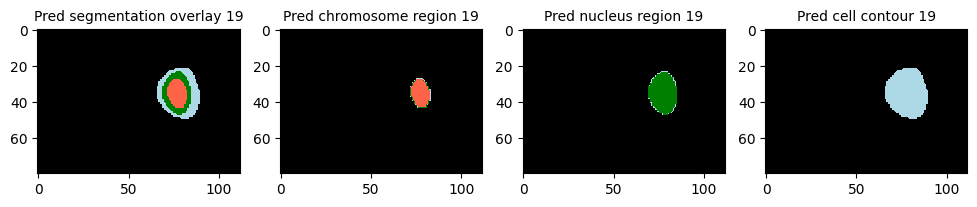

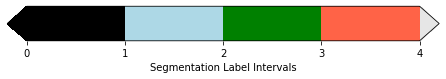

IoU score: 0.831, Chromesome F1score: 0.807, Nucleus F1score: 0.936, Cell F1score: 0.916, Chromesome precision: 0.715, Nucleus precision: 0.922, Cell precision: 0.925, Chromesome recall: 0.925, Nucleus recall: 0.951, Cell recall: 0.906
mean iou_score:  0.8277272321421598
mean precision chromesome:  0.7897647643236148
mean precision nucleus:  0.92060731953457
mean precision cell:  0.9168604234840741
mean recall chromesome:  0.8736960819987081
mean recall nucleus:  0.9314124384821064
mean recall cell:  0.9168450459132219
mean F1score chromesome:  0.8224088936756992
mean F1score nucleus:  0.9243147035577233
mean F1score cell:  0.9151233264137882
Initializing Datasets and Dataloaders...


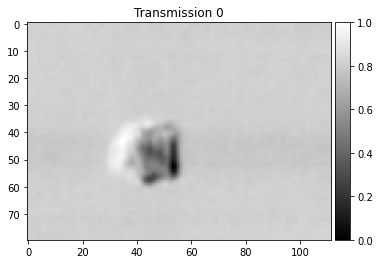

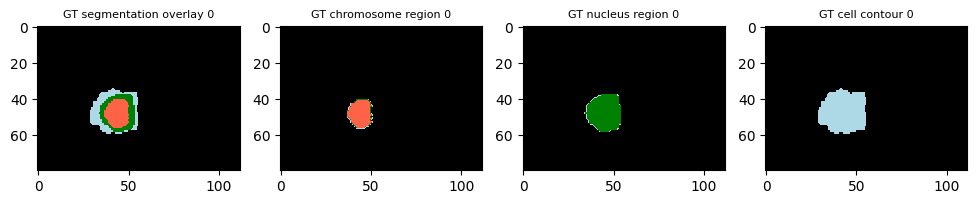

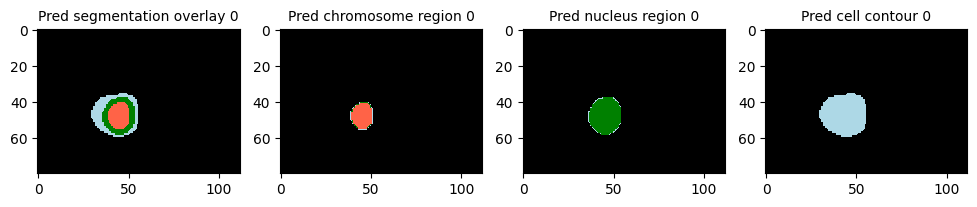

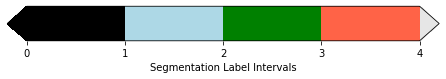

IoU score: 0.873, Chromesome F1score: 0.876, Nucleus F1score: 0.946, Cell F1score: 0.941, Chromesome precision: 0.959, Nucleus precision: 0.997, Cell precision: 0.974, Chromesome recall: 0.806, Nucleus recall: 0.901, Cell recall: 0.911


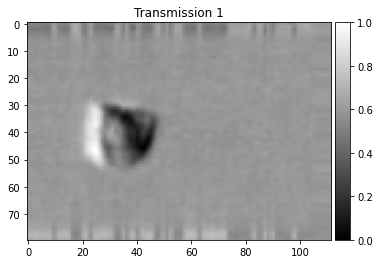

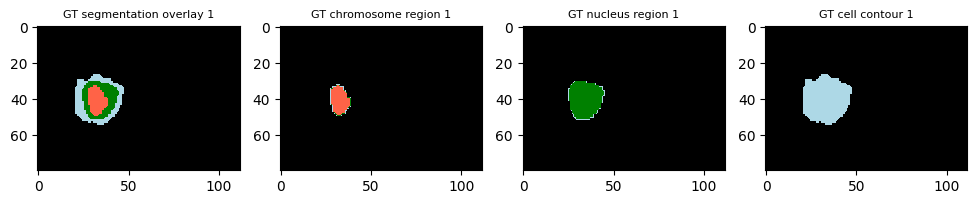

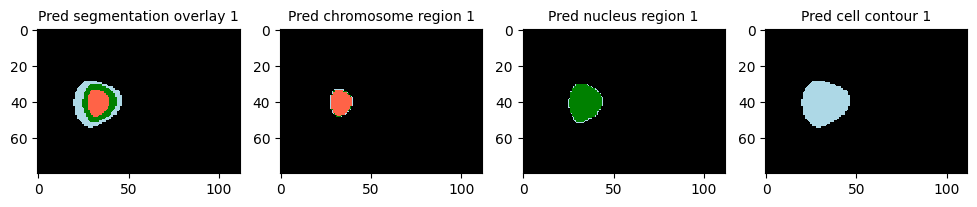

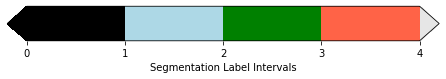

IoU score: 0.858, Chromesome F1score: 0.899, Nucleus F1score: 0.945, Cell F1score: 0.917, Chromesome precision: 0.887, Nucleus precision: 0.990, Cell precision: 0.971, Chromesome recall: 0.912, Nucleus recall: 0.904, Cell recall: 0.869


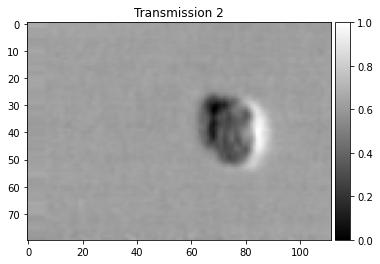

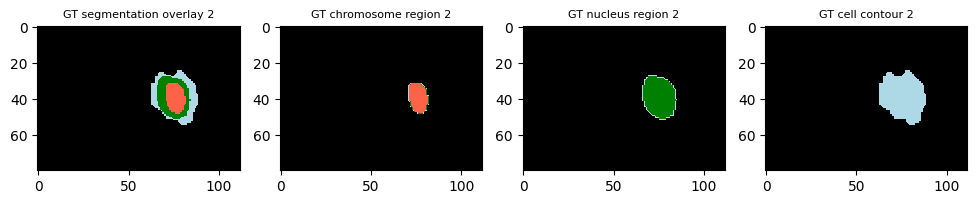

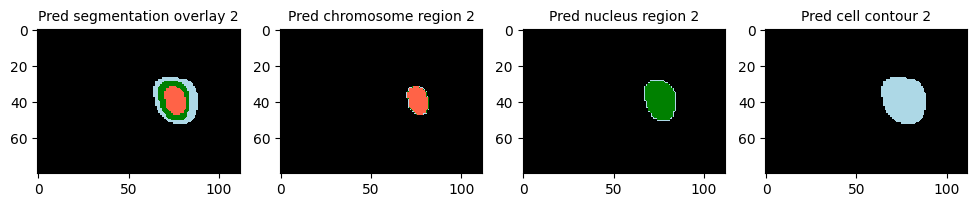

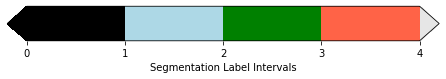

IoU score: 0.881, Chromesome F1score: 0.947, Nucleus F1score: 0.940, Cell F1score: 0.932, Chromesome precision: 0.947, Nucleus precision: 1.000, Cell precision: 0.966, Chromesome recall: 0.947, Nucleus recall: 0.886, Cell recall: 0.900


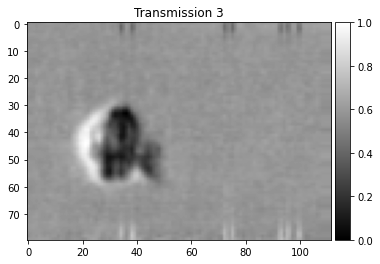

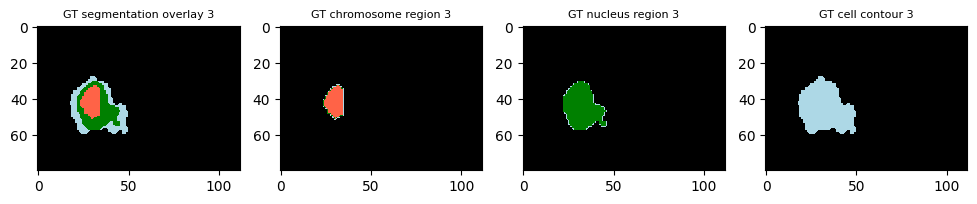

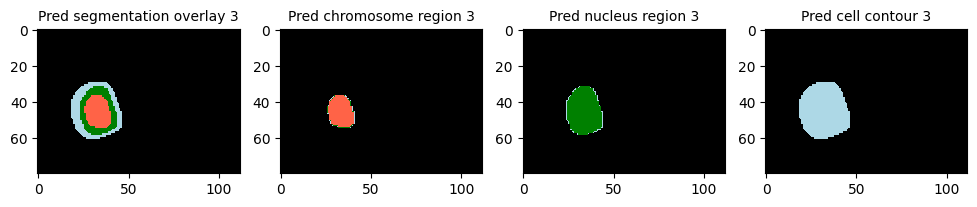

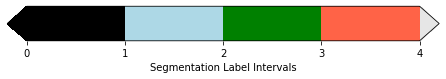

IoU score: 0.728, Chromesome F1score: 0.573, Nucleus F1score: 0.872, Cell F1score: 0.895, Chromesome precision: 0.488, Nucleus precision: 0.875, Cell precision: 0.892, Chromesome recall: 0.693, Nucleus recall: 0.869, Cell recall: 0.897


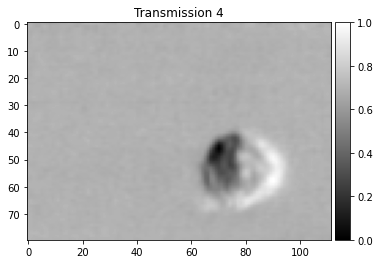

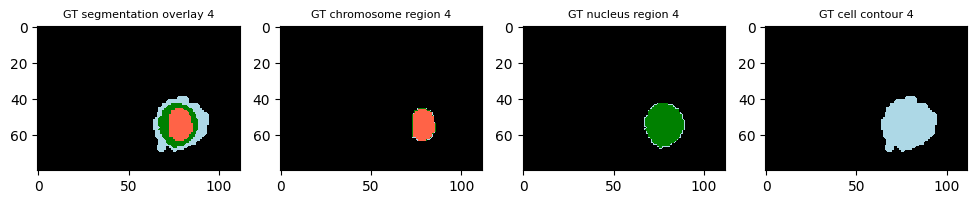

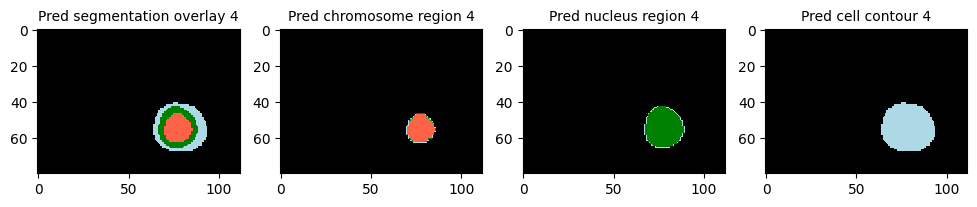

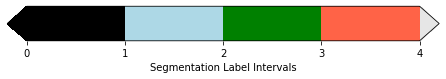

IoU score: 0.863, Chromesome F1score: 0.848, Nucleus F1score: 0.959, Cell F1score: 0.930, Chromesome precision: 0.851, Nucleus precision: 0.982, Cell precision: 0.972, Chromesome recall: 0.846, Nucleus recall: 0.937, Cell recall: 0.892


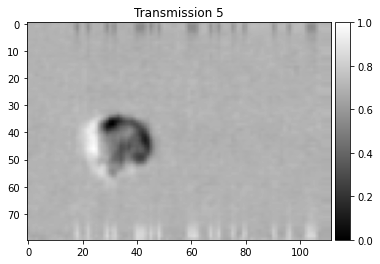

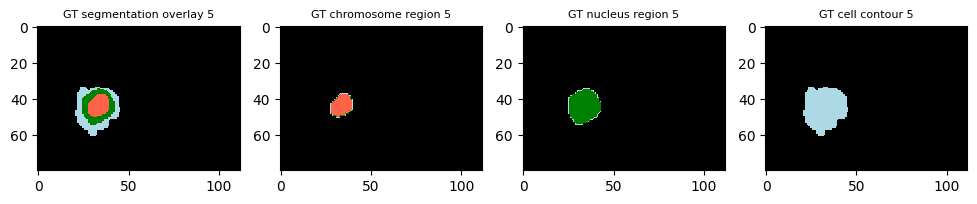

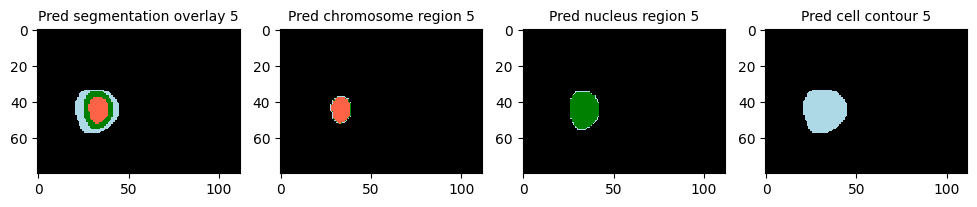

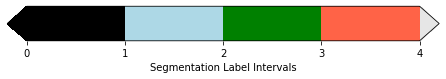

IoU score: 0.859, Chromesome F1score: 0.855, Nucleus F1score: 0.926, Cell F1score: 0.941, Chromesome precision: 0.822, Nucleus precision: 0.921, Cell precision: 0.962, Chromesome recall: 0.891, Nucleus recall: 0.931, Cell recall: 0.921


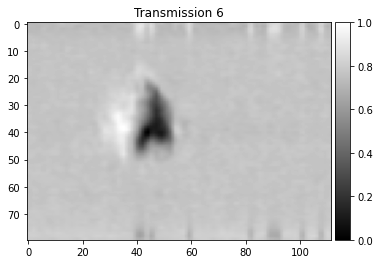

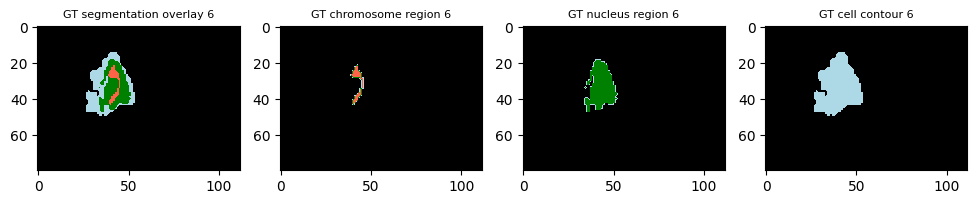

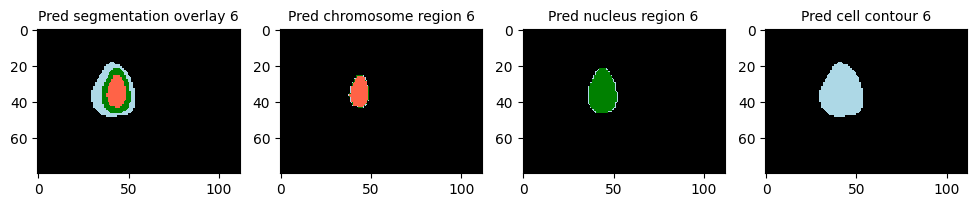

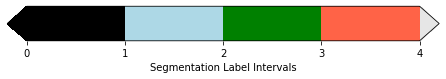

IoU score: 0.651, Chromesome F1score: 0.345, Nucleus F1score: 0.835, Cell F1score: 0.838, Chromesome precision: 0.231, Nucleus precision: 0.849, Cell precision: 0.886, Chromesome recall: 0.680, Nucleus recall: 0.822, Cell recall: 0.796


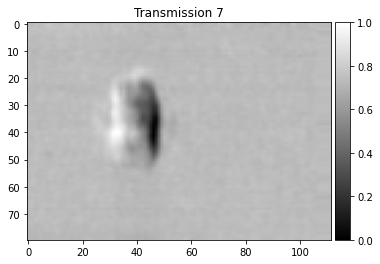

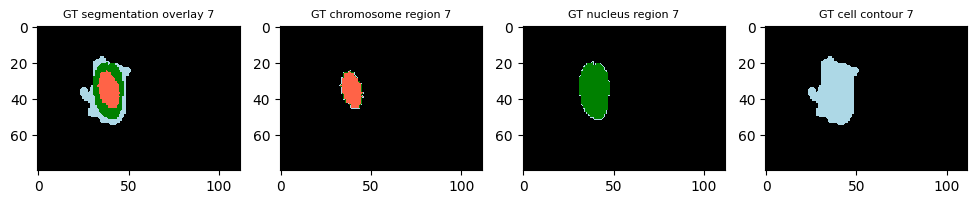

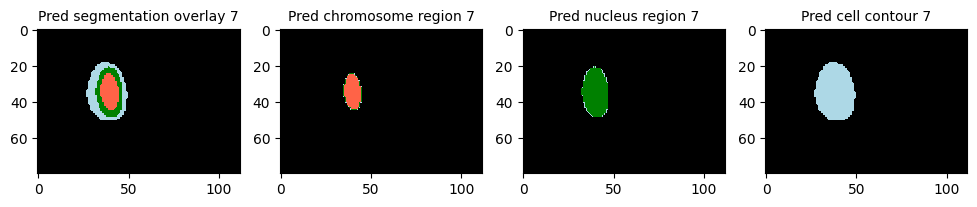

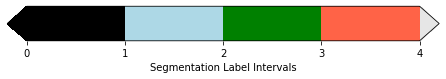

IoU score: 0.760, Chromesome F1score: 0.879, Nucleus F1score: 0.859, Cell F1score: 0.862, Chromesome precision: 0.949, Nucleus precision: 0.997, Cell precision: 0.940, Chromesome recall: 0.819, Nucleus recall: 0.754, Cell recall: 0.796


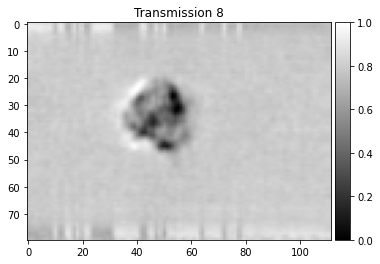

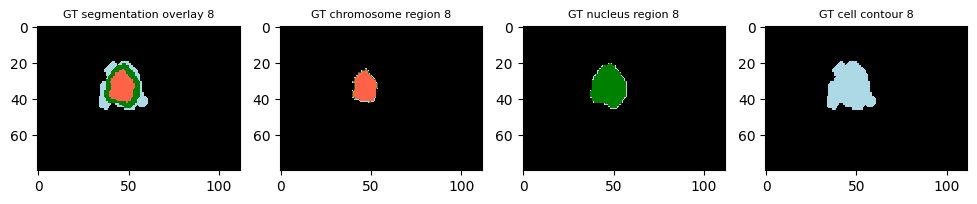

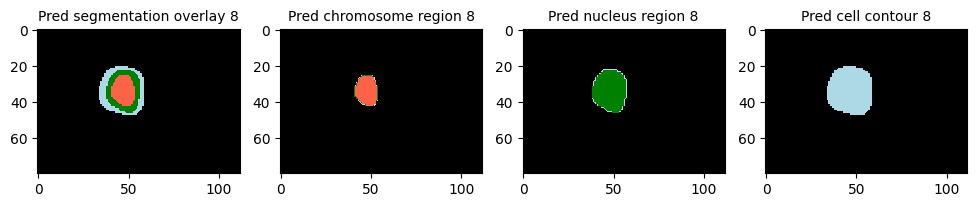

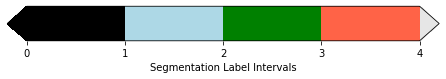

IoU score: 0.819, Chromesome F1score: 0.885, Nucleus F1score: 0.923, Cell F1score: 0.891, Chromesome precision: 0.904, Nucleus precision: 0.918, Cell precision: 0.866, Chromesome recall: 0.866, Nucleus recall: 0.928, Cell recall: 0.918


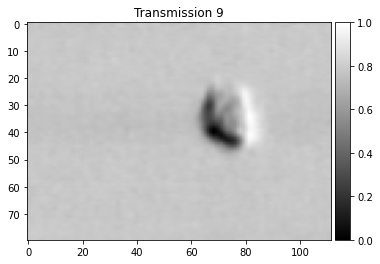

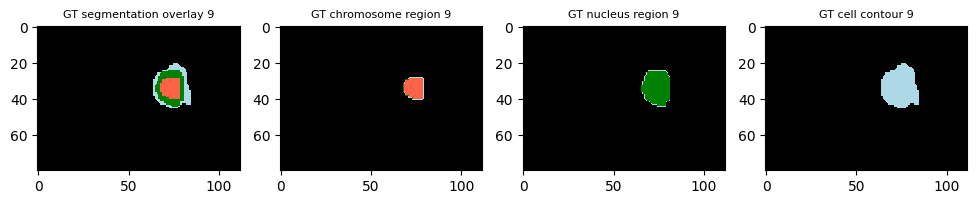

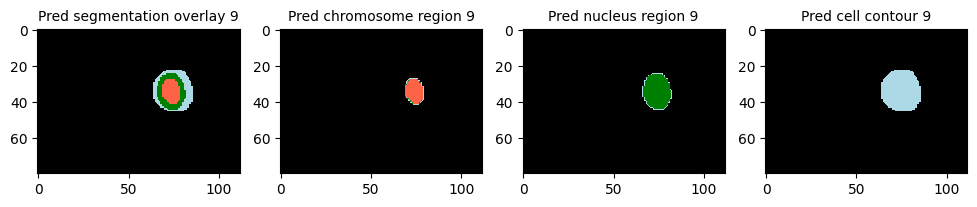

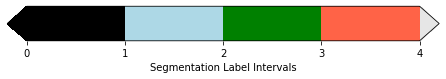

IoU score: 0.875, Chromesome F1score: 0.901, Nucleus F1score: 0.944, Cell F1score: 0.936, Chromesome precision: 0.905, Nucleus precision: 0.960, Cell precision: 0.907, Chromesome recall: 0.897, Nucleus recall: 0.927, Cell recall: 0.967


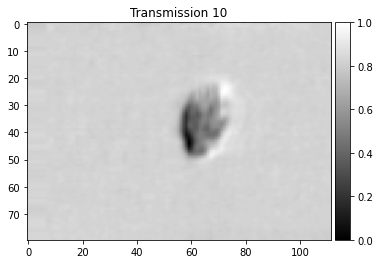

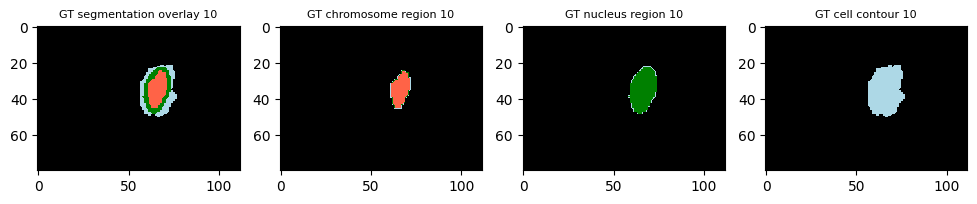

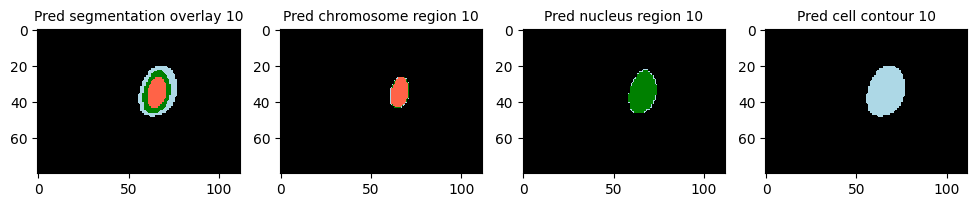

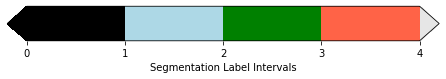

IoU score: 0.851, Chromesome F1score: 0.880, Nucleus F1score: 0.942, Cell F1score: 0.918, Chromesome precision: 0.950, Nucleus precision: 0.965, Cell precision: 0.909, Chromesome recall: 0.820, Nucleus recall: 0.919, Cell recall: 0.927


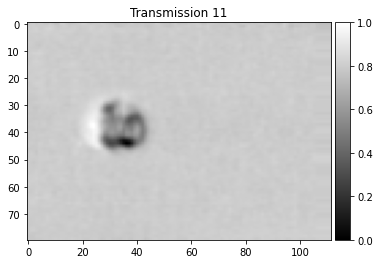

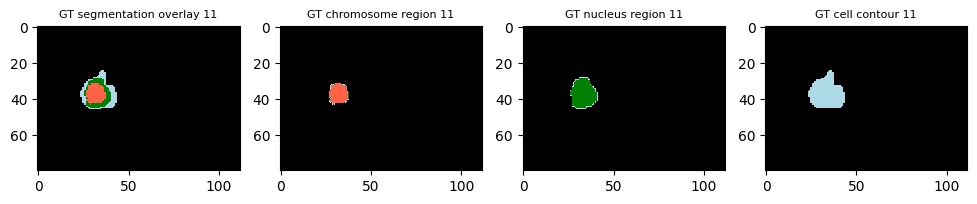

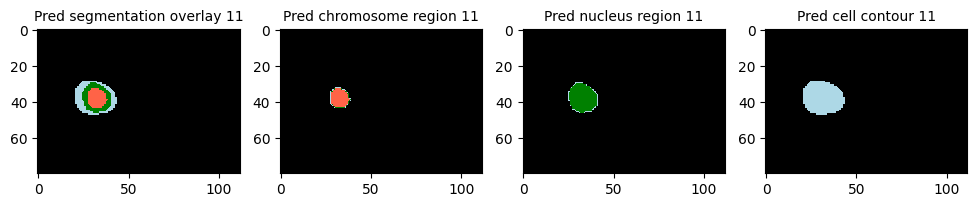

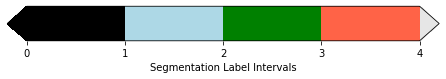

IoU score: 0.749, Chromesome F1score: 0.863, Nucleus F1score: 0.913, Cell F1score: 0.819, Chromesome precision: 0.895, Nucleus precision: 0.884, Cell precision: 0.749, Chromesome recall: 0.833, Nucleus recall: 0.943, Cell recall: 0.903


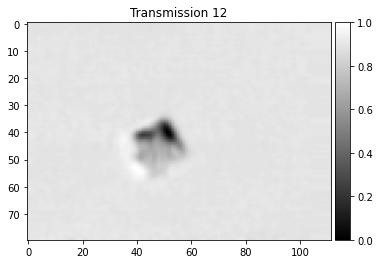

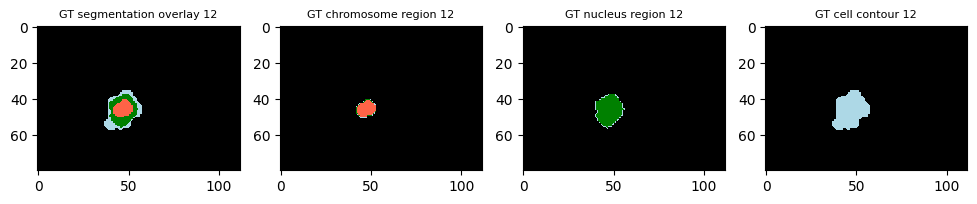

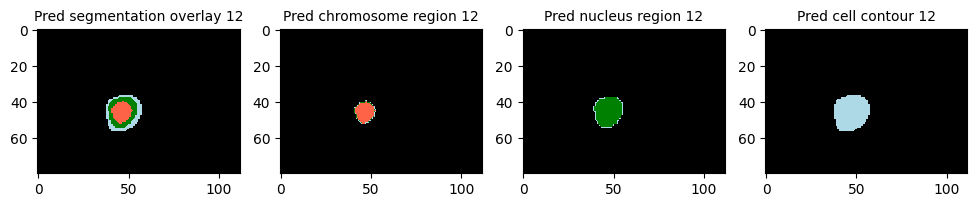

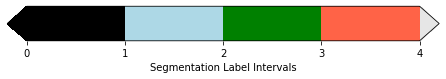

IoU score: 0.822, Chromesome F1score: 0.852, Nucleus F1score: 0.922, Cell F1score: 0.903, Chromesome precision: 0.765, Nucleus precision: 0.907, Cell precision: 0.893, Chromesome recall: 0.963, Nucleus recall: 0.938, Cell recall: 0.913


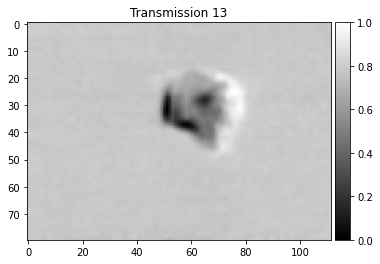

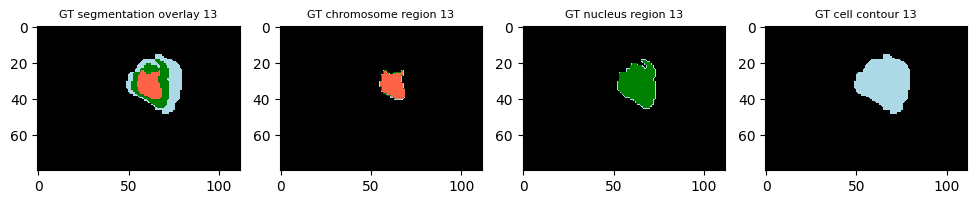

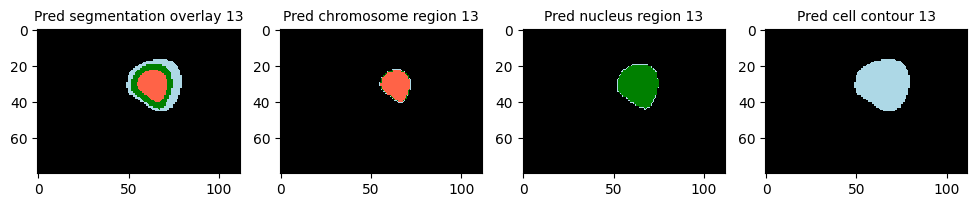

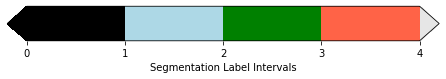

IoU score: 0.818, Chromesome F1score: 0.762, Nucleus F1score: 0.905, Cell F1score: 0.936, Chromesome precision: 0.671, Nucleus precision: 0.880, Cell precision: 0.951, Chromesome recall: 0.880, Nucleus recall: 0.932, Cell recall: 0.921


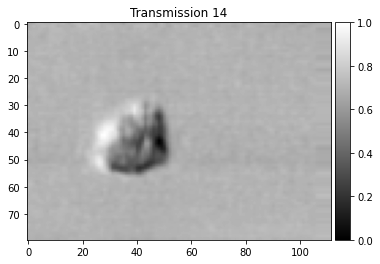

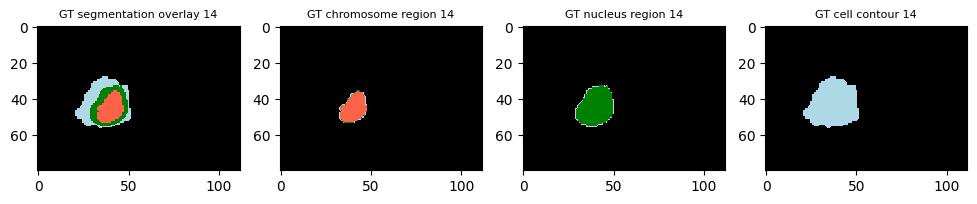

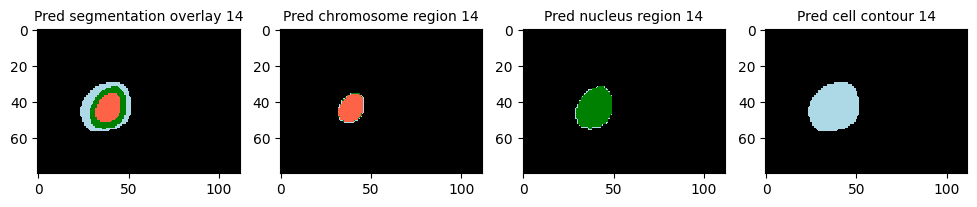

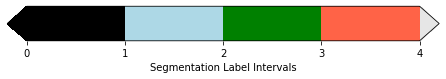

IoU score: 0.832, Chromesome F1score: 0.785, Nucleus F1score: 0.929, Cell F1score: 0.932, Chromesome precision: 0.804, Nucleus precision: 0.924, Cell precision: 0.943, Chromesome recall: 0.766, Nucleus recall: 0.934, Cell recall: 0.922


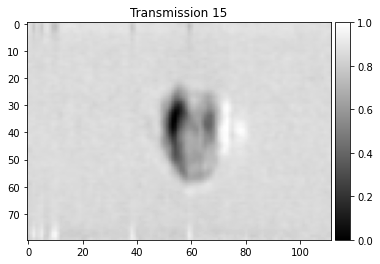

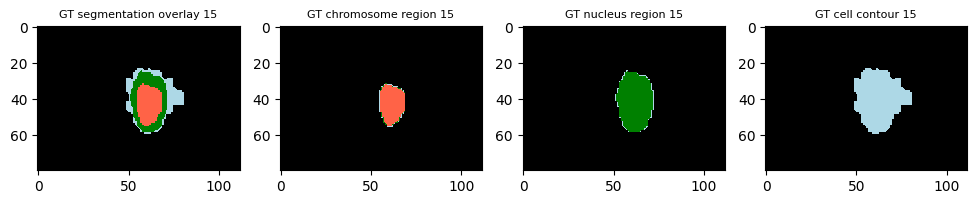

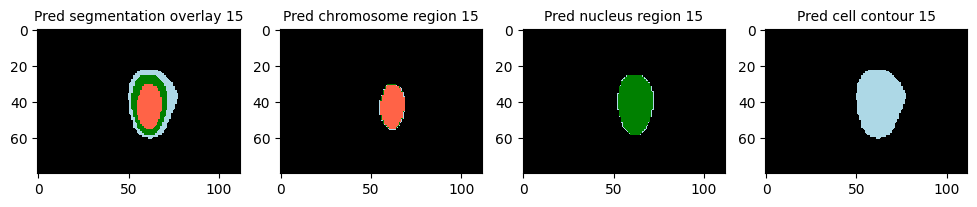

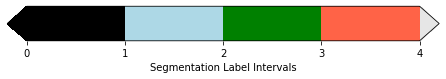

IoU score: 0.878, Chromesome F1score: 0.923, Nucleus F1score: 0.971, Cell F1score: 0.915, Chromesome precision: 0.901, Nucleus precision: 0.985, Cell precision: 0.905, Chromesome recall: 0.946, Nucleus recall: 0.958, Cell recall: 0.924


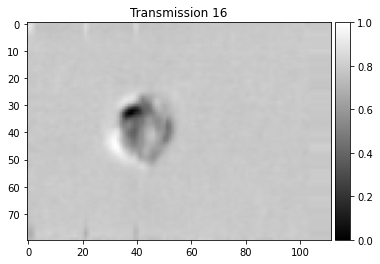

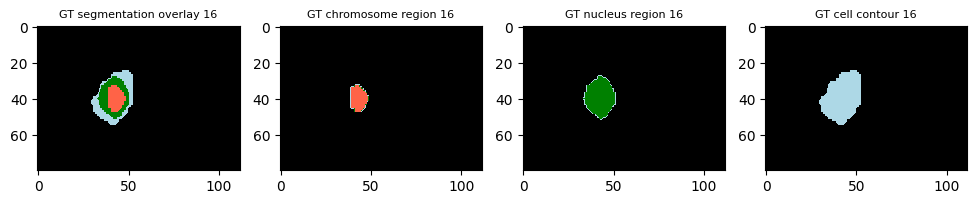

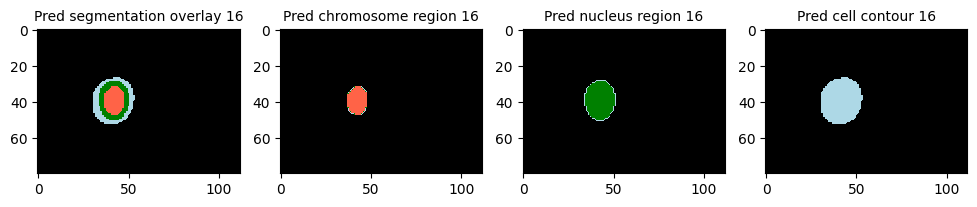

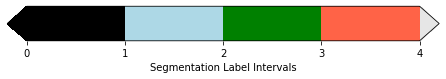

IoU score: 0.847, Chromesome F1score: 0.862, Nucleus F1score: 0.958, Cell F1score: 0.907, Chromesome precision: 0.772, Nucleus precision: 0.946, Cell precision: 0.914, Chromesome recall: 0.974, Nucleus recall: 0.969, Cell recall: 0.901


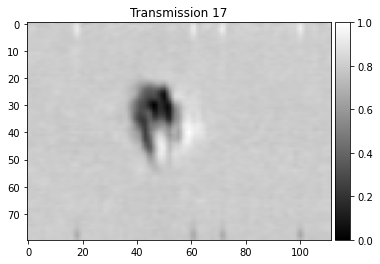

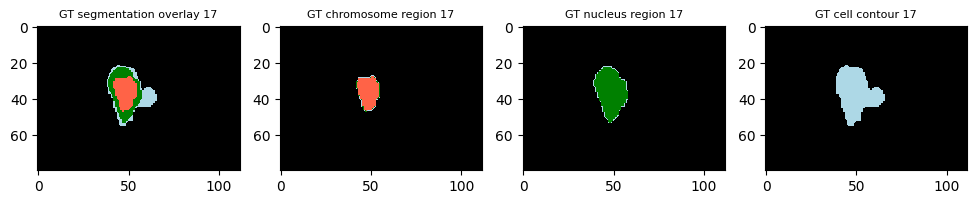

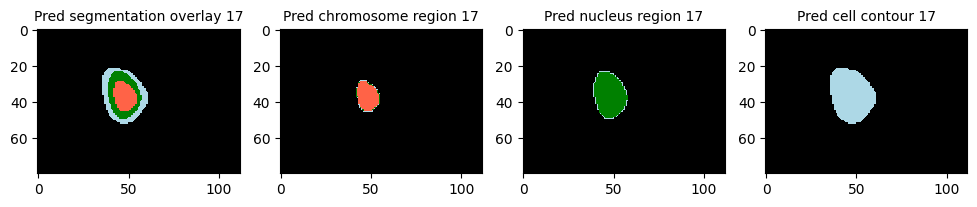

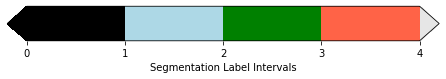

IoU score: 0.752, Chromesome F1score: 0.873, Nucleus F1score: 0.911, Cell F1score: 0.819, Chromesome precision: 0.922, Nucleus precision: 0.929, Cell precision: 0.776, Chromesome recall: 0.828, Nucleus recall: 0.893, Cell recall: 0.869


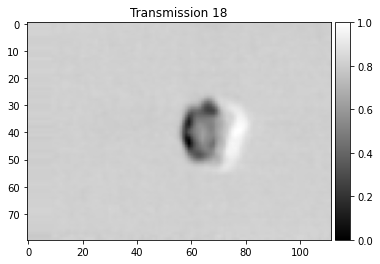

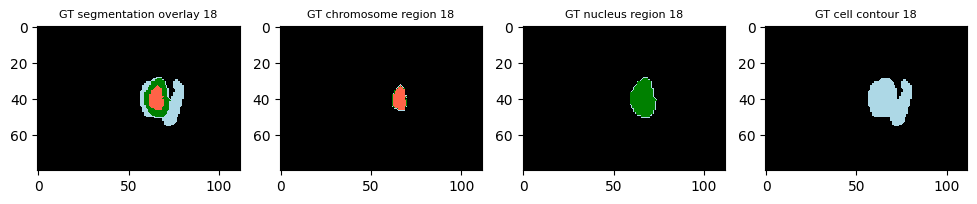

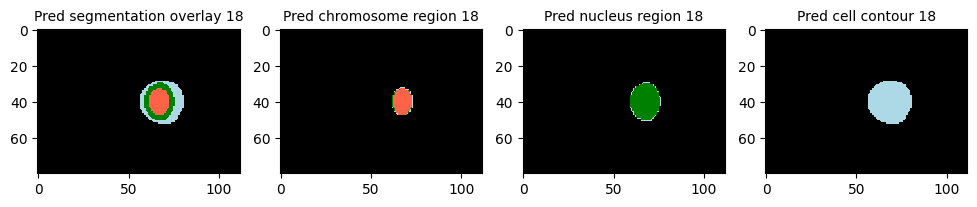

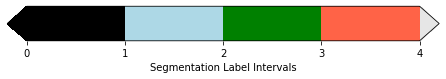

IoU score: 0.790, Chromesome F1score: 0.764, Nucleus F1score: 0.895, Cell F1score: 0.904, Chromesome precision: 0.622, Nucleus precision: 0.824, Cell precision: 0.899, Chromesome recall: 0.988, Nucleus recall: 0.979, Cell recall: 0.909


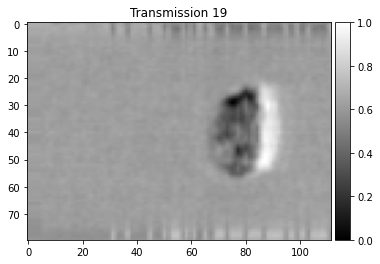

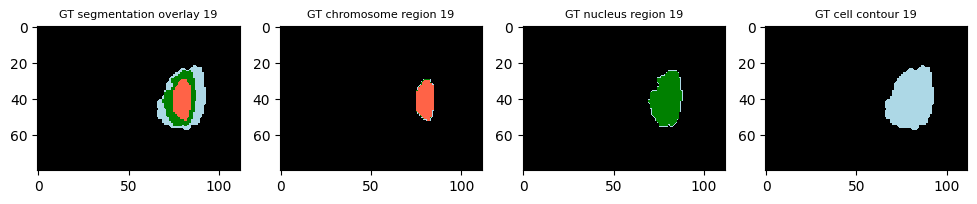

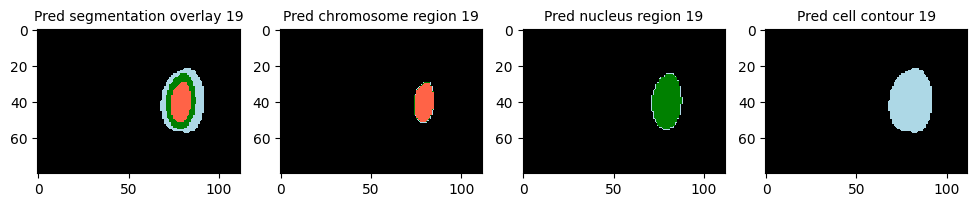

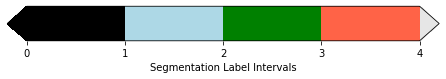

IoU score: 0.859, Chromesome F1score: 0.911, Nucleus F1score: 0.934, Cell F1score: 0.921, Chromesome precision: 0.888, Nucleus precision: 0.963, Cell precision: 0.939, Chromesome recall: 0.936, Nucleus recall: 0.908, Cell recall: 0.904
mean iou_score:  0.8225341950455803
mean precision chromesome:  0.7862952937528421
mean precision nucleus:  0.9225627928278509
mean precision cell:  0.9209772022095843
mean recall chromesome:  0.8696736441644325
mean recall nucleus:  0.9243801262780881
mean recall cell:  0.9065368125846498
mean F1score chromesome:  0.8194708379833554
mean F1score nucleus:  0.9219120855029508
mean F1score cell:  0.9118334886492357
Initializing Datasets and Dataloaders...


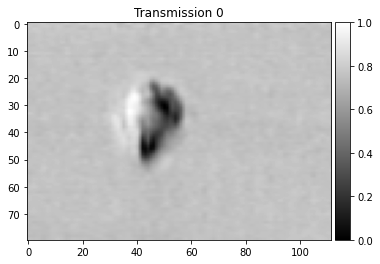

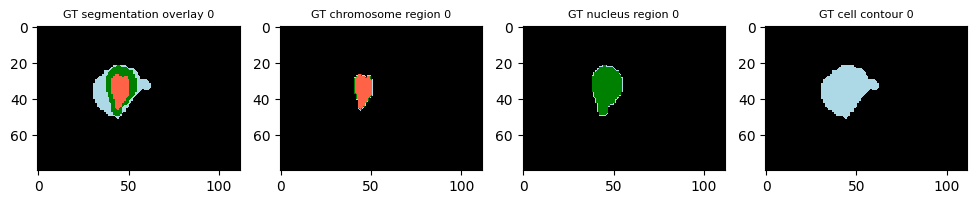

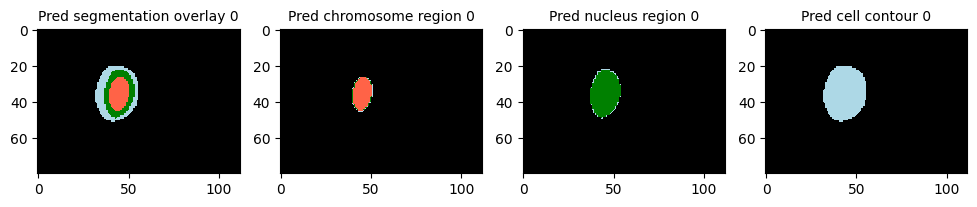

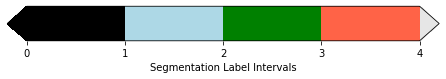

IoU score: 0.799, Chromesome F1score: 0.893, Nucleus F1score: 0.890, Cell F1score: 0.886, Chromesome precision: 0.841, Nucleus precision: 0.876, Cell precision: 0.883, Chromesome recall: 0.952, Nucleus recall: 0.904, Cell recall: 0.889


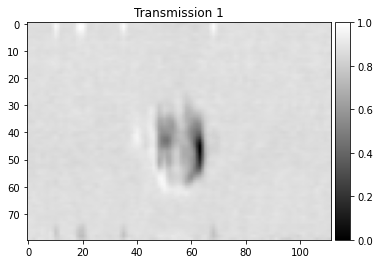

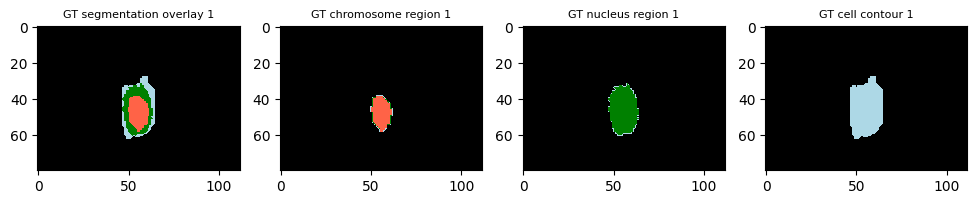

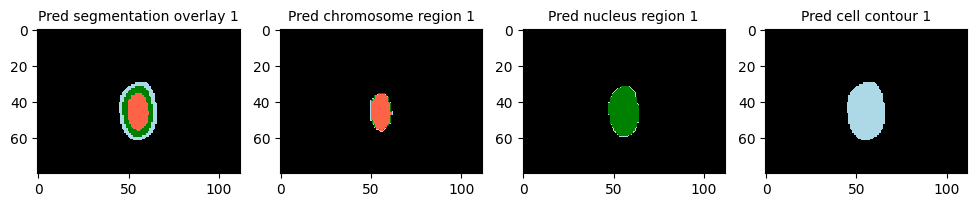

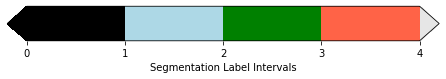

IoU score: 0.852, Chromesome F1score: 0.856, Nucleus F1score: 0.946, Cell F1score: 0.923, Chromesome precision: 0.807, Nucleus precision: 0.934, Cell precision: 0.893, Chromesome recall: 0.912, Nucleus recall: 0.959, Cell recall: 0.955


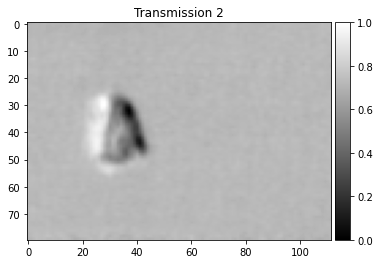

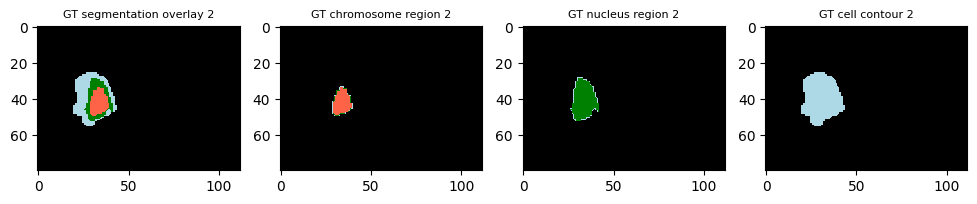

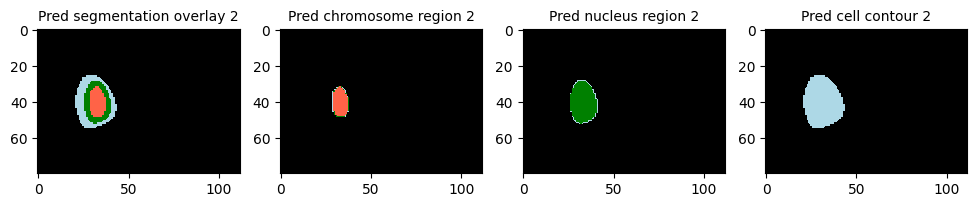

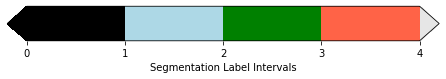

IoU score: 0.832, Chromesome F1score: 0.824, Nucleus F1score: 0.908, Cell F1score: 0.929, Chromesome precision: 0.817, Nucleus precision: 0.859, Cell precision: 0.927, Chromesome recall: 0.831, Nucleus recall: 0.964, Cell recall: 0.931


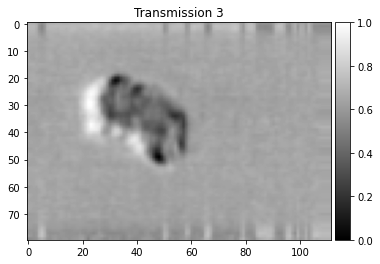

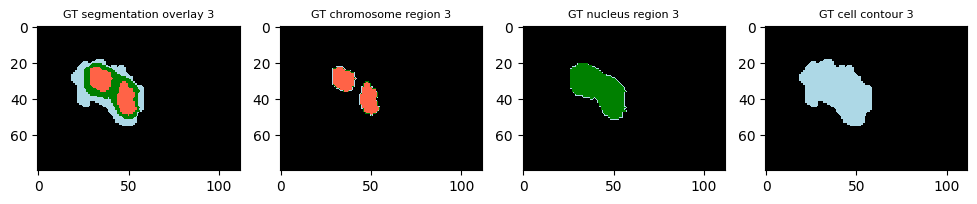

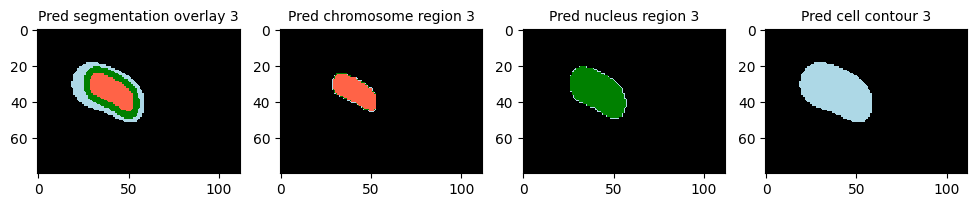

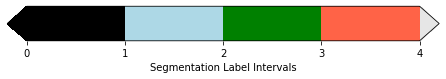

IoU score: 0.809, Chromesome F1score: 0.741, Nucleus F1score: 0.930, Cell F1score: 0.921, Chromesome precision: 0.705, Nucleus precision: 0.914, Cell precision: 0.935, Chromesome recall: 0.781, Nucleus recall: 0.946, Cell recall: 0.908


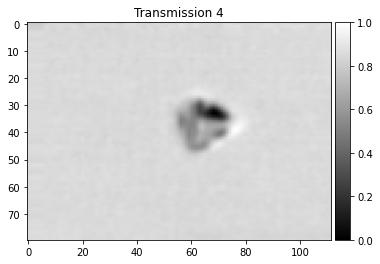

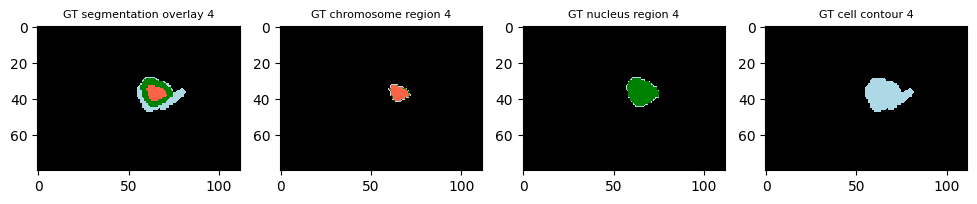

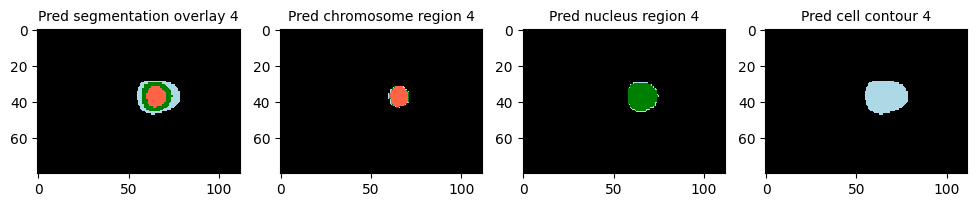

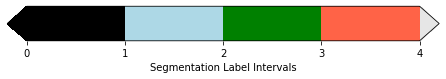

IoU score: 0.798, Chromesome F1score: 0.793, Nucleus F1score: 0.899, Cell F1score: 0.905, Chromesome precision: 0.676, Nucleus precision: 0.872, Cell precision: 0.872, Chromesome recall: 0.958, Nucleus recall: 0.927, Cell recall: 0.940


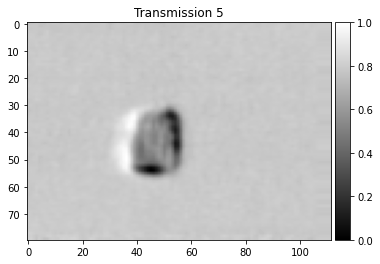

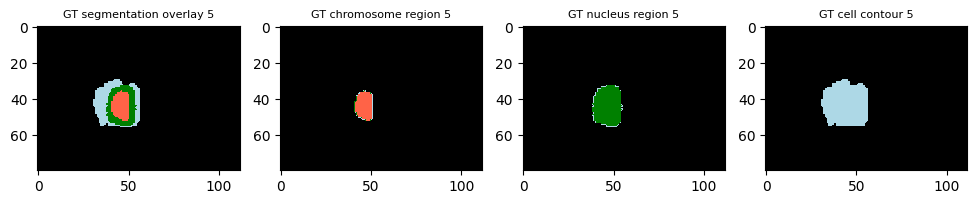

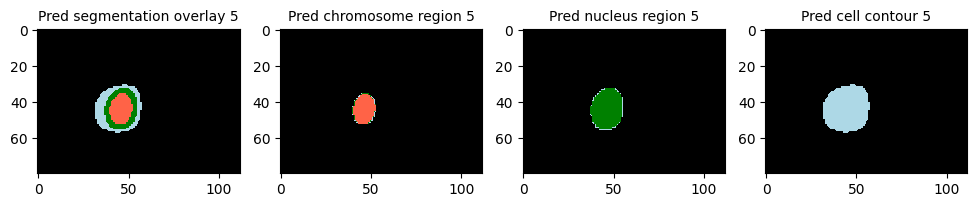

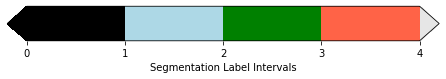

IoU score: 0.860, Chromesome F1score: 0.879, Nucleus F1score: 0.938, Cell F1score: 0.929, Chromesome precision: 0.794, Nucleus precision: 0.910, Cell precision: 0.942, Chromesome recall: 0.985, Nucleus recall: 0.968, Cell recall: 0.916


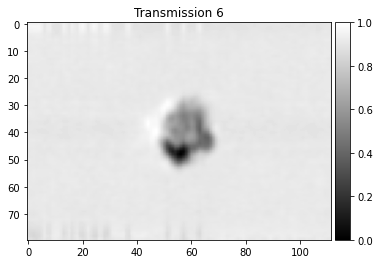

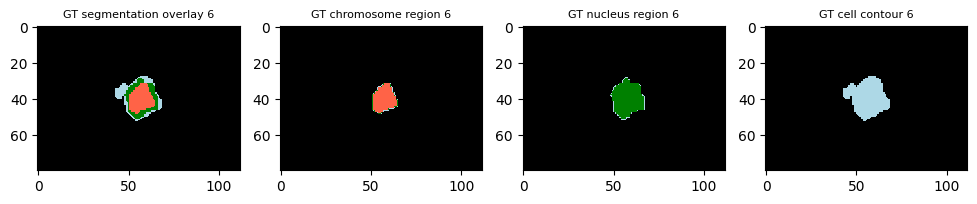

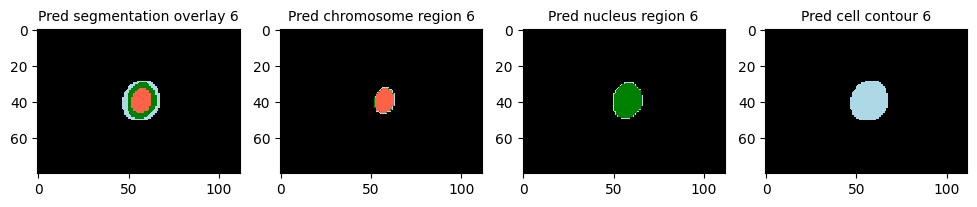

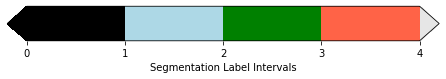

IoU score: 0.792, Chromesome F1score: 0.849, Nucleus F1score: 0.903, Cell F1score: 0.883, Chromesome precision: 0.992, Nucleus precision: 0.969, Cell precision: 0.908, Chromesome recall: 0.743, Nucleus recall: 0.846, Cell recall: 0.860


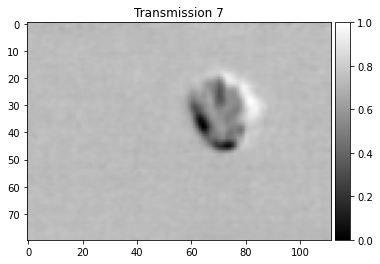

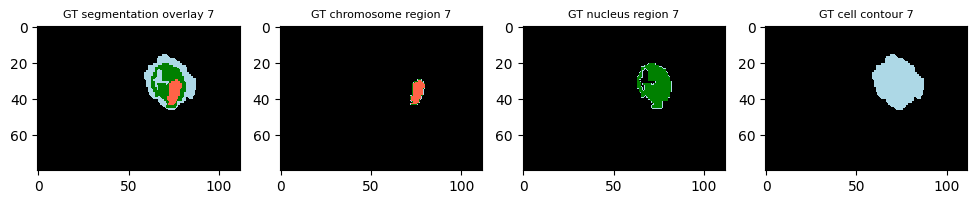

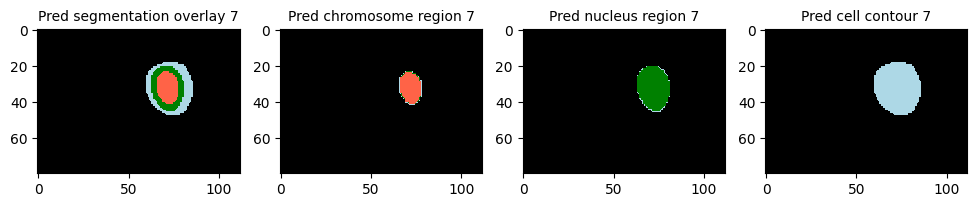

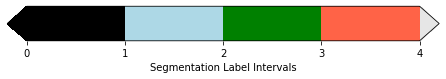

IoU score: 0.719, Chromesome F1score: 0.411, Nucleus F1score: 0.877, Cell F1score: 0.903, Chromesome precision: 0.295, Nucleus precision: 0.807, Cell precision: 0.891, Chromesome recall: 0.675, Nucleus recall: 0.961, Cell recall: 0.915


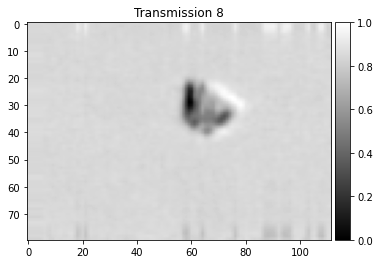

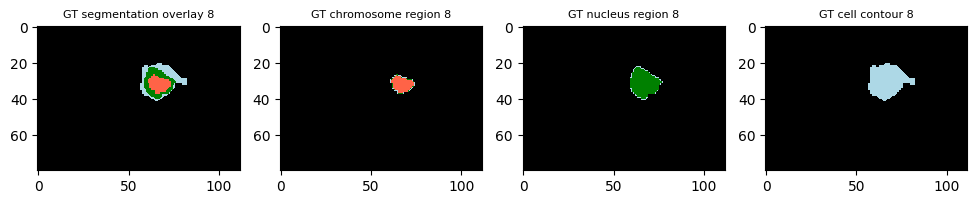

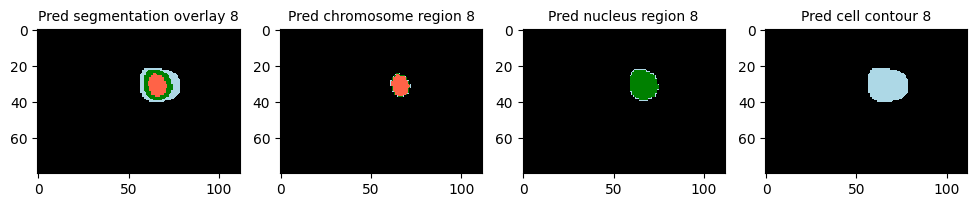

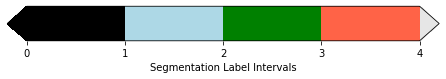

IoU score: 0.806, Chromesome F1score: 0.812, Nucleus F1score: 0.915, Cell F1score: 0.901, Chromesome precision: 0.772, Nucleus precision: 0.894, Cell precision: 0.877, Chromesome recall: 0.857, Nucleus recall: 0.938, Cell recall: 0.926


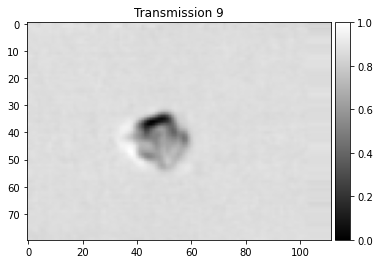

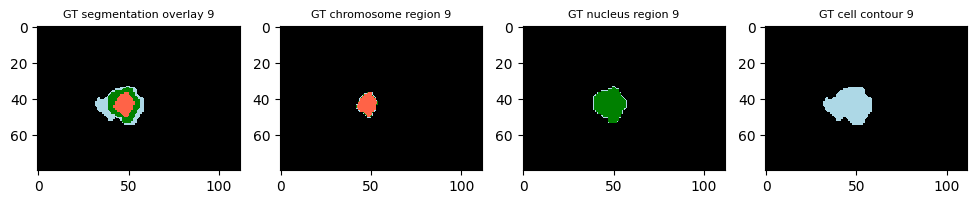

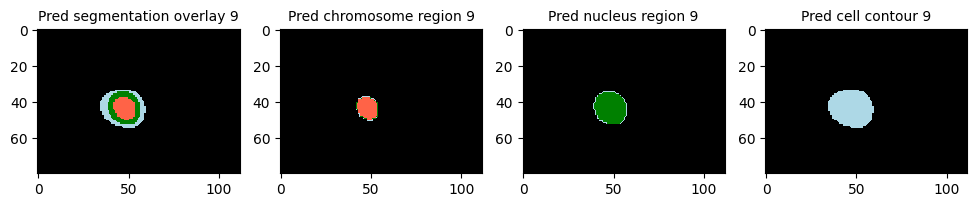

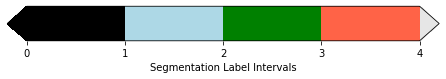

IoU score: 0.831, Chromesome F1score: 0.878, Nucleus F1score: 0.925, Cell F1score: 0.905, Chromesome precision: 0.815, Nucleus precision: 0.902, Cell precision: 0.878, Chromesome recall: 0.953, Nucleus recall: 0.948, Cell recall: 0.934


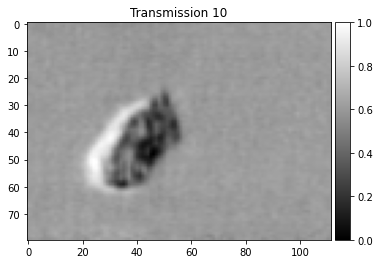

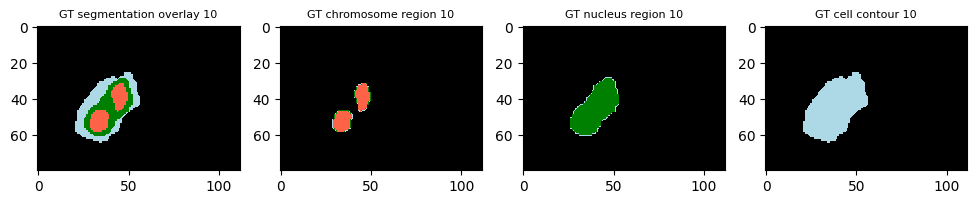

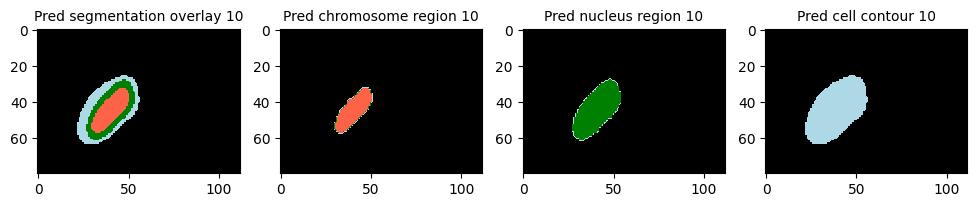

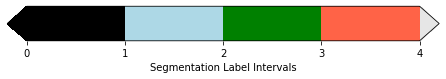

IoU score: 0.832, Chromesome F1score: 0.738, Nucleus F1score: 0.929, Cell F1score: 0.942, Chromesome precision: 0.654, Nucleus precision: 0.905, Cell precision: 0.946, Chromesome recall: 0.846, Nucleus recall: 0.954, Cell recall: 0.939


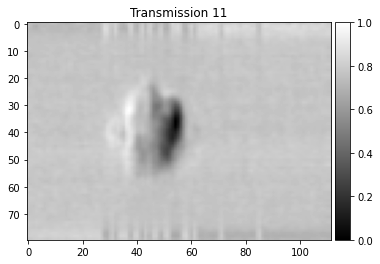

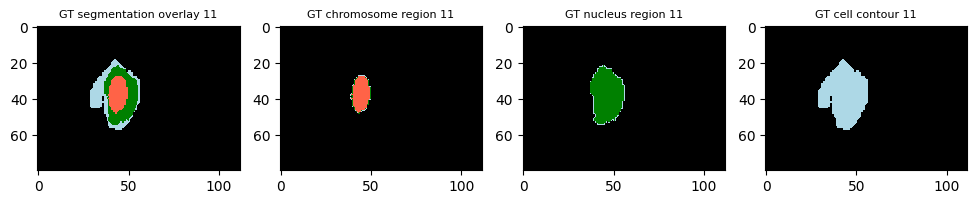

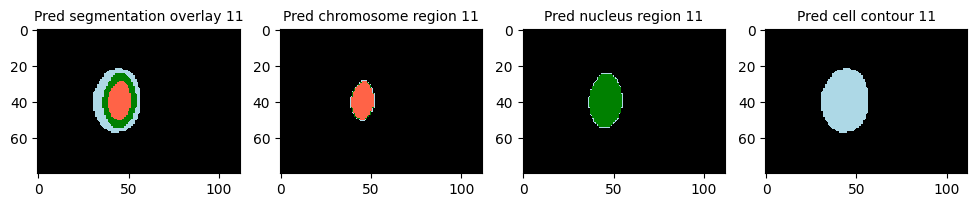

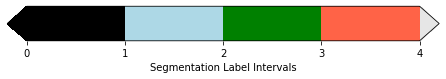

IoU score: 0.798, Chromesome F1score: 0.798, Nucleus F1score: 0.900, Cell F1score: 0.903, Chromesome precision: 0.710, Nucleus precision: 0.920, Cell precision: 0.879, Chromesome recall: 0.910, Nucleus recall: 0.882, Cell recall: 0.929


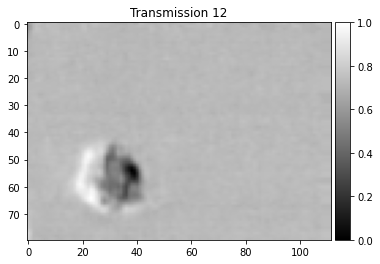

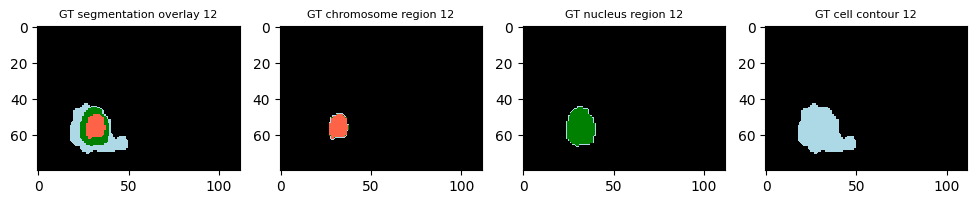

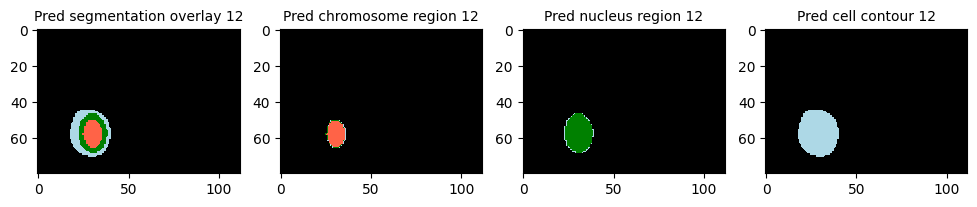

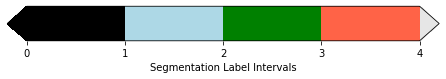

IoU score: 0.746, Chromesome F1score: 0.729, Nucleus F1score: 0.860, Cell F1score: 0.881, Chromesome precision: 0.714, Nucleus precision: 0.871, Cell precision: 0.979, Chromesome recall: 0.744, Nucleus recall: 0.849, Cell recall: 0.802


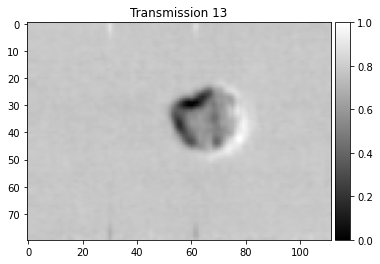

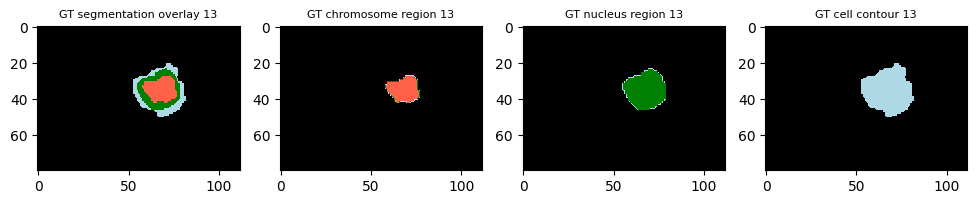

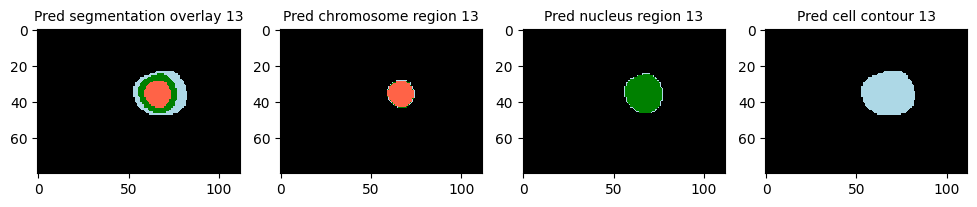

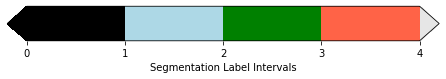

IoU score: 0.823, Chromesome F1score: 0.794, Nucleus F1score: 0.917, Cell F1score: 0.929, Chromesome precision: 0.857, Nucleus precision: 0.967, Cell precision: 0.929, Chromesome recall: 0.739, Nucleus recall: 0.873, Cell recall: 0.929


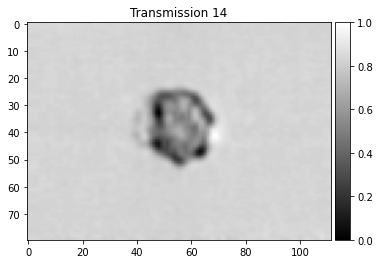

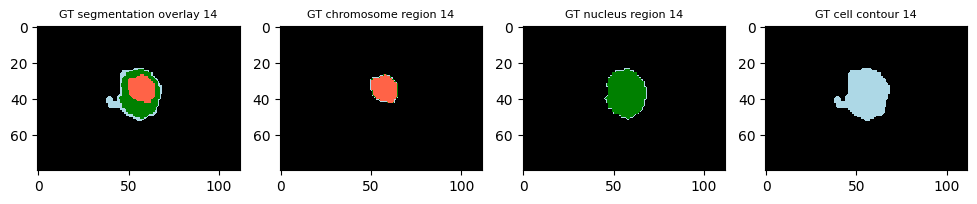

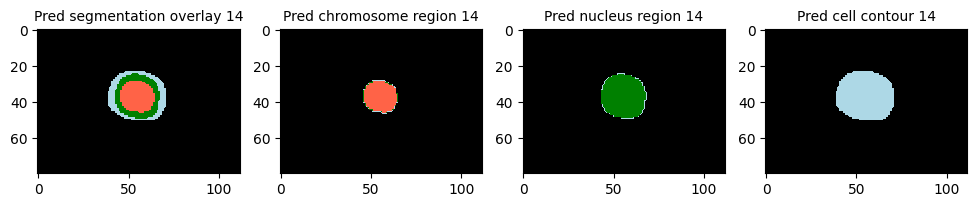

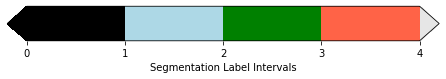

IoU score: 0.746, Chromesome F1score: 0.709, Nucleus F1score: 0.915, Cell F1score: 0.861, Chromesome precision: 0.593, Nucleus precision: 0.888, Cell precision: 0.775, Chromesome recall: 0.880, Nucleus recall: 0.943, Cell recall: 0.969


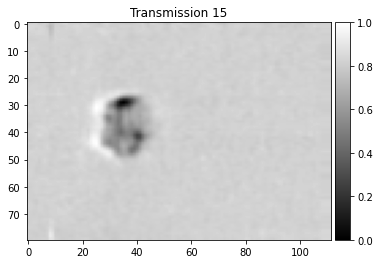

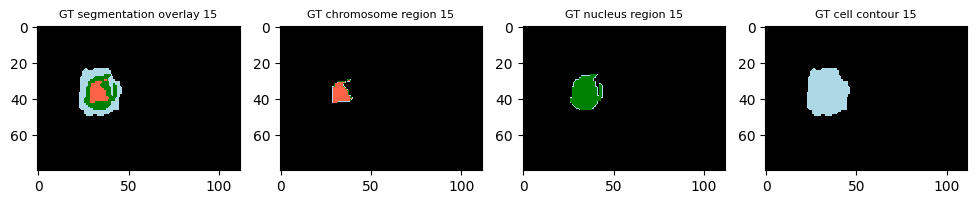

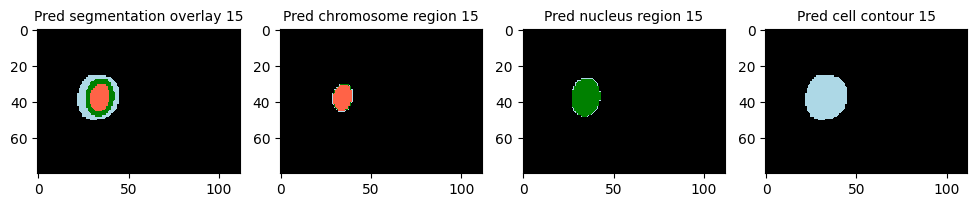

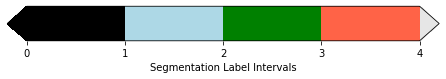

IoU score: 0.796, Chromesome F1score: 0.738, Nucleus F1score: 0.898, Cell F1score: 0.914, Chromesome precision: 0.624, Nucleus precision: 0.878, Cell precision: 0.953, Chromesome recall: 0.902, Nucleus recall: 0.919, Cell recall: 0.878


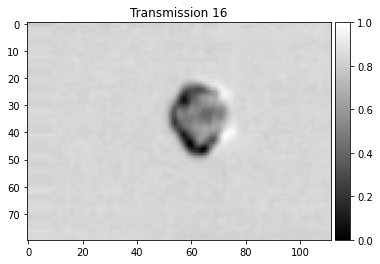

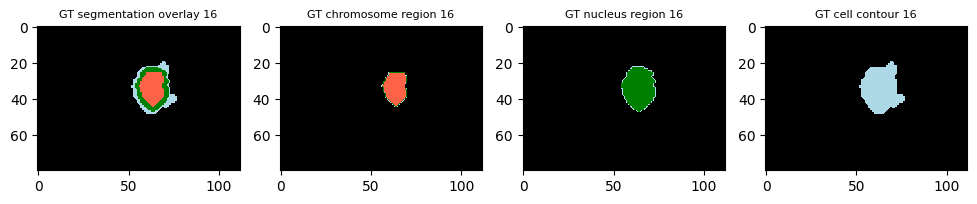

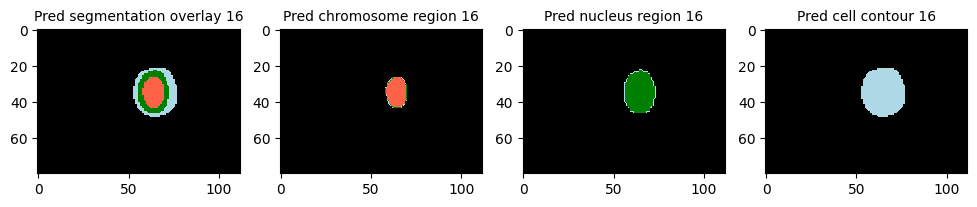

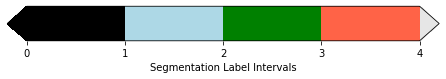

IoU score: 0.844, Chromesome F1score: 0.880, Nucleus F1score: 0.940, Cell F1score: 0.911, Chromesome precision: 0.963, Nucleus precision: 0.973, Cell precision: 0.861, Chromesome recall: 0.810, Nucleus recall: 0.909, Cell recall: 0.966


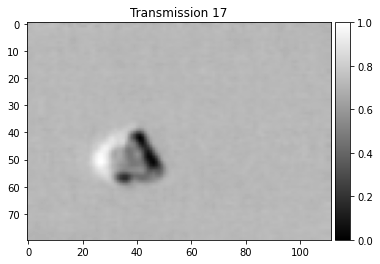

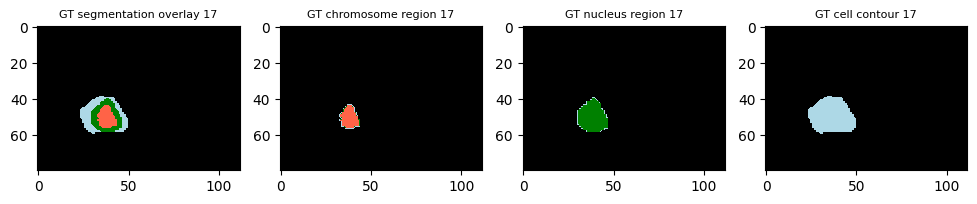

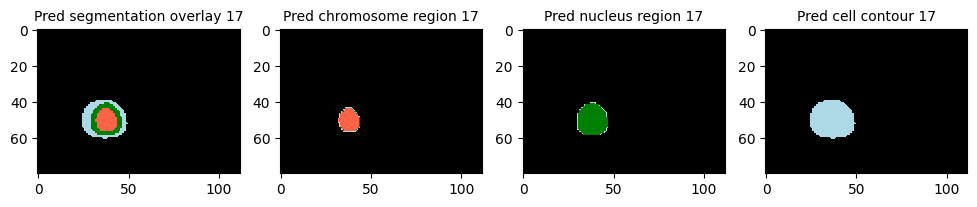

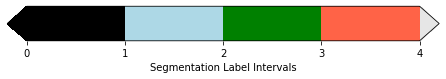

IoU score: 0.883, Chromesome F1score: 0.902, Nucleus F1score: 0.951, Cell F1score: 0.940, Chromesome precision: 0.828, Nucleus precision: 0.924, Cell precision: 0.927, Chromesome recall: 0.990, Nucleus recall: 0.979, Cell recall: 0.954


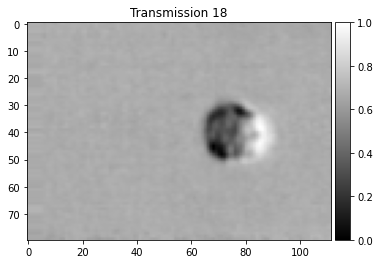

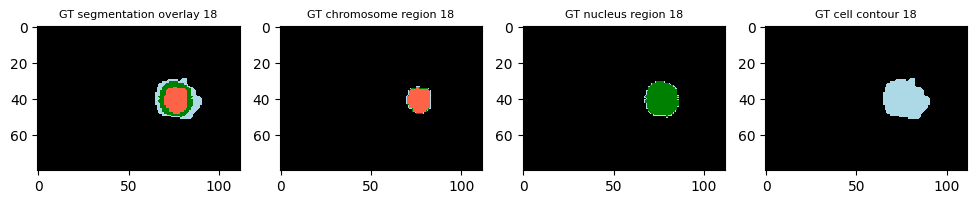

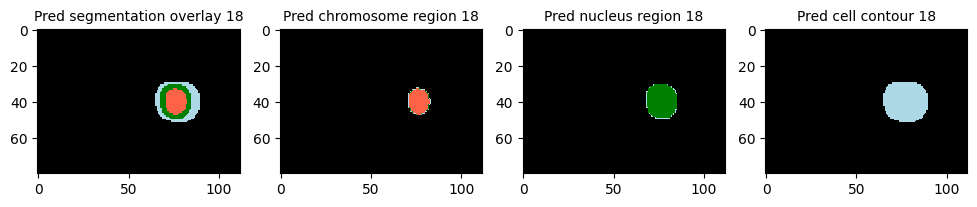

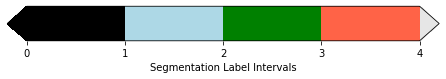

IoU score: 0.881, Chromesome F1score: 0.885, Nucleus F1score: 0.953, Cell F1score: 0.943, Chromesome precision: 0.949, Nucleus precision: 0.975, Cell precision: 0.919, Chromesome recall: 0.829, Nucleus recall: 0.932, Cell recall: 0.968


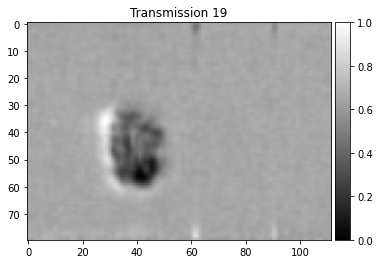

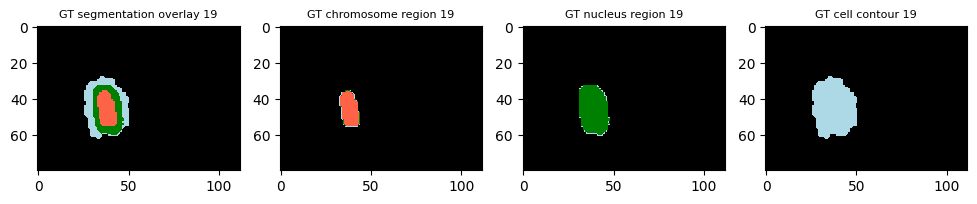

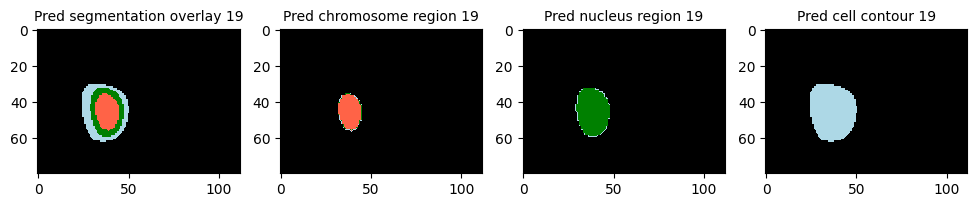

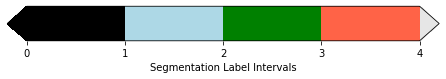

IoU score: 0.856, Chromesome F1score: 0.889, Nucleus F1score: 0.928, Cell F1score: 0.929, Chromesome precision: 0.812, Nucleus precision: 0.913, Cell precision: 0.931, Chromesome recall: 0.983, Nucleus recall: 0.944, Cell recall: 0.926
mean iou_score:  0.8247727553418739
mean precision chromesome:  0.7813258207006388
mean precision nucleus:  0.9129798005094706
mean precision cell:  0.9075824175492619
mean recall chromesome:  0.8787300059058452
mean recall nucleus:  0.9359356760415393
mean recall cell:  0.9222976191140306
mean F1score chromesome:  0.8213939846850776
mean F1score nucleus:  0.9227107371417725
mean F1score cell:  0.9129861988170722


In [32]:
for runs in range (0,5):
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
#     image_datasets['train'] = MyDataset(trainpath[0:3000])
#     image_datasets['val'] = MyDataset(testpath[0:600])
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)
    print("Initializing Datasets and Dataloaders...")
    # Number of classes in the dataset
    num_classes = 3

    # Batch size for training (change depending on how much memory you have)
    batch_size = 1024
    # Create training and test dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}
    
    # Initialize the non-pretrained version of the model used for this run
    fname = './cellSegmentationmodel-UNetSmall_rech_Run_'+str(runs)+'.pth.tar'
    scratch_model = torch.load(fname)
    # scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),Flatten(),*(list(scratch_model.children())[-5:-3]))
    # scratch_model_fc = nn.Sequential(*list(scratch_model.children())[:-3])
    scratch_model = scratch_model.to(device)
    scratch_model.eval()

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for i, (inputs,labels,idex) in enumerate(dataloaders_dict['val']):
    #         inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
    #         labels = labels.to(device)
            outputs = scratch_model(inputs)
            outputs = torch.sigmoid(outputs)
            inputs = inputs.cpu().clone().numpy()
            outputs = outputs.cpu().clone().numpy()
            labels = labels.clone().numpy()
            if i == 0:
                inputlist = inputs
                outputlist = outputs
                labellist = labels
    #             y = classes.cpu().clone().numpy()
            else:
                inputlist = np.append(inputlist,inputs, axis=0)
                outputlist = np.append(outputlist,outputs, axis=0)
                labellist = np.append(labellist,labels,axis=0)
    #             y = np.append(y,classes.cpu().clone().numpy(), axis=0)

        iou_scoreList = 0
    for ImgIdx in range(0,20):
        image = np.transpose(inputlist[ImgIdx],(1,2,0))
        mask = labellist[ImgIdx]
        # print(image.shape)
        DisplayImage(image,image.min(),image.max(),ImgIdx)
        SegmentationVisualGT(mask,image,ImgIdx)
        maskpred = outputlist[ImgIdx]
        maskpred = np.round(maskpred).astype(np.uint8)
        SegmentationVisualPred(maskpred,image,ImgIdx)
        maskbool = mask.astype(dtype=bool)
    #     print(mask.shape)
        iou_score = clac_iouscore (mask, maskpred)
        Precision, Recall, F1score = clac_F1 (mask, maskpred)
        print('IoU score: %.3f, Chromesome F1score: %.3f, Nucleus F1score: %.3f, Cell F1score: %.3f, Chromesome precision: %.3f, Nucleus precision: %.3f, Cell precision: %.3f, Chromesome recall: %.3f, Nucleus recall: %.3f, Cell recall: %.3f'% (iou_score, F1score[0], F1score[1], F1score[2], Precision[0], Precision[1], Precision[2], Recall[0], Recall[1], Recall[2]))
        if i == 0:
            iou_scoreList = iou_score
        else:
            np.append(iou_scoreList,iou_score)
            
    
    iou_scoreList = np.zeros((outputlist.shape[0],))
    precisionList = np.zeros((outputlist.shape[0],3))
    recallList = np.zeros((outputlist.shape[0],3))
    F1scoreList = np.zeros((outputlist.shape[0],3))

    for ImgIdx in range(0,outputlist.shape[0]):
        image = np.transpose(inputlist[ImgIdx],(1,2,0))
        mask = labellist[ImgIdx]
        # print(image.shape)
    #     DisplayImage(image,image.min(),image.max(),ImgIdx)
    #     SegmentationVisualGT(mask,image,ImgIdx)
        maskpred = outputlist[ImgIdx]
        maskpred = np.round(maskpred).astype(np.uint8)
    #     SegmentationVisualPred(maskpred,image,ImgIdx)
    #     maskbool = mask.astype(dtype=bool)
    #     print(mask.shape)
        iou_score = clac_iouscore (mask, maskpred)
        Precision, Recall, F1score = clac_F1 (mask, maskpred)
        iou_scoreList[ImgIdx] = iou_score
        precisionList[ImgIdx] = Precision
        recallList[ImgIdx] = Recall
        F1scoreList[ImgIdx] = F1score
        
    meaniou_score = np.mean(iou_scoreList)
    meanprecisionChrome = np.mean(precisionList[:,0])
    meanprecisionNucleus = np.mean(precisionList[:,1])
    meanprecisionCell = np.mean(precisionList[:,2])
    print('mean iou_score: ',meaniou_score)
    print('mean precision chromesome: ', meanprecisionChrome)
    print('mean precision nucleus: ', meanprecisionNucleus)
    print('mean precision cell: ', meanprecisionCell)
    print('mean recall chromesome: ', np.mean(recallList[:,0]))
    print('mean recall nucleus: ', np.mean(recallList[:,1]))
    print('mean recall cell: ', np.mean(recallList[:,2]))
    print('mean F1score chromesome: ', np.mean(F1scoreList[:,0]))
    print('mean F1score nucleus: ', np.mean(F1scoreList[:,1]))
    print('mean F1score cell: ', np.mean(F1scoreList[:,2]))